KSZ + Galaxy Mnu constraints

In [48]:
import numpy as np
import os,sys,re
import warnings
import stats
import itertools
from pandas import DataFrame
import pandas as pd
import datetime
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic as binnedstat
from matplotlib import pyplot as plt

from scipy import integrate

In [2]:
import matplotlib
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
matplotlib.rcParams.update({'font.size': 16})
#plt.rcParams['text.usetex'] = True
labelsize=50
font = {#'family': 'serif',
        #'color':  'darkred',
        #'weight': 'normal',
        'size': labelsize,
        }

In [3]:
#add regular CAMB to path, importing regular CAMB
camb_path = os.path.realpath(os.path.join(os.getcwd(),'/Users/averytishue/Downloads/CAMB-1.5.1/'))
sys.path.insert(0,camb_path)
import camb
# print('CAMB: %s, Sympy: %s'%(camb.__version__,sympy.__version__))

# Setting Fiducial cosmology, fisher step sizes, basic functions

In [1899]:
#basic parameter values and functions

#fiducial LCDM values and step sizes for fishers

#define two possible mnu fiducials depending on hierarchy
mnustandard= 0.06
mnuinverted = 0.1 #wont use this

##old fids and steps
fids_old = {'As':2.2e-9,'H0':67.67,'ombh2':0.022,
            'omch2':0.12,'ns':0.965,'mnu':mnustandard,'tau':0.06, 
            'nnu':3.046 ,'w0':-1.,'wa':0.,'ok':0}

step_old = {'As':0.01 * fids_old['As'],'H0':0.01 * fids_old['H0'],'ombh2':0.01 * fids_old['ombh2'],'omch2':0.01 * fids_old['omch2'],
         'nnu':0.01 * fids_old['nnu'],'ok':0.05,'tau' :0.3 * fids_old['tau'],'w0':0.01 * fids_old['w0'],'wa':0.01 * fids_old['wa'],
         'ns':0.01 * fids_old['ns'],'mnu':0.3 * fids_old['mnu']}

##fids and steps from pyfisher
fids_pyfisher = {'As':2.15086031154146e-9,'H0':67.02393,'ombh2':0.02219218,
            'omch2':0.1203058,'ns':0.9625356,'mnu':mnustandard,'tau':0.06574325, 
            'nnu':3.046 ,'w0':-1.0,'wa':0.0,'ok':0}

step_pyfisher = {'As':(0.01*fids_pyfisher['As']),'H0':(0.01*fids_pyfisher['H0']),'ombh2':(0.01*fids_pyfisher['ombh2']),'omch2':(0.01*fids_pyfisher['omch2']),
         'nnu':(0.05*fids_pyfisher['nnu']),'ok':0.05,'tau':(0.05*fids_pyfisher['tau']),'w0':0.05,'wa':0.1,
         'ns':(0.01*fids_pyfisher['ns']),'mnu':(0.1*fids_pyfisher['mnu'])}

#pick one of the two above to use
fids_cdm = fids_old #fids_pyfisher #fids_old

step_cdm = step_old #step_pyfisher #step_old



delta_params_cdm = {'As': 2*step_cdm['As'], 'H0': 2*step_cdm['H0'], 'ombh2': 2*step_cdm['ombh2'],
                    'omch2': 2*step_cdm['omch2'], 'nnu': 2*step_cdm['nnu'], 'ok': 2*step_cdm['ok'],
                    'tau': 2*step_cdm['tau'], 'w0': 2*step_cdm['w0'], 'wa': 2*step_cdm['wa'],
                    'ns': 2*step_cdm['ns'], 'mnu': 2*step_cdm['mnu']}

#old H0 66.87

params=fids_cdm

#useful to define a few fiducial parameters used frequently.
Asfid=fids_cdm['As'] 
nsfid=fids_cdm['ns'] 

H0fid=fids_cdm['H0']
littlehfid=H0fid/100

omch2fid=fids_cdm['omch2']
ombh2fid=fids_cdm['ombh2']

omcfid=fids_cdm['omch2']/(littlehfid**2)
ombfid=fids_cdm['ombh2']/(littlehfid**2)

Om0fid=omcfid+ombfid

def Om0_func(H0,ombh2,omch2):
    littleh = H0/100.
    Omb = ombh2/(littleh**2)
    Omc = omch2/(littleh**2)
    Om0 = Omb + Omc
    return Om0

#c in km/s used to convert H0 into inverse MPc
ckmpers=3e5

H0invMPc_fid = H0fid/ckmpers

#define simple H(z) for fiducial cosmology
def HofzedfidLCDM(z):
    Om0=Om0fid ##matter
    OL0=1-Om0  ##cosmo constant
    H0=H0fid
    H0invMPc=H0/ckmpers ##convert to inv Mpc
    Hz=H0invMPc * (Om0*(1+z)**3 + OL0)**(0.5)
    return Hz

#define simple H(z) for any cosmology
def Hofzed_general(z,H0,ombh2,omch2):
    h=H0/100
    Om0=(ombh2+omch2)/(h**2) ##matter
    OL0=1-Om0  ##cosmo constant
    H0invMPc=H0/ckmpers ##convert to inv Mpc
    Hz=H0invMPc * (Om0*(1+z)**3 + OL0)**(0.5)
    return Hz

#gives chi(z) for universe with no radiation, with any H0 and \Omega_matter vaalues
def chiatz(zmax,H0,omegam):
    z0=0
    nz=int(1e6)
    zlist=np.linspace(z0,zmax,nz)
    integrandlist=ckmpers/(H0*np.sqrt(omegam*(1+zlist)**3+1-omegam))
    chivalue=np.trapz(integrandlist,x=zlist)
    return chivalue 

#chi(z) for fiducial cosmology
def chiatzfid(z):
    return chiatz(z,H0fid,Om0fid) 

#gives a minimum k (maximum \lambda) for a box size
def kminfromVol(volume):
    L=volume**(1/3)
    return np.pi/L    

#photoz function
def Wphotofunc(kL,mu,z,sigz):
    Hstar=HofzedfidLCDM(z)
    return np.exp(-mu*mu*kL*kL*sigz*sigz/(2*Hstar**2))
  

# Survey details

In [7]:
##stuff for surveys, both at various redshifts and also for a snapshot z=1 geometry

# let's define the mean redshifts for our boxes: TableI of 1810.13424 for LSST
z_mean = [0.2,0.7,1.3,1.9,2.6]
# ...now the halo bias parameters (in the absense of some other physics, simply from the halo model)
b = {0.2:1.05, 0.7:1.37, 1.3:1.79, 1.9:2.22, 2.6:2.74}
# ...and the volumes corresponding to each box (in Mpc^3)
vol = {0.2:5.2e9, 0.7:43.6e9, 1.3:75.9e9, 1.9:89.3e9, 2.6:119.9e9}
# ...and the densities corresponding to each box (in 1/Mpc^3)
ngal = {0.2:0.05, 0.7:0.02, 1.3:0.006, 1.9:0.0015, 2.6:0.0003}

#this dictionary just converts the z value to its position in the array
zposition={z_mean[0]:0, z_mean[1]:1, z_mean[2]:2, z_mean[3]:3, z_mean[4]:4}

#also get minimum kL for each box
kLmin = {0.2:kminfromVol(vol[0.2]), 0.7:kminfromVol(vol[0.7]), 1.3:kminfromVol(vol[1.3]), 1.9:kminfromVol(vol[1.9]), 2.6:kminfromVol(vol[2.6])}

##sigma_z for LSST is 0.03(1+z)
sigz_LSST = {0.2:(0.03)*(1+0.2), 0.7:(0.03)*(1+0.7), 1.3:(0.03)*(1+1.3), 1.9:(0.03)*(1+1.9), 2.6:(0.03)*(1+2.6) }

#useful to have a dictionary for fiducial chi(z) values
chifids={z_mean[0]:chiatzfid(z_mean[0]), z_mean[1]:chiatzfid(z_mean[1]), z_mean[2]:chiatzfid(z_mean[2]), z_mean[3]:chiatzfid(z_mean[3]), z_mean[4]:chiatzfid(z_mean[4])}



# function compute Pmm for varying cosmology

In [1900]:
def computeMatter(mattervar, nonlinear_Bool, DEmodel, zs, kmax_pars, kmax_pmm, zmax_pmm, hubble_units_Bool, param_defaults, param_deltas, param_to_alter):
    if param_to_alter not in param_defaults.keys():
        print('Error: param to alter not in paramlist')
        exit()
    else:
        param_dic_touse_h = param_defaults.copy()
        param_dic_touse_l = param_defaults.copy()
        param_dic_touse_h[param_to_alter] = param_defaults[param_to_alter] + param_deltas[param_to_alter]
        param_dic_touse_l[param_to_alter] = param_defaults[param_to_alter] - param_deltas[param_to_alter]
    
    pars_regularCAMB.set_cosmology(H0=param_dic_touse_h['H0'], ombh2=param_dic_touse_h['ombh2'], omch2=param_dic_touse_h['omch2'], tau=param_dic_touse_h['tau'], mnu=param_dic_touse_h['mnu'], omk=param_dic_touse_h['ok'], nnu=param_dic_touse_h['nnu'])
    pars_regularCAMB.InitPower.set_params( As=param_dic_touse_h['As'], ns=param_dic_touse_h['ns'], r=0)
    pars_regularCAMB.set_dark_energy(w=param_dic_touse_h['w0'], wa=0, dark_energy_model=DEmodel)
    pars_regularCAMB.set_matter_power(redshifts=zs, kmax=kmax_pars)

    Pmm_h = camb.get_matter_power_interpolator(pars_regularCAMB, nonlinear=nonlinear_Bool, hubble_units=hubble_units_Bool, k_hunit=hubble_units_Bool, kmax=kmax_pmm, zmax=zmax_pmm, var1=mattervar,var2=mattervar)
    results_h = camb.get_results(pars_regularCAMB)
    sigma8_h=np.array(results_h.get_sigma8())
    fsigma8_h=np.array(results_h.get_fsigma8())
    f_h= fsigma8_h/sigma8_h

    transfunc_h = results_h.get_matter_transfer_data()
    kh_h = transfunc_h.transfer_data[0,:,0]
    tot_trans_h = transfunc_h.transfer_data[model.Transfer_tot-1,:,0]
    tot_trans_renorm_h = tot_trans_h/tot_trans_h[0]
    littleh_h = param_dic_touse_h['H0']/100
    k_for_transfuncs_h = kh_h*(littleh_h)
    tot_trans_renorm_interp_h = interp1d(k_for_transfuncs_h,tot_trans_renorm_h,kind='cubic')


    cosmohere_h = camb.get_results(pars_regularCAMB)
    Hzed_h = lambda z: cosmohere_h.hubble_parameter(z)/(ckmpers)# 1/Mpc
    
    #
    pars_regularCAMB.set_cosmology(H0=param_dic_touse_l['H0'], ombh2=param_dic_touse_l['ombh2'], omch2=param_dic_touse_l['omch2'], tau=param_dic_touse_l['tau'], mnu=param_dic_touse_l['mnu'], omk=param_dic_touse_l['ok'], nnu=param_dic_touse_l['nnu'])
    pars_regularCAMB.InitPower.set_params( As=param_dic_touse_l['As'], ns=param_dic_touse_l['ns'], r=0)
    pars_regularCAMB.set_dark_energy(w=param_dic_touse_l['w0'], wa=0, dark_energy_model=DEmodel)
    pars_regularCAMB.set_matter_power(redshifts=zs, kmax=kmax_pars)

    Pmm_l = camb.get_matter_power_interpolator(pars_regularCAMB, nonlinear=nonlinear_Bool, hubble_units=hubble_units_Bool, k_hunit=hubble_units_Bool, kmax=kmax_pmm, zmax=zmax_pmm, var1=mattervar,var2=mattervar)
    results_l = camb.get_results(pars_regularCAMB)
    sigma8_l=np.array(results_l.get_sigma8())
    fsigma8_l=np.array(results_l.get_fsigma8())
    f_l= fsigma8_l/sigma8_l

    transfunc_l = results_l.get_matter_transfer_data()
    kh_l = transfunc_l.transfer_data[0,:,0]
    tot_trans_l = transfunc_l.transfer_data[model.Transfer_tot-1,:,0]
    tot_trans_renorm_l = tot_trans_l/tot_trans_l[0]
    littleh_l = param_dic_touse_l['H0']/100
    k_for_transfuncs_l = kh_l*(littleh_l)
    tot_trans_renorm_interp_l = interp1d(k_for_transfuncs_l,tot_trans_renorm_l,kind='cubic')

    cosmohere_l = camb.get_results(pars_regularCAMB)
    Hzed_l = lambda z: cosmohere_l.hubble_parameter(z)/(ckmpers)# 1/Mpc

    return Pmm_h,Pmm_l, f_h,f_l, tot_trans_renorm_interp_h,tot_trans_renorm_interp_l, Hzed_h, Hzed_l


# kL and mu stuff

In [24]:
numkL = 100
kL_ofz = np.zeros([len(z_mean),numkL])
for iz, z in enumerate(z_mean):
    kL_ofz[iz] = np.geomspace(kLmin[z], 0.1, numkL)

nummu = 102
mulist = np.linspace(-1,1,nummu)



# experimental noise

## galaxy shot noise

In [25]:

numz = len(z_mean)
#initiallize noise arrays. works like N[zindex][muindex][kLindex] = (mu,kL, noise value)
N0_ofz = np.zeros([numz,nummu,numkL,3]) #this is for zero noise
Ng_ofz = np.zeros([numz,nummu,numkL,3]) #galaxy noise
NgWsq_ofz = np.zeros([numz,nummu,numkL,3]) ##galaxy noise but also includes a factor of 1/W^2

#define an S_00 is just an array for when signal value is 0 (i.e. one of the perpendicular veloctiy signals) 
#its entries are  S_00[zindex][muindex][kLindex] = (mu, kL, 0)
S00_ofz = np.zeros([numz,nummu,numkL,3])

#now compute all the noises    
for z in z_mean:
    
    #get the index associated with the 
    zind = zposition[z]
    

    #need redshift sigma_z, galaxy bias, and galaxy number density 
    sigzhere = sigz_LSST[z]
    nghere = ngal[z]

    for muind in range(nummu):
        mu = mulist[muind]

        for kLind in range(numkL):
            kL = kL_ofz[zind][kLind]
            
            Wsquared=(Wphotofunc(kL,mu,z,sigzhere))**2

            ##Note W^2 factors have been included in the definition of S_{ij}, so we won't use NgWsq_ofz, but i define it anyways
            Ng_ofz[zind][muind][kLind][2]=1./(nghere)
            NgWsq_ofz[zind][muind][kLind][2]=1./(Wsquared*nghere)
            
            #kSZ noise is loaded in earlier, for varying \delta T, from Selim
            
            #make an array for when S_{ij} = 0 . still want it to contain mu and kL values, like the other signal matrices
            S00_ofz[zind][muind][kLind][0]=mu
            S00_ofz[zind][muind][kLind][1]=kL
            S00_ofz[zind][muind][kLind][2]=0

## kSZ noise -- we will use exactly GALI's noise for now

In [26]:
GALI_Nvv_z0p2 = np.loadtxt('GALI_files/Nvv_kSZ_z02_av.txt')#np.loadtxt('GALI_files/Nvv_kSZ_z02.txt')
GALI_Nvv_z0p7 = np.loadtxt('GALI_files/Nvv_kSZ_z07_av.txt')#np.loadtxt('GALI_files/Nvv_kSZ_z07.txt')
GALI_Nvv_z1p3 = np.loadtxt('GALI_files/Nvv_kSZ_z13_av.txt')#np.loadtxt('GALI_files/Nvv_kSZ_z13.txt')
GALI_Nvv_z1p9 = np.loadtxt('GALI_files/Nvv_kSZ_z19_av.txt')#np.loadtxt('GALI_files/Nvv_kSZ_z19.txt')
GALI_Nvv_z2p6 = np.loadtxt('GALI_files/Nvv_kSZ_z26_av.txt')#np.loadtxt('GALI_files/Nvv_kSZ_z26.txt')

#shape is GALI_Nvv_z2p6[kLindex][muindex]
print(np.shape(GALI_Nvv_z0p2))

#traspose it to fit my convention Nvv_z2p6[muindex][kLindex]
GALI_Nvv_z0p2_transpose = GALI_Nvv_z0p2.copy().T
GALI_Nvv_z0p7_transpose = GALI_Nvv_z0p7.copy().T
GALI_Nvv_z1p3_transpose = GALI_Nvv_z1p3.copy().T
GALI_Nvv_z1p9_transpose = GALI_Nvv_z1p9.copy().T
GALI_Nvv_z2p6_transpose = GALI_Nvv_z2p6.copy().T
#test it
print(np.shape(GALI_Nvv_z1p9_transpose))
print(GALI_Nvv_z0p7_transpose[101][13] - GALI_Nvv_z0p7[13][101])

#GALI_Nvv_ofz = np.array([GALI_Nvv_z0p2_transpose, GALI_Nvv_z0p7_transpose, GALI_Nvv_z1p3_transpose, GALI_Nvv_z1p9_transpose, GALI_Nvv_z2p6_transpose])
GALI_Nvv_ofz_temp = np.array([GALI_Nvv_z0p2_transpose, GALI_Nvv_z0p7_transpose, GALI_Nvv_z1p3_transpose, GALI_Nvv_z1p9_transpose, GALI_Nvv_z2p6_transpose])
GALI_Nvv_ofz_temp_copy = GALI_Nvv_ofz_temp.copy()
GALI_Nvv_ofz_nomusq = np.zeros([5,nummu,numkL,3])
for zind in range(len(z_mean)):
    for muind in range(nummu):
        for kLind in range(numkL):
            GALI_Nvv_ofz_nomusq[zind][muind][kLind][2] = (mulist[muind]**2)*(GALI_Nvv_ofz_temp_copy[zind][muind][kLind])



(100, 102)
(102, 100)
0.0


#### load in lmax=3000 S4 kSZ noise

In [790]:
Nvv_z0p2_lmax3000 = np.load('kSZ_Nvv_S4_LSST_ClSelimlmax3000_z0p2.npy')
Nvv_z0p7_lmax3000 = np.load('kSZ_Nvv_S4_LSST_ClSelimlmax3000_z0p7.npy')
Nvv_z1p3_lmax3000 = np.load('kSZ_Nvv_S4_LSST_ClSelimlmax3000_z1p3.npy')
Nvv_z1p9_lmax3000 = np.load('kSZ_Nvv_S4_LSST_ClSelimlmax3000_z1p9.npy')
Nvv_z2p6_lmax3000 = np.load('kSZ_Nvv_S4_LSST_ClSelimlmax3000_z2p6.npy')


In [1212]:
Nvv_lmax3000_temp = np.array([Nvv_z0p2_lmax3000, Nvv_z0p7_lmax3000, Nvv_z1p3_lmax3000, Nvv_z1p9_lmax3000, Nvv_z2p6_lmax3000])
Nvv_lmax3000_temp_copy = Nvv_z0p2_lmax3000_temp.copy()
Nvv_lmax3000_nomusq =  np.zeros([len(z_mean),nummu,numkL,3])

for zind in range(len(z_mean)):
    for muind in range(nummu):
        for kLind in range(numkL):
            Nvv_lmax3000_nomusq[zind][muind][kLind][2] = (mulist[muind]**2)*(Nvv_lmax3000_temp_copy[zind][muind][kLind])

### my S4 kSZ noise, lmax=6500

In [1214]:
#numDeltaTbins = 20

NparallelkSZ_ofz_new_hmvec_lmax6500_z0p2_load = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_S4_LSST_ClSelimlmax6500_z0p2.npy',allow_pickle=True)
NparallelkSZ_ofz_new_hmvec_lmax6500_z0p7_load = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_S4_LSST_ClSelimlmax6500_z0p7.npy',allow_pickle=True)
NparallelkSZ_ofz_new_hmvec_lmax6500_z1p3_load = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_S4_LSST_ClSelimlmax6500_z1p3.npy',allow_pickle=True)
NparallelkSZ_ofz_new_hmvec_lmax6500_z1p9_load = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_S4_LSST_ClSelimlmax6500_z1p9.npy',allow_pickle=True)
NparallelkSZ_ofz_new_hmvec_lmax6500_z2p6_load = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_S4_LSST_ClSelimlmax6500_z2p6.npy',allow_pickle=True)

NparallelkSZ_ofz_new_hmvec_ofz_lmax6500_load = np.array([NparallelkSZ_ofz_new_hmvec_lmax6500_z0p2_load, NparallelkSZ_ofz_new_hmvec_lmax6500_z0p7_load, NparallelkSZ_ofz_new_hmvec_lmax6500_z1p3_load, NparallelkSZ_ofz_new_hmvec_lmax6500_z1p9_load, NparallelkSZ_ofz_new_hmvec_lmax6500_z2p6_load])

NparallelkSZ_ofz_new_hmvec_ofz_lmax6500 = np.zeros([numz,nummu,numkL,3]) ##kSZ noise

NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq = np.zeros([numz,nummu,numkL,3]) ##kSZ noise
for zind,z in enumerate(z_mean):
    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            kL = kL_ofz[zind][kLind]

            #Nparallel_ofz_ofDeltaT[deltaTbin][zind][muind][kLind][0] = 0  ... we keep the mu and kL entries zero as before, so we can take C = S + N and not spuriosuly add the mus and kLs
            #Nparallel_ofz_ofDeltaT[deltaTbin][zind][muind][kLind][1] = 0
            NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind][muind][kLind][2] = (mu*mu)*NparallelkSZ_ofz_new_hmvec_ofz_lmax6500_load[zind][muind][kLind]
###remove musq scaling

### my HD kSZ noise, lmax=15000

In [1238]:
#numDeltaTbins = 20

NparallelkSZ_ofz_new_hmvec_lmax15000_z0p2_load_HD = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_HD_LSST_ClSelimlmax15000_z0p2.npy',allow_pickle=True)
NparallelkSZ_ofz_new_hmvec_lmax15000_z0p7_load_HD = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_HD_LSST_ClSelimlmax15000_z0p7.npy',allow_pickle=True)
NparallelkSZ_ofz_new_hmvec_lmax15000_z1p3_load_HD = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_HD_LSST_ClSelimlmax15000_z1p3.npy',allow_pickle=True)
NparallelkSZ_ofz_new_hmvec_lmax15000_z1p9_load_HD = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_HD_LSST_ClSelimlmax15000_z1p9.npy',allow_pickle=True)
NparallelkSZ_ofz_new_hmvec_lmax15000_z2p6_load_HD = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_HD_LSST_ClSelimlmax15000_z2p6.npy',allow_pickle=True)

NparallelkSZ_ofz_new_hmvec_ofz_lmax15000_load_HD = np.array([NparallelkSZ_ofz_new_hmvec_lmax15000_z0p2_load_HD, NparallelkSZ_ofz_new_hmvec_lmax15000_z0p7_load_HD, NparallelkSZ_ofz_new_hmvec_lmax15000_z1p3_load_HD, NparallelkSZ_ofz_new_hmvec_lmax15000_z1p9_load_HD, NparallelkSZ_ofz_new_hmvec_lmax15000_z2p6_load_HD])

NparallelkSZ_ofz_new_hmvec_ofz_lmax15000_HD = np.zeros([numz,nummu,numkL,3]) ##kSZ noise

NparallelkSZ_ofz_new_hmvec_lmax15000_nomusq_HD = np.zeros([numz,nummu,numkL,3]) ##kSZ noise
for zind,z in enumerate(z_mean):
    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            kL = kL_ofz[zind][kLind]

            #Nparallel_ofz_ofDeltaT[deltaTbin][zind][muind][kLind][0] = 0  ... we keep the mu and kL entries zero as before, so we can take C = S + N and not spuriosuly add the mus and kLs
            #Nparallel_ofz_ofDeltaT[deltaTbin][zind][muind][kLind][1] = 0
            NparallelkSZ_ofz_new_hmvec_lmax15000_nomusq_HD[zind][muind][kLind][2] = (mu*mu)*NparallelkSZ_ofz_new_hmvec_ofz_lmax15000_load_HD[zind][muind][kLind]
###remove musq scaling

# S4+LSST, no photoz, 6500

In [2492]:
#numDeltaTbins = 20

NparallelkSZ_ofz_new_hmvec_lmax6500_nophotoz_z0p2_load = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_S4_LSST_ClSelimlmax6500_nophotoz_z0p2.npy',allow_pickle=True)
NparallelkSZ_ofz_new_hmvec_lmax6500_nophotoz_z0p7_load = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_S4_LSST_ClSelimlmax6500_nophotoz_z0p7.npy',allow_pickle=True)
NparallelkSZ_ofz_new_hmvec_lmax6500_nophotoz_z1p3_load = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_S4_LSST_ClSelimlmax6500_nophotoz_z1p3.npy',allow_pickle=True)
NparallelkSZ_ofz_new_hmvec_lmax6500_nophotoz_z1p9_load = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_S4_LSST_ClSelimlmax6500_nophotoz_z1p9.npy',allow_pickle=True)
NparallelkSZ_ofz_new_hmvec_lmax6500_nophotoz_z2p6_load = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_S4_LSST_ClSelimlmax6500_nophotoz_z2p6.npy',allow_pickle=True)

NparallelkSZ_ofz_new_hmvec_ofz_lmax6500_nophotoz_load = np.array([NparallelkSZ_ofz_new_hmvec_lmax6500_nophotoz_z0p2_load, NparallelkSZ_ofz_new_hmvec_lmax6500_nophotoz_z0p7_load, NparallelkSZ_ofz_new_hmvec_lmax6500_nophotoz_z1p3_load, NparallelkSZ_ofz_new_hmvec_lmax6500_nophotoz_z1p9_load, NparallelkSZ_ofz_new_hmvec_lmax6500_nophotoz_z2p6_load])

NparallelkSZ_ofz_new_hmvec_ofz_lmax6500_nophotoz = np.zeros([numz,nummu,numkL,3]) ##kSZ noise

NparallelkSZ_ofz_new_hmvec_lmax6500_nophotoz_nomusq = np.zeros([numz,nummu,numkL,3]) ##kSZ noise
for zind,z in enumerate(z_mean):
    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            kL = kL_ofz[zind][kLind]

            #Nparallel_ofz_ofDeltaT[deltaTbin][zind][muind][kLind][0] = 0  ... we keep the mu and kL entries zero as before, so we can take C = S + N and not spuriosuly add the mus and kLs
            #Nparallel_ofz_ofDeltaT[deltaTbin][zind][muind][kLind][1] = 0
            NparallelkSZ_ofz_new_hmvec_lmax6500_nophotoz_nomusq[zind][muind][kLind][2] = (mu*mu)*NparallelkSZ_ofz_new_hmvec_ofz_lmax6500_nophotoz_load[zind][muind][kLind]
###remove musq scaling

# HD+LSST, no photoz, 15000

In [2682]:
#numDeltaTbins = 20

NparallelkSZ_ofz_new_hmvec_lmax15000_nophotoz_z0p2_load = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_HD_LSST_ClSelimlmax15000_nophotoz_z0p2.npy',allow_pickle=True)
NparallelkSZ_ofz_new_hmvec_lmax15000_nophotoz_z0p7_load = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_HD_LSST_ClSelimlmax15000_nophotoz_z0p7.npy',allow_pickle=True)
NparallelkSZ_ofz_new_hmvec_lmax15000_nophotoz_z1p3_load = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_HD_LSST_ClSelimlmax15000_nophotoz_z1p3.npy',allow_pickle=True)
NparallelkSZ_ofz_new_hmvec_lmax15000_nophotoz_z1p9_load = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_HD_LSST_ClSelimlmax15000_nophotoz_z1p9.npy',allow_pickle=True)
NparallelkSZ_ofz_new_hmvec_lmax15000_nophotoz_z2p6_load = np.load('/Users/averytishue/Research_Pete/'+'kSZ_Nvv_HD_LSST_ClSelimlmax15000_nophotoz_z2p6.npy',allow_pickle=True)

NparallelkSZ_ofz_new_hmvec_ofz_lmax15000_nophotoz_load = np.array([NparallelkSZ_ofz_new_hmvec_lmax15000_nophotoz_z0p2_load, NparallelkSZ_ofz_new_hmvec_lmax15000_nophotoz_z0p7_load, NparallelkSZ_ofz_new_hmvec_lmax15000_nophotoz_z1p3_load, NparallelkSZ_ofz_new_hmvec_lmax15000_nophotoz_z1p9_load, NparallelkSZ_ofz_new_hmvec_lmax15000_nophotoz_z2p6_load])

NparallelkSZ_ofz_new_hmvec_ofz_lmax15000_nophotoz = np.zeros([numz,nummu,numkL,3]) ##kSZ noise

NparallelkSZ_ofz_new_hmvec_lmax15000_nophotoz_nomusq = np.zeros([numz,nummu,numkL,3]) ##kSZ noise
for zind,z in enumerate(z_mean):
    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            kL = kL_ofz[zind][kLind]

            #Nparallel_ofz_ofDeltaT[deltaTbin][zind][muind][kLind][0] = 0  ... we keep the mu and kL entries zero as before, so we can take C = S + N and not spuriosuly add the mus and kLs
            #Nparallel_ofz_ofDeltaT[deltaTbin][zind][muind][kLind][1] = 0
            NparallelkSZ_ofz_new_hmvec_lmax15000_nophotoz_nomusq[zind][muind][kLind][2] = (mu*mu)*NparallelkSZ_ofz_new_hmvec_ofz_lmax15000_nophotoz_load[zind][muind][kLind]
###remove musq scaling

# func: get P_ij, dP/dparam analytic (bias)

In [44]:
def get_Pgg(z, kLlist, mulist, f_ofk_flag, f_ofk_list, Pmm_touse, brsd, Rstar, b1_ofz, Om0input, H0input, bk2, bk4):
    nummu = len(mulist)
    numkL = len(kLlist)


    if f_ofk_flag is False:
        f_here = f_ofk_list

    Pgg_arr = np.zeros([nummu,numkL,3])

    sigz_here = sigz_LSST[z]

    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            
            kL = kLlist[kLind] 
            if f_ofk_flag is True:
                 f_here = f_ofk_list[kLind]
            Pmm_here = Pmm_touse(z,kL)
            

            W_here = Wphotofunc(kL,mu,z,sigz_here)
            prefactor = (W_here**2)*(b1_ofz + brsd*f_here*mu*mu + bk2*(kL*Rstar)**2 + bk4*(kL*Rstar)**4 )**2
            Pgg_arr[muind][kLind][0] = mu
            Pgg_arr[muind][kLind][1] = kL
            Pgg_arr[muind][kLind][2] = prefactor*Pmm_here

    return Pgg_arr

def get_Pgvr(z, kLlist, mulist, f_ofk_flag, f_ofk_list, Pmm_touse, brsd, Rstar, b1_ofz, Om0input,H0input, bk2, bk4, bv):
    nummu = len(mulist)
    numkL = len(kLlist)


    if f_ofk_flag is False:
        f_here = f_ofk_list

    Pgvr_arr = np.zeros([nummu,numkL,3])

    sigz_here = sigz_LSST[z]

    aofz = 1/(1+z)
    Hofz = HofzedfidLCDM(z)

    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            
            kL = kLlist[kLind] 
            if f_ofk_flag is True:
                 f_here = f_ofk_list[kLind]
            Pmm_here = Pmm_touse(z,kL)
            

            W_here = Wphotofunc(kL,mu,z,sigz_here)
            prefactor = (W_here)*(b1_ofz + brsd*f_here*mu*mu + bk2*(kL*Rstar)**2 + bk4*(kL*Rstar)**4 )*bv*mu*(f_here*aofz*Hofz/kL)
            Pgvr_arr[muind][kLind][0] = mu
            Pgvr_arr[muind][kLind][1] = kL
            Pgvr_arr[muind][kLind][2] = prefactor*Pmm_here

    return Pgvr_arr


def get_Pvrvr(z, kLlist, mulist, f_ofk_flag, f_ofk_list, Pmm_touse, bv):
    nummu = len(mulist)
    numkL = len(kLlist)


    if f_ofk_flag is False:
        f_here = f_ofk_list

    Pvrvr_arr = np.zeros([nummu,numkL,3])


    aofz = 1/(1+z)
    Hofz = HofzedfidLCDM(z)

    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            
            kL = kLlist[kLind] 
            if f_ofk_flag is True:
                 f_here = f_ofk_list[kLind]
            Pmm_here = Pmm_touse(z,kL)
        
            prefactor = bv*bv*mu*mu*(f_here*aofz*Hofz/kL)*(f_here*aofz*Hofz/kL)
            Pvrvr_arr[muind][kLind][0] = mu
            Pvrvr_arr[muind][kLind][1] = kL
            Pvrvr_arr[muind][kLind][2] = prefactor*Pmm_here

    return Pvrvr_arr



def dPij_dparams(z, kLlist, mulist, f_ofk_flag, f_ofk_list, Pmm_touse, brsd, Rstar, b1_ofz, Om0input,H0input, bk2, bk4, bv, lin_b1_flag, m_fid, q_fid):
    nummu = len(mulist)
    numkL = len(kLlist)

    #last three args are used to control a linear fit to b1 rather than indep. b1(z) for each redshift

    if f_ofk_flag is False:
        f_here = f_ofk_list

    sigz_here = sigz_LSST[z]

    aofz = 1/(1+z)
    Hofz = HofzedfidLCDM(z)

    derivs_dict = {}
    derivs_dict['Pgg'] = {}
    derivs_dict['Pgvr'] = {}
    derivs_dict['Pvrvr'] = {}

    sigz_here = sigz_LSST[z]
    
    dPvrvr_dbv = np.zeros([nummu,numkL,3]); dPvrvr_db1 = np.zeros([nummu,numkL,3]);  dPvrvr_dbrsd = np.zeros([nummu,numkL,3]);  dPvrvr_dbk2 = np.zeros([nummu,numkL,3]);  dPvrvr_dbk4 = np.zeros([nummu,numkL,3]);
    dPgvr_dbv = np.zeros([nummu,numkL,3]);  dPgvr_db1 = np.zeros([nummu,numkL,3]);   dPgvr_dbrsd = np.zeros([nummu,numkL,3]);   dPgvr_dbk2 = np.zeros([nummu,numkL,3]);   dPgvr_dbk4 = np.zeros([nummu,numkL,3]);
    dPgg_dbv = np.zeros([nummu,numkL,3]);   dPgg_db1 = np.zeros([nummu,numkL,3]);    dPgg_dbrsd = np.zeros([nummu,numkL,3]);    dPgg_dbk2 = np.zeros([nummu,numkL,3]);    dPgg_dbk4 = np.zeros([nummu,numkL,3]);

    if lin_b1_flag is True:
        dPvrvr_dm = np.zeros([nummu,numkL,3]);  dPvrvr_dq = np.zeros([nummu,numkL,3]);
        dPgvr_dm = np.zeros([nummu,numkL,3]);   dPgvr_dq = np.zeros([nummu,numkL,3]);
        dPgg_dm = np.zeros([nummu,numkL,3]);    dPgg_dq = np.zeros([nummu,numkL,3]);

    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            kL = kLlist[kLind] 
            if f_ofk_flag is True:
                 f_here = f_ofk_list[kLind]
            faH_here = f_here*aofz*Hofz
            Pmm_here = Pmm_touse(z,kL)

            if lin_b1_flag is False:
                b_of_k = b1_ofz + brsd*f_here*mu*mu + bk2*(kL*Rstar)**2 + bk4*(kL*Rstar)**4
                db_of_k_db1 = 1 
            else:
                b1_lin = m_fid*z +q_fid
                b_of_k = b1_lin + brsd*f_here*mu*mu + bk2*(kL*Rstar)**2 + bk4*(kL*Rstar)**4
                db_of_k_dm = z
                db_of_k_dq = 1

            W_here = Wphotofunc(kL,mu,z,sigz_here)

            #db_of_k_db1 = 1 
            db_of_k_dbrsd = f_here*mu*mu
            db_of_k_dbk2 = (kL*Rstar)**2
            db_of_k_dbk4 = (kL*Rstar)**4

            dPvrvr_dbv[muind, kLind,2] = 2*bv*(mu*mu)*((faH_here/kL)**2)*Pmm_here;        dPvrvr_dbrsd[muind, kLind,2] = 0;                                                    dPvrvr_dbk2[muind, kLind,2] = 0;                                                  dPvrvr_dbk4[muind, kLind,2] = 0;
            dPgvr_dbv[muind, kLind,2] = (W_here)*mu*(faH_here/kL)*(b_of_k)*Pmm_here;      dPgvr_dbrsd[muind, kLind,2] = (W_here)*bv*mu*(faH_here/kL)*db_of_k_dbrsd*Pmm_here;   dPgvr_dbk2[muind, kLind,2] = (W_here)*bv*mu*(faH_here/kL)*db_of_k_dbk2*Pmm_here;  dPgvr_dbk4[muind, kLind,2] = (W_here)*bv*mu*(faH_here/kL)*db_of_k_dbk4*Pmm_here; 
            dPgg_dbv[muind, kLind,2] = 0. ;                                               dPgg_dbrsd[muind, kLind,2] = 2.*(W_here**2)*(b_of_k)*db_of_k_dbrsd*Pmm_here;         dPgg_dbk2[muind, kLind,2] = 2.*(W_here**2)*(b_of_k)*db_of_k_dbk2*Pmm_here;        dPgg_dbk4[muind, kLind,2] = 2.*(W_here**2)*(b_of_k)*db_of_k_dbk4*Pmm_here; 

            if lin_b1_flag is True:
                dPvrvr_dm[muind, kLind,2] = 0.;                                                 dPvrvr_dq[muind, kLind,2] =0.;
                dPgvr_dm[muind, kLind,2] = (W_here)*bv*mu*(faH_here/kL)*db_of_k_dm*Pmm_here;    dPgvr_dq[muind, kLind,2] = (W_here)*bv*mu*(faH_here/kL)*db_of_k_dq*Pmm_here;
                dPgg_dm[muind, kLind,2] = 2.*(W_here**2)*(b_of_k)*db_of_k_dm*Pmm_here;          dPgg_dq[muind, kLind,2] = 2.*(W_here**2)*(b_of_k)*db_of_k_dq*Pmm_here;
            else:
                dPvrvr_db1[muind, kLind,2] = 0;
                dPgvr_db1[muind, kLind,2] = (W_here)*bv*mu*(faH_here/kL)*db_of_k_db1*Pmm_here; 
                dPgg_db1[muind, kLind,2] = 2.*(W_here**2)*(b_of_k)*db_of_k_db1*Pmm_here;                                                 


    derivs_dict['Pvrvr']['bv'] = dPvrvr_dbv;  derivs_dict['Pvrvr']['b1'] = dPvrvr_db1;  derivs_dict['Pvrvr']['brsd'] = dPvrvr_dbrsd;   derivs_dict['Pvrvr']['bk2'] = dPvrvr_dbk2;  derivs_dict['Pvrvr']['bk4'] = dPvrvr_dbk4;
    derivs_dict['Pgvr']['bv'] = dPgvr_dbv;    derivs_dict['Pgvr']['b1'] = dPgvr_db1;    derivs_dict['Pgvr']['brsd'] = dPgvr_dbrsd;     derivs_dict['Pgvr']['bk2'] = dPgvr_dbk2;    derivs_dict['Pgvr']['bk4'] = dPgvr_dbk4;
    derivs_dict['Pgg']['bv'] = dPgg_dbv;      derivs_dict['Pgg']['b1'] = dPgg_db1;      derivs_dict['Pgg']['brsd'] = dPgg_dbrsd;       derivs_dict['Pgg']['bk2'] = dPgg_dbk2;      derivs_dict['Pgg']['bk4'] = dPgg_dbk4;

    if lin_b1_flag is True:
        derivs_dict['Pvrvr']['m'] = dPvrvr_dm;   derivs_dict['Pvrvr']['q'] = dPvrvr_dq
        derivs_dict['Pgvr']['m'] = dPgvr_dm;     derivs_dict['Pgvr']['q'] = dPgvr_dq
        derivs_dict['Pgg']['m'] = dPgg_dm;       derivs_dict['Pgg']['q'] = dPgg_dq


    return derivs_dict

# func: dPij_dcosmo

In [285]:
def dPgg_dparam_num(paramname, z, kLlist, mulist, f_ofk_flag, nonlin_flag, brsd, Rstar, b1_ofz, bk2, bk4, df_zero_params):
    numkL = len(kLlist)
    nummu = len(mulist)
    zind_f = zdict_fs_dPij[z]
    if paramname == 'H0':
        H0_h = fids_cdm['H0'] + step_cdm['H0'];                       
        H0_l = fids_cdm['H0'] - step_cdm['H0']; 
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)
    elif paramname == 'ombh2':
        H0_h = fids_cdm['H0'];                                                              
        H0_l = fids_cdm['H0'];
        ombh2_h = fids_cdm['ombh2'] + step_cdm['ombh2'] 
        ombh2_l = fids_cdm['ombh2'] - step_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)
    elif paramname == 'omch2':
        H0_h = fids_cdm['H0'];                                                              
        H0_l = fids_cdm['H0'];
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2'] + step_cdm['omch2'] 
        omch2_l = fids_cdm['omch2'] - step_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)
    else:
        H0_h = fids_cdm['H0'];   
        H0_l = fids_cdm['H0']
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)
    
    H0_h_invMpc = H0_h/ckmpers;
    H0_l_invMpc = H0_l/ckmpers;


        
    
    if nonlin_flag is True:
        Pmm_l = Pmm_params_dict_l_nonlin[paramname]
        Pmm_h = Pmm_params_dict_h_nonlin[paramname]

        if f_ofk_flag is False:
            f_l = f_params_dict_l_nonlin[paramname][zind_f]
            f_h = f_params_dict_h_nonlin[paramname][zind_f]
        if f_ofk_flag is True:
            f_l_ofk = f_params_dict_l_ofz_ofk_nonlin[paramname][z]
            f_h_ofk = f_params_dict_h_ofz_ofk_nonlin[paramname][z]
            
    if nonlin_flag is False:
        Pmm_l = Pmm_params_dict_l_lin[paramname]
        Pmm_h = Pmm_params_dict_h_lin[paramname]

        if f_ofk_flag is False:
            f_l = f_params_dict_l_lin[paramname][zind_f]
            f_h = f_params_dict_h_lin[paramname][zind_f]
        if f_ofk_flag is True:
            f_l_ofk = f_params_dict_l_ofz_ofk_lin[paramname][z]
            f_h_ofk = f_params_dict_h_ofz_ofk_lin[paramname][z]

    #force df/dparam = 0 for certain params, hence picking there fiducial values 
    if paramname in df_zero_params:
        if nonlin_flag is True:
            if f_ofk_flag is False:
                f_l = f_params_dict_l_nonlin['fid'][zind_f]
                f_h = f_params_dict_h_nonlin['fid'][zind_f]
            if f_ofk_flag is True:
                f_l_ofk = f_params_dict_l_ofz_ofk_nonlin['fid'][z]
                f_h_ofk = f_params_dict_h_ofz_ofk_nonlin['fid'][z]
        if nonlin_flag is False:
            if f_ofk_flag is False:
                f_l = f_params_dict_l_lin['fid'][zind_f]
                f_h = f_params_dict_h_lin['fid'][zind_f]
            if f_ofk_flag is True:
                f_l_ofk = f_params_dict_l_ofz_ofk_lin['fid'][z]
                f_h_ofk = f_params_dict_h_ofz_ofk_lin['fid'][z]


    deltaparam = delta_params_cdm[paramname]

    dPgg_array = np.zeros([nummu,numkL,3])

    sigz = sigz_LSST[z]

    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            kL = kLlist[kLind]

            if f_ofk_flag is True:
                f_h = f_h_ofk[kLind]
                f_l = f_l_ofk[kLind]
                
            W_here = Wphotofunc(kL,mu,z,sigz)
            

            b_of_k_h = b1_ofz + brsd*f_h*mu*mu + bk2*(kL*Rstar)**2 + bk4*(kL*Rstar)**4
            b_of_k_l = b1_ofz + brsd*f_l*mu*mu + bk2*(kL*Rstar)**2 + bk4*(kL*Rstar)**4

            Pgg_h = (W_here**2)*((b_of_k_h)**2)*Pmm_h(z,kL)
            Pgg_l = (W_here**2)*((b_of_k_l)**2)*Pmm_l(z,kL)

            #don't need the mu and kL values
            #dPgg_array[muind,kLind,0] = mu
            #dPgg_array[muind,kLind,1] = kL
            dPgg_array[muind,kLind,2] = (Pgg_h - Pgg_l)/deltaparam
    return np.array(dPgg_array)  


def dPvrg_dparam_num(paramname, z, kLlist, mulist, f_ofk_flag, nonlin_flag, brsd, Rstar, b1_ofz, bk2, bk4, bv, df_zero_params):
    numkL = len(kLlist)
    nummu = len(mulist)
    zind_f = zdict_fs_dPij[z]
    if paramname == 'H0':
        H0_h = fids_cdm['H0'] + step_cdm['H0'];                       
        H0_l = fids_cdm['H0'] - step_cdm['H0']; 
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)

    elif paramname == 'ombh2':
        H0_h = fids_cdm['H0'];                                                              
        H0_l = fids_cdm['H0'];
        ombh2_h = fids_cdm['ombh2'] + step_cdm['ombh2'] 
        ombh2_l = fids_cdm['ombh2'] - step_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)

    elif paramname == 'omch2':
        H0_h = fids_cdm['H0'];                                                              
        H0_l = fids_cdm['H0'];
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2'] + step_cdm['omch2'] 
        omch2_l = fids_cdm['omch2'] - step_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)

    else:
        H0_h = fids_cdm['H0'];   
        H0_l = fids_cdm['H0']
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)


    H0_h_invMpc = H0_h/ckmpers;
    H0_l_invMpc = H0_l/ckmpers;
    
    a_ofz = 1./(1.+z);
    H_ofz_h = Hofzed_general(z,H0_h,ombh2_h,omch2_h)
    H_ofz_l = Hofzed_general(z,H0_l,ombh2_l,omch2_l)

    # changing H(z) to be consistent 
    if nonlin_flag is True:
        H_ofz_h = Hz_paramdict_h_nonlin[paramname](z)
        H_ofz_l = Hz_paramdict_l_nonlin[paramname](z)
    else:
        H_ofz_h = Hz_paramdict_h_lin[paramname](z)
        H_ofz_l = Hz_paramdict_l_lin[paramname](z)
        
    
    if nonlin_flag is True:
        Pmm_l = Pmm_params_dict_l_nonlin[paramname]
        Pmm_h = Pmm_params_dict_h_nonlin[paramname]

        if f_ofk_flag is False:
            f_l = f_params_dict_l_nonlin[paramname][zind_f]
            f_h = f_params_dict_h_nonlin[paramname][zind_f]
        if f_ofk_flag is True:
            f_l_ofk = f_params_dict_l_ofz_ofk_nonlin[paramname][z]
            f_h_ofk = f_params_dict_h_ofz_ofk_nonlin[paramname][z]
            
    if nonlin_flag is False:
        Pmm_l = Pmm_params_dict_l_lin[paramname]
        Pmm_h = Pmm_params_dict_h_lin[paramname]

        if f_ofk_flag is False:
            f_l = f_params_dict_l_lin[paramname][zind_f]
            f_h = f_params_dict_h_lin[paramname][zind_f]
        if f_ofk_flag is True:
            f_l_ofk = f_params_dict_l_ofz_ofk_lin[paramname][z]
            f_h_ofk = f_params_dict_h_ofz_ofk_lin[paramname][z]

    #force df/dparam = 0 for certain params, hence picking there fiducial values 
    if paramname in df_zero_params:
        if nonlin_flag is True:
            if f_ofk_flag is False:
                f_l = f_params_dict_l_nonlin['fid'][zind_f]
                f_h = f_params_dict_h_nonlin['fid'][zind_f]
            if f_ofk_flag is True:
                f_l_ofk = f_params_dict_l_ofz_ofk_nonlin['fid'][z]
                f_h_ofk = f_params_dict_h_ofz_ofk_nonlin['fid'][z]
        if nonlin_flag is False:
            if f_ofk_flag is False:
                f_l = f_params_dict_l_lin['fid'][zind_f]
                f_h = f_params_dict_h_lin['fid'][zind_f]
            if f_ofk_flag is True:
                f_l_ofk = f_params_dict_l_ofz_ofk_lin['fid'][z]
                f_h_ofk = f_params_dict_h_ofz_ofk_lin['fid'][z]

    deltaparam = delta_params_cdm[paramname]

    dPvrg_array = np.zeros([nummu,numkL,3])

    sigz = sigz_LSST[z]

    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            kL = kLlist[kLind]

            if f_ofk_flag is True:
                f_h = f_h_ofk[kLind]
                f_l = f_l_ofk[kLind]
                
            W_here = Wphotofunc(kL,mu,z,sigz)
            
           

            b_of_k_h = b1_ofz + brsd*f_h*mu*mu + bk2*(kL*Rstar)**2 + bk4*(kL*Rstar)**4 #+ bng_h
            b_of_k_l = b1_ofz + brsd*f_l*mu*mu + bk2*(kL*Rstar)**2 + bk4*(kL*Rstar)**4 #+ bng_l

            faH_h = f_h*a_ofz*H_ofz_h
            faH_l = f_l*a_ofz*H_ofz_l

            Pvrg_h = bv*mu*(faH_h/kL)*(W_here)*(b_of_k_h)*Pmm_h(z,kL)
            Pvrg_l = bv*mu*(faH_l/kL)*(W_here)*(b_of_k_l)*Pmm_l(z,kL)

            #don't need the mu and kL values
            #dPvrg_array[muind,kLind,0] = mu
            #dPvrg_array[muind,kLind,1] = kL
            dPvrg_array[muind,kLind,2] = (Pvrg_h - Pvrg_l)/deltaparam
    return np.array(dPvrg_array)

def dPvrvr_dparam_num(paramname, z, kLlist, mulist, f_ofk_flag, nonlin_flag, bv, df_zero_params):
    numkL = len(kLlist)
    nummu = len(mulist)
    zind_f = zdict_fs_dPij[z]
    if paramname == 'H0':
        H0_h = fids_cdm['H0'] + step_cdm['H0'];                       
        H0_l = fids_cdm['H0'] - step_cdm['H0']; 
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)
    elif paramname == 'ombh2':
        H0_h = fids_cdm['H0'];                                                              
        H0_l = fids_cdm['H0'];
        ombh2_h = fids_cdm['ombh2'] + step_cdm['ombh2'] 
        ombh2_l = fids_cdm['ombh2'] - step_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)
    elif paramname == 'omch2':
        H0_h = fids_cdm['H0'];                                                              
        H0_l = fids_cdm['H0'];
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2'] + step_cdm['omch2'] 
        omch2_l = fids_cdm['omch2'] - step_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)
    else:
        H0_h = fids_cdm['H0'];   
        H0_l = fids_cdm['H0']
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)
    
    a_ofz = 1./(1.+z);
    H_ofz_h = Hofzed_general(z,H0_h,ombh2_h,omch2_h)
    H_ofz_l = Hofzed_general(z,H0_l,ombh2_l,omch2_l)

    # changing H(z) to be consistent 
    if nonlin_flag is True:
        H_ofz_h = Hz_paramdict_h_nonlin[paramname](z)
        H_ofz_l = Hz_paramdict_l_nonlin[paramname](z)
    else:
        H_ofz_h = Hz_paramdict_h_lin[paramname](z)
        H_ofz_l = Hz_paramdict_l_lin[paramname](z)
        
    
    if nonlin_flag is True:
        Pmm_l = Pmm_params_dict_l_nonlin[paramname]
        Pmm_h = Pmm_params_dict_h_nonlin[paramname]


        if f_ofk_flag is False:
            f_l = f_params_dict_l_nonlin[paramname][zind_f]
            f_h = f_params_dict_h_nonlin[paramname][zind_f]
        if f_ofk_flag is True:
            f_l_ofk = f_params_dict_l_ofz_ofk_nonlin[paramname][z]
            f_h_ofk = f_params_dict_h_ofz_ofk_nonlin[paramname][z]
            
    if nonlin_flag is False:
        Pmm_l = Pmm_params_dict_l_lin[paramname]
        Pmm_h = Pmm_params_dict_h_lin[paramname]

        if f_ofk_flag is False:
            f_l = f_params_dict_l_lin[paramname][zind_f]
            f_h = f_params_dict_h_lin[paramname][zind_f]
        if f_ofk_flag is True:
            f_l_ofk = f_params_dict_l_ofz_ofk_lin[paramname][z]
            f_h_ofk = f_params_dict_h_ofz_ofk_lin[paramname][z]
    
    #force df/dparam = 0 for certain params, hence picking there fiducial values 
    if paramname in df_zero_params:
        if nonlin_flag is True:
            if f_ofk_flag is False:
                f_l = f_params_dict_l_nonlin['fid'][zind_f]
                f_h = f_params_dict_h_nonlin['fid'][zind_f]
            if f_ofk_flag is True:
                f_l_ofk = f_params_dict_l_ofz_ofk_nonlin['fid'][z]
                f_h_ofk = f_params_dict_h_ofz_ofk_nonlin['fid'][z]
        if nonlin_flag is False:
            if f_ofk_flag is False:
                f_l = f_params_dict_l_lin['fid'][zind_f]
                f_h = f_params_dict_h_lin['fid'][zind_f]
            if f_ofk_flag is True:
                f_l_ofk = f_params_dict_l_ofz_ofk_lin['fid'][z]
                f_h_ofk = f_params_dict_h_ofz_ofk_lin['fid'][z]

    deltaparam = delta_params_cdm[paramname]

    dPvrvr_array = np.zeros([nummu,numkL,3])

    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            kL = kLlist[kLind]

            if f_ofk_flag is True:
                f_h = f_h_ofk[kLind]
                f_l = f_l_ofk[kLind]
                
            faH_h = f_h*a_ofz*H_ofz_h
            faH_l = f_l*a_ofz*H_ofz_l

            Pvrvr_h = ((bv*mu*(faH_h/kL))**2)*Pmm_h(z,kL)
            Pvrvr_l = ((bv*mu*(faH_l/kL))**2)*Pmm_l(z,kL)

            #don't need the mu and kL values
            #dPvrvr_array[muind,kLind,0] = mu
            #dPvrvr_array[muind,kLind,1] = kL
            dPvrvr_array[muind,kLind,2] = (Pvrvr_h - Pvrvr_l)/deltaparam
    return np.array(dPvrvr_array)

# same funcs, w/o W photoz

In [208]:
def get_Pgg_noW(z, kLlist, mulist, f_ofk_flag, f_ofk_list, Pmm_touse, brsd, Rstar, b1_ofz, Om0input, H0input, bk2, bk4):
    nummu = len(mulist)
    numkL = len(kLlist)


    if f_ofk_flag is False:
        f_here = f_ofk_list

    Pgg_arr = np.zeros([nummu,numkL,3])

    sigz_here = sigz_LSST[z]

    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            
            kL = kLlist[kLind] 
            if f_ofk_flag is True:
                 f_here = f_ofk_list[kLind]
            Pmm_here = Pmm_touse(z,kL)
            

            W_here = 1.# Wphotofunc(kL,mu,z,sigz_here)
            prefactor = (W_here**2)*(b1_ofz + brsd*f_here*mu*mu + bk2*(kL*Rstar)**2 + bk4*(kL*Rstar)**4 )**2
            Pgg_arr[muind][kLind][0] = mu
            Pgg_arr[muind][kLind][1] = kL
            Pgg_arr[muind][kLind][2] = prefactor*Pmm_here

    return Pgg_arr

def get_Pgvr_noW(z, kLlist, mulist, f_ofk_flag, f_ofk_list, Pmm_touse, brsd, Rstar, b1_ofz, Om0input,H0input, bk2, bk4, bv):
    nummu = len(mulist)
    numkL = len(kLlist)


    if f_ofk_flag is False:
        f_here = f_ofk_list

    Pgvr_arr = np.zeros([nummu,numkL,3])

    sigz_here = sigz_LSST[z]

    aofz = 1/(1+z)
    Hofz = HofzedfidLCDM(z)

    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            
            kL = kLlist[kLind] 
            if f_ofk_flag is True:
                 f_here = f_ofk_list[kLind]
            Pmm_here = Pmm_touse(z,kL)
            

            W_here = 1. #Wphotofunc(kL,mu,z,sigz_here)
            prefactor = (W_here)*(b1_ofz + brsd*f_here*mu*mu + bk2*(kL*Rstar)**2 + bk4*(kL*Rstar)**4 )*bv*mu*(f_here*aofz*Hofz/kL)
            Pgvr_arr[muind][kLind][0] = mu
            Pgvr_arr[muind][kLind][1] = kL
            Pgvr_arr[muind][kLind][2] = prefactor*Pmm_here

    return Pgvr_arr


def get_Pvrvr_noW(z, kLlist, mulist, f_ofk_flag, f_ofk_list, Pmm_touse, bv):
    nummu = len(mulist)
    numkL = len(kLlist)


    if f_ofk_flag is False:
        f_here = f_ofk_list

    Pvrvr_arr = np.zeros([nummu,numkL,3])


    aofz = 1/(1+z)
    Hofz = HofzedfidLCDM(z)

    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            
            kL = kLlist[kLind] 
            if f_ofk_flag is True:
                 f_here = f_ofk_list[kLind]
            Pmm_here = Pmm_touse(z,kL)
        
            prefactor = bv*bv*mu*mu*(f_here*aofz*Hofz/kL)*(f_here*aofz*Hofz/kL)
            Pvrvr_arr[muind][kLind][0] = mu
            Pvrvr_arr[muind][kLind][1] = kL
            Pvrvr_arr[muind][kLind][2] = prefactor*Pmm_here

    return Pvrvr_arr



def dPij_dparams_noW(z, kLlist, mulist, f_ofk_flag, f_ofk_list, Pmm_touse, brsd, Rstar, b1_ofz, Om0input,H0input, bk2, bk4, bv, lin_b1_flag, m_fid, q_fid):
    nummu = len(mulist)
    numkL = len(kLlist)

    #last three args are used to control a linear fit to b1 rather than indep. b1(z) for each redshift

    if f_ofk_flag is False:
        f_here = f_ofk_list

    sigz_here = sigz_LSST[z]

    aofz = 1/(1+z)
    Hofz = HofzedfidLCDM(z)

    derivs_dict = {}
    derivs_dict['Pgg'] = {}
    derivs_dict['Pgvr'] = {}
    derivs_dict['Pvrvr'] = {}

    sigz_here = sigz_LSST[z]
    
    dPvrvr_dbv = np.zeros([nummu,numkL,3]); dPvrvr_db1 = np.zeros([nummu,numkL,3]);  dPvrvr_dbrsd = np.zeros([nummu,numkL,3]);  dPvrvr_dbk2 = np.zeros([nummu,numkL,3]);  dPvrvr_dbk4 = np.zeros([nummu,numkL,3]);
    dPgvr_dbv = np.zeros([nummu,numkL,3]);  dPgvr_db1 = np.zeros([nummu,numkL,3]);   dPgvr_dbrsd = np.zeros([nummu,numkL,3]);   dPgvr_dbk2 = np.zeros([nummu,numkL,3]);   dPgvr_dbk4 = np.zeros([nummu,numkL,3]);
    dPgg_dbv = np.zeros([nummu,numkL,3]);   dPgg_db1 = np.zeros([nummu,numkL,3]);    dPgg_dbrsd = np.zeros([nummu,numkL,3]);    dPgg_dbk2 = np.zeros([nummu,numkL,3]);    dPgg_dbk4 = np.zeros([nummu,numkL,3]);

    if lin_b1_flag is True:
        dPvrvr_dm = np.zeros([nummu,numkL,3]);  dPvrvr_dq = np.zeros([nummu,numkL,3]);
        dPgvr_dm = np.zeros([nummu,numkL,3]);   dPgvr_dq = np.zeros([nummu,numkL,3]);
        dPgg_dm = np.zeros([nummu,numkL,3]);    dPgg_dq = np.zeros([nummu,numkL,3]);

    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            kL = kLlist[kLind] 
            if f_ofk_flag is True:
                 f_here = f_ofk_list[kLind]
            faH_here = f_here*aofz*Hofz
            Pmm_here = Pmm_touse(z,kL)

            if lin_b1_flag is False:
                b_of_k = b1_ofz + brsd*f_here*mu*mu + bk2*(kL*Rstar)**2 + bk4*(kL*Rstar)**4
                db_of_k_db1 = 1 
            else:
                b1_lin = m_fid*z +q_fid
                b_of_k = b1_lin + brsd*f_here*mu*mu + bk2*(kL*Rstar)**2 + bk4*(kL*Rstar)**4
                db_of_k_dm = z
                db_of_k_dq = 1

            W_here = 1.#Wphotofunc(kL,mu,z,sigz_here)

            #db_of_k_db1 = 1 
            db_of_k_dbrsd = f_here*mu*mu
            db_of_k_dbk2 = (kL*Rstar)**2
            db_of_k_dbk4 = (kL*Rstar)**4

            dPvrvr_dbv[muind, kLind,2] = 2*bv*(mu*mu)*((faH_here/kL)**2)*Pmm_here;        dPvrvr_dbrsd[muind, kLind,2] = 0;                                                    dPvrvr_dbk2[muind, kLind,2] = 0;                                                  dPvrvr_dbk4[muind, kLind,2] = 0;
            dPgvr_dbv[muind, kLind,2] = (W_here)*mu*(faH_here/kL)*(b_of_k)*Pmm_here;      dPgvr_dbrsd[muind, kLind,2] = (W_here)*bv*mu*(faH_here/kL)*db_of_k_dbrsd*Pmm_here;   dPgvr_dbk2[muind, kLind,2] = (W_here)*bv*mu*(faH_here/kL)*db_of_k_dbk2*Pmm_here;  dPgvr_dbk4[muind, kLind,2] = (W_here)*bv*mu*(faH_here/kL)*db_of_k_dbk4*Pmm_here; 
            dPgg_dbv[muind, kLind,2] = 0. ;                                               dPgg_dbrsd[muind, kLind,2] = 2.*(W_here**2)*(b_of_k)*db_of_k_dbrsd*Pmm_here;         dPgg_dbk2[muind, kLind,2] = 2.*(W_here**2)*(b_of_k)*db_of_k_dbk2*Pmm_here;        dPgg_dbk4[muind, kLind,2] = 2.*(W_here**2)*(b_of_k)*db_of_k_dbk4*Pmm_here; 

            if lin_b1_flag is True:
                dPvrvr_dm[muind, kLind,2] = 0.;                                                 dPvrvr_dq[muind, kLind,2] =0.;
                dPgvr_dm[muind, kLind,2] = (W_here)*bv*mu*(faH_here/kL)*db_of_k_dm*Pmm_here;    dPgvr_dq[muind, kLind,2] = (W_here)*bv*mu*(faH_here/kL)*db_of_k_dq*Pmm_here;
                dPgg_dm[muind, kLind,2] = 2.*(W_here**2)*(b_of_k)*db_of_k_dm*Pmm_here;          dPgg_dq[muind, kLind,2] = 2.*(W_here**2)*(b_of_k)*db_of_k_dq*Pmm_here;
            else:
                dPvrvr_db1[muind, kLind,2] = 0;
                dPgvr_db1[muind, kLind,2] = (W_here)*bv*mu*(faH_here/kL)*db_of_k_db1*Pmm_here; 
                dPgg_db1[muind, kLind,2] = 2.*(W_here**2)*(b_of_k)*db_of_k_db1*Pmm_here;                                                 


    derivs_dict['Pvrvr']['bv'] = dPvrvr_dbv;  derivs_dict['Pvrvr']['b1'] = dPvrvr_db1;  derivs_dict['Pvrvr']['brsd'] = dPvrvr_dbrsd;   derivs_dict['Pvrvr']['bk2'] = dPvrvr_dbk2;  derivs_dict['Pvrvr']['bk4'] = dPvrvr_dbk4;
    derivs_dict['Pgvr']['bv'] = dPgvr_dbv;    derivs_dict['Pgvr']['b1'] = dPgvr_db1;    derivs_dict['Pgvr']['brsd'] = dPgvr_dbrsd;     derivs_dict['Pgvr']['bk2'] = dPgvr_dbk2;    derivs_dict['Pgvr']['bk4'] = dPgvr_dbk4;
    derivs_dict['Pgg']['bv'] = dPgg_dbv;      derivs_dict['Pgg']['b1'] = dPgg_db1;      derivs_dict['Pgg']['brsd'] = dPgg_dbrsd;       derivs_dict['Pgg']['bk2'] = dPgg_dbk2;      derivs_dict['Pgg']['bk4'] = dPgg_dbk4;

    if lin_b1_flag is True:
        derivs_dict['Pvrvr']['m'] = dPvrvr_dm;   derivs_dict['Pvrvr']['q'] = dPvrvr_dq
        derivs_dict['Pgvr']['m'] = dPgvr_dm;     derivs_dict['Pgvr']['q'] = dPgvr_dq
        derivs_dict['Pgg']['m'] = dPgg_dm;       derivs_dict['Pgg']['q'] = dPgg_dq


    return derivs_dict



####
### NUMERICAL DERIVS
####
def dPgg_dparam_num_noW(paramname, z, kLlist, mulist, f_ofk_flag, nonlin_flag, brsd, Rstar, b1_ofz, bk2, bk4):
    numkL = len(kLlist)
    nummu = len(mulist)
    zind_f = zdict_fs_dPij[z]
    if paramname == 'H0':
        H0_h = fids_cdm['H0'] + step_cdm['H0'];                       
        H0_l = fids_cdm['H0'] - step_cdm['H0']; 
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)
    elif paramname == 'ombh2':
        H0_h = fids_cdm['H0'];                                                              
        H0_l = fids_cdm['H0'];
        ombh2_h = fids_cdm['ombh2'] + step_cdm['ombh2'] 
        ombh2_l = fids_cdm['ombh2'] - step_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)
    elif paramname == 'omch2':
        H0_h = fids_cdm['H0'];                                                              
        H0_l = fids_cdm['H0'];
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2'] + step_cdm['omch2'] 
        omch2_l = fids_cdm['omch2'] - step_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)
    else:
        H0_h = fids_cdm['H0'];   
        H0_l = fids_cdm['H0']
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)
    
    H0_h_invMpc = H0_h/ckmpers;
    H0_l_invMpc = H0_l/ckmpers;


        
    
    if nonlin_flag is True:
        Pmm_l = Pmm_params_dict_l_nonlin[paramname]
        Pmm_h = Pmm_params_dict_h_nonlin[paramname]

        if f_ofk_flag is False:
            f_l = f_params_dict_l_nonlin[paramname][zind_f]
            f_h = f_params_dict_h_nonlin[paramname][zind_f]
        if f_ofk_flag is True:
            f_l_ofk = f_params_dict_l_ofz_ofk_nonlin[paramname][z]
            f_h_ofk = f_params_dict_h_ofz_ofk_nonlin[paramname][z]
            
    if nonlin_flag is False:
        Pmm_l = Pmm_params_dict_l_lin[paramname]
        Pmm_h = Pmm_params_dict_h_lin[paramname]

        if f_ofk_flag is False:
            f_l = f_params_dict_l_lin[paramname][zind_f]
            f_h = f_params_dict_h_lin[paramname][zind_f]
        if f_ofk_flag is True:
            f_l_ofk = f_params_dict_l_ofz_ofk_lin[paramname][z]
            f_h_ofk = f_params_dict_h_ofz_ofk_lin[paramname][z]



    deltaparam = delta_params_cdm[paramname]

    dPgg_array = np.zeros([nummu,numkL,3])

    sigz = sigz_LSST[z]

    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            kL = kLlist[kLind]

            if f_ofk_flag is True:
                f_h = f_h_ofk[kLind]
                f_l = f_l_ofk[kLind]
                
            W_here = 1.#Wphotofunc(kL,mu,z,sigz)
            

            b_of_k_h = b1_ofz + brsd*f_h*mu*mu + bk2*(kL*Rstar)**2 + bk4*(kL*Rstar)**4
            b_of_k_l = b1_ofz + brsd*f_l*mu*mu + bk2*(kL*Rstar)**2 + bk4*(kL*Rstar)**4

            Pgg_h = (W_here**2)*((b_of_k_h)**2)*Pmm_h(z,kL)
            Pgg_l = (W_here**2)*((b_of_k_l)**2)*Pmm_l(z,kL)

            #don't need the mu and kL values
            #dPgg_array[muind,kLind,0] = mu
            #dPgg_array[muind,kLind,1] = kL
            dPgg_array[muind,kLind,2] = (Pgg_h - Pgg_l)/deltaparam
    return np.array(dPgg_array)  


def dPvrg_dparam_num_noW(paramname, z, kLlist, mulist, f_ofk_flag, nonlin_flag, brsd, Rstar, b1_ofz, bk2, bk4, bv):
    numkL = len(kLlist)
    nummu = len(mulist)
    zind_f = zdict_fs_dPij[z]
    if paramname == 'H0':
        H0_h = fids_cdm['H0'] + step_cdm['H0'];                       
        H0_l = fids_cdm['H0'] - step_cdm['H0']; 
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)

    elif paramname == 'ombh2':
        H0_h = fids_cdm['H0'];                                                              
        H0_l = fids_cdm['H0'];
        ombh2_h = fids_cdm['ombh2'] + step_cdm['ombh2'] 
        ombh2_l = fids_cdm['ombh2'] - step_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)

    elif paramname == 'omch2':
        H0_h = fids_cdm['H0'];                                                              
        H0_l = fids_cdm['H0'];
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2'] + step_cdm['omch2'] 
        omch2_l = fids_cdm['omch2'] - step_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)

    else:
        H0_h = fids_cdm['H0'];   
        H0_l = fids_cdm['H0']
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)


    H0_h_invMpc = H0_h/ckmpers;
    H0_l_invMpc = H0_l/ckmpers;
    
    a_ofz = 1./(1.+z);
    H_ofz_h = Hofzed_general(z,H0_h,ombh2_h,omch2_h)
    H_ofz_l = Hofzed_general(z,H0_l,ombh2_l,omch2_l)

    # changing H(z) to be consistent 
    if nonlin_flag is True:
        H_ofz_h = Hz_paramdict_h_nonlin[paramname](z)
        H_ofz_l = Hz_paramdict_l_nonlin[paramname](z)
    else:
        H_ofz_h = Hz_paramdict_h_lin[paramname](z)
        H_ofz_l = Hz_paramdict_l_lin[paramname](z)
        
    
    if nonlin_flag is True:
        Pmm_l = Pmm_params_dict_l_nonlin[paramname]
        Pmm_h = Pmm_params_dict_h_nonlin[paramname]
        

        if f_ofk_flag is False:
            f_l = f_params_dict_l_nonlin[paramname][zind_f]
            f_h = f_params_dict_h_nonlin[paramname][zind_f]
        if f_ofk_flag is True:
            f_l_ofk = f_params_dict_l_ofz_ofk_nonlin[paramname][z]
            f_h_ofk = f_params_dict_h_ofz_ofk_nonlin[paramname][z]
            
    if nonlin_flag is False:
        Pmm_l = Pmm_params_dict_l_lin[paramname]
        Pmm_h = Pmm_params_dict_h_lin[paramname]
        Tofk_h = trans_params_dict_h_lin[paramname]
        Tofk_l = trans_params_dict_l_lin[paramname]

        if f_ofk_flag is False:
            f_l = f_params_dict_l_lin[paramname][zind_f]
            f_h = f_params_dict_h_lin[paramname][zind_f]
        if f_ofk_flag is True:
            f_l_ofk = f_params_dict_l_ofz_ofk_lin[paramname][z]
            f_h_ofk = f_params_dict_h_ofz_ofk_lin[paramname][z]

    

    deltaparam = delta_params_cdm[paramname]

    dPvrg_array = np.zeros([nummu,numkL,3])

    sigz = sigz_LSST[z]

    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            kL = kLlist[kLind]

            if f_ofk_flag is True:
                f_h = f_h_ofk[kLind]
                f_l = f_l_ofk[kLind]
                
            W_here = 1.#Wphotofunc(kL,mu,z,sigz)
            
            #T_zk_h = T_ofzofk(z,kL,Om0_h,H0_h_invMpc,zmax_for_Dz,Tofk_h)
            #T_zk_l = T_ofzofk(z,kL,Om0_l,H0_l_invMpc,zmax_for_Dz,Tofk_l)#
            #T_zk_h = T_ofzofk_precomputeD(z,kL, Om0_h, H0_h_invMpc, D_ofz_h, Tofk_h)
            #T_zk_l = T_ofzofk_precomputeD(z,kL, Om0_l, H0_l_invMpc, D_ofz_l, Tofk_l)

            #bng_h = (3.*fNL_fid*2*deltac*(b1_ofz-p)/((kL**2)*T_zk_h ))*((kL*Rstar)**Delta)
            #bng_l = (3.*fNL_fid*2*deltac*(b1_ofz-p)/((kL**2)*T_zk_l ))*((kL*Rstar)**Delta)

            b_of_k_h = b1_ofz + brsd*f_h*mu*mu + bk2*(kL*Rstar)**2 + bk4*(kL*Rstar)**4 #+ bng_h
            b_of_k_l = b1_ofz + brsd*f_l*mu*mu + bk2*(kL*Rstar)**2 + bk4*(kL*Rstar)**4 #+ bng_l

            faH_h = f_h*a_ofz*H_ofz_h
            faH_l = f_l*a_ofz*H_ofz_l

            Pvrg_h = bv*mu*(faH_h/kL)*(W_here)*(b_of_k_h)*Pmm_h(z,kL)
            Pvrg_l = bv*mu*(faH_l/kL)*(W_here)*(b_of_k_l)*Pmm_l(z,kL)

            #don't need the mu and kL values
            #dPvrg_array[muind,kLind,0] = mu
            #dPvrg_array[muind,kLind,1] = kL
            dPvrg_array[muind,kLind,2] = (Pvrg_h - Pvrg_l)/deltaparam
    return np.array(dPvrg_array)

def dPvrvr_dparam_num_noW(paramname, z, kLlist, mulist, f_ofk_flag, nonlin_flag, bv):
    numkL = len(kLlist)
    nummu = len(mulist)
    zind_f = zdict_fs_dPij[z]
    if paramname == 'H0':
        H0_h = fids_cdm['H0'] + step_cdm['H0'];                       
        H0_l = fids_cdm['H0'] - step_cdm['H0']; 
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)
    elif paramname == 'ombh2':
        H0_h = fids_cdm['H0'];                                                              
        H0_l = fids_cdm['H0'];
        ombh2_h = fids_cdm['ombh2'] + step_cdm['ombh2'] 
        ombh2_l = fids_cdm['ombh2'] - step_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)
    elif paramname == 'omch2':
        H0_h = fids_cdm['H0'];                                                              
        H0_l = fids_cdm['H0'];
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2'] + step_cdm['omch2'] 
        omch2_l = fids_cdm['omch2'] - step_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)
    else:
        H0_h = fids_cdm['H0'];   
        H0_l = fids_cdm['H0']
        ombh2_h = fids_cdm['ombh2']
        ombh2_l = fids_cdm['ombh2']
        omch2_h = fids_cdm['omch2']
        omch2_l = fids_cdm['omch2']
        Om0_h = Om0_func(H0_h, ombh2_h, omch2_h);   
        Om0_l = Om0_func(H0_l, ombh2_l, omch2_l)
    
    a_ofz = 1./(1.+z);
    H_ofz_h = Hofzed_general(z,H0_h,ombh2_h,omch2_h)
    H_ofz_l = Hofzed_general(z,H0_l,ombh2_l,omch2_l)

    # changing H(z) to be consistent 
    if nonlin_flag is True:
        H_ofz_h = Hz_paramdict_h_nonlin[paramname](z)
        H_ofz_l = Hz_paramdict_l_nonlin[paramname](z)
    else:
        H_ofz_h = Hz_paramdict_h_lin[paramname](z)
        H_ofz_l = Hz_paramdict_l_lin[paramname](z)
        
    
    if nonlin_flag is True:
        Pmm_l = Pmm_params_dict_l_nonlin[paramname]
        Pmm_h = Pmm_params_dict_h_nonlin[paramname]


        if f_ofk_flag is False:
            f_l = f_params_dict_l_nonlin[paramname][zind_f]
            f_h = f_params_dict_h_nonlin[paramname][zind_f]
        if f_ofk_flag is True:
            f_l_ofk = f_params_dict_l_ofz_ofk_nonlin[paramname][z]
            f_h_ofk = f_params_dict_h_ofz_ofk_nonlin[paramname][z]
            
    if nonlin_flag is False:
        Pmm_l = Pmm_params_dict_l_lin[paramname]
        Pmm_h = Pmm_params_dict_h_lin[paramname]

        if f_ofk_flag is False:
            f_l = f_params_dict_l_lin[paramname][zind_f]
            f_h = f_params_dict_h_lin[paramname][zind_f]
        if f_ofk_flag is True:
            f_l_ofk = f_params_dict_l_ofz_ofk_lin[paramname][z]
            f_h_ofk = f_params_dict_h_ofz_ofk_lin[paramname][z]
    
    deltaparam = delta_params_cdm[paramname]

    dPvrvr_array = np.zeros([nummu,numkL,3])

    for muind in range(nummu):
        mu = mulist[muind]
        for kLind in range(numkL):
            kL = kLlist[kLind]

            if f_ofk_flag is True:
                f_h = f_h_ofk[kLind]
                f_l = f_l_ofk[kLind]
                
            faH_h = f_h*a_ofz*H_ofz_h
            faH_l = f_l*a_ofz*H_ofz_l

            Pvrvr_h = ((bv*mu*(faH_h/kL))**2)*Pmm_h(z,kL)
            Pvrvr_l = ((bv*mu*(faH_l/kL))**2)*Pmm_l(z,kL)

            #don't need the mu and kL values
            #dPvrvr_array[muind,kLind,0] = mu
            #dPvrvr_array[muind,kLind,1] = kL
            dPvrvr_array[muind,kLind,2] = (Pvrvr_h - Pvrvr_l)/deltaparam
    return np.array(dPvrvr_array)


# compute Pmm for varying cosmologies

In [1901]:
#define pars_regularCAMB initially, it will change with each call of the function tho
pars_regularCAMB = camb.CAMBparams()
from camb import model

#nonlinear

Pmm_params_dict_h_nonlin = {}
Pmm_params_dict_l_nonlin = {}
f_params_dict_h_nonlin = {}
f_params_dict_l_nonlin = {}
trans_params_dict_h_nonlin = {}
trans_params_dict_l_nonlin = {}

Hz_paramdict_h_nonlin = {}
Hz_paramdict_l_nonlin = {}

mattervar = "delta_tot"
do_nonlin = True
DEmodel = 'fluid'
zs_Pmm = z_mean 
kmaxPars = 100.
kmaxPmm = 10.
zmax_Pmm = 3.
use_hubble_units = False

for key in fids_cdm.keys():
    Ph, Pl, fh, fl, th, tl, Hzh, Hzl = computeMatter(mattervar, do_nonlin, DEmodel, zs_Pmm, kmaxPars, kmaxPmm, zmax_Pmm, use_hubble_units, fids_cdm, step_cdm, key)
    Pmm_params_dict_h_nonlin[key] = Ph.P
    Pmm_params_dict_l_nonlin[key] = Pl.P
    f_params_dict_h_nonlin[key] = fh
    f_params_dict_l_nonlin[key] = fl
    trans_params_dict_h_nonlin[key] = th
    trans_params_dict_l_nonlin[key] = tl
    Hz_paramdict_h_nonlin[key] = Hzh
    Hz_paramdict_l_nonlin[key] = Hzl  



#linear
Pmm_params_dict_h_lin = {}
Pmm_params_dict_l_lin = {}
f_params_dict_h_lin = {}
f_params_dict_l_lin = {}
trans_params_dict_h_lin = {}
trans_params_dict_l_lin = {}

mattervar = "delta_tot"
do_nonlin = False
DEmodel = 'fluid'
zs_Pmm = z_mean 
kmaxPars = 100.
kmaxPmm = 10.
zmax_Pmm = 3.
use_hubble_units = False

Hz_paramdict_h_lin = {}
Hz_paramdict_l_lin = {}

for key in fids_cdm.keys():
    Ph, Pl, fh, fl, th, tl, Hzh, Hzl = computeMatter(mattervar, do_nonlin, DEmodel, zs_Pmm, kmaxPars, kmaxPmm, zmax_Pmm, use_hubble_units, fids_cdm, step_cdm, key)
    Pmm_params_dict_h_lin[key] = Ph.P
    Pmm_params_dict_l_lin[key] = Pl.P
    f_params_dict_h_lin[key] = fh
    f_params_dict_l_lin[key] = fl
    trans_params_dict_h_lin[key] = th
    trans_params_dict_l_lin[key] = tl
    Hz_paramdict_h_lin[key] = Hzh
    Hz_paramdict_l_lin[key] = Hzl


#note that the f lists built above with pycamb are arrays where z is sorted from earlier to later, i.e
# f_fid = [  ffid(z=2.6),ffid(z=1.9)...ffid(z=0.2) ]
#this means the zindex input needs to be careful, as it will be different from the way zind is  used in other places in the code
#hence I define a new dictionary for this case
zdict_fs_dPij = {2.6:0, 1.9:1, 1.3:2, 0.7:3, 0.2:4}


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest 

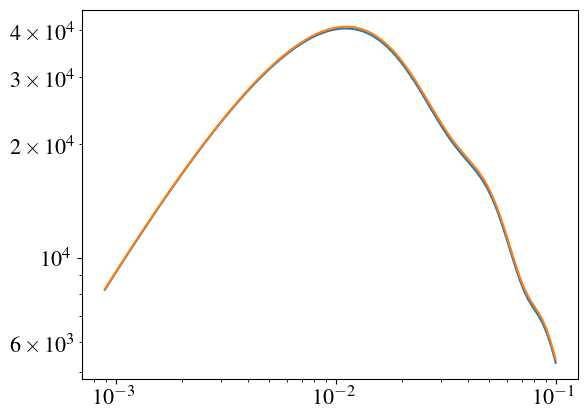

In [2150]:
plt.loglog(kL_ofz[1], Pmm_params_dict_h_lin['mnu'](0.7, kL_ofz[1]))
plt.loglog(kL_ofz[1] , Pmm_params_dict_l_lin['mnu'](0.7, kL_ofz[1]))

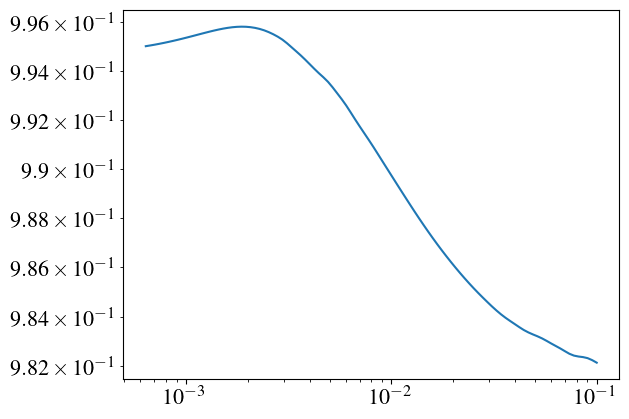

In [2314]:
i_z_here=4
zed_here = z_mean[i_z_here]
plt.loglog(kL_ofz[i_z_here], Pmm_params_dict_h_nonlin['mnu'](zed_here, kL_ofz[i_z_here])/Pmm_params_dict_l_nonlin['mnu'](zed_here, kL_ofz[i_z_here]))

In [2312]:
kL_ofz[0][0]

0.0018133518991580513

In [2313]:
kL_ofz[4][0]

0.0006371037260039857

# compute Pmm fiducial

## nonlinear

In [1904]:
#also compute fiducial; NONLINEAR

#can alter delta_matter variable
mattervar = "delta_tot"

#can alter whether to compute nonlinear or linear
nonlinearbool = True

pars_regularCAMB.set_cosmology(H0=fids_cdm['H0'], ombh2=fids_cdm['ombh2'], omch2=fids_cdm['omch2'], tau=fids_cdm['tau'], mnu=fids_cdm['mnu'], omk=fids_cdm['ok'], nnu=fids_cdm['nnu'])
pars_regularCAMB.InitPower.set_params( As=fids_cdm['As'], ns=fids_cdm['ns'], r=0)
pars_regularCAMB.set_dark_energy(w=fids_cdm['w0'], wa=0, dark_energy_model='fluid')
pars_regularCAMB.set_matter_power(redshifts=z_mean, kmax=100.)
#PKmm_lin_fid= camb.get_matter_power_interpolator(pars_regularCAMB,nonlinear=False, hubble_units=False, k_hunit=False, kmax=10.,zmax=3,var1="delta_tot",var2="delta_tot")
PKmm_fid= camb.get_matter_power_interpolator(pars_regularCAMB,nonlinear=nonlinearbool, hubble_units=False, k_hunit=False, kmax=10.,zmax=3,var1=mattervar,var2=mattervar)
results_fid = camb.get_results(pars_regularCAMB)
sigma8_fid=np.array(results_fid.get_sigma8())
fsigma8_fid=np.array(results_fid.get_fsigma8())
f_fid = fsigma8_fid/sigma8_fid


transfunc_fid = results_fid.get_matter_transfer_data()
kh_fid = transfunc_fid.transfer_data[0,:,0]
tot_trans_fid = transfunc_fid.transfer_data[model.Transfer_tot-1,:,0]
tot_trans_renorm_fid = tot_trans_fid/tot_trans_fid[0]
littleh_fid = H0fid/100
k_for_transfuncs_fid = kh_fid*(littleh_fid)
tot_trans_renorm_interp_fid = interp1d(k_for_transfuncs_fid,tot_trans_renorm_fid,kind='cubic')


Pmm_params_dict_h_nonlin['fid'] = PKmm_fid.P
Pmm_params_dict_l_nonlin['fid'] = PKmm_fid.P
f_params_dict_h_nonlin['fid'] = f_fid
f_params_dict_l_nonlin['fid'] = f_fid
trans_params_dict_h_nonlin['fid'] = tot_trans_renorm_interp_fid
trans_params_dict_l_nonlin['fid'] = tot_trans_renorm_interp_fid

Note: redshifts have been re-sorted (earliest first)


## linear

In [1905]:
# do for linear

mattervar = "delta_tot"
nonlinearbool_lin = False

pars_regularCAMB.set_cosmology(H0=fids_cdm['H0'], ombh2=fids_cdm['ombh2'], omch2=fids_cdm['omch2'], tau=fids_cdm['tau'], mnu=fids_cdm['mnu'], omk=fids_cdm['ok'], nnu=fids_cdm['nnu'])
pars_regularCAMB.InitPower.set_params( As=fids_cdm['As'], ns=fids_cdm['ns'], r=0)
pars_regularCAMB.set_dark_energy(w=fids_cdm['w0'], wa=0, dark_energy_model='fluid')
pars_regularCAMB.set_matter_power(redshifts=z_mean, kmax=100.)
#PKmm_lin_fid= camb.get_matter_power_interpolator(pars_regularCAMB,nonlinear=False, hubble_units=False, k_hunit=False, kmax=10.,zmax=3,var1="delta_tot",var2="delta_tot")
PKmm_fid_lin= camb.get_matter_power_interpolator(pars_regularCAMB,nonlinear=nonlinearbool_lin, hubble_units=False, k_hunit=False, kmax=10.,zmax=3,var1=mattervar,var2=mattervar)
results_fid = camb.get_results(pars_regularCAMB)
sigma8_fid=np.array(results_fid.get_sigma8())
fsigma8_fid=np.array(results_fid.get_fsigma8())
f_fid_lin = fsigma8_fid/sigma8_fid

transfunc_fid_lin = results_fid.get_matter_transfer_data()
kh_fid_lin = transfunc_fid_lin.transfer_data[0,:,0]
tot_trans_fid_lin = transfunc_fid_lin.transfer_data[model.Transfer_tot-1,:,0]
tot_trans_renorm_fid_lin = tot_trans_fid_lin/tot_trans_fid_lin[0]
littleh_fid_lin = H0fid/100
k_for_transfuncs_fid_lin = kh_fid_lin*(littleh_fid_lin)
tot_trans_renorm_interp_fid_lin = interp1d(k_for_transfuncs_fid_lin,tot_trans_renorm_fid_lin,kind='cubic')

Pmm_params_dict_h_lin['fid'] = PKmm_fid_lin.P
Pmm_params_dict_l_lin['fid'] = PKmm_fid_lin.P
f_params_dict_h_lin['fid'] = f_fid_lin
f_params_dict_l_lin['fid'] = f_fid_lin
trans_params_dict_h_lin['fid'] = tot_trans_renorm_interp_fid_lin
trans_params_dict_l_lin['fid'] = tot_trans_renorm_interp_fid_lin

Note: redshifts have been re-sorted (earliest first)


In [486]:
f_params_dict_h_ofz_ofk_nonlin['fid'][0.2] / f_params_dict_h_ofz_ofk_lin['fid'][0.2]

array([0.99997245, 0.99997104, 0.99997067, 0.99996937, 0.99996645,
       0.99996258, 0.99995824, 0.99995296, 0.99994611, 0.99993807,
       0.99993006, 0.99992259, 0.99991416, 0.99990311, 0.99988938,
       0.99987397, 0.99985729, 0.9998387 , 0.99981754, 0.9997943 ,
       0.99976999, 0.99974426, 0.99971468, 0.99967909, 0.99963797,
       0.99959262, 0.99954325, 0.99948871, 0.99942771, 0.99935857,
       0.99927956, 0.99918996, 0.99908995, 0.99897926, 0.99885627,
       0.99871909, 0.9985654 , 0.99839263, 0.99819869, 0.99798256,
       0.99774309, 0.99747678, 0.99717897, 0.99684577, 0.99647456,
       0.99606248, 0.99560443, 0.99509449, 0.99452703, 0.99389675,
       0.99319847, 0.99242757, 0.99157961, 0.99065087, 0.98963832,
       0.9885398 , 0.98735593, 0.98608812, 0.98474111, 0.98332207,
       0.98184004, 0.98030824, 0.97874104, 0.97715745, 0.975579  ,
       0.97402373, 0.9725035 , 0.97102939, 0.96961187, 0.96826037,
       0.96695164, 0.96561911, 0.96420311, 0.96267906, 0.96102

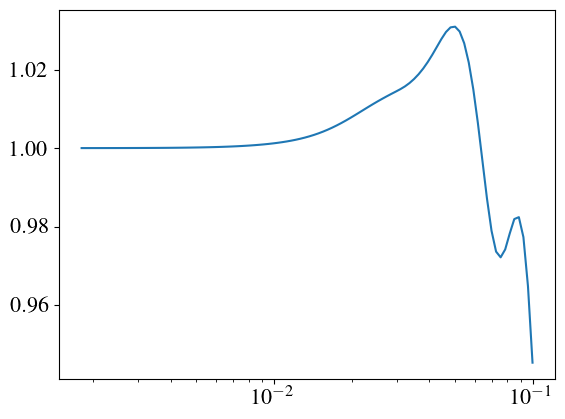

In [482]:
plt.semilogx(kL_ofz[0],  Pmm_params_dict_h_lin['fid'](0.2,kL_ofz[0] ) /  Pmm_params_dict_h_nonlin['fid'](0.2,kL_ofz[0] ) )

# function compute f(k) for varying cosmology

In [347]:
#this function computes f(k,z) = (1/2)(1+z)dln(P)/dz
#create a dense list of z values from zmin to zman
dz=0.01
zmin=z_mean[0]
zmax=z_mean[len(z_mean)-1]+dz
numzbins = int(np.ceil((zmax-zmin)/dz))+1
#generating the list requires these factors of 100 because python is dumb
factor = int(1/dz)
zs_for_f_ofz_ofk = np.linspace(factor*zmin,factor*zmax,numzbins)/factor

#zlocs just tells us which bin to use to get a z value actually in our z_mean list
#you wont need this (probably)
zlocs = {}
for zs in z_mean:
    zlocs[zs] = np.where(zs == zs_for_f_ofz_ofk)[0][0]

#function takes Pmm, a list of z values, and list of k values, and returns f[z][k]
def f_ofz_ofk(PmmdotP, zs, ks):
    numz=len(zs)
    numks=len(ks)
    fcompute={}
    for zi in range(numz-1):
        
        z = zs[zi]
        zup = zs[zi+1]
        deltaz = zup-z

        fcompute[z] = np.zeros([numks])
        
        for ki in range(numks):
            k = ks[ki]
            deriv =  (np.log(PmmdotP(zup,k)) - np.log(PmmdotP(z,k))) / deltaz
            #deriv =  (PmmdotP(zup,k) - PmmdotP(z,k)) / deltaz / PmmdotP(z,k) . ## GALIS DERIV
            fcompute[z][ki] = -(0.5)*(1+z)*deriv
    return fcompute  

In [1907]:
#create f(z,k) dictionaries for linear and non-linear matter, and for the derivativess where for example dPvv/dH0 ~ [(f(H0+deltaH0))^2 Pmm(H0+deltaH0) - (f(H0-deltaH0))^2 Pmm(H0-deltaH0)]/2deltaHo

f_params_dict_h_ofz_ofk_lin = {}
f_params_dict_l_ofz_ofk_lin = {}
f_params_dict_h_ofz_ofk_nonlin = {}
f_params_dict_l_ofz_ofk_nonlin = {}

for names in Pmm_params_dict_h_nonlin.keys():

    f_params_dict_h_ofz_ofk_lin[names] = {}
    f_params_dict_l_ofz_ofk_lin[names] = {}
    f_params_dict_h_ofz_ofk_nonlin[names] = {}
    f_params_dict_l_ofz_ofk_nonlin[names] = {}


    Ph_nonlin = Pmm_params_dict_h_nonlin[names]
    Pl_nonlin = Pmm_params_dict_l_nonlin[names]
    Ph_lin = Pmm_params_dict_h_lin[names]
    Pl_lin = Pmm_params_dict_l_lin[names]
    print(names)
    for zind in range(len(z_mean)):
        z = z_mean[zind]
        ks_here = kL_ofz[zind]
        
        fcomp_h_nonlin = f_ofz_ofk(Ph_nonlin, zs_for_f_ofz_ofk, ks_here)
        fcomp_l_nonlin = f_ofz_ofk(Pl_nonlin, zs_for_f_ofz_ofk, ks_here)
        fcomp_h_lin = f_ofz_ofk(Ph_lin, zs_for_f_ofz_ofk, ks_here)
        fcomp_l_lin = f_ofz_ofk(Pl_lin, zs_for_f_ofz_ofk, ks_here)
        
        f_params_dict_h_ofz_ofk_nonlin[names][z] = fcomp_h_nonlin[z]
        f_params_dict_l_ofz_ofk_nonlin[names][z] = fcomp_l_nonlin[z]
        f_params_dict_h_ofz_ofk_lin[names][z] = fcomp_h_lin[z]
        f_params_dict_l_ofz_ofk_lin[names][z] = fcomp_l_lin[z]

As
H0
ombh2
omch2
ns
mnu
tau
nnu
w0
wa
ok
fid


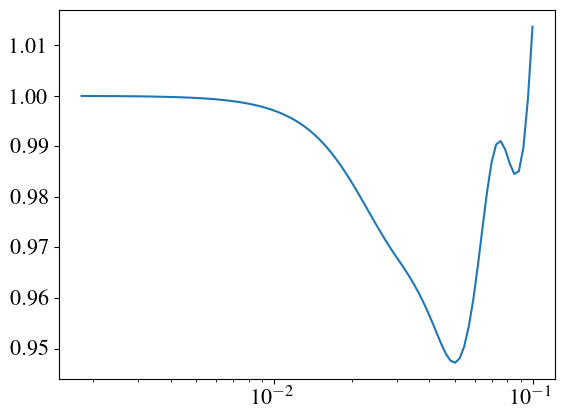

In [487]:
plt.semilogx(kL_ofz[0],  f_params_dict_h_ofz_ofk_nonlin['fid'][0.2] / f_params_dict_h_ofz_ofk_lin['fid'][0.2] )

## compute df/d(cosmo)

In [254]:
#linear
df_dcosmo_params_dict_ofz_ofk_lin = {}
#nonlinear
df_dcosmo_params_dict_ofz_ofk_nonlin = {}

for names in Pmm_params_dict_h_nonlin.keys():
    if names == 'fid':
        continue   
    df_dcosmo_params_dict_ofz_ofk_lin[names] = {}

    df_dcosmo_params_dict_ofz_ofk_nonlin[names] = {}
    for z in z_mean:
        df_dcosmo_params_dict_ofz_ofk_lin[names][z] = (f_params_dict_h_ofz_ofk_lin[names][z] - f_params_dict_l_ofz_ofk_lin[names][z])/(2.*step_cdm[names])

        df_dcosmo_params_dict_ofz_ofk_nonlin[names][z] = (f_params_dict_h_ofz_ofk_nonlin[names][z] - f_params_dict_l_ofz_ofk_nonlin[names][z])/(2.*step_cdm[names])

/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/1720679629.py:13: RuntimeWarning: invalid value encountered in divide
  df_dcosmo_params_dict_ofz_ofk_lin[names][z] = (f_params_dict_h_ofz_ofk_lin[names][z] - f_params_dict_l_ofz_ofk_lin[names][z])/(2.*step_cdm[names])
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/1720679629.py:15: RuntimeWarning: invalid value encountered in divide
  df_dcosmo_params_dict_ofz_ofk_nonlin[names][z] = (f_params_dict_h_ofz_ofk_nonlin[names][z] - f_params_dict_l_ofz_ofk_nonlin[names][z])/(2.*step_cdm[names])


# kSZ SNR figure?

In [2429]:
f_params_dict_h_nonlin['fid']

array([0.97623642, 0.95498786, 0.91407588, 0.8169768 , 0.63577802])

In [2431]:
f_params_dict_h_nonlin['fid'][zdict_fs_dPij[zplot]]

0.8169767982187617

In [2430]:
zdict_fs_dPij

{2.6: 0, 1.9: 1, 1.3: 2, 0.7: 3, 0.2: 4}

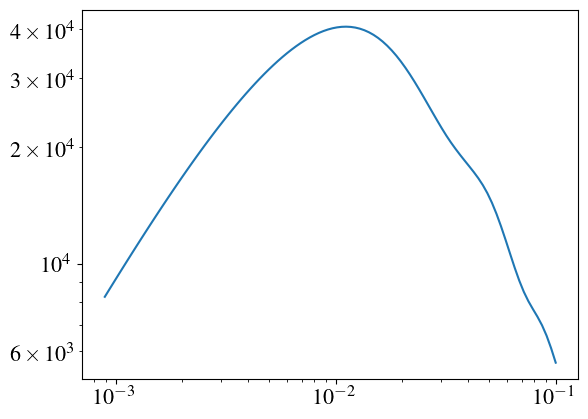

In [2432]:
ziplot=1
zplot = z_mean[ziplot]

aplot = 1/(1+zplot)
Hplot = HofzedfidLCDM(zplot)
fplot = f_params_dict_h_nonlin['fid'][zdict_fs_dPij[zplot]]
faHplot = fplot*aplot*Hplot
faHkplot = faHplot/kL_ofz[ziplot]

plt.loglog(kL_ofz[ziplot], Pmm_params_dict_h_nonlin['fid'](zplot, kL_ofz[ziplot] ))

In [2443]:
np.shape(Ng_ofz[ziplot])

(102, 100, 3)

In [2445]:
sigz_LSST

{0.2: 0.036, 0.7: 0.051, 1.3: 0.06899999999999999, 1.9: 0.087, 2.6: 0.108}

(1.0, 1000000.0)

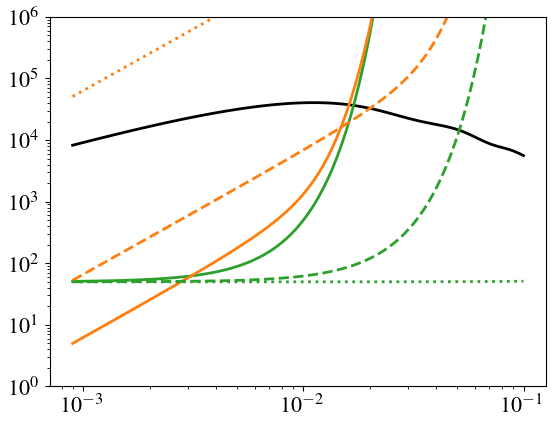

In [2463]:
mui =0
mumu=mulist[mui]**2

plt.loglog(kL_ofz[ziplot], Pmm_params_dict_h_nonlin['fid'](zplot, kL_ofz[ziplot] ), c='k',lw=2.)
plt.loglog(kL_ofz[ziplot] , Ng_ofz[ziplot][mui][:,2]/(Wphotofunc(kL_ofz[ziplot],mumu**0.5,zplot,sigz_LSST[zplot]))**2, c='tab:green', lw=2)
plt.loglog(kL_ofz[ziplot],  (1/mumu)*(1/faHkplot**2)*NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[ziplot][mui][:,2], c='tab:orange', lw=2)

mui =35
mumu=mulist[mui]**2

plt.loglog(kL_ofz[ziplot] , Ng_ofz[ziplot][mui][:,2]/(Wphotofunc(kL_ofz[ziplot],mumu**0.5,zplot,sigz_LSST[zplot]))**2, c='tab:green', lw=2, ls='dashed')
plt.loglog(kL_ofz[ziplot],  (1/mumu)*(1/faHkplot**2)*NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[ziplot][mui][:,2], c='tab:orange', lw=2, ls='dashed')

mui =51
mumu=mulist[mui]**2

plt.loglog(kL_ofz[ziplot] , Ng_ofz[ziplot][mui][:,2]/(Wphotofunc(kL_ofz[ziplot],mumu**0.5,zplot,sigz_LSST[zplot]))**2, c='tab:green', lw=2, ls='dotted')
plt.loglog(kL_ofz[ziplot],  (1/mumu)*(1/faHkplot**2)*NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[ziplot][mui][:,2], c='tab:orange', lw=2, ls='dotted')

plt.ylim(1e0,1e6)


In [2435]:
NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[ziplot][0][:,2]

array([1.63325285e-01, 1.63381008e-01, 1.63442393e-01, 1.63510026e-01,
       1.63584553e-01, 1.63666692e-01, 1.63757238e-01, 1.63857073e-01,
       1.63967175e-01, 1.64088632e-01, 1.64222650e-01, 1.64370577e-01,
       1.64533911e-01, 1.64714324e-01, 1.64913684e-01, 1.65134081e-01,
       1.65377856e-01, 1.65647638e-01, 1.65946381e-01, 1.66277414e-01,
       1.66644494e-01, 1.67051874e-01, 1.67504378e-01, 1.68007493e-01,
       1.68567478e-01, 1.69191494e-01, 1.69887763e-01, 1.70665756e-01,
       1.71536426e-01, 1.72512490e-01, 1.73608781e-01, 1.74842671e-01,
       1.76234614e-01, 1.77808815e-01, 1.79594075e-01, 1.81624868e-01,
       1.83942716e-01, 1.86597966e-01, 1.89652089e-01, 1.93180714e-01,
       1.97277622e-01, 2.02060103e-01, 2.07676179e-01, 2.14314468e-01,
       2.22217814e-01, 2.31702353e-01, 2.43184533e-01, 2.57219982e-01,
       2.74560224e-01, 2.96236842e-01, 3.23688479e-01, 3.58956063e-01,
       4.04988749e-01, 4.66133454e-01, 5.48935623e-01, 6.63480505e-01,
      

# linear b1(z) fit

[1.05, 1.37, 1.79, 2.22, 2.74]


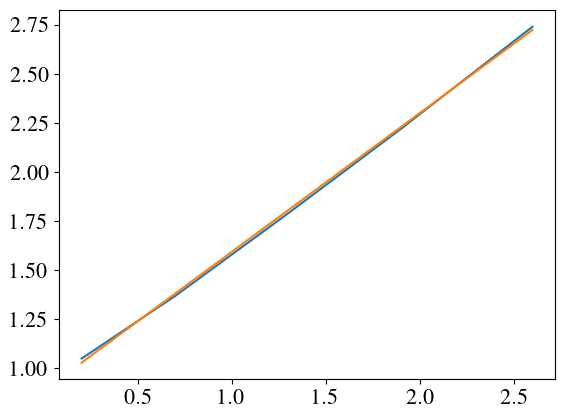

In [37]:
## linear b(z) fit
bs_for_fit = []
for key in b.keys():
    bs_for_fit.append(b[key])


print(bs_for_fit)
z_mean_arr = np.array(z_mean)

m_fid, q_fid = np.polyfit(z_mean,bs_for_fit,1)

plt.plot(z_mean, bs_for_fit)
plt.plot(z_mean, m_fid * z_mean_arr + q_fid)

# Pgg fisher

In [3084]:
%%time
# the fisher calculation (for a given redshift box) can then look like what's below:

nonlin_flag = True

fofkflag = False

lin_b1_flag = False

#b2_Rstar_flag = True

#f_derivative_flag = True

#redshfit bin  fishers
Fisher_each_Pgg_summnu = {}

zs_for_fisher = z_mean

#invs_each will store the value of, I - C*C^{-1} (where I is identity matrix) to test how good our matrix inversion is doing
invs_each={}
#deltaT_bins = np.array([11])  ## WE DONT CHANGE PGG WHEN CHANGING CMB EXPERIMENT -- ONLY KSZ CHANGES
#for deltaTbin in deltaT_bins:
#for deltaTbin in few_DeltaTbins:
#for z in zs_for_fisher:
for z in z_mean:
    #print(z)
    #get the index assocation with z value
    zind = zposition[z]

    #pick the set of params to use for fisher analysis

    #paramlist=[ 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' ]
    #paramlist=[ 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
    #paramlist=['b1'  , 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau'  ]
    #paramlist=['b1' , 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu']
    #paramlist=[ 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
    #paramlist = ['b1'  , 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
    #paramlist = ['m'  , 'q', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau'  ]
    #paramlist = ['m'  , 'q', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
    #paramlist = ['m'  , 'q', 'brsd', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
    #paramlist = ['m'  , 'q', 'brsd', 'bk2', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu']
    #paramlist = ['m'  , 'q', 'brsd', 'bk2', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu', 'nnu', 'ok', 'w0' ]

    #paramlist = ['b1'  , 'bk2', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
    paramlist = ['b1'  , 'brsd', 'bk2', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]

    #paramlist = ['b1'  , 'brsd', 'bk2', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu', 'nnu', 'ok', 'w0']
   

    force_df_zero_params = []
    #need number of params
    num_params = len(paramlist)
    #param_combs is a list of combinations of pairs of params
    param_combs = itertools.combinations_with_replacement(paramlist,2)

    #initialize fisher each z value to zeros
    Fisher = np.zeros((num_params,num_params))

    #for each z value, we store a matrix, I - C*C^{-1}, for all values of mu and kL, to test how good matrix inversion is
    #need number of signals, ideally we'd do this dynamically based on shape of the Cov matrix
    numsignals=1
    invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])
    integral_zbinned = np.zeros([nummu,numkL])

    #get the kL list for this z value
    kLlist = kL_ofz[zind]
    
    #need sigma_z, galaxy bias, and galaxy density
    #sigzhere = sigz_LSST[z]
    #nghere = ngal[z]
    
    #need the fiducial values for paramters in our forecast
    bv_fid = 1.
    brsd_fid = 1. #0. #1.

    Rstar_fid = 1. #2.66*(littlehfid**-1)

    Om0input = Om0fid 
    H0input = H0invMPc_fid
    bk2_fid = 0.
    bk4_fid = 0.
    m_value= m_fid
    q_value = q_fid
    if lin_b1_flag is True:
        b1_ofz_fid = m_value*z + q_value 
    else:
        b1_ofz_fid = b[z]


    if nonlin_flag is True:
        Pmm_touse = Pmm_params_dict_h_nonlin['fid']
    else:
        Pmm_touse = Pmm_params_dict_h_lin['fid']
    


    if fofkflag is True:
        if nonlin_flag is True:
            f_ofk_list = f_params_dict_h_ofz_ofk_nonlin['fid'][z]
        else:
            f_ofk_list = f_params_dict_h_ofz_ofk_lin['fid'][z]
    else:
        if nonlin_flag is True:
            f_ofk_list = f_params_dict_h_nonlin['fid'][zdict_fs_dPij[z]]
        else:
            f_ofk_list = f_params_dict_h_lin['fid'][zdict_fs_dPij[z]]

    
    #get noise values for this redshift, which are diagonal 
    #useful for artificially increasing noise
    #aritificialnoise=1e5

    #these are noises that vary depending on the deltaT value
    #N_parallel = Nparallel_ofz_ofDeltaT[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
    #N_parallel = Nparallel_ofz_ofDeltaT_nomusq[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
    #these  noises only vary for z
    N_0 = N0_ofz[zind]
    N_g = Ng_ofz[zind]
    #N_h = NgWsq_ofz[zind]

    #get 0 signal
    S_00 = S00_ofz[zind]
    
    #compute all S_{ij}
     
    S_gg = get_Pgg(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input,H0input, bk2_fid, bk4_fid); 
    #S_gg = get_Pgg_noW(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input,H0input, bk2_fid, bk4_fid); 

    #compute the C_{ij} = S_{ij} + N_{ij} which includes both perpendicular directions, where the ML signal is set to be in the x direction, and 0 signal in y direction
    #C_vv  = S_vv + N_parallel;   C_vh  = S_vh + N_0;
    #C_hv  = C_vh;                C_hh  = S_hh + N_h; 
    C_gg  = S_gg + N_g; 

    #combine into single matrix    
    Cov_matrix=np.array([[C_gg]])

    #compute derivatives
    dSij_dparams = dPij_dparams(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid, bv_fid, lin_b1_flag, m_fid, q_fid)
    #dSij_dparams = dPij_dparams_noW(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid, bv_fid, lin_b1_flag, m_fid, q_fid)
    

    dSgg_dbv = dSij_dparams['Pgg']['bv'];  dSgg_db1 = dSij_dparams['Pgg']['b1'];  dSgg_dbrsd = dSij_dparams['Pgg']['brsd'];  dSgg_dbk2 = dSij_dparams['Pgg']['bk2']; dSgg_dbk4 = dSij_dparams['Pgg']['bk4']; 
    
    if lin_b1_flag is True:
        dSgg_dm = dSij_dparams['Pgg']['m']
        dSgg_dq = dSij_dparams['Pgg']['q']
    #numerical derivs
    dSgg_dAs = dPgg_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
    dSgg_dH0 = dPgg_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
    dSgg_dombh2 = dPgg_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
    dSgg_domch2 = dPgg_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
    dSgg_dns = dPgg_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
    dSgg_dtau = dPgg_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
    dSgg_dmnu = dPgg_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
    dSgg_dnnu = dPgg_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
    dSgg_dok = dPgg_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
    dSgg_dw0 = dPgg_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)

    #dSgg_dAs = dPgg_dparam_num_noW('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
    #dSgg_dH0 = dPgg_dparam_num_noW('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
    #dSgg_dombh2 = dPgg_dparam_num_noW('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
    #dSgg_domch2 = dPgg_dparam_num_noW('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
    #dSgg_dns = dPgg_dparam_num_noW('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
    #dSgg_dtau = dPgg_dparam_num_noW('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
    #dSgg_dmnu = dPgg_dparam_num_noW('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
    #dSgg_dnnu = dPgg_dparam_num_noW('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
    #dSgg_dok = dPgg_dparam_num_noW('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
    #dSgg_dw0 = dPgg_dparam_num_noW('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)

    

    #build array of dSij/d(paramter)
    #for convenience, i have a bunch of predefined combos, which I just comment out and use only the one I need
    #this set is for vpvp, vpg, and gg


    #dSgg_param = np.array([dSgg_db1 ,  dSgg_dbk2 , dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
    dSgg_param = np.array([dSgg_db1 , dSgg_dbrsd , dSgg_dbk2 , dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
    #dSgg_param = np.array([dSgg_db1 , dSgg_dbrsd , dSgg_dbk2 , dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu, dSgg_dnnu, dSgg_dok, dSgg_dw0])

    #dSgg_param = np.array([dSgg_dm , dSgg_dq, dSgg_dbk2,  dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])

    #dSgg_param = np.array([dSgg_dm , dSgg_dq, dSgg_dbrsd, dSgg_dbk2,  dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
    #dSgg_param = np.array([dSgg_dm , dSgg_dq, dSgg_dbrsd, dSgg_dbk2,  dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu, dSgg_dnnu, dSgg_dok, dSgg_dw0])



    

    #begin fisher computation
    #loop over parameters    
    for param1,param2 in param_combs:
        i = paramlist.index(param1)
        j = paramlist.index(param2)

        #start by setting the integral value to 0
        integral = 0. # will do a Reimann sum :)
        
        #build dS/d(paramter) matrices
        
        dS_dpia=np.array([[dSgg_param[i]]])


        dS_dpib=np.array([[dSgg_param[j]]])
        
        
        
        #loop over mu and kL to do the integral
        #note the way i am setting the muindex stuff, we are excluding the first and last mu values, +1 and -1, because they give infinities
        for muind in range(len(mulist)):
            mu = mulist[muind]
            #dmu = mulist[muind+1] - mu
            
            for kLind in range(len(kLlist)):
                kL = kLlist[kLind]
                #dkL = kLlist[kLind+1] - kL
                
                #get the two derivative matrices, which are 4x4 matrices which are dS_{ij}/dpi
                dSa= dS_dpia[::,::,muind,kLind,2]
                dSb= dS_dpib[::,::,muind,kLind,2]
                
                #compute the inverse of the covariance matric
                Cinv=np.linalg.inv(Cov_matrix[:,:,muind,kLind,2])

                #compute the trace that goes in the fisher integral
                trace=np.trace(np.dot(np.dot(dSa,Cinv),np.dot(dSb,Cinv)))

                #now compute CC^{-1} and compare it to indentity matrix. I-CC^{-1} should have very small entries
                CCinv=np.dot(Cov_matrix[:,:,muind,kLind,2],Cinv)
                invs_each[z][muind,kLind]=np.eye(numsignals)-CCinv
            
                #other terms that are not the trace
                #pref = (vol[z]/2.) * ((kL**2.)*dkL/((2.*np.pi)**2.)) * dmu
                #integral += pref*trace

                integrand_pref = (vol[z]/2.) * ((kL**2.)/((2.*np.pi)**2.))
                integral_zbinned[muind,kLind] = integrand_pref*trace

        fishint_simp = integrate.simps( integrate.simps(integral_zbinned,mulist,axis=0), kLlist)
        
        Fisher[i,j] = fishint_simp#integral #fishint_simp
        if j!=i: Fisher[j,i] =fishint_simp #integral#fishint_simp
    


    
    #Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,['brsd_'+str(z) , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
    #Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,[ 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau'])
    #Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,[ 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
    #Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau'])
    #Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,['b1' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau'])
    #Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
    

    #Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2', 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
    #Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'bk2_'+str(z) , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
    Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z) , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])


    #Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,['m', 'q', 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau'])
    #Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,['m', 'q', 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])

    #Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,['m', 'q', 'brsd'+str(z), 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
    #Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,['m', 'q', 'brsd', 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
    #Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,['m', 'q', 'bk2' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])

    #Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,['m', 'q', 'brsd', 'bk2' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
    #Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,['m', 'q', 'brsd'+str(z), 'bk2'+str(z) , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
    
    #Fisher_each_Pgg_summnu[z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z) , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu', 'nnu', 'ok', 'w0'])

    

    
    #print(Fisher_each_Pgg_summnu[Delta_fid,z].sigmas())
    

            


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


CPU times: user 20.5 s, sys: 36.7 ms, total: 20.5 s
Wall time: 20.6 s


In [3085]:
Fisher_each_Pgg_summnu_sumz = {}
Fisher_each_Pgg_summnu_sumz = Fisher_each_Pgg_summnu[0.2] + Fisher_each_Pgg_summnu[0.7] + Fisher_each_Pgg_summnu[1.3] + Fisher_each_Pgg_summnu[1.9] + Fisher_each_Pgg_summnu[2.6]

In [3086]:
Fisher_each_Pgg_summnu_sumz.sigmas()['mnu']

0.36070640807722565

In [2506]:
F_gg_dict.keys()

dict_keys(['b_ofz_nonlin', 'b_ofz_lin', 'mq_lin', 'mq_nonlin', 'b_ofz_nonlin_LCDMextend', 'b_ofz_nonlin_nophotoz'])

In [3087]:
F_gg_dict['b_ofz_nonlin_fz'] = Fisher_each_Pgg_summnu_sumz

In [2524]:
F_gg_dict['b_ofz_nonlin_nophotoz'].sigmas()['mnu']

0.17056401581617167

In [1910]:
# create a F_{gg} dict
#F_gg_dict = {}
F_gg_dict['b_ofz_nonlin_LCDMextend'] = Fisher_each_Pgg_summnu_sumz

In [1916]:
F_gg_dict['b_ofz_nonlin_LCDMextend'].sigmas()

{'As': 4.141465479755775e-09,
 'H0': 29.830491202743527,
 'b1_0.2': 0.24825527664773983,
 'b1_0.7': 0.31352533994260906,
 'b1_1.3': 0.6361543264268416,
 'b1_1.9': 1.0501085261241456,
 'b1_2.6': 1.5597224842348911,
 'bk2_0.2': 3.1704817587531986,
 'bk2_0.7': 2.5921501970784866,
 'bk2_1.3': 4.4852782755017255,
 'bk2_1.9': 6.026950089606028,
 'bk2_2.6': 7.223727958989944,
 'brsd_0.2': 0.7999135126153387,
 'brsd_0.7': 0.7943114262378841,
 'brsd_1.3': 0.5179783337268726,
 'brsd_1.9': 0.31335303979539975,
 'brsd_2.6': 0.27519451234293857,
 'mnu': 0.41995783070187176,
 'nnu': 1.9302891343775848,
 'ns': 0.10861335903410964,
 'ok': 0.7470982894162085,
 'ombh2': 0.005263882027971971,
 'omch2': 0.01026979043830938,
 'tau': 98.45109424441432,
 'w0': 1.8092780248288787}

In [747]:
#for my bias model
## w/o brsd, 294 lin vs 298 nonlin
## with brsd, 304 lin vs 312 nonlin

In [1126]:
Fisher_each_Pgg_summnu_sumz.sigmas()

{'m': 99605.70585168351,
 'q': 125264.46688946843,
 'brsd': 141077.48785634237,
 'bk2': 1.336353612239238,
 'As': 0.0006207409465852208,
 'H0': 4.440866853469633,
 'ombh2': 0.0004443456939526505,
 'omch2': 0.002024108850025509,
 'ns': 0.02217520137056056,
 'tau': 81.54865762965221,
 'mnu': 0.17017015936719204}

In [725]:
Fisher_each_Pgg_summnu_sumz.sigmas()

{'As': 5.879681272539722e-10,
 'H0': 5.8644157689616945,
 'b1_0.2': 0.03402623873567151,
 'b1_0.7': 0.050905804296353566,
 'b1_1.3': 0.07725518775450135,
 'b1_1.9': 0.10364394390676594,
 'b1_2.6': 0.13546945003720195,
 'bk2_0.2': 2.2364764026193935,
 'bk2_0.7': 1.877511041252395,
 'bk2_1.3': 2.558763016170834,
 'bk2_1.9': 3.4363961889246433,
 'bk2_2.6': 4.672628402010503,
 'mnu': 0.2939537512758677,
 'ns': 0.04080122260392151,
 'ombh2': 0.00044930789971692116,
 'omch2': 0.0020462377506968612,
 'tau': 99.65300969816487}

In [698]:
Fisher_each_Pgg_summnu_sumz_tauprior = Fisher_each_Pgg_summnu_sumz.copy()
Fisher_each_Pgg_summnu_sumz_tauprior.add_prior('tau',1)

Fisher_each_Pgg_summnu_sumz_Asprior = Fisher_each_Pgg_summnu_sumz.copy()
Fisher_each_Pgg_summnu_sumz_Asprior.add_prior('As',1e-8)


Fisher_each_Pgg_summnu_sumz_Asprior.sigmas()

{'As': 1.0000000000823235e-08,
 'H0': 438.78477654025244,
 'b1_0.2': 3.403745931991428,
 'b1_0.7': 3.5085015734500162,
 'b1_1.3': 4.197643267169504,
 'b1_1.9': 5.098090464083625,
 'b1_2.6': 6.252807582114315,
 'bk2_0.2': 2.3498437808214145,
 'bk2_0.7': 1.9784278715136197,
 'bk2_1.3': 2.6839967441019317,
 'bk2_1.9': 3.5745807168328403,
 'bk2_2.6': 4.81912172494454,
 'brsd_0.2': 8.488400485875307,
 'brsd_0.7': 4.930664726711756,
 'brsd_1.3': 3.127495132816534,
 'brsd_1.9': 2.5566227059199678,
 'brsd_2.6': 2.365629499180086,
 'mnu': 0.30381610443435686,
 'ns': 0.04226412755773844,
 'ombh2': 0.0004502866705292737,
 'omch2': 0.002055033597500063,
 'tau': 102.88415877047503}

In [661]:
Fisher_each_Pgg_summnu_sumz.sigmas()

{'m': 99605.70577904176,
 'q': 125264.46679931272,
 'brsd': 141077.48775499268,
 'bk2': 1.3625261845464485,
 'As': 0.0006207409461252474,
 'H0': 4.670258808625096,
 'ombh2': 0.00044462922837446256,
 'omch2': 0.0020307097309447287,
 'ns': 0.022272727451627387,
 'tau': 106.32290353889593,
 'mnu': 0.17088111757219135}

In [662]:
Fisher_each_Pgg_summnu_sumz_tauprior = Fisher_each_Pgg_summnu_sumz.copy()
Fisher_each_Pgg_summnu_sumz_tauprior.add_prior('tau',1)
Fisher_each_Pgg_summnu_sumz_tauprior.sigmas()

/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


{'m': 99605.70577813734,
 'q': 125264.46679835631,
 'brsd': 141077.4877538902,
 'bk2': 1.3151316233564827,
 'As': 0.0006207409461182833,
 'H0': 3.323885033784304,
 'ombh2': 0.00044099480636995876,
 'omch2': 0.002007834905853262,
 'ns': 0.021949592169577082,
 'tau': 0.99995577299443,
 'mnu': 0.1699157010809293}

# Pgg+kSZ fisher

In [3418]:
%%time
# the fisher calculation (for a given redshift box) can then look like what's below:

nonlin_flag = True

fofkflag = True

lin_b1_flag = False

#b2_Rstar_flag = True

#f_derivative_flag = False

#redshfit bin  fishers
Fisher_each_Pgggvvv_summnu = {}

zs_for_fisher = z_mean

#invs_each will store the value of, I - C*C^{-1} (where I is identity matrix) to test how good our matrix inversion is doing
invs_each={}
deltaT_bins = np.array([11])  
for deltaTbin in deltaT_bins:
    for z in z_mean:
        #print(z)
        #get the index assocation with z value
        zind = zposition[z]

        #pick the set of params to use for fisher analysis

        #paramlist = ['b1'  , 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        paramlist = ['b1'  , 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        #paramlist = ['b1'  , 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu', 'nnu', 'ok', 'w0' ]

        #paramlist = ['m'  , 'q', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        #paramlist = ['m'  , 'q', 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        
        #paramlist = ['As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]

        force_df_zero_params = []

        #need number of params
        num_params = len(paramlist)
        #param_combs is a list of combinations of pairs of params
        param_combs = itertools.combinations_with_replacement(paramlist,2)

        #initialize fisher each z value to zeros
        Fisher = np.zeros((num_params,num_params))

        #for each z value, we store a matrix, I - C*C^{-1}, for all values of mu and kL, to test how good matrix inversion is
        #need number of signals, ideally we'd do this dynamically based on shape of the Cov matrix
        numsignals=2
        invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])

        #get the kL list for this z value
        kLlist = kL_ofz[zind]
        
        #need sigma_z, galaxy bias, and galaxy density
        #sigzhere = sigz_LSST[z]
        #nghere = ngal[z]
        
        #need the fiducial values for paramters in our forecast
        bv_fid = 1.
        brsd_fid = 1. #0. #1.

        Rstar_fid = 1. #2.66*(littlehfid**-1)

        
        Om0input = Om0fid 
        H0input = H0invMPc_fid
        bk2_fid = 0.
        bk4_fid = 0.
        m_value= m_fid
        q_value = q_fid

        if lin_b1_flag is True:
            b1_ofz_fid = m_value*z + q_value 
        else:
            b1_ofz_fid = b[z]

        if nonlin_flag is True:
            Pmm_touse = Pmm_params_dict_h_nonlin['fid']
        else:
            Pmm_touse = Pmm_params_dict_h_lin['fid']
        

        if fofkflag is True:
            if nonlin_flag is True:
                f_ofk_list = f_params_dict_h_ofz_ofk_nonlin['fid'][z]
            else:
                f_ofk_list = f_params_dict_h_ofz_ofk_lin['fid'][z]
        else:
            if nonlin_flag is True:
                f_ofk_list = f_params_dict_h_nonlin['fid'][zdict_fs_dPij[z]]
            else:
                f_ofk_list = f_params_dict_h_lin['fid'][zdict_fs_dPij[z]]

        
        #get noise values for this redshift, which are diagonal 
        #useful for artificially increasing noise
        #aritificialnoise=1e5

        #these are noises that vary depending on the deltaT value
        #N_parallel = Nparallel_ofz_ofDeltaT[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
        #N_parallel = Nparallel_ofz_ofDeltaT_nomusq[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
        #these  noises only vary for z
        N_0 = N0_ofz[zind]
        N_g = Ng_ofz[zind]
        #N_h = NgWsq_ofz[zind]
        N_parallel = NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind] #NparallelkSZ_ofz_new_hmvec_lmax15000_nophotoz_nomusq[zind] #NparallelkSZ_ofz_new_hmvec_lmax6500_nophotoz_nomusq[zind] #NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind] #Nvv_lmax3000_nomusq[zind] ##GALI_Nvv_ofz_nomusq[zind]  #NparallelkSZ_ofz_new_hmvec_lmax6500_ksmax_5_nomusq[zind] #NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind]  #NparallelkSZ_ofz_new_hmvec_lmax15000_nomusq_HD[zind] 

        #get 0 signal
        S_00 = S00_ofz[zind]

        #compute all S_{ij}
        S_vrvr = get_Pvrvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, bv_fid)
        S_vrg = get_Pgvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input, H0input, bk2_fid, bk4_fid, bv_fid)
        S_gg = get_Pgg(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid); 
        
        #S_vrvr = get_Pvrvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, bv_fid)
        #S_vrg = get_Pgvr_noW(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input, H0input, bk2_fid, bk4_fid, bv_fid)
        #S_gg = get_Pgg_noW(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid); 
        
        #compute the C_{ij} = S_{ij} + N_{ij} which includes both perpendicular directions, where the ML signal is set to be in the x direction, and 0 signal in y direction
        #C_vv  = S_vv + N_parallel;   C_vh  = S_vh + N_0;
        #C_hv  = C_vh;                C_hh  = S_hh + N_h; 
        C_vrvr  = S_vrvr + N_parallel;  C_vrg = S_vrg + N_0; 
        C_gvr = C_vrg;                  C_gg  = S_gg + N_g;

        #combine into single matrix    
        Cov_matrix=np.array([[C_vrvr, C_vrg],
                             [C_gvr,   C_gg]])
        numsignals = np.shape(Cov_matrix)[0]
        invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])

        #compute derivatives
        dSij_dparams = dPij_dparams(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid, bv_fid, lin_b1_flag, m_fid, q_fid)
        #dSij_dparams = dPij_dparams_noW(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid, bv_fid, lin_b1_flag, m_fid, q_fid)
        

        dSgg_dbv = dSij_dparams['Pgg']['bv'];      dSgg_db1 = dSij_dparams['Pgg']['b1'];      dSgg_dbrsd = dSij_dparams['Pgg']['brsd'];         dSgg_dbk2 = dSij_dparams['Pgg']['bk2'];         dSgg_dbk4 = dSij_dparams['Pgg']['bk4']; 
        dSgvr_dbv = dSij_dparams['Pgvr']['bv'];    dSgvr_db1 = dSij_dparams['Pgvr']['b1'];    dSgvr_dbrsd = dSij_dparams['Pgvr']['brsd'];       dSgvr_dbk2 = dSij_dparams['Pgvr']['bk2'];       dSgvr_dbk4 = dSij_dparams['Pgvr']['bk4'];
        dSvrvr_dbv = dSij_dparams['Pvrvr']['bv'];  dSvrvr_db1 = dSij_dparams['Pvrvr']['b1'];  dSvrvr_dbrsd = dSij_dparams['Pvrvr']['brsd'];     dSvrvr_dbk2 = dSij_dparams['Pvrvr']['bk2'];     dSvrvr_dbk4 = dSij_dparams['Pvrvr']['bk4'];
            

        if lin_b1_flag is True:
            dSgg_dm = dSij_dparams['Pgg']['m']
            dSgg_dq = dSij_dparams['Pgg']['q']
            dSvrg_dm = dSij_dparams['Pgvr']['m']
            dSvrg_dq = dSij_dparams['Pgvr']['q']
            dSvrvr_dm = dSij_dparams['Pvrvr']['m']
            dSvrvr_dq = dSij_dparams['Pvrvr']['q']
            
        #numerical derivs
        dSgg_dAs = dPgg_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dH0 = dPgg_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dombh2 = dPgg_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_domch2 = dPgg_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dns = dPgg_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dtau = dPgg_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dmnu = dPgg_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dnnu = dPgg_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dok = dPgg_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dw0 = dPgg_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)

        dSvrg_dAs = dPvrg_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dH0 = dPvrg_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dombh2 = dPvrg_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_domch2 = dPvrg_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dns = dPvrg_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dtau = dPvrg_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dmnu = dPvrg_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dnnu = dPvrg_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dok = dPvrg_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dw0 = dPvrg_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)


        dSvrvr_dAs = dPvrvr_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dH0 = dPvrvr_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dombh2 = dPvrvr_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_domch2 = dPvrvr_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dns = dPvrvr_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dtau = dPvrvr_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dmnu = dPvrvr_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dnnu = dPvrvr_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dok = dPvrvr_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dw0 = dPvrvr_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)


        #dSgg_dAs = dPgg_dparam_num_noW('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
        #dSgg_dH0 = dPgg_dparam_num_noW('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
        #dSgg_dombh2 = dPgg_dparam_num_noW('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
        #dSgg_domch2 = dPgg_dparam_num_noW('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
        #dSgg_dns = dPgg_dparam_num_noW('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
        #dSgg_dtau = dPgg_dparam_num_noW('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
        #dSgg_dmnu = dPgg_dparam_num_noW('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
        #dSgg_dnnu = dPgg_dparam_num_noW('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
        #dSgg_dok = dPgg_dparam_num_noW('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
        #dSgg_dw0 = dPgg_dparam_num_noW('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)

        #dSvrg_dAs = dPvrg_dparam_num_noW('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid)
        #dSvrg_dH0 = dPvrg_dparam_num_noW('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid)
        #dSvrg_dombh2 = dPvrg_dparam_num_noW('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid)
        #dSvrg_domch2 = dPvrg_dparam_num_noW('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid)
        #dSvrg_dns = dPvrg_dparam_num_noW('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid)
        #dSvrg_dtau = dPvrg_dparam_num_noW('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid)
        #dSvrg_dmnu = dPvrg_dparam_num_noW('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid)
        #dSvrg_dnnu = dPvrg_dparam_num_noW('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid)
        #dSvrg_dok = dPvrg_dparam_num_noW('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid)
        #dSvrg_dw0 = dPvrg_dparam_num_noW('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid)


        #dSvrvr_dAs = dPvrvr_dparam_num_noW('As', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid)
        #dSvrvr_dH0 = dPvrvr_dparam_num_noW('H0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid)
        #dSvrvr_dombh2 = dPvrvr_dparam_num_noW('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid)
        #dSvrvr_domch2 = dPvrvr_dparam_num_noW('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid)
        #dSvrvr_dns = dPvrvr_dparam_num_noW('ns', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid)
        #dSvrvr_dtau = dPvrvr_dparam_num_noW('tau', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid)
        #dSvrvr_dmnu = dPvrvr_dparam_num_noW('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid)
        #dSvrvr_dnnu = dPvrvr_dparam_num_noW('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid)
        #dSvrvr_dok = dPvrvr_dparam_num_noW('ok', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid)
        #dSvrvr_dw0 = dPvrvr_dparam_num_noW('w0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid)

        

        #build array of dSij/d(paramter)
        #for convenience, i have a bunch of predefined combos, which I just comment out and use only the one I need
        #this set is for vpvp, vpg, and gg

        #dSgg_param = np.array([dSgg_db1,       dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSgvr_db1,     dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_db1,   dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        dSgg_param = np.array([dSgg_db1,     dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        dSvrvr_param = np.array([dSvrvr_db1, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_db1,     dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu, dSgg_dnnu, dSgg_dok, dSgg_dw0])
        #dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu, dSvrg_dnnu, dSvrg_dok, dSvrg_dw0])
        #dSvrvr_param = np.array([dSvrvr_db1, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu, dSvrvr_dnnu, dSvrvr_dok, dSvrvr_dw0])

        #dSgg_param = np.array([dSgg_dm ,     dSgg_dq ,      dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dm ,   dSvrg_dq,      dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dm , dSvrvr_dq,    dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])
        
        #dSgg_param = np.array([dSgg_dm ,     dSgg_dq ,  dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dm ,   dSvrg_dq,  dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dm , dSvrvr_dq, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])


        

        #begin fisher computation
        #loop over parameters    
        for param1,param2 in param_combs:
            i = paramlist.index(param1)
            j = paramlist.index(param2)

            #start by setting the integral value to 0
            integral = 0. # will do a Reimann sum :)
            
            #build dS/d(paramter) matrices
            
            dS_dpia=np.array([[dSvrvr_param[i], dSvrg_param[i]],
                              [dSvrg_param[i],  dSgg_param[i]]])

            dS_dpib=np.array([[dSvrvr_param[j], dSvrg_param[j]],
                              [dSvrg_param[j],  dSgg_param[j]]])
            
            
            
            #loop over mu and kL to do the integral
            #note the way i am setting the muindex stuff, we are excluding the first and last mu values, +1 and -1, because they give infinities
            for muind in range(len(mulist)):
                mu = mulist[muind]
                #dmu = mulist[muind+1] - mu
                
                for kLind in range(len(kLlist)):
                    kL = kLlist[kLind]
                    #dkL = kLlist[kLind+1] - kL
                    
                    #get the two derivative matrices, which are 4x4 matrices which are dS_{ij}/dpi
                    dSa= dS_dpia[::,::,muind,kLind,2]
                    dSb= dS_dpib[::,::,muind,kLind,2]
                    
                    #compute the inverse of the covariance matric
                    Cinv=np.linalg.inv(Cov_matrix[:,:,muind,kLind,2])

                    #compute the trace that goes in the fisher integral
                    trace=np.trace(np.dot(np.dot(dSa,Cinv),np.dot(dSb,Cinv)))

                    #now compute CC^{-1} and compare it to indentity matrix. I-CC^{-1} should have very small entries
                    CCinv=np.dot(Cov_matrix[:,:,muind,kLind,2],Cinv)
                    invs_each[z][muind,kLind]=np.eye(numsignals)-CCinv
                
                    #other terms that are not the trace
                    #pref = (vol[z]/2.) * ((kL**2.)*dkL/((2.*np.pi)**2.)) * dmu
                    #integral += pref*trace

                    integrand_pref = (vol[z]/2.) * ((kL**2.)/((2.*np.pi)**2.))
                    integral_zbinned[muind,kLind] = integrand_pref*trace

            fishint_simp = integrate.simps( integrate.simps(integral_zbinned,mulist,axis=0), kLlist)
            
            Fisher[i,j] = fishint_simp#integral #fishint_simp
            if j!=i: Fisher[j,i] =fishint_simp #integral#fishint_simp
        


        #Fisher_each_Pgggvvv_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgggvvv_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2', 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgggvvv_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgggvvv_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu', 'nnu', 'ok', 'w0'])
        Fisher_each_Pgggvvv_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z), 'bv' ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        
        #Fisher_each_Pgggvvv_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['m', 'q' , 'bk2' , 'bv' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgggvvv_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['m', 'q' , 'brsd', 'bk2' , 'bv' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgggvvv_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['m', 'q' , 'brsd'+str(z), 'bk2'+str(z) , 'bv' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        
        #Fisher_each_Pgggvvv_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        
        
        

        
    

            


CPU times: user 59.3 s, sys: 61.6 ms, total: 59.3 s
Wall time: 33.4 s


In [3419]:
Fisher_each_Pgggvvv_summnu_sumz = {}
Fisher_each_Pgggvvv_summnu_sumz = Fisher_each_Pgggvvv_summnu[deltaTbin,0.2] + Fisher_each_Pgggvvv_summnu[deltaTbin,0.7] + Fisher_each_Pgggvvv_summnu[deltaTbin,1.3] + Fisher_each_Pgggvvv_summnu[deltaTbin,1.9] + Fisher_each_Pgggvvv_summnu[deltaTbin,2.6]

In [3420]:
Fisher_each_Pgggvvv_summnu_sumz.sigmas()['mnu']

0.27097436874873826

In [3426]:
F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_nobv'] = F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_bvsimple'].copy()
F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_nobv'].delete('bv')

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [3427]:
F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_nobv'].sigmas()['mnu']

0.2703618054761776

In [3425]:
F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_bvsimple'].keys()

Index(['As', 'H0', 'b1_0.2', 'b1_0.7', 'b1_1.3', 'b1_1.9', 'b1_2.6', 'bk2_0.2',
       'bk2_0.7', 'bk2_1.3', 'bk2_1.9', 'bk2_2.6', 'brsd_0.2', 'brsd_0.7',
       'brsd_1.3', 'brsd_1.9', 'brsd_2.6', 'bv', 'mnu', 'ns', 'ombh2', 'omch2',
       'tau'],
      dtype='object')

In [3423]:
test = f_cluster_S4unlensed_Fisher.copy() + F_BAO_GALI_LCDMmnu + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
test.add_prior('tau', tau_prior_planck)
test.sigmas()['mnu']

/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


0.031004035838904175

In [2748]:
Fisher_each_Pgggvvv_summnu_sumz.sigmas()['mnu']

0.32725310294769056

In [2750]:
1-327/342

0.04385964912280704

In [2718]:
Fisher_each_Pgggvvv_summnu_sumz.sigmas()['mnu']

0.3563240379109525

In [2719]:
1- 356/360.

0.011111111111111072

In [2751]:
1-276/312

0.11538461538461542

In [3091]:
F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_fz'] = Fisher_each_Pgggvvv_summnu_sumz

In [2317]:
#F_gggvvv_dict.keys()

dict_keys(['mq_lin_GALI_Nvv', 'mq_nonlin_GALI_Nvv', 'b_ofz_lin_GALI_Nvv', 'b_ofz_nonlin_GALI_Nvv', 'b_ofz_nonlin_S4_lmax6500_Nvv', 'b_ofz_lin_S4_lmax6500_Nvv', 'mq_lin_S4_lmax6500_Nvv', 'mq_nonlin_S4_lmax6500_Nvv', 'mq_nonlin_HD_lmax15000_Nvv', 'mq_lin_HD_lmax15000_Nvv', 'b_ofz_lin_HD_lmax15000_Nvv', 'b_ofz_nonlin_HD_lmax15000_Nvv', 'b_ofz_nonlin_S4_lmax6500_Nvv_LCDMextend'])

In [2685]:
F_gggvvv_dict['b_ofz_nonlin_HD_lmax15000_Nvv_nophotoz'] = Fisher_each_Pgggvvv_summnu_sumz

In [2536]:
F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_nophotoz'].sigmas()

{'As': 2.0256351761494398e-10,
 'H0': 7.826546839035094,
 'b1_0.2': 0.017358467388160933,
 'b1_0.7': 0.042222740400633986,
 'b1_1.3': 0.0748530277850648,
 'b1_1.9': 0.10221481305659788,
 'b1_2.6': 0.13116136457972064,
 'bk2_0.2': 1.188625235948086,
 'bk2_0.7': 0.9837363631274026,
 'bk2_1.3': 1.2677986549653093,
 'bk2_1.9': 1.6901547732595334,
 'bk2_2.6': 2.15087722086978,
 'brsd_0.2': 0.10764354811101237,
 'brsd_0.7': 0.03559393604664456,
 'brsd_1.3': 0.017432144441577483,
 'brsd_1.9': 0.03176927003763116,
 'brsd_2.6': 0.04158250158399407,
 'bv_0.2': 0.018811654081064576,
 'bv_0.7': 0.022375761911085704,
 'bv_1.3': 0.035294138713724284,
 'bv_1.9': 0.041894616173124774,
 'bv_2.6': 0.04556781126330897,
 'mnu': 0.14859117026934884,
 'ns': 0.019030053753324935,
 'ombh2': 0.0002360224303589642,
 'omch2': 0.0011045623472424877,
 'tau': 9.19823572941616}

In [2540]:
print(F_gg_dict['b_ofz_nonlin'].sigmas()['mnu'])
print(F_gg_dict['b_ofz_nonlin_nophotoz'].sigmas()['mnu'])

print(F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'].sigmas()['mnu'])
print(F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_nophotozkSZ'].sigmas()['mnu'])
print(F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_nophotoz'].sigmas()['mnu'])

0.31204527498913287
0.17056401581617167
0.2763411322463361
0.22674820837030418
0.14859117026934884


In [2686]:
print(F_gggvvv_dict['b_ofz_nonlin_HD_lmax15000_Nvv_nophotoz'].sigmas()['mnu'])

0.06904728533191207


In [2534]:
148/170.

0.8705882352941177

In [2697]:
test = {}
#test = F_S4_test_Fisher + F_gg_dict['b_ofz_nonlin'] 
test = F_HD_nolensing_Fisher.copy()  + F_BAO_GALI_LCDMmnu + F_gg_dict['b_ofz_nonlin_nophotoz']
test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.020804459893699872


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

In [2699]:
test = {}
#test = F_S4_test_Fisher + F_gg_dict['b_ofz_nonlin'] 
test = F_HD_nolensing_Fisher.copy() +  F_BAO_GALI_LCDMmnu+F_gggvvv_dict['b_ofz_nonlin_HD_lmax15000_Nvv_nophotoz'] 
test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.016787620430072935


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

In [3397]:
test = {}
#test = F_S4_test_Fisher + F_gg_dict['b_ofz_nonlin'] 
test = F_HD_nolensing_Fisher.copy() +  F_BAO_GALI_LCDMmnu+F_gggvvv_dict['b_ofz_nonlin_HD_lmax15000_Nvv_nophotoz'] 
test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.016787620430072935


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

In [2701]:
test = {}
#test = F_S4_test_Fisher + F_gg_dict['b_ofz_nonlin'] 
test = F_HD_lensing_Fisher.copy() +  F_BAO_GALI_LCDMmnu+ F_gg_dict['b_ofz_nonlin_nophotoz']

test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.018251292318525042


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

In [2545]:
test = {}
#test = F_S4_test_Fisher + F_gg_dict['b_ofz_nonlin'] 
test = F_S4_test_Fisher + F_gg_dict['b_ofz_nonlin_nophotoz'] 
print(test.sigmas()['mnu'])
del(test)

0.046056559150382176


In [2549]:
test = {}
#test = F_S4_test_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
#test = F_S4_test_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_nophotozkSZ']
test = F_S4_test_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_nophotoz']
print(test.sigmas()['mnu'])
del(test)

0.04359910076505553


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [2550]:
43.6/46.06

0.9465914025184542

In [2533]:
43.6/46.

0.9478260869565218

In [2501]:
58.96/60.6

0.9729372937293729

In [2487]:
test={}
test = F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'].copy()
test.delete('bv_0.2')
test.delete('bv_0.7')
test.delete('bv_1.3')
test.delete('bv_1.9')
test.delete('bv_2.6')
test.delete('tau')
test.sigmas()

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


{'As': 2.711063337942299e-10,
 'H0': 3.0605941921314326,
 'b1_0.2': 0.01896536850648263,
 'b1_0.7': 0.02009056194001318,
 'b1_1.3': 0.026549447720119326,
 'b1_1.9': 0.03283799760064955,
 'b1_2.6': 0.039760730770706604,
 'bk2_0.2': 2.0193014198974533,
 'bk2_0.7': 1.5874420840305656,
 'bk2_1.3': 2.3092171410489746,
 'bk2_1.9': 3.2612004287889906,
 'bk2_2.6': 4.520249567907094,
 'brsd_0.2': 0.04853557702927998,
 'brsd_0.7': 0.03051251562968034,
 'brsd_1.3': 0.03627201895885535,
 'brsd_1.9': 0.0465035879644127,
 'brsd_2.6': 0.06123462545636448,
 'mnu': 0.2703498603038754,
 'ns': 0.0395109210802197,
 'ombh2': 0.0005000131211546404,
 'omch2': 0.0022885638373576172}

In [2488]:
F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'].sigmas()

{'As': 6.932270940244111e-10,
 'H0': 24.514343574574273,
 'b1_0.2': 0.09022677754618626,
 'b1_0.7': 0.14328638808188512,
 'b1_1.3': 0.23063936353272832,
 'b1_1.9': 0.3113880073123128,
 'b1_2.6': 0.40053662621743014,
 'bk2_0.2': 2.602779460255171,
 'bk2_0.7': 2.252359921786528,
 'bk2_1.3': 2.632247772961964,
 'bk2_1.9': 3.426418186633637,
 'bk2_2.6': 4.613453942789956,
 'brsd_0.2': 0.3537658282509297,
 'brsd_0.7': 0.14308905352323545,
 'brsd_1.3': 0.09532563423515814,
 'brsd_1.9': 0.11446687452048504,
 'brsd_2.6': 0.13467252741095845,
 'bv_0.2': 0.0920908006466444,
 'bv_0.7': 0.09062842542064645,
 'bv_1.3': 0.11955178703847688,
 'bv_1.9': 0.13366220594906686,
 'bv_2.6': 0.1415105663777002,
 'mnu': 0.2763411322463361,
 'ns': 0.03988907981611633,
 'ombh2': 0.0005241705754313635,
 'omch2': 0.0023759065982474157,
 'tau': 22.231984196474503}

In [2330]:
# create a F_{gg} dict
#F_gggvvv_dict = {}
F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_over_400'] = Fisher_each_Pgggvvv_summnu_sumz

In [2319]:
F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_over_100'].sigmas()

{'As': 1.617578646724932e-10,
 'H0': 9.040180154809846,
 'b1_0.2': 0.016045963383125285,
 'b1_0.7': 0.040165640712028196,
 'b1_1.3': 0.07439068314260712,
 'b1_1.9': 0.10336791002616226,
 'b1_2.6': 0.13394710728715542,
 'bk2_0.2': 1.7330343201042886,
 'bk2_0.7': 1.4868362319179131,
 'bk2_1.3': 1.7336745936043363,
 'bk2_1.9': 2.2123274448185595,
 'bk2_2.6': 2.9037096772341915,
 'brsd_0.2': 0.12684533434840584,
 'brsd_0.7': 0.043107356194312885,
 'brsd_1.3': 0.01978686437970608,
 'brsd_1.9': 0.03932671635100694,
 'brsd_2.6': 0.05930733687275162,
 'bv_0.2': 0.021496747002456375,
 'bv_0.7': 0.019474198099594102,
 'bv_1.3': 0.03455632647137377,
 'bv_1.9': 0.04121941957955475,
 'bv_2.6': 0.04458584258138174,
 'mnu': 0.13982139603579039,
 'ns': 0.022915875307011113,
 'ombh2': 0.0004920478925269175,
 'omch2': 0.0020476438745375357,
 'tau': 3.589389100471826}

In [1211]:
F_gggvvv_dict['mq_nonlin_GALI_Nvv'].sigmas()

{'m': 0.05557848852207869,
 'q': 0.0759254163739576,
 'brsd': 0.08869305732741473,
 'bk2': 1.1260306997016138,
 'bv': 0.07810219780133412,
 'As': 3.463663194157135e-10,
 'H0': 2.9149275141072204,
 'ombh2': 0.0005139105561367987,
 'omch2': 0.0022968182500138446,
 'ns': 0.019051571582298234,
 'tau': 23.413795794609424,
 'mnu': 0.1393704803488036}

In [751]:
#for my bias model
#w/o brsd, 280meV to 269 meV for lin and non-lin, insensitive to tau prior
#with brsd, 284meV to 281 meV for lin and non-lin, insensitive to tau prior

In [797]:
Fisher_each_Pgg_summnu_sumz.sigmas()

{'m': 99605.70585168351,
 'q': 125264.46688946843,
 'brsd': 141077.48785634237,
 'bk2': 1.336353612239238,
 'As': 0.0006207409465852208,
 'H0': 4.440866853469633,
 'ombh2': 0.0004443456939526505,
 'omch2': 0.002024108850025509,
 'ns': 0.02217520137056056,
 'tau': 81.54865762965221,
 'mnu': 0.17017015936719204}

In [1129]:
Fisher_each_Pgggvvv_summnu_sumz.sigmas()

{'m': 2.757903032059569,
 'q': 3.4862011254676766,
 'brsd': 3.925917361190254,
 'bk2': 1.2843902518035166,
 'bv': 3.9278932460751244,
 'As': 1.713552055954144e-08,
 'H0': 3.013018193612506,
 'ombh2': 0.00044076427208788354,
 'omch2': 0.0020054981219144214,
 'ns': 0.02136459815669514,
 'tau': 24.61396272955142,
 'mnu': 0.15810849239549823}

In [752]:
Fisher_each_Pgggvvv_summnu_sumz.sigmas()

{'m': 2.757903032059569,
 'q': 3.4862011254676766,
 'brsd': 3.925917361190254,
 'bk2': 1.2843902518035166,
 'bv': 3.9278932460751244,
 'As': 1.713552055954144e-08,
 'H0': 3.013018193612506,
 'ombh2': 0.00044076427208788354,
 'omch2': 0.0020054981219144214,
 'ns': 0.02136459815669514,
 'tau': 24.61396272955142,
 'mnu': 0.15810849239549823}

In [722]:
Fisher_each_Pgggvvv_summnu_sumz_tauprior = Fisher_each_Pgggvvv_summnu_sumz.copy()
Fisher_each_Pgggvvv_summnu_sumz_tauprior.add_prior('tau',1)
Fisher_each_Pgggvvv_summnu_sumz_tauprior.sigmas()

/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


{'As': 1.1796288924273447e-06,
 'H0': 247.99038469011876,
 'b1_0.2': 282.4384534793827,
 'b1_0.7': 367.91529710347174,
 'b1_1.3': 480.28735707420486,
 'b1_1.9': 595.4441442921776,
 'b1_2.6': 734.7763375017793,
 'bk2_0.2': 2.164915835050833,
 'bk2_0.7': 1.8679091542341821,
 'bk2_1.3': 2.5615835074857167,
 'bk2_1.9': 3.4186198579148153,
 'bk2_2.6': 4.618334624198938,
 'brsd_0.2': 271.2658455772995,
 'brsd_0.7': 269.78730469332294,
 'brsd_1.3': 268.9249450366359,
 'brsd_1.9': 268.5466490545766,
 'brsd_2.6': 268.34537098315366,
 'bv_0.2': 269.456396782751,
 'bv_0.7': 269.39618112916156,
 'bv_1.3': 269.4389298119477,
 'bv_1.9': 269.49241470150236,
 'bv_2.6': 269.54967621717134,
 'mnu': 0.28372885202080544,
 'ns': 0.040143804409433465,
 'ombh2': 0.0004457373293347019,
 'omch2': 0.0020290676581917622,
 'tau': 0.9992319217867923}

In [713]:
Fisher_each_Pgggvvv_summnu_sumz.sigmas()

{'As': 3.711113341374453e-10,
 'H0': 4.097878570027293,
 'b1_0.2': 0.02670765225538609,
 'b1_0.7': 0.04089998215142233,
 'b1_1.3': 0.06228846799598842,
 'b1_1.9': 0.08189169186171147,
 'b1_2.6': 0.10387206786161926,
 'bk2_0.2': 1.9714880086921864,
 'bk2_0.7': 1.5231330295631822,
 'bk2_1.3': 2.3239535779103893,
 'bk2_1.9': 3.32272268261001,
 'bk2_2.6': 4.627021897052763,
 'bv_0.2': 0.0248368013518932,
 'bv_0.7': 0.028104647022209522,
 'bv_1.3': 0.03234162797503861,
 'bv_1.9': 0.03576905812466325,
 'bv_2.6': 0.03974209488332058,
 'mnu': 0.2693129501052939,
 'ns': 0.04010730582416452,
 'ombh2': 0.0004994811165436972,
 'omch2': 0.002241407448158467,
 'tau': 23.881705809924842}

In [714]:
Fisher_each_Pgggvvv_summnu_sumz_tauprior = Fisher_each_Pgggvvv_summnu_sumz.copy()
Fisher_each_Pgggvvv_summnu_sumz_tauprior.add_prior('tau',1)
Fisher_each_Pgggvvv_summnu_sumz_tauprior.sigmas()

/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


{'As': 3.572715473389626e-10,
 'H0': 4.0952800811041845,
 'b1_0.2': 0.026553356579157743,
 'b1_0.7': 0.04062917827719945,
 'b1_1.3': 0.06186301559361821,
 'b1_1.9': 0.08121483743727093,
 'b1_2.6': 0.10271666688785068,
 'bk2_0.2': 1.9713553321193737,
 'bk2_0.7': 1.5227749504498185,
 'bk2_1.3': 2.323952770598868,
 'bk2_1.9': 3.3216042538350523,
 'bk2_2.6': 4.619992623404792,
 'bv_0.2': 0.024832175915277227,
 'bv_0.7': 0.02809188582595556,
 'bv_1.3': 0.03233463023697464,
 'bv_1.9': 0.03576034336818823,
 'bv_2.6': 0.03973751926121428,
 'mnu': 0.2692044222194234,
 'ns': 0.040104111953154345,
 'ombh2': 0.0004991162389786502,
 'omch2': 0.0022384036903474493,
 'tau': 0.9991244747593458}

# Pvv Fisher

In [1561]:
%%time
# the fisher calculation (for a given redshift box) can then look like what's below:

nonlin_flag = True

fofkflag = True

#lin_b1_flag = True

#b2_Rstar_flag = True

#f_derivative_flag = False

#redshfit bin  fishers
Fisher_each_Pvv_summnu = {}

zs_for_fisher = z_mean

#invs_each will store the value of, I - C*C^{-1} (where I is identity matrix) to test how good our matrix inversion is doing
invs_each={}
deltaT_bins = np.array([11])  
for deltaTbin in deltaT_bins:
    for z in z_mean:
        #print(z)
        #get the index assocation with z value
        zind = zposition[z]

        #pick the set of params to use for fisher analysis

        #paramlist = ['b1'  , 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        #paramlist = ['b1'  , 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]

        #paramlist = ['m'  , 'q', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        paramlist = ['bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        
        #paramlist = ['As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]

        force_df_zero_params = []

        #need number of params
        num_params = len(paramlist)
        #param_combs is a list of combinations of pairs of params
        param_combs = itertools.combinations_with_replacement(paramlist,2)

        #initialize fisher each z value to zeros
        Fisher = np.zeros((num_params,num_params))

        #for each z value, we store a matrix, I - C*C^{-1}, for all values of mu and kL, to test how good matrix inversion is
        #need number of signals, ideally we'd do this dynamically based on shape of the Cov matrix
        numsignals=1
        invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])

        #get the kL list for this z value
        kLlist = kL_ofz[zind]
        
        #need sigma_z, galaxy bias, and galaxy density
        #sigzhere = sigz_LSST[z]
        #nghere = ngal[z]
        
        #need the fiducial values for paramters in our forecast
        bv_fid = 1.
        brsd_fid = 1. #0. #1.

        Rstar_fid = 1. #2.66*(littlehfid**-1)

        
        Om0input = Om0fid 
        H0input = H0invMPc_fid
        bk2_fid = 0.
        bk4_fid = 0.
        m_value= m_fid
        q_value = q_fid

        if lin_b1_flag is True:
            b1_ofz_fid = m_value*z + q_value 
        else:
            b1_ofz_fid = b[z]

        if nonlin_flag is True:
            Pmm_touse = Pmm_params_dict_h_nonlin['fid']
        else:
            Pmm_touse = Pmm_params_dict_h_lin['fid']
        

        if fofkflag is True:
            if nonlin_flag is True:
                f_ofk_list = f_params_dict_h_ofz_ofk_nonlin['fid'][z]
            else:
                f_ofk_list = f_params_dict_h_ofz_ofk_lin['fid'][z]
        else:
            if nonlin_flag is True:
                f_ofk_list = f_params_dict_h_nonlin['fid'][zdict_fs_dPij[z]]
            else:
                f_ofk_list = f_params_dict_h_lin['fid'][zdict_fs_dPij[z]]

        
        #get noise values for this redshift, which are diagonal 
        #useful for artificially increasing noise
        #aritificialnoise=1e5

        #these are noises that vary depending on the deltaT value
        #N_parallel = Nparallel_ofz_ofDeltaT[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
        #N_parallel = Nparallel_ofz_ofDeltaT_nomusq[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
        #these  noises only vary for z
        N_0 = N0_ofz[zind]
        N_g = Ng_ofz[zind]
        #N_h = NgWsq_ofz[zind]
        N_parallel = NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind] #Nvv_z0p2_lmax3000_nomusq[zind] ##GALI_Nvv_ofz_nomusq[zind] #GALI_Nvv_ofz_nomusq[zind] #NparallelkSZ_ofz_new_hmvec_lmax6500_ksmax_5_nomusq[zind] #NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind] 

        #get 0 signal
        S_00 = S00_ofz[zind]

        #compute all S_{ij}
        #S_vv = get_Pvv(z, kLlist, mulist, bv_fid, fofkflag, f_ofk_list, Om0fid, H0invMPc_fid, Pmm_touse); 
        #S_vh = get_Pvh(z, kLlist, mulist, fNL_fid, bv_fid,  deltac, fofkflag, f_ofk_list, Om0fid, H0invMPc_fid, Pmm_touse, zmax_forD); 
        S_vrvr = get_Pvrvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, bv_fid)
        #S_vrg = get_Pgvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input, H0input, bk2_fid, bk4_fid, bv_fid)
        #S_gg = get_Pgg(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid); 
        
        #compute the C_{ij} = S_{ij} + N_{ij} which includes both perpendicular directions, where the ML signal is set to be in the x direction, and 0 signal in y direction
        #C_vv  = S_vv + N_parallel;   C_vh  = S_vh + N_0;
        #C_hv  = C_vh;                C_hh  = S_hh + N_h; 
        C_vrvr  = S_vrvr + N_parallel;  #C_vrg = S_vrg + N_0; 
        #C_gvr = C_vrg;                  C_gg  = S_gg + N_g;

        #combine into single matrix    
        Cov_matrix=np.array([[C_vrvr]])
        numsignals = np.shape(Cov_matrix)[0]
        invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])

        #compute derivatives
        dSij_dparams = dPij_dparams(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid, bv_fid, lin_b1_flag, m_fid, q_fid)
        

        #dSgg_dbv = dSij_dparams['Pgg']['bv'];      dSgg_db1 = dSij_dparams['Pgg']['b1'];      dSgg_dbrsd = dSij_dparams['Pgg']['brsd'];         dSgg_dbk2 = dSij_dparams['Pgg']['bk2'];         dSgg_dbk4 = dSij_dparams['Pgg']['bk4']; 
        #dSgvr_dbv = dSij_dparams['Pgvr']['bv'];    dSgvr_db1 = dSij_dparams['Pgvr']['b1'];    dSgvr_dbrsd = dSij_dparams['Pgvr']['brsd'];       dSgvr_dbk2 = dSij_dparams['Pgvr']['bk2'];       dSgvr_dbk4 = dSij_dparams['Pgvr']['bk4'];
        dSvrvr_dbv = dSij_dparams['Pvrvr']['bv'];  dSvrvr_db1 = dSij_dparams['Pvrvr']['b1'];  dSvrvr_dbrsd = dSij_dparams['Pvrvr']['brsd'];     dSvrvr_dbk2 = dSij_dparams['Pvrvr']['bk2'];     dSvrvr_dbk4 = dSij_dparams['Pvrvr']['bk4'];
            

        #if lin_b1_flag is True:
            #dSgg_dm = dSij_dparams['Pgg']['m']
            #dSgg_dq = dSij_dparams['Pgg']['q']
            #dSvrg_dm = dSij_dparams['Pgvr']['m']
            #dSvrg_dq = dSij_dparams['Pgvr']['q']
            #dSvrvr_dm = dSij_dparams['Pvrvr']['m']
            #dSvrvr_dq = dSij_dparams['Pvrvr']['q']
            
        #numerical derivs
    
        dSvrvr_dAs = dPvrvr_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dH0 = dPvrvr_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dombh2 = dPvrvr_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_domch2 = dPvrvr_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dns = dPvrvr_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dtau = dPvrvr_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dmnu = dPvrvr_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)

        

        #build array of dSij/d(paramter)
        #for convenience, i have a bunch of predefined combos, which I just comment out and use only the one I need
        #this set is for vpvp, vpg, and gg


       
        dSvrvr_param = np.array([dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])


        #begin fisher computation
        #loop over parameters    
        for param1,param2 in param_combs:
            i = paramlist.index(param1)
            j = paramlist.index(param2)

            #start by setting the integral value to 0
            integral = 0. # will do a Reimann sum :)
            
            #build dS/d(paramter) matrices
            
            dS_dpia=np.array([[dSvrvr_param[i] ]])

            dS_dpib=np.array([[dSvrvr_param[j]]])
            
            
            
            #loop over mu and kL to do the integral
            #note the way i am setting the muindex stuff, we are excluding the first and last mu values, +1 and -1, because they give infinities
            for muind in range(len(mulist)):
                mu = mulist[muind]
                #dmu = mulist[muind+1] - mu
                
                for kLind in range(len(kLlist)):
                    kL = kLlist[kLind]
                    #dkL = kLlist[kLind+1] - kL
                    
                    #get the two derivative matrices, which are 4x4 matrices which are dS_{ij}/dpi
                    dSa= dS_dpia[::,::,muind,kLind,2]
                    dSb= dS_dpib[::,::,muind,kLind,2]
                    
                    #compute the inverse of the covariance matric
                    Cinv=np.linalg.inv(Cov_matrix[:,:,muind,kLind,2])

                    #compute the trace that goes in the fisher integral
                    trace=np.trace(np.dot(np.dot(dSa,Cinv),np.dot(dSb,Cinv)))

                    #now compute CC^{-1} and compare it to indentity matrix. I-CC^{-1} should have very small entries
                    CCinv=np.dot(Cov_matrix[:,:,muind,kLind,2],Cinv)
                    invs_each[z][muind,kLind]=np.eye(numsignals)-CCinv
                
                    #other terms that are not the trace
                    #pref = (vol[z]/2.) * ((kL**2.)*dkL/((2.*np.pi)**2.)) * dmu
                    #integral += pref*trace

                    integrand_pref = (vol[z]/2.) * ((kL**2.)/((2.*np.pi)**2.))
                    integral_zbinned[muind,kLind] = integrand_pref*trace

            fishint_simp = integrate.simps( integrate.simps(integral_zbinned,mulist,axis=0), kLlist)
            
            Fisher[i,j] = fishint_simp#integral #fishint_simp
            if j!=i: Fisher[j,i] =fishint_simp #integral#fishint_simp
        


        #Fisher_each_Pvv_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pvv_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])

        #Fisher_each_Pvv_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2', 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])

        #Fisher_each_Pvv_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['m', 'q' , 'bk2' , 'bv' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        Fisher_each_Pvv_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['bv_'+str(z) , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pvv_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        
        
        

        
    

            


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


CPU times: user 13.1 s, sys: 29.2 ms, total: 13.1 s
Wall time: 13.1 s


In [1562]:
Fisher_each_Pvv_summnu_sumz = {}
Fisher_each_Pvv_summnu_sumz = Fisher_each_Pvv_summnu[deltaTbin,0.2] + Fisher_each_Pvv_summnu[deltaTbin,0.7] + Fisher_each_Pvv_summnu[deltaTbin,1.3] + Fisher_each_Pvv_summnu[deltaTbin,1.9] + Fisher_each_Pvv_summnu[deltaTbin,2.6]

In [1563]:
Fisher_each_Pvv_summnu_sumz.sigmas()

{'As': 5.378338896966685e-09,
 'H0': 241.4885518392464,
 'bv_0.2': 0.7563711191428399,
 'bv_0.7': 0.7546947359597592,
 'bv_1.3': 1.0792659077306748,
 'bv_1.9': 1.2375919374296576,
 'bv_2.6': 1.32288740134461,
 'mnu': 2.8946772785324306,
 'ns': 0.22207068478502112,
 'ombh2': 0.03134681131756237,
 'omch2': 0.06209441961340418,
 'tau': 43.32630895568118}

# Pgv only: all Pgg,Pvv=0

In [2338]:
%%time
# the fisher calculation (for a given redshift box) can then look like what's below:

nonlin_flag = True

fofkflag = True

lin_b1_flag = False

#b2_Rstar_flag = True

#f_derivative_flag = False

#redshfit bin  fishers
Fisher_each_Pgvonly_allzero_summnu = {}

zs_for_fisher = z_mean

#invs_each will store the value of, I - C*C^{-1} (where I is identity matrix) to test how good our matrix inversion is doing
invs_each={}
deltaT_bins = np.array([11])  
for deltaTbin in deltaT_bins:
    for z in z_mean:
        #print(z)
        #get the index assocation with z value
        zind = zposition[z]

        #pick the set of params to use for fisher analysis

        #paramlist = ['b1'  , 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        paramlist = ['b1'  , 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        #paramlist = ['b1'  , 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu', 'nnu', 'ok', 'w0' ]

        #paramlist = ['m'  , 'q', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        #paramlist = ['m'  , 'q', 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        
        #paramlist = ['As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]

        force_df_zero_params = []

        #need number of params
        num_params = len(paramlist)
        #param_combs is a list of combinations of pairs of params
        param_combs = itertools.combinations_with_replacement(paramlist,2)

        #initialize fisher each z value to zeros
        Fisher = np.zeros((num_params,num_params))

        #for each z value, we store a matrix, I - C*C^{-1}, for all values of mu and kL, to test how good matrix inversion is
        #need number of signals, ideally we'd do this dynamically based on shape of the Cov matrix
        numsignals=2
        invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])

        #get the kL list for this z value
        kLlist = kL_ofz[zind]
        
        #need sigma_z, galaxy bias, and galaxy density
        #sigzhere = sigz_LSST[z]
        #nghere = ngal[z]
        
        #need the fiducial values for paramters in our forecast
        bv_fid = 1.
        brsd_fid = 1. #0. #1.

        Rstar_fid = 1. #2.66*(littlehfid**-1)

        
        Om0input = Om0fid 
        H0input = H0invMPc_fid
        bk2_fid = 0.
        bk4_fid = 0.
        m_value= m_fid
        q_value = q_fid

        if lin_b1_flag is True:
            b1_ofz_fid = m_value*z + q_value 
        else:
            b1_ofz_fid = b[z]

        if nonlin_flag is True:
            Pmm_touse = Pmm_params_dict_h_nonlin['fid']
        else:
            Pmm_touse = Pmm_params_dict_h_lin['fid']
        

        if fofkflag is True:
            if nonlin_flag is True:
                f_ofk_list = f_params_dict_h_ofz_ofk_nonlin['fid'][z]
            else:
                f_ofk_list = f_params_dict_h_ofz_ofk_lin['fid'][z]
        else:
            if nonlin_flag is True:
                f_ofk_list = f_params_dict_h_nonlin['fid'][zdict_fs_dPij[z]]
            else:
                f_ofk_list = f_params_dict_h_lin['fid'][zdict_fs_dPij[z]]

        
        #get noise values for this redshift, which are diagonal 
        #useful for artificially increasing noise
        #aritificialnoise=1e5

        #these are noises that vary depending on the deltaT value
        #N_parallel = Nparallel_ofz_ofDeltaT[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
        #N_parallel = Nparallel_ofz_ofDeltaT_nomusq[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
        #these  noises only vary for z
        N_0 = N0_ofz[zind]
        N_g = Ng_ofz[zind]
        #N_h = NgWsq_ofz[zind]
        N_parallel = NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind] #Nvv_lmax3000_nomusq[zind] ##GALI_Nvv_ofz_nomusq[zind]  #NparallelkSZ_ofz_new_hmvec_lmax6500_ksmax_5_nomusq[zind] #NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind]  #NparallelkSZ_ofz_new_hmvec_lmax15000_nomusq_HD[zind] 

        #get 0 signal
        S_00 = S00_ofz[zind]

        #compute all S_{ij}
        #S_vv = get_Pvv(z, kLlist, mulist, bv_fid, fofkflag, f_ofk_list, Om0fid, H0invMPc_fid, Pmm_touse); 
        #S_vh = get_Pvh(z, kLlist, mulist, fNL_fid, bv_fid,  deltac, fofkflag, f_ofk_list, Om0fid, H0invMPc_fid, Pmm_touse, zmax_forD); 
        S_vrvr = get_Pvrvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, bv_fid)
        S_vrg = get_Pgvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input, H0input, bk2_fid, bk4_fid, bv_fid)
        S_gg = get_Pgg(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid); 
        
        #compute the C_{ij} = S_{ij} + N_{ij} which includes both perpendicular directions, where the ML signal is set to be in the x direction, and 0 signal in y direction
        #C_vv  = S_vv + N_parallel;   C_vh  = S_vh + N_0;
        #C_hv  = C_vh;                C_hh  = S_hh + N_h; 
        C_vrvr  = S_vrvr + N_parallel;  C_vrg = S_vrg + N_0; 
        C_gvr = C_vrg;                  C_gg  = S_gg + N_g;

        #combine into single matrix    
        #Cov_matrix=np.array([[C_vrvr, C_vrg],
        #                     [C_gvr,   C_gg]])
        
        Cov_matrix=np.array([[S_00, C_vrg],
                             [C_gvr,   S_00]])
        numsignals = np.shape(Cov_matrix)[0]
        invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])

        #compute derivatives
        dSij_dparams = dPij_dparams(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid, bv_fid, lin_b1_flag, m_fid, q_fid)
        

        #dSgg_dbv = dSij_dparams['Pgg']['bv'];      dSgg_db1 = dSij_dparams['Pgg']['b1'];      dSgg_dbrsd = dSij_dparams['Pgg']['brsd'];         dSgg_dbk2 = dSij_dparams['Pgg']['bk2'];         dSgg_dbk4 = dSij_dparams['Pgg']['bk4']; 
        dSgvr_dbv = dSij_dparams['Pgvr']['bv'];    dSgvr_db1 = dSij_dparams['Pgvr']['b1'];    dSgvr_dbrsd = dSij_dparams['Pgvr']['brsd'];       dSgvr_dbk2 = dSij_dparams['Pgvr']['bk2'];       dSgvr_dbk4 = dSij_dparams['Pgvr']['bk4'];
        #dSvrvr_dbv = dSij_dparams['Pvrvr']['bv'];  dSvrvr_db1 = dSij_dparams['Pvrvr']['b1'];  dSvrvr_dbrsd = dSij_dparams['Pvrvr']['brsd'];     dSvrvr_dbk2 = dSij_dparams['Pvrvr']['bk2'];     dSvrvr_dbk4 = dSij_dparams['Pvrvr']['bk4'];
            

        if lin_b1_flag is True:
            #dSgg_dm = dSij_dparams['Pgg']['m']
            #dSgg_dq = dSij_dparams['Pgg']['q']
            dSvrg_dm = dSij_dparams['Pgvr']['m']
            dSvrg_dq = dSij_dparams['Pgvr']['q']
            #dSvrvr_dm = dSij_dparams['Pvrvr']['m']
            #dSvrvr_dq = dSij_dparams['Pvrvr']['q']
            
        #numerical derivs
        #dSgg_dAs = dPgg_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dH0 = dPgg_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dombh2 = dPgg_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_domch2 = dPgg_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dns = dPgg_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dtau = dPgg_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dmnu = dPgg_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dnnu = dPgg_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dok = dPgg_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dw0 = dPgg_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)

        dSvrg_dAs = dPvrg_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dH0 = dPvrg_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dombh2 = dPvrg_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_domch2 = dPvrg_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dns = dPvrg_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dtau = dPvrg_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dmnu = dPvrg_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dnnu = dPvrg_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dok = dPvrg_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dw0 = dPvrg_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)


        #dSvrvr_dAs = dPvrvr_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dH0 = dPvrvr_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dombh2 = dPvrvr_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_domch2 = dPvrvr_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dns = dPvrvr_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dtau = dPvrvr_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dmnu = dPvrvr_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dnnu = dPvrvr_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dok = dPvrvr_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dw0 = dPvrvr_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)

        

        #build array of dSij/d(paramter)
        #for convenience, i have a bunch of predefined combos, which I just comment out and use only the one I need
        #this set is for vpvp, vpg, and gg

        #dSgg_param = np.array([dSgg_db1,       dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSgvr_db1,     dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_db1,   dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_db1,     dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_db1, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_db1,     dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu, dSgg_dnnu, dSgg_dok, dSgg_dw0])
        #dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu, dSvrg_dnnu, dSvrg_dok, dSvrg_dw0])
        #dSvrvr_param = np.array([dSvrvr_db1, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu, dSvrvr_dnnu, dSvrvr_dok, dSvrvr_dw0])

        #dSgg_param = np.array([dSgg_dm ,     dSgg_dq ,      dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dm ,   dSvrg_dq,      dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dm , dSvrvr_dq,    dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])
        
        #dSgg_param = np.array([dSgg_dm ,     dSgg_dq ,  dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dm ,   dSvrg_dq,  dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dm , dSvrvr_dq, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])
        
        #dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        
        dS_zeros = np.array([S_00,   S_00,  S_00,  S_00 ,  S_00, S_00, S_00, S_00, S_00, S_00, S_00])
        

        #begin fisher computation
        #loop over parameters    
        for param1,param2 in param_combs:
            i = paramlist.index(param1)
            j = paramlist.index(param2)

            #start by setting the integral value to 0
            integral = 0. # will do a Reimann sum :)
            
            #build dS/d(paramter) matrices
            
            #dS_dpia=np.array([[dSvrvr_param[i], dSvrg_param[i]],
            #                  [dSvrg_param[i],  dSgg_param[i]]])

            dS_dpia=np.array([[dS_zeros[i], dSvrg_param[i]],
                              [dSvrg_param[i], dS_zeros[i]]])

            #dS_dpib=np.array([[dSvrvr_param[j], dSvrg_param[j]],
            #                  [dSvrg_param[j],  dSgg_param[j]]])

            dS_dpib=np.array([[dS_zeros[j], dSvrg_param[j]],
                              [dSvrg_param[j],  dS_zeros[j]]])
            
            
            
            #loop over mu and kL to do the integral
            #note the way i am setting the muindex stuff, we are excluding the first and last mu values, +1 and -1, because they give infinities
            for muind in range(len(mulist)):
                mu = mulist[muind]
                #dmu = mulist[muind+1] - mu
                
                for kLind in range(len(kLlist)):
                    kL = kLlist[kLind]
                    #dkL = kLlist[kLind+1] - kL
                    
                    #get the two derivative matrices, which are 4x4 matrices which are dS_{ij}/dpi
                    dSa= dS_dpia[::,::,muind,kLind,2]
                    dSb= dS_dpib[::,::,muind,kLind,2]
                    
                    #compute the inverse of the covariance matric
                    Cinv=np.linalg.inv(Cov_matrix[:,:,muind,kLind,2])

                    #compute the trace that goes in the fisher integral
                    trace=np.trace(np.dot(np.dot(dSa,Cinv),np.dot(dSb,Cinv)))

                    #now compute CC^{-1} and compare it to indentity matrix. I-CC^{-1} should have very small entries
                    CCinv=np.dot(Cov_matrix[:,:,muind,kLind,2],Cinv)
                    invs_each[z][muind,kLind]=np.eye(numsignals)-CCinv
                
                    #other terms that are not the trace
                    #pref = (vol[z]/2.) * ((kL**2.)*dkL/((2.*np.pi)**2.)) * dmu
                    #integral += pref*trace

                    integrand_pref = (vol[z]/2.) * ((kL**2.)/((2.*np.pi)**2.))
                    integral_zbinned[muind,kLind] = integrand_pref*trace

            fishint_simp = integrate.simps( integrate.simps(integral_zbinned,mulist,axis=0), kLlist)
            
            Fisher[i,j] = fishint_simp#integral #fishint_simp
            if j!=i: Fisher[j,i] =fishint_simp #integral#fishint_simp
        


        #Fisher_each_Pgvonly_allzero_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgvonly_allzero_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2', 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        Fisher_each_Pgvonly_allzero_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgvonly_allzero_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu', 'nnu', 'ok', 'w0'])

        #Fisher_each_Pgvonly_allzero_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['m', 'q' , 'bk2' , 'bv' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgvonly_allzero_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['m', 'q' , 'brsd', 'bk2' , 'bv' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgvonly_allzero_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        
        
            


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


CPU times: user 55 s, sys: 70.9 ms, total: 55 s
Wall time: 28.9 s


In [2339]:
Fisher_each_Pgvonly_allzero_summnu_sumz = {}
Fisher_each_Pgvonly_allzero_summnu_sumz = Fisher_each_Pgvonly_allzero_summnu[deltaTbin,0.2] + Fisher_each_Pgvonly_allzero_summnu[deltaTbin,0.7] + Fisher_each_Pgvonly_allzero_summnu[deltaTbin,1.3] + Fisher_each_Pgvonly_allzero_summnu[deltaTbin,1.9] + Fisher_each_Pgvonly_allzero_summnu[deltaTbin,2.6]

In [2341]:
Fisher_each_Pgvonly_allzero_summnu_sumz.sigmas()

/Users/averytishue/Research_Pete/stats.py:257: RuntimeWarning: invalid value encountered in sqrt
  errs = np.diagonal(finv)**(0.5)


{'As': 1.8328557545468834e-10,
 'H0': 5.049847569192759,
 'b1_0.2': 991257.7990777908,
 'b1_0.7': nan,
 'b1_1.3': 35394.88276634205,
 'b1_1.9': nan,
 'b1_2.6': nan,
 'bk2_0.2': 1.8457244490309992,
 'bk2_0.7': 2.528312780468625,
 'bk2_1.3': 1.5524572593602888,
 'bk2_1.9': 2.604759022673468,
 'bk2_2.6': 3.455142418949527,
 'brsd_0.2': 944055.0467412062,
 'brsd_0.7': nan,
 'brsd_1.3': 19773.67752272212,
 'brsd_1.9': nan,
 'brsd_2.6': nan,
 'bv_0.2': 944055.0467408164,
 'bv_0.7': nan,
 'bv_1.3': 19773.67752207017,
 'bv_1.9': nan,
 'bv_2.6': nan,
 'mnu': 0.10347387182555572,
 'ns': 0.016503235963706172,
 'ombh2': 0.00019449783868014635,
 'omch2': 0.0008858632908626119,
 'tau': 3.121960348045643}

In [ ]:
test = F_S4_test_Fisher.copy() + F_BAO_GALI_LCDMmnu  + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_over_400']  #F_gg_dict['b_ofz_nonlin'] #+ F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
test.add_prior('tau', tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

In [2348]:
test = F_S4_test_Fisher.copy() + F_BAO_GALI_LCDMmnu.copy()  + Fisher_each_Pgvonly_allzero_summnu_sumz  #F_gg_dict['b_ofz_nonlin'] #+ F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
test.add_prior('tau', tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.017652215333994647


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

# Pgv, only dS=0

In [2342]:
%%time
# the fisher calculation (for a given redshift box) can then look like what's below:

nonlin_flag = True

fofkflag = True

lin_b1_flag = False

#b2_Rstar_flag = True

#f_derivative_flag = False

#redshfit bin  fishers
Fisher_each_Pgvonly_dSzero_summnu = {}

zs_for_fisher = z_mean

#invs_each will store the value of, I - C*C^{-1} (where I is identity matrix) to test how good our matrix inversion is doing
invs_each={}
deltaT_bins = np.array([11])  
for deltaTbin in deltaT_bins:
    for z in z_mean:
        #print(z)
        #get the index assocation with z value
        zind = zposition[z]

        #pick the set of params to use for fisher analysis

        #paramlist = ['b1'  , 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        paramlist = ['b1'  , 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        #paramlist = ['b1'  , 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu', 'nnu', 'ok', 'w0' ]

        #paramlist = ['m'  , 'q', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        #paramlist = ['m'  , 'q', 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        
        #paramlist = ['As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]

        force_df_zero_params = []

        #need number of params
        num_params = len(paramlist)
        #param_combs is a list of combinations of pairs of params
        param_combs = itertools.combinations_with_replacement(paramlist,2)

        #initialize fisher each z value to zeros
        Fisher = np.zeros((num_params,num_params))

        #for each z value, we store a matrix, I - C*C^{-1}, for all values of mu and kL, to test how good matrix inversion is
        #need number of signals, ideally we'd do this dynamically based on shape of the Cov matrix
        numsignals=2
        invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])

        #get the kL list for this z value
        kLlist = kL_ofz[zind]
        
        #need sigma_z, galaxy bias, and galaxy density
        #sigzhere = sigz_LSST[z]
        #nghere = ngal[z]
        
        #need the fiducial values for paramters in our forecast
        bv_fid = 1.
        brsd_fid = 1. #0. #1.

        Rstar_fid = 1. #2.66*(littlehfid**-1)

        
        Om0input = Om0fid 
        H0input = H0invMPc_fid
        bk2_fid = 0.
        bk4_fid = 0.
        m_value= m_fid
        q_value = q_fid

        if lin_b1_flag is True:
            b1_ofz_fid = m_value*z + q_value 
        else:
            b1_ofz_fid = b[z]

        if nonlin_flag is True:
            Pmm_touse = Pmm_params_dict_h_nonlin['fid']
        else:
            Pmm_touse = Pmm_params_dict_h_lin['fid']
        

        if fofkflag is True:
            if nonlin_flag is True:
                f_ofk_list = f_params_dict_h_ofz_ofk_nonlin['fid'][z]
            else:
                f_ofk_list = f_params_dict_h_ofz_ofk_lin['fid'][z]
        else:
            if nonlin_flag is True:
                f_ofk_list = f_params_dict_h_nonlin['fid'][zdict_fs_dPij[z]]
            else:
                f_ofk_list = f_params_dict_h_lin['fid'][zdict_fs_dPij[z]]

        
        #get noise values for this redshift, which are diagonal 
        #useful for artificially increasing noise
        #aritificialnoise=1e5

        #these are noises that vary depending on the deltaT value
        #N_parallel = Nparallel_ofz_ofDeltaT[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
        #N_parallel = Nparallel_ofz_ofDeltaT_nomusq[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
        #these  noises only vary for z
        N_0 = N0_ofz[zind]
        N_g = Ng_ofz[zind]
        #N_h = NgWsq_ofz[zind]
        N_parallel = NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind] #Nvv_lmax3000_nomusq[zind] ##GALI_Nvv_ofz_nomusq[zind]  #NparallelkSZ_ofz_new_hmvec_lmax6500_ksmax_5_nomusq[zind] #NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind]  #NparallelkSZ_ofz_new_hmvec_lmax15000_nomusq_HD[zind] 

        #get 0 signal
        S_00 = S00_ofz[zind]

        #compute all S_{ij}
        #S_vv = get_Pvv(z, kLlist, mulist, bv_fid, fofkflag, f_ofk_list, Om0fid, H0invMPc_fid, Pmm_touse); 
        #S_vh = get_Pvh(z, kLlist, mulist, fNL_fid, bv_fid,  deltac, fofkflag, f_ofk_list, Om0fid, H0invMPc_fid, Pmm_touse, zmax_forD); 
        S_vrvr = get_Pvrvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, bv_fid)
        S_vrg = get_Pgvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input, H0input, bk2_fid, bk4_fid, bv_fid)
        S_gg = get_Pgg(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid); 
        
        #compute the C_{ij} = S_{ij} + N_{ij} which includes both perpendicular directions, where the ML signal is set to be in the x direction, and 0 signal in y direction
        #C_vv  = S_vv + N_parallel;   C_vh  = S_vh + N_0;
        #C_hv  = C_vh;                C_hh  = S_hh + N_h; 
        C_vrvr  = S_vrvr + N_parallel;  C_vrg = S_vrg + N_0; 
        C_gvr = C_vrg;                  C_gg  = S_gg + N_g;

        #combine into single matrix    
        Cov_matrix=np.array([[C_vrvr, C_vrg],
                             [C_gvr,   C_gg]])
        
        #Cov_matrix=np.array([[S_00, C_vrg],
        #                     [C_gvr,   S_00]])
        numsignals = np.shape(Cov_matrix)[0]
        invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])

        #compute derivatives
        dSij_dparams = dPij_dparams(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid, bv_fid, lin_b1_flag, m_fid, q_fid)
        

        #dSgg_dbv = dSij_dparams['Pgg']['bv'];      dSgg_db1 = dSij_dparams['Pgg']['b1'];      dSgg_dbrsd = dSij_dparams['Pgg']['brsd'];         dSgg_dbk2 = dSij_dparams['Pgg']['bk2'];         dSgg_dbk4 = dSij_dparams['Pgg']['bk4']; 
        dSgvr_dbv = dSij_dparams['Pgvr']['bv'];    dSgvr_db1 = dSij_dparams['Pgvr']['b1'];    dSgvr_dbrsd = dSij_dparams['Pgvr']['brsd'];       dSgvr_dbk2 = dSij_dparams['Pgvr']['bk2'];       dSgvr_dbk4 = dSij_dparams['Pgvr']['bk4'];
        #dSvrvr_dbv = dSij_dparams['Pvrvr']['bv'];  dSvrvr_db1 = dSij_dparams['Pvrvr']['b1'];  dSvrvr_dbrsd = dSij_dparams['Pvrvr']['brsd'];     dSvrvr_dbk2 = dSij_dparams['Pvrvr']['bk2'];     dSvrvr_dbk4 = dSij_dparams['Pvrvr']['bk4'];
            

        if lin_b1_flag is True:
            #dSgg_dm = dSij_dparams['Pgg']['m']
            #dSgg_dq = dSij_dparams['Pgg']['q']
            dSvrg_dm = dSij_dparams['Pgvr']['m']
            dSvrg_dq = dSij_dparams['Pgvr']['q']
            #dSvrvr_dm = dSij_dparams['Pvrvr']['m']
            #dSvrvr_dq = dSij_dparams['Pvrvr']['q']
            
        #numerical derivs
        #dSgg_dAs = dPgg_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dH0 = dPgg_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dombh2 = dPgg_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_domch2 = dPgg_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dns = dPgg_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dtau = dPgg_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dmnu = dPgg_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dnnu = dPgg_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dok = dPgg_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dw0 = dPgg_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)

        dSvrg_dAs = dPvrg_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dH0 = dPvrg_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dombh2 = dPvrg_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_domch2 = dPvrg_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dns = dPvrg_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dtau = dPvrg_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dmnu = dPvrg_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dnnu = dPvrg_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dok = dPvrg_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dw0 = dPvrg_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)


        #dSvrvr_dAs = dPvrvr_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dH0 = dPvrvr_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dombh2 = dPvrvr_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_domch2 = dPvrvr_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dns = dPvrvr_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dtau = dPvrvr_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dmnu = dPvrvr_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dnnu = dPvrvr_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dok = dPvrvr_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dw0 = dPvrvr_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)

        

        #build array of dSij/d(paramter)
        #for convenience, i have a bunch of predefined combos, which I just comment out and use only the one I need
        #this set is for vpvp, vpg, and gg

        #dSgg_param = np.array([dSgg_db1,       dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSgvr_db1,     dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_db1,   dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_db1,     dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_db1, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_db1,     dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu, dSgg_dnnu, dSgg_dok, dSgg_dw0])
        #dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu, dSvrg_dnnu, dSvrg_dok, dSvrg_dw0])
        #dSvrvr_param = np.array([dSvrvr_db1, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu, dSvrvr_dnnu, dSvrvr_dok, dSvrvr_dw0])

        #dSgg_param = np.array([dSgg_dm ,     dSgg_dq ,      dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dm ,   dSvrg_dq,      dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dm , dSvrvr_dq,    dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])
        
        #dSgg_param = np.array([dSgg_dm ,     dSgg_dq ,  dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dm ,   dSvrg_dq,  dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dm , dSvrvr_dq, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])
        
        #dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        
        dS_zeros = np.array([S_00,   S_00,  S_00,  S_00 ,  S_00, S_00, S_00, S_00, S_00, S_00, S_00])
        

        #begin fisher computation
        #loop over parameters    
        for param1,param2 in param_combs:
            i = paramlist.index(param1)
            j = paramlist.index(param2)

            #start by setting the integral value to 0
            integral = 0. # will do a Reimann sum :)
            
            #build dS/d(paramter) matrices
            
            #dS_dpia=np.array([[dSvrvr_param[i], dSvrg_param[i]],
            #                  [dSvrg_param[i],  dSgg_param[i]]])

            dS_dpia=np.array([[dS_zeros[i], dSvrg_param[i]],
                              [dSvrg_param[i], dS_zeros[i]]])

            #dS_dpib=np.array([[dSvrvr_param[j], dSvrg_param[j]],
            #                  [dSvrg_param[j],  dSgg_param[j]]])

            dS_dpib=np.array([[dS_zeros[j], dSvrg_param[j]],
                              [dSvrg_param[j],  dS_zeros[j]]])
            
            
            
            #loop over mu and kL to do the integral
            #note the way i am setting the muindex stuff, we are excluding the first and last mu values, +1 and -1, because they give infinities
            for muind in range(len(mulist)):
                mu = mulist[muind]
                #dmu = mulist[muind+1] - mu
                
                for kLind in range(len(kLlist)):
                    kL = kLlist[kLind]
                    #dkL = kLlist[kLind+1] - kL
                    
                    #get the two derivative matrices, which are 4x4 matrices which are dS_{ij}/dpi
                    dSa= dS_dpia[::,::,muind,kLind,2]
                    dSb= dS_dpib[::,::,muind,kLind,2]
                    
                    #compute the inverse of the covariance matric
                    Cinv=np.linalg.inv(Cov_matrix[:,:,muind,kLind,2])

                    #compute the trace that goes in the fisher integral
                    trace=np.trace(np.dot(np.dot(dSa,Cinv),np.dot(dSb,Cinv)))

                    #now compute CC^{-1} and compare it to indentity matrix. I-CC^{-1} should have very small entries
                    CCinv=np.dot(Cov_matrix[:,:,muind,kLind,2],Cinv)
                    invs_each[z][muind,kLind]=np.eye(numsignals)-CCinv
                
                    #other terms that are not the trace
                    #pref = (vol[z]/2.) * ((kL**2.)*dkL/((2.*np.pi)**2.)) * dmu
                    #integral += pref*trace

                    integrand_pref = (vol[z]/2.) * ((kL**2.)/((2.*np.pi)**2.))
                    integral_zbinned[muind,kLind] = integrand_pref*trace

            fishint_simp = integrate.simps( integrate.simps(integral_zbinned,mulist,axis=0), kLlist)
            
            Fisher[i,j] = fishint_simp#integral #fishint_simp
            if j!=i: Fisher[j,i] =fishint_simp #integral#fishint_simp
        


        #Fisher_each_Pgvonly_dSzero_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgvonly_dSzero_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2', 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        Fisher_each_Pgvonly_dSzero_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgvonly_dSzero_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu', 'nnu', 'ok', 'w0'])

        #Fisher_each_Pgvonly_dSzero_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['m', 'q' , 'bk2' , 'bv' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgvonly_dSzero_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['m', 'q' , 'brsd', 'bk2' , 'bv' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgvonly_dSzero_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        
        
            


CPU times: user 54.6 s, sys: 47.9 ms, total: 54.6 s
Wall time: 28.6 s


In [2343]:
Fisher_each_Pgvonly_dSzero_summnu_sumz = {}
Fisher_each_Pgvonly_dSzero_summnu_sumz = Fisher_each_Pgvonly_dSzero_summnu[deltaTbin,0.2] + Fisher_each_Pgvonly_dSzero_summnu[deltaTbin,0.7] + Fisher_each_Pgvonly_dSzero_summnu[deltaTbin,1.3] + Fisher_each_Pgvonly_dSzero_summnu[deltaTbin,1.9] + Fisher_each_Pgvonly_dSzero_summnu[deltaTbin,2.6]

In [2387]:
Fisher_each_Pgvonly_dSzero_summnu_sumz

As            H0        b1_0.2        b1_0.7  \
As        2.111799e+24 -5.079561e+13  1.379975e+15  1.224335e+15   
H0       -5.079561e+13  1.406748e+03 -4.688105e+04 -2.121486e+04   
b1_0.2    1.379975e+15 -4.688105e+04  2.106519e+06  0.000000e+00   
b1_0.7    1.224335e+15 -2.121486e+04  0.000000e+00  1.433158e+06   
b1_1.3    1.124622e+14 -9.041285e+02  0.000000e+00  0.000000e+00   
b1_1.9    1.233813e+13 -5.098488e+01  0.000000e+00  0.000000e+00   
b1_2.6    1.559925e+12 -3.341082e+00  0.000000e+00  0.000000e+00   
bk2_0.2   4.686644e+10 -1.568217e+00  7.408465e+01  0.000000e+00   
bk2_0.7   4.180640e+10 -7.064004e-01  0.000000e+00  5.100691e+01   
bk2_1.3   3.718773e+09 -2.909618e-02  0.000000e+00  0.000000e+00   
bk2_1.9   4.962259e+08 -1.982882e-03  0.000000e+00  0.000000e+00   
bk2_2.6   1.041367e+08 -2.154071e-04  0.000000e+00  0.000000e+00   
brsd_0.2  5.674454e+14 -1.975469e+04  8.317464e+05  0.000000e+00   
brsd_0.7  6.506353e+14 -1.156797e+04  0.000000e+00  7.320674e+05   
brsd_1.3  6.612003e+13 -5.456968e+02  0.000000e+00  0.000000e+00   
brsd_1.9  7.339860e+12 -3.118674e+01  0.000000e+00  0.000000e+00   
brsd_2.6  8.893234e+11 -1.965126e+00  0.000000e+00  0.000000e+00   
bv_0.2    2.016419e+15 -6.897979e+04  3.043591e+06  0.000000e+00   
bv_0.7    2.327975e+15 -4.063232e+04  0.000000e+00  2.695494e+06   
bv_1.3    2.674274e+14 -2.164087e+03  0.000000e+00  0.000000e+00   
bv_1.9    3.473051e+13 -1.443732e+02  0.000000e+00  0.000000e+00   
bv_2.6    5.163519e+12 -1.111969e+01  0.000000e+00  0.000000e+00   
mnu      -5.300818e+14  1.225237e+04 -3.181951e+05 -3.301101e+05   
ns       -1.141562e+16  2.731823e+05 -7.287312e+06 -6.683992e+06   
ombh2    -2.423328e+16  5.359126e+05 -1.220874e+07 -1.613675e+07   
omch2    -2.315730e+16  5.125579e+05 -1.159027e+07 -1.539071e+07   
tau      -7.424726e+12  1.780999e+02 -4.835276e+03 -4.316779e+03   

                b1_1.3        b1_1.9        b1_2.6       bk2_0.2  \
As        1.124622e+14  1.233813e+13  1.559925e+12  4.686644e+10   
H0       -9.041285e+02 -5.098488e+01 -3.341082e+00 -1.568217e+00   
b1_0.2    0.000000e+00  0.000000e+00  0.000000e+00  7.408465e+01   
b1_0.7    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
b1_1.3    1.048014e+05  0.000000e+00  0.000000e+00  0.000000e+00   
b1_1.9    0.000000e+00  9.693343e+03  0.000000e+00  0.000000e+00   
b1_2.6    0.000000e+00  0.000000e+00  1.040697e+03  0.000000e+00   
bk2_0.2   0.000000e+00  0.000000e+00  0.000000e+00  8.141194e-03   
bk2_0.7   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
bk2_1.3   3.637711e+00  0.000000e+00  0.000000e+00  0.000000e+00   
bk2_1.9   0.000000e+00  4.144293e-01  0.000000e+00  0.000000e+00   
bk2_2.6   0.000000e+00  0.000000e+00  7.409729e-02  0.000000e+00   
brsd_0.2  0.000000e+00  0.000000e+00  0.000000e+00  2.626134e+01   
brsd_0.7  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
brsd_1.3  5.940691e+04  0.000000e+00  0.000000e+00  0.000000e+00   
brsd_1.9  0.000000e+00  5.565392e+03  0.000000e+00  0.000000e+00   
brsd_2.6  0.000000e+00  0.000000e+00  5.719439e+02  0.000000e+00   
bv_0.2    0.000000e+00  0.000000e+00  0.000000e+00  1.040502e+02   
bv_0.7    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
bv_1.3    2.470015e+05  0.000000e+00  0.000000e+00  0.000000e+00   
bv_1.9    0.000000e+00  2.708461e+04  0.000000e+00  0.000000e+00   
bv_2.6    0.000000e+00  0.000000e+00  3.423454e+03  0.000000e+00   
mnu      -3.211878e+04 -3.812308e+03 -5.747844e+02 -1.753761e+01   
ns       -6.270454e+05 -6.707507e+04 -7.745055e+03 -1.992909e+02   
ombh2    -1.766609e+06 -2.030097e+05 -2.519051e+04 -3.091331e+02   
omch2    -1.691867e+06 -1.916792e+05 -2.232068e+04 -2.138179e+02   
tau      -4.027037e+02 -4.376602e+01 -5.944351e+00 -1.805476e-01   

               bk2_0.7       bk2_1.3  ...        bv_0.2        bv_0.7  \
As        4.180640e+10  3.718773e+09  ...  2.016419e+15  2.327975e+15   
H0       -7.064004e-01 -2.909618e-02  ... -6.897979e+04 -4.06323

In [2344]:
Fisher_each_Pgvonly_dSzero_summnu_sumz.sigmas()

/Users/averytishue/Research_Pete/stats.py:257: RuntimeWarning: invalid value encountered in sqrt
  errs = np.diagonal(finv)**(0.5)


{'As': 1.0845431458664238e-09,
 'H0': 36.187942084092384,
 'b1_0.2': nan,
 'b1_0.7': 55564.026993562955,
 'b1_1.3': 251001.27994724008,
 'b1_1.9': 762196.1233339137,
 'b1_2.6': 1718957.8302711956,
 'bk2_0.2': 30.721991646400838,
 'bk2_0.7': 27.190276560895168,
 'bk2_1.3': 41.460704041821806,
 'bk2_1.9': 83.73663378990562,
 'bk2_2.6': 167.0900045122554,
 'brsd_0.2': nan,
 'brsd_0.7': 40557.68394751793,
 'brsd_1.3': 140224.17874307532,
 'brsd_1.9': 343331.58708769124,
 'brsd_2.6': 627356.8723617672,
 'bv_0.2': nan,
 'bv_0.7': 40557.68394832882,
 'bv_1.3': 140224.17874675425,
 'bv_1.9': 343331.5870890958,
 'bv_2.6': 627356.8723621124,
 'mnu': 0.07511786232918059,
 'ns': 0.005488445596584624,
 'ombh2': 0.002604242916114134,
 'omch2': 0.0029389299336846867,
 'tau': 1.4042091081389292}

In [2349]:
test = F_S4_test_Fisher.copy() + F_BAO_GALI_LCDMmnu.copy()  + Fisher_each_Pgvonly_dSzero_summnu_sumz  #F_gg_dict['b_ofz_nonlin'] #+ F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
test.add_prior('tau', tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.010940910173745374


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

# Pgv, 1D covar

In [2345]:
%%time
# the fisher calculation (for a given redshift box) can then look like what's below:

nonlin_flag = True

fofkflag = True

lin_b1_flag = False

#b2_Rstar_flag = True

#f_derivative_flag = False

#redshfit bin  fishers
Fisher_each_Pgvonly_1Dcov_summnu = {}

zs_for_fisher = z_mean

#invs_each will store the value of, I - C*C^{-1} (where I is identity matrix) to test how good our matrix inversion is doing
invs_each={}
deltaT_bins = np.array([11])  
for deltaTbin in deltaT_bins:
    for z in z_mean:
        #print(z)
        #get the index assocation with z value
        zind = zposition[z]

        #pick the set of params to use for fisher analysis

        #paramlist = ['b1'  , 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        paramlist = ['b1'  , 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        #paramlist = ['b1'  , 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu', 'nnu', 'ok', 'w0' ]

        #paramlist = ['m'  , 'q', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        #paramlist = ['m'  , 'q', 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        
        #paramlist = ['As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]

        force_df_zero_params = []

        #need number of params
        num_params = len(paramlist)
        #param_combs is a list of combinations of pairs of params
        param_combs = itertools.combinations_with_replacement(paramlist,2)

        #initialize fisher each z value to zeros
        Fisher = np.zeros((num_params,num_params))

        #for each z value, we store a matrix, I - C*C^{-1}, for all values of mu and kL, to test how good matrix inversion is
        #need number of signals, ideally we'd do this dynamically based on shape of the Cov matrix
        numsignals=2
        invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])

        #get the kL list for this z value
        kLlist = kL_ofz[zind]
        
        #need sigma_z, galaxy bias, and galaxy density
        #sigzhere = sigz_LSST[z]
        #nghere = ngal[z]
        
        #need the fiducial values for paramters in our forecast
        bv_fid = 1.
        brsd_fid = 1. #0. #1.

        Rstar_fid = 1. #2.66*(littlehfid**-1)

        
        Om0input = Om0fid 
        H0input = H0invMPc_fid
        bk2_fid = 0.
        bk4_fid = 0.
        m_value= m_fid
        q_value = q_fid

        if lin_b1_flag is True:
            b1_ofz_fid = m_value*z + q_value 
        else:
            b1_ofz_fid = b[z]

        if nonlin_flag is True:
            Pmm_touse = Pmm_params_dict_h_nonlin['fid']
        else:
            Pmm_touse = Pmm_params_dict_h_lin['fid']
        

        if fofkflag is True:
            if nonlin_flag is True:
                f_ofk_list = f_params_dict_h_ofz_ofk_nonlin['fid'][z]
            else:
                f_ofk_list = f_params_dict_h_ofz_ofk_lin['fid'][z]
        else:
            if nonlin_flag is True:
                f_ofk_list = f_params_dict_h_nonlin['fid'][zdict_fs_dPij[z]]
            else:
                f_ofk_list = f_params_dict_h_lin['fid'][zdict_fs_dPij[z]]

        
        #get noise values for this redshift, which are diagonal 
        #useful for artificially increasing noise
        #aritificialnoise=1e5

        #these are noises that vary depending on the deltaT value
        #N_parallel = Nparallel_ofz_ofDeltaT[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
        #N_parallel = Nparallel_ofz_ofDeltaT_nomusq[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
        #these  noises only vary for z
        N_0 = N0_ofz[zind]
        N_g = Ng_ofz[zind]
        #N_h = NgWsq_ofz[zind]
        N_parallel = NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind] #Nvv_lmax3000_nomusq[zind] ##GALI_Nvv_ofz_nomusq[zind]  #NparallelkSZ_ofz_new_hmvec_lmax6500_ksmax_5_nomusq[zind] #NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind]  #NparallelkSZ_ofz_new_hmvec_lmax15000_nomusq_HD[zind] 

        #get 0 signal
        S_00 = S00_ofz[zind]

        #compute all S_{ij}
        #S_vv = get_Pvv(z, kLlist, mulist, bv_fid, fofkflag, f_ofk_list, Om0fid, H0invMPc_fid, Pmm_touse); 
        #S_vh = get_Pvh(z, kLlist, mulist, fNL_fid, bv_fid,  deltac, fofkflag, f_ofk_list, Om0fid, H0invMPc_fid, Pmm_touse, zmax_forD); 
        S_vrvr = get_Pvrvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, bv_fid)
        S_vrg = get_Pgvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input, H0input, bk2_fid, bk4_fid, bv_fid)
        S_gg = get_Pgg(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid); 
        
        #compute the C_{ij} = S_{ij} + N_{ij} which includes both perpendicular directions, where the ML signal is set to be in the x direction, and 0 signal in y direction
        #C_vv  = S_vv + N_parallel;   C_vh  = S_vh + N_0;
        #C_hv  = C_vh;                C_hh  = S_hh + N_h; 
        C_vrvr  = S_vrvr + N_parallel;  C_vrg = S_vrg + N_0; 
        C_gvr = C_vrg;                  C_gg  = S_gg + N_g;

        #combine into single matrix    
        #Cov_matrix=np.array([[C_vrvr, C_vrg],
        #                     [C_gvr,   C_gg]])
        
        #Cov_matrix=np.array([[S_00, C_vrg],
        #                     [C_gvr,   S_00]])
        Cov_matrix=np.array([[C_vrg]])

        numsignals = np.shape(Cov_matrix)[0]
        invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])

        #compute derivatives
        dSij_dparams = dPij_dparams(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid, bv_fid, lin_b1_flag, m_fid, q_fid)
        

        #dSgg_dbv = dSij_dparams['Pgg']['bv'];      dSgg_db1 = dSij_dparams['Pgg']['b1'];      dSgg_dbrsd = dSij_dparams['Pgg']['brsd'];         dSgg_dbk2 = dSij_dparams['Pgg']['bk2'];         dSgg_dbk4 = dSij_dparams['Pgg']['bk4']; 
        dSgvr_dbv = dSij_dparams['Pgvr']['bv'];    dSgvr_db1 = dSij_dparams['Pgvr']['b1'];    dSgvr_dbrsd = dSij_dparams['Pgvr']['brsd'];       dSgvr_dbk2 = dSij_dparams['Pgvr']['bk2'];       dSgvr_dbk4 = dSij_dparams['Pgvr']['bk4'];
        #dSvrvr_dbv = dSij_dparams['Pvrvr']['bv'];  dSvrvr_db1 = dSij_dparams['Pvrvr']['b1'];  dSvrvr_dbrsd = dSij_dparams['Pvrvr']['brsd'];     dSvrvr_dbk2 = dSij_dparams['Pvrvr']['bk2'];     dSvrvr_dbk4 = dSij_dparams['Pvrvr']['bk4'];
            

        if lin_b1_flag is True:
            #dSgg_dm = dSij_dparams['Pgg']['m']
            #dSgg_dq = dSij_dparams['Pgg']['q']
            dSvrg_dm = dSij_dparams['Pgvr']['m']
            dSvrg_dq = dSij_dparams['Pgvr']['q']
            #dSvrvr_dm = dSij_dparams['Pvrvr']['m']
            #dSvrvr_dq = dSij_dparams['Pvrvr']['q']
            
        #numerical derivs
        #dSgg_dAs = dPgg_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dH0 = dPgg_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dombh2 = dPgg_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_domch2 = dPgg_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dns = dPgg_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dtau = dPgg_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dmnu = dPgg_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dnnu = dPgg_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dok = dPgg_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        #dSgg_dw0 = dPgg_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)

        dSvrg_dAs = dPvrg_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dH0 = dPvrg_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dombh2 = dPvrg_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_domch2 = dPvrg_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dns = dPvrg_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dtau = dPvrg_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dmnu = dPvrg_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dnnu = dPvrg_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dok = dPvrg_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dw0 = dPvrg_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)


        #dSvrvr_dAs = dPvrvr_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dH0 = dPvrvr_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dombh2 = dPvrvr_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_domch2 = dPvrvr_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dns = dPvrvr_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dtau = dPvrvr_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dmnu = dPvrvr_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dnnu = dPvrvr_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dok = dPvrvr_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        #dSvrvr_dw0 = dPvrvr_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)

        

        #build array of dSij/d(paramter)
        #for convenience, i have a bunch of predefined combos, which I just comment out and use only the one I need
        #this set is for vpvp, vpg, and gg

        #dSgg_param = np.array([dSgg_db1,       dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSgvr_db1,     dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_db1,   dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_db1,     dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_db1, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_db1,     dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu, dSgg_dnnu, dSgg_dok, dSgg_dw0])
        #dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu, dSvrg_dnnu, dSvrg_dok, dSvrg_dw0])
        #dSvrvr_param = np.array([dSvrvr_db1, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu, dSvrvr_dnnu, dSvrvr_dok, dSvrvr_dw0])

        #dSgg_param = np.array([dSgg_dm ,     dSgg_dq ,      dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dm ,   dSvrg_dq,      dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dm , dSvrvr_dq,    dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])
        
        #dSgg_param = np.array([dSgg_dm ,     dSgg_dq ,  dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dm ,   dSvrg_dq,  dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dm , dSvrvr_dq, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])
        
        #dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        
        dS_zeros = np.array([S_00,   S_00,  S_00,  S_00 ,  S_00, S_00, S_00, S_00, S_00, S_00, S_00])
        

        #begin fisher computation
        #loop over parameters    
        for param1,param2 in param_combs:
            i = paramlist.index(param1)
            j = paramlist.index(param2)

            #start by setting the integral value to 0
            integral = 0. # will do a Reimann sum :)
            
            #build dS/d(paramter) matrices
            
            #dS_dpia=np.array([[dSvrvr_param[i], dSvrg_param[i]],
            #                  [dSvrg_param[i],  dSgg_param[i]]])

            #dS_dpia=np.array([[dS_zeros[i], dSvrg_param[i]],
            #                  [dSvrg_param[i], dS_zeros[i]]])

            dS_dpia=np.array([[ dSvrg_param[i]]])

            #dS_dpib=np.array([[dSvrvr_param[j], dSvrg_param[j]],
            #                  [dSvrg_param[j],  dSgg_param[j]]])

            #dS_dpib=np.array([[dS_zeros[j], dSvrg_param[j]],
            #                  [dSvrg_param[j],  dS_zeros[j]]])

            dS_dpib=np.array([[ dSvrg_param[j]]])
            
            
            
            #loop over mu and kL to do the integral
            #note the way i am setting the muindex stuff, we are excluding the first and last mu values, +1 and -1, because they give infinities
            for muind in range(len(mulist)):
                mu = mulist[muind]
                #dmu = mulist[muind+1] - mu
                
                for kLind in range(len(kLlist)):
                    kL = kLlist[kLind]
                    #dkL = kLlist[kLind+1] - kL
                    
                    #get the two derivative matrices, which are 4x4 matrices which are dS_{ij}/dpi
                    dSa= dS_dpia[::,::,muind,kLind,2]
                    dSb= dS_dpib[::,::,muind,kLind,2]
                    
                    #compute the inverse of the covariance matric
                    Cinv=np.linalg.inv(Cov_matrix[:,:,muind,kLind,2])

                    #compute the trace that goes in the fisher integral
                    trace=np.trace(np.dot(np.dot(dSa,Cinv),np.dot(dSb,Cinv)))

                    #now compute CC^{-1} and compare it to indentity matrix. I-CC^{-1} should have very small entries
                    CCinv=np.dot(Cov_matrix[:,:,muind,kLind,2],Cinv)
                    invs_each[z][muind,kLind]=np.eye(numsignals)-CCinv
                
                    #other terms that are not the trace
                    #pref = (vol[z]/2.) * ((kL**2.)*dkL/((2.*np.pi)**2.)) * dmu
                    #integral += pref*trace

                    integrand_pref = (vol[z]/2.) * ((kL**2.)/((2.*np.pi)**2.))
                    integral_zbinned[muind,kLind] = integrand_pref*trace

            fishint_simp = integrate.simps( integrate.simps(integral_zbinned,mulist,axis=0), kLlist)
            
            Fisher[i,j] = fishint_simp#integral #fishint_simp
            if j!=i: Fisher[j,i] =fishint_simp #integral#fishint_simp
        


        #Fisher_each_Pgvonly_1Dcov_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgvonly_1Dcov_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2', 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        Fisher_each_Pgvonly_1Dcov_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgvonly_1Dcov_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu', 'nnu', 'ok', 'w0'])

        #Fisher_each_Pgvonly_1Dcov_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['m', 'q' , 'bk2' , 'bv' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgvonly_1Dcov_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['m', 'q' , 'brsd', 'bk2' , 'bv' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgvonly_1Dcov_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        
        
            


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


CPU times: user 24.7 s, sys: 21.8 ms, total: 24.7 s
Wall time: 24.8 s


In [2346]:
Fisher_each_Pgvonly_1Dcov_summnu_sumz = {}
Fisher_each_Pgvonly_1Dcov_summnu_sumz = Fisher_each_Pgvonly_1Dcov_summnu[deltaTbin,0.2] + Fisher_each_Pgvonly_1Dcov_summnu[deltaTbin,0.7] + Fisher_each_Pgvonly_1Dcov_summnu[deltaTbin,1.3] + Fisher_each_Pgvonly_1Dcov_summnu[deltaTbin,1.9] + Fisher_each_Pgvonly_1Dcov_summnu[deltaTbin,2.6]

In [2347]:
Fisher_each_Pgvonly_1Dcov_summnu_sumz.sigmas()

/Users/averytishue/Research_Pete/stats.py:257: RuntimeWarning: invalid value encountered in sqrt
  errs = np.diagonal(finv)**(0.5)


{'As': 2.592049465953775e-10,
 'H0': 7.141562920269206,
 'b1_0.2': 1401850.2232639163,
 'b1_0.7': nan,
 'b1_1.3': 50055.92324676666,
 'b1_1.9': nan,
 'b1_2.6': nan,
 'bk2_0.2': 2.6102485482232476,
 'bk2_0.7': 3.5755742240599595,
 'bk2_1.3': 2.195506111191886,
 'bk2_1.9': 3.683685536578507,
 'bk2_2.6': 4.886309268809003,
 'brsd_0.2': 1335095.45072818,
 'brsd_0.7': nan,
 'brsd_1.3': 27964.202930625645,
 'brsd_1.9': nan,
 'brsd_2.6': nan,
 'bv_0.2': 1335095.4507276288,
 'bv_0.7': nan,
 'bv_1.3': 27964.20292970365,
 'bv_1.9': nan,
 'bv_2.6': nan,
 'mnu': 0.14633415288695617,
 'ns': 0.023339100122916685,
 'ombh2': 0.00027506148131371734,
 'omch2': 0.0012527998803463676,
 'tau': 4.415118665397176}

In [2350]:
test = F_S4_test_Fisher.copy() + F_BAO_GALI_LCDMmnu.copy()  + Fisher_each_Pgvonly_1Dcov_summnu_sumz  #F_gg_dict['b_ofz_nonlin'] #+ F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
test.add_prior('tau', tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.019610858699589808


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

# Pgv, alpha marg.

In [2356]:
%%time
# the fisher calculation (for a given redshift box) can then look like what's below:

nonlin_flag = True

fofkflag = True

lin_b1_flag = False

#b2_Rstar_flag = True

#f_derivative_flag = False

#redshfit bin  fishers
Fisher_each_Pgvonly_alphamarg_summnu = {}

zs_for_fisher = z_mean

#invs_each will store the value of, I - C*C^{-1} (where I is identity matrix) to test how good our matrix inversion is doing
invs_each={}
deltaT_bins = np.array([11])  
for deltaTbin in deltaT_bins:
    for z in z_mean:
        #print(z)
        #get the index assocation with z value
        zind = zposition[z]

        #pick the set of params to use for fisher analysis

        #paramlist = ['b1'  , 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        paramlist = ['b1'  , 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu', 'alphag' ]
        #paramlist = ['b1'  , 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu', 'nnu', 'ok', 'w0' ]

        #paramlist = ['m'  , 'q', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        #paramlist = ['m'  , 'q', 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        
        #paramlist = ['As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]

        force_df_zero_params = []

        #need number of params
        num_params = len(paramlist)
        #param_combs is a list of combinations of pairs of params
        param_combs = itertools.combinations_with_replacement(paramlist,2)

        #initialize fisher each z value to zeros
        Fisher = np.zeros((num_params,num_params))

        #for each z value, we store a matrix, I - C*C^{-1}, for all values of mu and kL, to test how good matrix inversion is
        #need number of signals, ideally we'd do this dynamically based on shape of the Cov matrix
        numsignals=2
        invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])

        #get the kL list for this z value
        kLlist = kL_ofz[zind]
        
        #need sigma_z, galaxy bias, and galaxy density
        #sigzhere = sigz_LSST[z]
        #nghere = ngal[z]
        
        #need the fiducial values for paramters in our forecast
        bv_fid = 1.
        brsd_fid = 1. #0. #1.

        Rstar_fid = 1. #2.66*(littlehfid**-1)

        
        Om0input = Om0fid 
        H0input = H0invMPc_fid
        bk2_fid = 0.
        bk4_fid = 0.
        m_value= m_fid
        q_value = q_fid

        if lin_b1_flag is True:
            b1_ofz_fid = m_value*z + q_value 
        else:
            b1_ofz_fid = b[z]

        if nonlin_flag is True:
            Pmm_touse = Pmm_params_dict_h_nonlin['fid']
        else:
            Pmm_touse = Pmm_params_dict_h_lin['fid']
        

        if fofkflag is True:
            if nonlin_flag is True:
                f_ofk_list = f_params_dict_h_ofz_ofk_nonlin['fid'][z]
            else:
                f_ofk_list = f_params_dict_h_ofz_ofk_lin['fid'][z]
        else:
            if nonlin_flag is True:
                f_ofk_list = f_params_dict_h_nonlin['fid'][zdict_fs_dPij[z]]
            else:
                f_ofk_list = f_params_dict_h_lin['fid'][zdict_fs_dPij[z]]

        #alphag_fid=1.

        #get noise values for this redshift, which are diagonal 
        #useful for artificially increasing noise
        #aritificialnoise=1e5

        #these are noises that vary depending on the deltaT value
        #N_parallel = Nparallel_ofz_ofDeltaT[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
        #N_parallel = Nparallel_ofz_ofDeltaT_nomusq[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
        #these  noises only vary for z
        N_0 = N0_ofz[zind]
        N_g = Ng_ofz[zind]
        #N_h = NgWsq_ofz[zind]
        N_parallel = NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind] #Nvv_lmax3000_nomusq[zind] ##GALI_Nvv_ofz_nomusq[zind]  #NparallelkSZ_ofz_new_hmvec_lmax6500_ksmax_5_nomusq[zind] #NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind]  #NparallelkSZ_ofz_new_hmvec_lmax15000_nomusq_HD[zind] 

        #get 0 signal
        S_00 = S00_ofz[zind]

        #compute all S_{ij}
        #S_vv = get_Pvv(z, kLlist, mulist, bv_fid, fofkflag, f_ofk_list, Om0fid, H0invMPc_fid, Pmm_touse); 
        #S_vh = get_Pvh(z, kLlist, mulist, fNL_fid, bv_fid,  deltac, fofkflag, f_ofk_list, Om0fid, H0invMPc_fid, Pmm_touse, zmax_forD); 
        S_vrvr = get_Pvrvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, bv_fid)
        S_vrg = get_Pgvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input, H0input, bk2_fid, bk4_fid, bv_fid)
        S_gg = get_Pgg(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid); 
        
        #compute the C_{ij} = S_{ij} + N_{ij} which includes both perpendicular directions, where the ML signal is set to be in the x direction, and 0 signal in y direction
        #C_vv  = S_vv + N_parallel;   C_vh  = S_vh + N_0;
        #C_hv  = C_vh;                C_hh  = S_hh + N_h; 
        C_vrvr  = S_vrvr + N_parallel;  C_vrg = S_vrg + N_0; 
        C_gvr = C_vrg;                  C_gg  = S_gg + N_g;

        #combine into single matrix    
        Cov_matrix=np.array([[C_vrvr, C_vrg],
                             [C_gvr,   C_gg]])
        
       

        numsignals = np.shape(Cov_matrix)[0]
        invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])

        #compute derivatives
        dSij_dparams = dPij_dparams(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid, bv_fid, lin_b1_flag, m_fid, q_fid)
        

        dSgg_dbv = dSij_dparams['Pgg']['bv'];      dSgg_db1 = dSij_dparams['Pgg']['b1'];      dSgg_dbrsd = dSij_dparams['Pgg']['brsd'];         dSgg_dbk2 = dSij_dparams['Pgg']['bk2'];         dSgg_dbk4 = dSij_dparams['Pgg']['bk4']; 
        dSgvr_dbv = dSij_dparams['Pgvr']['bv'];    dSgvr_db1 = dSij_dparams['Pgvr']['b1'];    dSgvr_dbrsd = dSij_dparams['Pgvr']['brsd'];       dSgvr_dbk2 = dSij_dparams['Pgvr']['bk2'];       dSgvr_dbk4 = dSij_dparams['Pgvr']['bk4'];
        dSvrvr_dbv = dSij_dparams['Pvrvr']['bv'];  dSvrvr_db1 = dSij_dparams['Pvrvr']['b1'];  dSvrvr_dbrsd = dSij_dparams['Pvrvr']['brsd'];     dSvrvr_dbk2 = dSij_dparams['Pvrvr']['bk2'];     dSvrvr_dbk4 = dSij_dparams['Pvrvr']['bk4'];
            

        if lin_b1_flag is True:
            dSgg_dm = dSij_dparams['Pgg']['m']
            dSgg_dq = dSij_dparams['Pgg']['q']
            dSvrg_dm = dSij_dparams['Pgvr']['m']
            dSvrg_dq = dSij_dparams['Pgvr']['q']
            dSvrvr_dm = dSij_dparams['Pvrvr']['m']
            dSvrvr_dq = dSij_dparams['Pvrvr']['q']
            
        #numerical derivs
        dSgg_dAs = dPgg_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dH0 = dPgg_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dombh2 = dPgg_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_domch2 = dPgg_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dns = dPgg_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dtau = dPgg_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dmnu = dPgg_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dnnu = dPgg_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dok = dPgg_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dw0 = dPgg_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)

        dSvrg_dAs = dPvrg_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dH0 = dPvrg_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dombh2 = dPvrg_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_domch2 = dPvrg_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dns = dPvrg_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dtau = dPvrg_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dmnu = dPvrg_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dnnu = dPvrg_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dok = dPvrg_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dw0 = dPvrg_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)


        dSvrvr_dAs = dPvrvr_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dH0 = dPvrvr_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dombh2 = dPvrvr_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_domch2 = dPvrvr_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dns = dPvrvr_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dtau = dPvrvr_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dmnu = dPvrvr_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dnnu = dPvrvr_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dok = dPvrvr_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dw0 = dPvrvr_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)

        
        
        dS_zeros = np.array([S_00,   S_00,  S_00,  S_00 ,  S_00, S_00, S_00, S_00, S_00, S_00, S_00])
        
        dSgg_dalphag = S_gg
        dSvrg_dalphag = S_00
        dSvrvr_dalphag = S_00
        

        #build array of dSij/d(paramter)
        #for convenience, i have a bunch of predefined combos, which I just comment out and use only the one I need
        #this set is for vpvp, vpg, and gg

        #dSgg_param = np.array([dSgg_db1,       dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSgvr_db1,     dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_db1,   dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        dSgg_param = np.array([dSgg_db1,     dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu, dSgg_dalphag])
        dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu, dSvrg_dalphag])
        dSvrvr_param = np.array([dSvrvr_db1, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu, dSvrvr_dalphag])

        #dSgg_param = np.array([dSgg_db1,     dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu, dSgg_dnnu, dSgg_dok, dSgg_dw0])
        #dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu, dSvrg_dnnu, dSvrg_dok, dSvrg_dw0])
        #dSvrvr_param = np.array([dSvrvr_db1, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu, dSvrvr_dnnu, dSvrvr_dok, dSvrvr_dw0])

        #dSgg_param = np.array([dSgg_dm ,     dSgg_dq ,      dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dm ,   dSvrg_dq,      dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dm , dSvrvr_dq,    dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])
        
        #dSgg_param = np.array([dSgg_dm ,     dSgg_dq ,  dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dm ,   dSvrg_dq,  dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dm , dSvrvr_dq, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])
        
        #dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        
        dS_zeros = np.array([S_00,   S_00,  S_00,  S_00 ,  S_00, S_00, S_00, S_00, S_00, S_00, S_00])
        

        #begin fisher computation
        #loop over parameters    
        for param1,param2 in param_combs:
            i = paramlist.index(param1)
            j = paramlist.index(param2)

            #start by setting the integral value to 0
            integral = 0. # will do a Reimann sum :)
            
            #build dS/d(paramter) matrices
            
            dS_dpia=np.array([[dSvrvr_param[i], dSvrg_param[i]],
                              [dSvrg_param[i],  dSgg_param[i]]])

            

            dS_dpib=np.array([[dSvrvr_param[j], dSvrg_param[j]],
                              [dSvrg_param[j],  dSgg_param[j]]])

         
            
            
            
            #loop over mu and kL to do the integral
            #note the way i am setting the muindex stuff, we are excluding the first and last mu values, +1 and -1, because they give infinities
            for muind in range(len(mulist)):
                mu = mulist[muind]
                #dmu = mulist[muind+1] - mu
                
                for kLind in range(len(kLlist)):
                    kL = kLlist[kLind]
                    #dkL = kLlist[kLind+1] - kL
                    
                    #get the two derivative matrices, which are 4x4 matrices which are dS_{ij}/dpi
                    dSa= dS_dpia[::,::,muind,kLind,2]
                    dSb= dS_dpib[::,::,muind,kLind,2]
                    
                    #compute the inverse of the covariance matric
                    Cinv=np.linalg.inv(Cov_matrix[:,:,muind,kLind,2])

                    #compute the trace that goes in the fisher integral
                    trace=np.trace(np.dot(np.dot(dSa,Cinv),np.dot(dSb,Cinv)))

                    #now compute CC^{-1} and compare it to indentity matrix. I-CC^{-1} should have very small entries
                    CCinv=np.dot(Cov_matrix[:,:,muind,kLind,2],Cinv)
                    invs_each[z][muind,kLind]=np.eye(numsignals)-CCinv
                
                    #other terms that are not the trace
                    #pref = (vol[z]/2.) * ((kL**2.)*dkL/((2.*np.pi)**2.)) * dmu
                    #integral += pref*trace

                    integrand_pref = (vol[z]/2.) * ((kL**2.)/((2.*np.pi)**2.))
                    integral_zbinned[muind,kLind] = integrand_pref*trace

            fishint_simp = integrate.simps( integrate.simps(integral_zbinned,mulist,axis=0), kLlist)
            
            Fisher[i,j] = fishint_simp#integral #fishint_simp
            if j!=i: Fisher[j,i] =fishint_simp #integral#fishint_simp
        


        #Fisher_each_Pgvonly_alphamarg_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgvonly_alphamarg_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2', 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        Fisher_each_Pgvonly_alphamarg_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu', 'alphag'])
        #Fisher_each_Pgvonly_alphamarg_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu', 'nnu', 'ok', 'w0'])

        #Fisher_each_Pgvonly_alphamarg_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['m', 'q' , 'bk2' , 'bv' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgvonly_alphamarg_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['m', 'q' , 'brsd', 'bk2' , 'bv' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pgvonly_alphamarg_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        
        
            


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


CPU times: user 1min 7s, sys: 38.6 ms, total: 1min 7s
Wall time: 37.4 s


In [2357]:
Fisher_each_Pgvonly_alphamarg_summnu_sumz = {}
Fisher_each_Pgvonly_alphamarg_summnu_sumz = Fisher_each_Pgvonly_alphamarg_summnu[deltaTbin,0.2] + Fisher_each_Pgvonly_alphamarg_summnu[deltaTbin,0.7] + Fisher_each_Pgvonly_alphamarg_summnu[deltaTbin,1.3] + Fisher_each_Pgvonly_alphamarg_summnu[deltaTbin,1.9] + Fisher_each_Pgvonly_alphamarg_summnu[deltaTbin,2.6]

In [2358]:
Fisher_each_Pgvonly_alphamarg_summnu_sumz.sigmas()

{'As': 6.959841417468511e-10,
 'H0': 24.663855261009324,
 'alphag': 0.0006313110843631849,
 'b1_0.2': 0.09025758000437015,
 'b1_0.7': 0.14344964415035988,
 'b1_1.3': 0.23120115438492395,
 'b1_1.9': 0.3122911332240184,
 'b1_2.6': 0.40178581348448744,
 'bk2_0.2': 2.6081309222020876,
 'bk2_0.7': 2.257206587435634,
 'bk2_1.3': 2.633115790313213,
 'bk2_1.9': 3.426420681896787,
 'bk2_2.6': 4.6141463128315845,
 'brsd_0.2': 0.3558396810737042,
 'brsd_0.7': 0.14375337854800707,
 'brsd_1.3': 0.09533096023550978,
 'brsd_1.9': 0.11456283323142745,
 'brsd_2.6': 0.13488239910126787,
 'bv_0.2': 0.09223255136084862,
 'bv_0.7': 0.09073113067952401,
 'bv_1.3': 0.11988527627483477,
 'bv_1.9': 0.13411143702626876,
 'bv_2.6': 0.14201664545142217,
 'mnu': 0.27637422223622216,
 'ns': 0.0398980746911847,
 'ombh2': 0.0005241796079632464,
 'omch2': 0.002375973093463572,
 'tau': 22.23220057796918}

In [2360]:
F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'].sigmas()

{'As': 6.932270940244111e-10,
 'H0': 24.514343574574273,
 'b1_0.2': 0.09022677754618626,
 'b1_0.7': 0.14328638808188512,
 'b1_1.3': 0.23063936353272832,
 'b1_1.9': 0.3113880073123128,
 'b1_2.6': 0.40053662621743014,
 'bk2_0.2': 2.602779460255171,
 'bk2_0.7': 2.252359921786528,
 'bk2_1.3': 2.632247772961964,
 'bk2_1.9': 3.426418186633637,
 'bk2_2.6': 4.613453942789956,
 'brsd_0.2': 0.3537658282509297,
 'brsd_0.7': 0.14308905352323545,
 'brsd_1.3': 0.09532563423515814,
 'brsd_1.9': 0.11446687452048504,
 'brsd_2.6': 0.13467252741095845,
 'bv_0.2': 0.0920908006466444,
 'bv_0.7': 0.09062842542064645,
 'bv_1.3': 0.11955178703847688,
 'bv_1.9': 0.13366220594906686,
 'bv_2.6': 0.1415105663777002,
 'mnu': 0.2763411322463361,
 'ns': 0.03988907981611633,
 'ombh2': 0.0005241705754313635,
 'omch2': 0.0023759065982474157,
 'tau': 22.231984196474503}

# Sanity Check Pvv (all Pgg,Pgv=0)

In [2392]:
%%time
# the fisher calculation (for a given redshift box) can then look like what's below:

nonlin_flag = True

fofkflag = True

lin_b1_flag = False

#b2_Rstar_flag = True

#f_derivative_flag = False

#redshfit bin  fishers
Fisher_each_Pvv_sanity_summnu = {}

zs_for_fisher = z_mean

#invs_each will store the value of, I - C*C^{-1} (where I is identity matrix) to test how good our matrix inversion is doing
invs_each={}
deltaT_bins = np.array([11])  
for deltaTbin in deltaT_bins:
    for z in z_mean:
        #print(z)
        #get the index assocation with z value
        zind = zposition[z]

        #pick the set of params to use for fisher analysis

        #paramlist = ['b1'  , 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        #paramlist = ['b1'  , 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        #paramlist = ['b1'  , 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu', 'nnu', 'ok', 'w0' ]

        #paramlist = ['m'  , 'q', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        #paramlist = ['m'  , 'q', 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        
        #paramlist = ['As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]

        paramlist = [ 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        force_df_zero_params = []

        #need number of params
        num_params = len(paramlist)
        #param_combs is a list of combinations of pairs of params
        param_combs = itertools.combinations_with_replacement(paramlist,2)

        #initialize fisher each z value to zeros
        Fisher = np.zeros((num_params,num_params))

        #for each z value, we store a matrix, I - C*C^{-1}, for all values of mu and kL, to test how good matrix inversion is
        #need number of signals, ideally we'd do this dynamically based on shape of the Cov matrix
        numsignals=2
        invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])

        #get the kL list for this z value
        kLlist = kL_ofz[zind]
        
        #need sigma_z, galaxy bias, and galaxy density
        #sigzhere = sigz_LSST[z]
        #nghere = ngal[z]
        
        #need the fiducial values for paramters in our forecast
        bv_fid = 1.
        brsd_fid = 1. #0. #1.

        Rstar_fid = 1. #2.66*(littlehfid**-1)

        
        Om0input = Om0fid 
        H0input = H0invMPc_fid
        bk2_fid = 0.
        bk4_fid = 0.
        m_value= m_fid
        q_value = q_fid

        if lin_b1_flag is True:
            b1_ofz_fid = m_value*z + q_value 
        else:
            b1_ofz_fid = b[z]

        if nonlin_flag is True:
            Pmm_touse = Pmm_params_dict_h_nonlin['fid']
        else:
            Pmm_touse = Pmm_params_dict_h_lin['fid']
        

        if fofkflag is True:
            if nonlin_flag is True:
                f_ofk_list = f_params_dict_h_ofz_ofk_nonlin['fid'][z]
            else:
                f_ofk_list = f_params_dict_h_ofz_ofk_lin['fid'][z]
        else:
            if nonlin_flag is True:
                f_ofk_list = f_params_dict_h_nonlin['fid'][zdict_fs_dPij[z]]
            else:
                f_ofk_list = f_params_dict_h_lin['fid'][zdict_fs_dPij[z]]

        
        #get noise values for this redshift, which are diagonal 
        #useful for artificially increasing noise
        #aritificialnoise=1e5

        #these are noises that vary depending on the deltaT value
        #N_parallel = Nparallel_ofz_ofDeltaT[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
        #N_parallel = Nparallel_ofz_ofDeltaT_nomusq[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
        #these  noises only vary for z
        N_0 = N0_ofz[zind]
        N_g = Ng_ofz[zind]
        #N_h = NgWsq_ofz[zind]
        N_parallel = NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind] #Nvv_lmax3000_nomusq[zind] ##GALI_Nvv_ofz_nomusq[zind]  #NparallelkSZ_ofz_new_hmvec_lmax6500_ksmax_5_nomusq[zind] #NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind]  #NparallelkSZ_ofz_new_hmvec_lmax15000_nomusq_HD[zind] 

        #get 0 signal
        S_00 = S00_ofz[zind]

        #compute all S_{ij}
        #S_vv = get_Pvv(z, kLlist, mulist, bv_fid, fofkflag, f_ofk_list, Om0fid, H0invMPc_fid, Pmm_touse); 
        #S_vh = get_Pvh(z, kLlist, mulist, fNL_fid, bv_fid,  deltac, fofkflag, f_ofk_list, Om0fid, H0invMPc_fid, Pmm_touse, zmax_forD); 
        S_vrvr = get_Pvrvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, bv_fid)
        S_vrg = get_Pgvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input, H0input, bk2_fid, bk4_fid, bv_fid)
        S_gg = get_Pgg(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid); 
        
        #compute the C_{ij} = S_{ij} + N_{ij} which includes both perpendicular directions, where the ML signal is set to be in the x direction, and 0 signal in y direction
        #C_vv  = S_vv + N_parallel;   C_vh  = S_vh + N_0;
        #C_hv  = C_vh;                C_hh  = S_hh + N_h; 
        C_vrvr  = S_vrvr + N_parallel;  C_vrg = S_vrg + N_0; 
        C_gvr = C_vrg;                  C_gg  = S_gg + N_g;

        #combine into single matrix    
        #Cov_matrix=np.array([[C_vrvr, C_vrg],
        #                     [C_gvr,   C_gg]])
        Cov_matrix = np.array([[C_vrvr, S_00],
                               [S_00,   N_g]])
                             
        numsignals = np.shape(Cov_matrix)[0]
        invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])

        #compute derivatives
        dSij_dparams = dPij_dparams(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid, bv_fid, lin_b1_flag, m_fid, q_fid)
        

        dSgg_dbv = dSij_dparams['Pgg']['bv'];      dSgg_db1 = dSij_dparams['Pgg']['b1'];      dSgg_dbrsd = dSij_dparams['Pgg']['brsd'];         dSgg_dbk2 = dSij_dparams['Pgg']['bk2'];         dSgg_dbk4 = dSij_dparams['Pgg']['bk4']; 
        dSgvr_dbv = dSij_dparams['Pgvr']['bv'];    dSgvr_db1 = dSij_dparams['Pgvr']['b1'];    dSgvr_dbrsd = dSij_dparams['Pgvr']['brsd'];       dSgvr_dbk2 = dSij_dparams['Pgvr']['bk2'];       dSgvr_dbk4 = dSij_dparams['Pgvr']['bk4'];
        dSvrvr_dbv = dSij_dparams['Pvrvr']['bv'];  dSvrvr_db1 = dSij_dparams['Pvrvr']['b1'];  dSvrvr_dbrsd = dSij_dparams['Pvrvr']['brsd'];     dSvrvr_dbk2 = dSij_dparams['Pvrvr']['bk2'];     dSvrvr_dbk4 = dSij_dparams['Pvrvr']['bk4'];
            

        if lin_b1_flag is True:
            dSgg_dm = dSij_dparams['Pgg']['m']
            dSgg_dq = dSij_dparams['Pgg']['q']
            dSvrg_dm = dSij_dparams['Pgvr']['m']
            dSvrg_dq = dSij_dparams['Pgvr']['q']
            dSvrvr_dm = dSij_dparams['Pvrvr']['m']
            dSvrvr_dq = dSij_dparams['Pvrvr']['q']
            
        #numerical derivs
        dSgg_dAs = dPgg_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dH0 = dPgg_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dombh2 = dPgg_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_domch2 = dPgg_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dns = dPgg_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dtau = dPgg_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dmnu = dPgg_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dnnu = dPgg_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dok = dPgg_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dw0 = dPgg_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)

        dSvrg_dAs = dPvrg_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dH0 = dPvrg_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dombh2 = dPvrg_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_domch2 = dPvrg_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dns = dPvrg_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dtau = dPvrg_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dmnu = dPvrg_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dnnu = dPvrg_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dok = dPvrg_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dw0 = dPvrg_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)


        dSvrvr_dAs = dPvrvr_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dH0 = dPvrvr_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dombh2 = dPvrvr_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_domch2 = dPvrvr_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dns = dPvrvr_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dtau = dPvrvr_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dmnu = dPvrvr_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dnnu = dPvrvr_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dok = dPvrvr_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dw0 = dPvrvr_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)

        

        #build array of dSij/d(paramter)
        #for convenience, i have a bunch of predefined combos, which I just comment out and use only the one I need
        #this set is for vpvp, vpg, and gg

        #dSgg_param = np.array([dSgg_db1,       dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSgvr_db1,     dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_db1,   dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_db1,     dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        dSvrvr_param = np.array([dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_db1,     dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu, dSgg_dnnu, dSgg_dok, dSgg_dw0])
        #dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu, dSvrg_dnnu, dSvrg_dok, dSvrg_dw0])
        #dSvrvr_param = np.array([dSvrvr_db1, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu, dSvrvr_dnnu, dSvrvr_dok, dSvrvr_dw0])

        #dSgg_param = np.array([dSgg_dm ,     dSgg_dq ,      dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dm ,   dSvrg_dq,      dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dm , dSvrvr_dq,    dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])
        
        #dSgg_param = np.array([dSgg_dm ,     dSgg_dq ,  dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dm ,   dSvrg_dq,  dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dm , dSvrvr_dq, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        dS_zeros = np.array([S_00,   S_00,  S_00,  S_00 ,  S_00, S_00, S_00, S_00, S_00, S_00, S_00])

        

        #begin fisher computation
        #loop over parameters    
        for param1,param2 in param_combs:
            i = paramlist.index(param1)
            j = paramlist.index(param2)

            #start by setting the integral value to 0
            integral = 0. # will do a Reimann sum :)
            
            #build dS/d(paramter) matrices
            
            dS_dpia=np.array([[dSvrvr_param[i], dS_zeros[i]],
                              [dS_zeros[i],  dS_zeros[i]]])

            dS_dpib=np.array([[dSvrvr_param[j], dS_zeros[j]],
                              [dS_zeros[j],  dS_zeros[j]]])
            
            
            
            #loop over mu and kL to do the integral
            #note the way i am setting the muindex stuff, we are excluding the first and last mu values, +1 and -1, because they give infinities
            for muind in range(len(mulist)):
                mu = mulist[muind]
                #dmu = mulist[muind+1] - mu
                
                for kLind in range(len(kLlist)):
                    kL = kLlist[kLind]
                    #dkL = kLlist[kLind+1] - kL
                    
                    #get the two derivative matrices, which are 4x4 matrices which are dS_{ij}/dpi
                    dSa= dS_dpia[::,::,muind,kLind,2]
                    dSb= dS_dpib[::,::,muind,kLind,2]
                    
                    #compute the inverse of the covariance matric
                    Cinv=np.linalg.inv(Cov_matrix[:,:,muind,kLind,2])

                    #compute the trace that goes in the fisher integral
                    trace=np.trace(np.dot(np.dot(dSa,Cinv),np.dot(dSb,Cinv)))

                    #now compute CC^{-1} and compare it to indentity matrix. I-CC^{-1} should have very small entries
                    CCinv=np.dot(Cov_matrix[:,:,muind,kLind,2],Cinv)
                    invs_each[z][muind,kLind]=np.eye(numsignals)-CCinv
                
                    #other terms that are not the trace
                    #pref = (vol[z]/2.) * ((kL**2.)*dkL/((2.*np.pi)**2.)) * dmu
                    #integral += pref*trace

                    integrand_pref = (vol[z]/2.) * ((kL**2.)/((2.*np.pi)**2.))
                    integral_zbinned[muind,kLind] = integrand_pref*trace

            fishint_simp = integrate.simps( integrate.simps(integral_zbinned,mulist,axis=0), kLlist)
            
            Fisher[i,j] = fishint_simp#integral #fishint_simp
            if j!=i: Fisher[j,i] =fishint_simp #integral#fishint_simp
        


        #Fisher_each_Pvv_sanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pvv_sanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2', 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        Fisher_each_Pvv_sanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,[ 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pvv_sanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu', 'nnu', 'ok', 'w0'])

        #Fisher_each_Pvv_sanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['m', 'q' , 'bk2' , 'bv' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pvv_sanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['m', 'q' , 'brsd', 'bk2' , 'bv' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pvv_sanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        
        
        

        
    

            


CPU times: user 36.3 s, sys: 22.3 ms, total: 36.3 s
Wall time: 21.8 s


In [2393]:
Fisher_each_Pvv_sanity_summnu_sumz = {}
Fisher_each_Pvv_sanity_summnu_sumz = Fisher_each_Pvv_sanity_summnu[deltaTbin,0.2] + Fisher_each_Pvv_sanity_summnu[deltaTbin,0.7] + Fisher_each_Pvv_sanity_summnu[deltaTbin,1.3] + Fisher_each_Pvv_sanity_summnu[deltaTbin,1.9] + Fisher_each_Pvv_sanity_summnu[deltaTbin,2.6]

In [2394]:
Fisher_each_Pvv_sanity_summnu_sumz.sigmas()

{'As': 5.378338896966685e-09,
 'H0': 241.4885518392464,
 'bv_0.2': 0.7563711191428399,
 'bv_0.7': 0.7546947359597592,
 'bv_1.3': 1.0792659077306748,
 'bv_1.9': 1.2375919374296576,
 'bv_2.6': 1.32288740134461,
 'mnu': 2.8946772785324306,
 'ns': 0.22207068478502112,
 'ombh2': 0.03134681131756237,
 'omch2': 0.06209441961340418,
 'tau': 43.32630895568118}

# Sanity Check Pgg only (param copy )

In [2415]:
%%time
# the fisher calculation (for a given redshift box) can then look like what's below:

nonlin_flag = True

fofkflag = True

lin_b1_flag = False

#b2_Rstar_flag = True

#f_derivative_flag = False

#redshfit bin  fishers
Fisher_each_Pggsanity_summnu = {}

zs_for_fisher = z_mean

#invs_each will store the value of, I - C*C^{-1} (where I is identity matrix) to test how good our matrix inversion is doing
invs_each={}
deltaT_bins = np.array([11])  
for deltaTbin in deltaT_bins:
    for z in z_mean:
        #print(z)
        #get the index assocation with z value
        zind = zposition[z]

        #pick the set of params to use for fisher analysis

        #paramlist = ['b1'  , 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        
        #paramlist = ['b1'  , 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' , 'b1c'  , 'brsdc', 'bk2c', 'bvc', 'Asc' , 'H0c' , 'ombh2c' , 'omch2c' , 'nsc' , 'tauc' , 'mnuc']
        
        paramlist = ['b1'  ,  'bv', 'H0' , 'ombh2' ,  'mnu' ,   'b1c'  , 'bvc',  'H0c' , 'ombh2c'  ,  'mnuc']

        #paramlist = ['b1'  , 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu', 'nnu', 'ok', 'w0' ]

        #paramlist = ['m'  , 'q', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        #paramlist = ['m'  , 'q', 'brsd', 'bk2', 'bv', 'As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]
        
        #paramlist = ['As' , 'H0' , 'ombh2' , 'omch2' , 'ns' , 'tau' , 'mnu' ]

        force_df_zero_params = []

        #need number of params
        num_params = len(paramlist)
        #param_combs is a list of combinations of pairs of params
        param_combs = itertools.combinations_with_replacement(paramlist,2)

        #initialize fisher each z value to zeros
        Fisher = np.zeros((num_params,num_params))

        #for each z value, we store a matrix, I - C*C^{-1}, for all values of mu and kL, to test how good matrix inversion is
        #need number of signals, ideally we'd do this dynamically based on shape of the Cov matrix
        numsignals=2
        invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])

        #get the kL list for this z value
        kLlist = kL_ofz[zind]
        
        #need sigma_z, galaxy bias, and galaxy density
        #sigzhere = sigz_LSST[z]
        #nghere = ngal[z]
        
        #need the fiducial values for paramters in our forecast
        bv_fid = 1.
        brsd_fid = 1. #0. #1.

        Rstar_fid = 1. #2.66*(littlehfid**-1)

        
        Om0input = Om0fid 
        H0input = H0invMPc_fid
        bk2_fid = 0.
        bk4_fid = 0.
        m_value= m_fid
        q_value = q_fid

        if lin_b1_flag is True:
            b1_ofz_fid = m_value*z + q_value 
        else:
            b1_ofz_fid = b[z]

        if nonlin_flag is True:
            Pmm_touse = Pmm_params_dict_h_nonlin['fid']
        else:
            Pmm_touse = Pmm_params_dict_h_lin['fid']
        

        if fofkflag is True:
            if nonlin_flag is True:
                f_ofk_list = f_params_dict_h_ofz_ofk_nonlin['fid'][z]
            else:
                f_ofk_list = f_params_dict_h_ofz_ofk_lin['fid'][z]
        else:
            if nonlin_flag is True:
                f_ofk_list = f_params_dict_h_nonlin['fid'][zdict_fs_dPij[z]]
            else:
                f_ofk_list = f_params_dict_h_lin['fid'][zdict_fs_dPij[z]]

        
        #get noise values for this redshift, which are diagonal 
        #useful for artificially increasing noise
        #aritificialnoise=1e5

        #these are noises that vary depending on the deltaT value
        #N_parallel = Nparallel_ofz_ofDeltaT[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
        #N_parallel = Nparallel_ofz_ofDeltaT_nomusq[deltaTbin][zind]  #N_parallel = Nparallel_ofz[zind]
        #these  noises only vary for z
        N_0 = N0_ofz[zind]
        N_g = Ng_ofz[zind]
        #N_h = NgWsq_ofz[zind]
        N_parallel = NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind] #Nvv_lmax3000_nomusq[zind] ##GALI_Nvv_ofz_nomusq[zind]  #NparallelkSZ_ofz_new_hmvec_lmax6500_ksmax_5_nomusq[zind] #NparallelkSZ_ofz_new_hmvec_lmax6500_nomusq[zind]  #NparallelkSZ_ofz_new_hmvec_lmax15000_nomusq_HD[zind] 

        #get 0 signal
        S_00 = S00_ofz[zind]

        #compute all S_{ij}
        #S_vv = get_Pvv(z, kLlist, mulist, bv_fid, fofkflag, f_ofk_list, Om0fid, H0invMPc_fid, Pmm_touse); 
        #S_vh = get_Pvh(z, kLlist, mulist, fNL_fid, bv_fid,  deltac, fofkflag, f_ofk_list, Om0fid, H0invMPc_fid, Pmm_touse, zmax_forD); 
        S_vrvr = get_Pvrvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, bv_fid)
        S_vrg = get_Pgvr(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input, H0input, bk2_fid, bk4_fid, bv_fid)
        S_gg = get_Pgg(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid); 
        
        #compute the C_{ij} = S_{ij} + N_{ij} which includes both perpendicular directions, where the ML signal is set to be in the x direction, and 0 signal in y direction
        #C_vv  = S_vv + N_parallel;   C_vh  = S_vh + N_0;
        #C_hv  = C_vh;                C_hh  = S_hh + N_h; 
        C_vrvr  = S_vrvr + N_parallel;  C_vrg = S_vrg + N_0; 
        C_gvr = C_vrg;                  C_gg  = S_gg + N_g;

        #combine into single matrix    
        Cov_matrix=np.array([[C_vrvr, C_vrg],
                             [C_gvr,   C_gg]])
        numsignals = np.shape(Cov_matrix)[0]
        invs_each[z]=np.zeros([nummu,numkL,numsignals,numsignals])

        #compute derivatives
        dSij_dparams = dPij_dparams(z, kLlist, mulist, fofkflag, f_ofk_list, Pmm_touse, brsd_fid, Rstar_fid, b1_ofz_fid, Om0input ,H0input, bk2_fid, bk4_fid, bv_fid, lin_b1_flag, m_fid, q_fid)
        

        dSgg_dbv = dSij_dparams['Pgg']['bv'];      dSgg_db1 = dSij_dparams['Pgg']['b1'];      dSgg_dbrsd = dSij_dparams['Pgg']['brsd'];         dSgg_dbk2 = dSij_dparams['Pgg']['bk2'];         dSgg_dbk4 = dSij_dparams['Pgg']['bk4']; 
        dSgvr_dbv = dSij_dparams['Pgvr']['bv'];    dSgvr_db1 = dSij_dparams['Pgvr']['b1'];    dSgvr_dbrsd = dSij_dparams['Pgvr']['brsd'];       dSgvr_dbk2 = dSij_dparams['Pgvr']['bk2'];       dSgvr_dbk4 = dSij_dparams['Pgvr']['bk4'];
        dSvrvr_dbv = dSij_dparams['Pvrvr']['bv'];  dSvrvr_db1 = dSij_dparams['Pvrvr']['b1'];  dSvrvr_dbrsd = dSij_dparams['Pvrvr']['brsd'];     dSvrvr_dbk2 = dSij_dparams['Pvrvr']['bk2'];     dSvrvr_dbk4 = dSij_dparams['Pvrvr']['bk4'];
            

        if lin_b1_flag is True:
            dSgg_dm = dSij_dparams['Pgg']['m']
            dSgg_dq = dSij_dparams['Pgg']['q']
            dSvrg_dm = dSij_dparams['Pgvr']['m']
            dSvrg_dq = dSij_dparams['Pgvr']['q']
            dSvrvr_dm = dSij_dparams['Pvrvr']['m']
            dSvrvr_dq = dSij_dparams['Pvrvr']['q']
            
        #numerical derivs
        dSgg_dAs = dPgg_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dH0 = dPgg_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dombh2 = dPgg_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_domch2 = dPgg_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dns = dPgg_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dtau = dPgg_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dmnu = dPgg_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dnnu = dPgg_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dok = dPgg_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)
        dSgg_dw0 = dPgg_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, force_df_zero_params)

        dSvrg_dAs = dPvrg_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dH0 = dPvrg_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dombh2 = dPvrg_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_domch2 = dPvrg_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dns = dPvrg_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dtau = dPvrg_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dmnu = dPvrg_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dnnu = dPvrg_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dok = dPvrg_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)
        dSvrg_dw0 = dPvrg_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid, bv_fid, force_df_zero_params)


        dSvrvr_dAs = dPvrvr_dparam_num('As', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dH0 = dPvrvr_dparam_num('H0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dombh2 = dPvrvr_dparam_num('ombh2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_domch2 = dPvrvr_dparam_num('omch2', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dns = dPvrvr_dparam_num('ns', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dtau = dPvrvr_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dmnu = dPvrvr_dparam_num('mnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dnnu = dPvrvr_dparam_num('nnu', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dok = dPvrvr_dparam_num('ok', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)
        dSvrvr_dw0 = dPvrvr_dparam_num('w0', z, kLlist, mulist, fofkflag, nonlin_flag, bv_fid, force_df_zero_params)

        

        #build array of dSij/d(paramter)
        #for convenience, i have a bunch of predefined combos, which I just comment out and use only the one I need
        #this set is for vpvp, vpg, and gg

        #dSgg_param = np.array([dSgg_db1,       dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSgvr_db1,     dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_db1,   dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_db1,     dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu,               S_00, S_00, S_00, S_00, S_00, S_00, S_00, S_00, S_00, S_00, S_00])
        #dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu,        dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_db1, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu, dSvrvr_db1, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_db1,     dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu, dSgg_dnnu, dSgg_dok, dSgg_dw0])
        #dSvrg_param = np.array([dSgvr_db1,   dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu, dSvrg_dnnu, dSvrg_dok, dSvrg_dw0])
        #dSvrvr_param = np.array([dSvrvr_db1, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu, dSvrvr_dnnu, dSvrvr_dok, dSvrvr_dw0])

        #dSgg_param = np.array([dSgg_dm ,     dSgg_dq ,      dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dm ,   dSvrg_dq,      dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dm , dSvrvr_dq,    dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])
        
        #dSgg_param = np.array([dSgg_dm ,     dSgg_dq ,  dSgg_dbrsd ,  dSgg_dbk2 ,  dSgg_dbv ,   dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dm ,   dSvrg_dq,  dSgvr_dbrsd,  dSgvr_dbk2,  dSgvr_dbv ,  dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dm , dSvrvr_dq, dSvrvr_dbrsd, dSvrvr_dbk2, dSvrvr_dbv , dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #dSgg_param = np.array([dSgg_dAs, dSgg_dH0, dSgg_dombh2, dSgg_domch2, dSgg_dns, dSgg_dtau, dSgg_dmnu])
        #dSvrg_param = np.array([dSvrg_dAs, dSvrg_dH0, dSvrg_dombh2, dSvrg_domch2, dSvrg_dns, dSvrg_dtau, dSvrg_dmnu])
        #dSvrvr_param = np.array([dSvrvr_dAs, dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_domch2, dSvrvr_dns, dSvrvr_dtau, dSvrvr_dmnu])

        #['b1'  ,  'bv', , 'H0' , 'ombh2' ,  'mnu' ,   'b1c'  , 'bvc',  'H0c' , 'ombh2c'  ,  'mnuc']
        dSgg_param = np.array([dSgg_db1,      dSgg_dbv ,   dSgg_dH0,  dSgg_dombh2,    dSgg_dmnu,               S_00, S_00, S_00, S_00, S_00])
        dSvrg_param = np.array([dSgvr_db1,    dSgvr_dbv ,  dSvrg_dH0, dSvrg_dombh2,   dSvrg_dmnu,   dSgvr_db1,  dSgvr_dbv ,  dSvrg_dH0, dSvrg_dombh2, dSvrg_dmnu])
        dSvrvr_param = np.array([dSvrvr_db1,  dSvrvr_dbv , dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_dmnu,  dSvrvr_db1, dSvrvr_dbv , dSvrvr_dH0, dSvrvr_dombh2, dSvrvr_dmnu])


        

        #begin fisher computation
        #loop over parameters    
        for param1,param2 in param_combs:
            i = paramlist.index(param1)
            j = paramlist.index(param2)

            #start by setting the integral value to 0
            integral = 0. # will do a Reimann sum :)
            
            #build dS/d(paramter) matrices
            
            dS_dpia=np.array([[dSvrvr_param[i], dSvrg_param[i]],
                              [dSvrg_param[i],  dSgg_param[i]]])

            dS_dpib=np.array([[dSvrvr_param[j], dSvrg_param[j]],
                              [dSvrg_param[j],  dSgg_param[j]]])
            
            
            
            #loop over mu and kL to do the integral
            #note the way i am setting the muindex stuff, we are excluding the first and last mu values, +1 and -1, because they give infinities
            for muind in range(len(mulist)):
                mu = mulist[muind]
                #dmu = mulist[muind+1] - mu
                
                for kLind in range(len(kLlist)):
                    kL = kLlist[kLind]
                    #dkL = kLlist[kLind+1] - kL
                    
                    #get the two derivative matrices, which are 4x4 matrices which are dS_{ij}/dpi
                    dSa= dS_dpia[::,::,muind,kLind,2]
                    dSb= dS_dpib[::,::,muind,kLind,2]
                    
                    #compute the inverse of the covariance matric
                    Cinv=np.linalg.inv(Cov_matrix[:,:,muind,kLind,2])

                    #compute the trace that goes in the fisher integral
                    trace=np.trace(np.dot(np.dot(dSa,Cinv),np.dot(dSb,Cinv)))

                    #now compute CC^{-1} and compare it to indentity matrix. I-CC^{-1} should have very small entries
                    CCinv=np.dot(Cov_matrix[:,:,muind,kLind,2],Cinv)
                    invs_each[z][muind,kLind]=np.eye(numsignals)-CCinv
                
                    #other terms that are not the trace
                    #pref = (vol[z]/2.) * ((kL**2.)*dkL/((2.*np.pi)**2.)) * dmu
                    #integral += pref*trace

                    integrand_pref = (vol[z]/2.) * ((kL**2.)/((2.*np.pi)**2.))
                    integral_zbinned[muind,kLind] = integrand_pref*trace

            fishint_simp = integrate.simps( integrate.simps(integral_zbinned,mulist,axis=0), kLlist)
            
            Fisher[i,j] = fishint_simp#integral #fishint_simp
            if j!=i: Fisher[j,i] =fishint_simp #integral#fishint_simp
        


        #Fisher_each_Pggsanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pggsanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2', 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pggsanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu',   'b1c_'+str(z) , 'brsdc_'+str(z) , 'bk2c_'+str(z), 'bvc_'+str(z) ,'Asc', 'H0c', 'ombh2c', 'omch2c', 'nsc', 'tauc', 'mnuc'])
        #Fisher_each_Pggsanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu',   'b1c_'+str(z) , 'brsdc_'+str(z) , 'bk2c_'+str(z), 'bvc_'+str(z) ,'Asc', 'H0c', 'ombh2c', 'omch2c', 'nsc', 'tauc', 'mnuc'])
        #Fisher_each_Pggsanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'bv_'+str(z) , 'H0', 'ombh2', 'mnu',   'b1c_'+str(z) , 'bvc_'+str(z) , 'H0c', 'ombh2c',  'mnuc'])
        Fisher_each_Pggsanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_' , 'bv_' , 'H0', 'ombh2', 'mnu',   'b1c_' , 'bvc_' , 'H0c', 'ombh2c',  'mnuc'])
        #Fisher_each_Pggsanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['b1_'+str(z) , 'brsd_'+str(z) , 'bk2_'+str(z), 'bv_'+str(z) ,'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu', 'nnu', 'ok', 'w0'])

        #Fisher_each_Pggsanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['m', 'q' , 'bk2' , 'bv' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pggsanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['m', 'q' , 'brsd', 'bk2' , 'bv' , 'As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        #Fisher_each_Pggsanity_summnu[deltaTbin,z] = stats.FisherMatrix(Fisher,['As', 'H0', 'ombh2', 'omch2', 'ns', 'tau', 'mnu'])
        
        
        

        
    

            


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


CPU times: user 49.9 s, sys: 33.5 ms, total: 49.9 s
Wall time: 28.5 s


In [2416]:
Fisher_each_Pggsanity_summnu_sumz = {}
Fisher_each_Pggsanity_summnu_sumz = Fisher_each_Pggsanity_summnu[deltaTbin,0.2] + Fisher_each_Pggsanity_summnu[deltaTbin,0.7] + Fisher_each_Pggsanity_summnu[deltaTbin,1.3] + Fisher_each_Pggsanity_summnu[deltaTbin,1.9] + Fisher_each_Pggsanity_summnu[deltaTbin,2.6]

In [2417]:
Fisher_each_Pggsanity_summnu_sumz.sigmas()

{'b1_': 0.013417376617995557,
 'bv_': 376914.29936674563,
 'H0': 1.543707605166938,
 'ombh2': 0.0004589961938650497,
 'mnu': 0.028226726502726167,
 'b1c_': 0.0036288308213880795,
 'bvc_': 376914.29936674563,
 'H0c': 0.18217467029732648,
 'ombh2c': 0.0002465228807545737,
 'mnuc': 0.00975723581415905}

# TESTS WITH GALI

In [127]:
GALI_dPmm_dtau = np.loadtxt('GALI_files/dPmm_dtau.txt')
GALI_dPgg_dtau = np.loadtxt('GALI_files/dPgg_dtau.txt')
GALI_dfk_dtau = np.loadtxt('GALI_files/dfk_dtau.txt')

GALI_dPmm_dAs = np.loadtxt('GALI_files/dPmm_dAs.txt')
GALI_dPgg_dAs = np.loadtxt('GALI_files/dPgg_dAs.txt')
GALI_dfk_dAs = np.loadtxt('GALI_files/dfk_dAs.txt')

In [139]:
np.max(GALI_dfk_dtau)

0.00028939308110369986

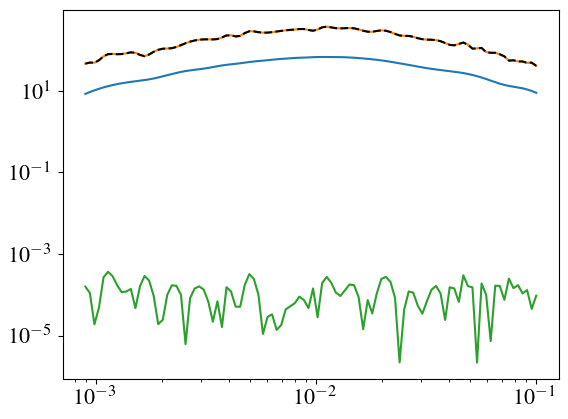

In [118]:
#plt.loglog(kL_ofz[1], ((b[0.7] + 1*(f_fid[4]) )**2) *np.abs(GALI_dPmm_dtau))
plt.loglog(kL_ofz[1], np.abs(GALI_dPmm_dtau))
plt.loglog(kL_ofz[1], np.abs(GALI_dPgg_dtau) )
plt.loglog(kL_ofz[1], np.abs(GALI_dPgg_dtau) + 1e-1*np.cos(kL_ofz[1]), ls='dashed', c='k')
plt.loglog(kL_ofz[1], np.abs(GALI_dfk_dtau))

In [126]:
#dPgg_dparam_num('tau', z, kLlist, mulist, fofkflag, nonlin_flag, brsd_fid, Rstar_fid, b1_ofz_fid, bk2_fid, bk4_fid)
AVERY_dPgg_dtau = dPgg_dparam_num_noW('tau', 0.7, kL_ofz[1], mulist, True, False, 1., 1., b[0.7], 0, 0)
AVERY_dPgg_dAs = dPgg_dparam_num_noW('As', 0.7, kL_ofz[1], mulist, True, False, 1., 1., b[0.7], 0, 0)

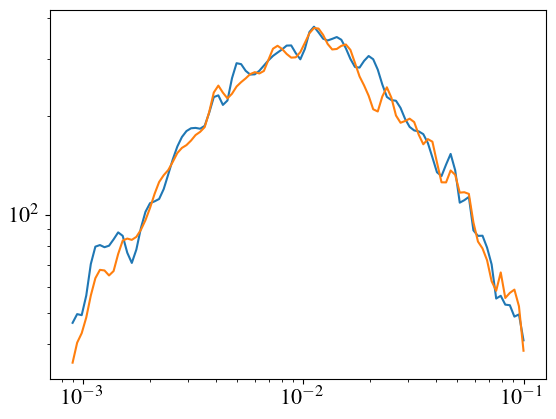

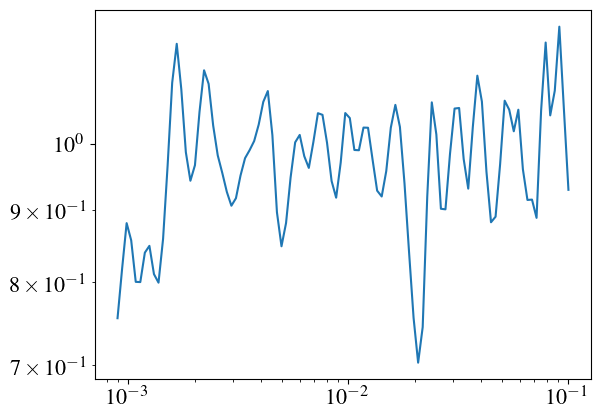

In [134]:
plt.loglog(kL_ofz[1], np.abs(GALI_dPgg_dtau) )
plt.loglog(kL_ofz[1], np.abs(AVERY_dPgg_dtau[0,:,2]) )
plt.show()
plt.loglog(kL_ofz[1], np.abs(AVERY_dPgg_dtau[0,:,2])/np.abs(GALI_dPgg_dtau) )

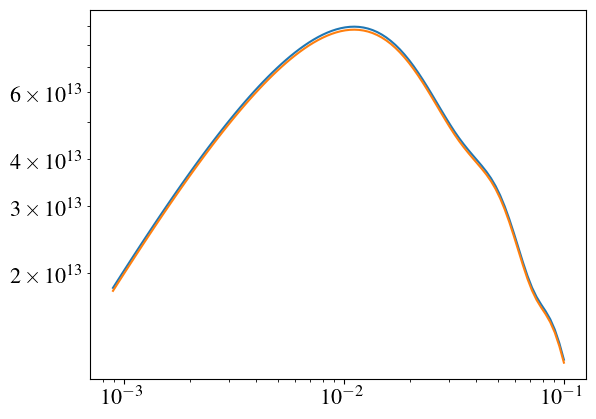

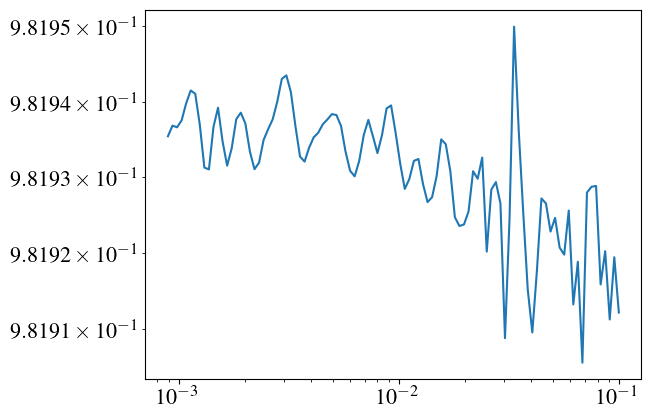

In [136]:
plt.loglog(kL_ofz[1], np.abs(GALI_dPgg_dAs[:,0]) )
plt.loglog(kL_ofz[1], np.abs(AVERY_dPgg_dAs[0,:,2]) )

plt.show()

plt.loglog(kL_ofz[1], np.abs(AVERY_dPgg_dAs[0,:,2])/ np.abs(GALI_dPgg_dAs[:,0]) )

In [159]:
GALI_Pgg = np.loadtxt('GALI_files/Pgg_fz.txt')
GALI_Pgv = np.loadtxt('GALI_files/Pgv_fz.txt')
GALI_Pvv = np.loadtxt('GALI_files/Pvv_fz.txt')

#get_Pgg_noW(z, kLlist, mulist, f_ofk_flag, f_ofk_list, Pmm_touse, brsd, Rstar, b1_ofz, Om0input, H0input, bk2, bk4):
#get_Pgvr_noW(z, kLlist, mulist, f_ofk_flag, f_ofk_list, Pmm_touse, brsd, Rstar, b1_ofz, Om0input,H0input, bk2, bk4, bv):
# get_Pvrvr_noW(z, kLlist, mulist, f_ofk_flag, f_ofk_list, Pmm_touse, bv)
Avery_Pgg = get_Pgg_noW(0.7, kL_ofz[1], mulist, False, f_params_dict_h_lin['fid'][zdict_fs_dPij[0.7]], Pmm_params_dict_h_lin['fid'], 1., 1., b[0.7], Om0fid, H0fid, 0., 0.)
Avery_Pgv = get_Pgvr_noW(0.7, kL_ofz[1], mulist, False, f_params_dict_h_lin['fid'][zdict_fs_dPij[0.7]], Pmm_params_dict_h_lin['fid'], 1., 1., b[0.7], Om0fid, H0fid, 0., 0., 1.)
Avery_Pvv = get_Pvrvr_noW(0.7, kL_ofz[1], mulist, False, f_params_dict_h_lin['fid'][zdict_fs_dPij[0.7]], Pmm_params_dict_h_lin['fid'],  1.)

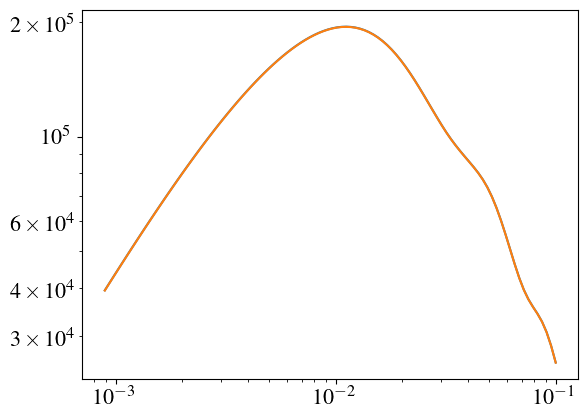

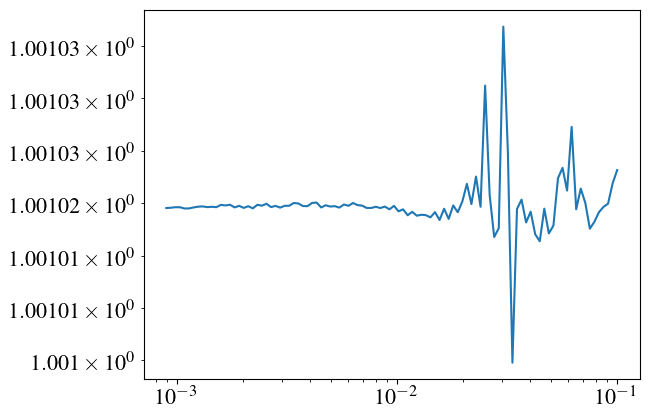

In [152]:
plt.loglog(kL_ofz[1], GALI_Pgg )
plt.loglog(kL_ofz[1], Avery_Pgg[0,:,2] )
plt.show()
plt.loglog(kL_ofz[1], GALI_Pgg/Avery_Pgg[0,:,2] )

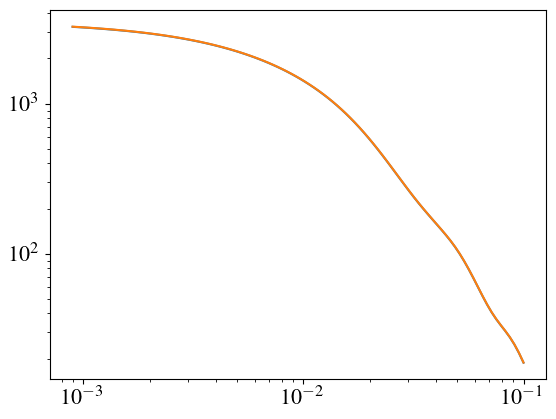

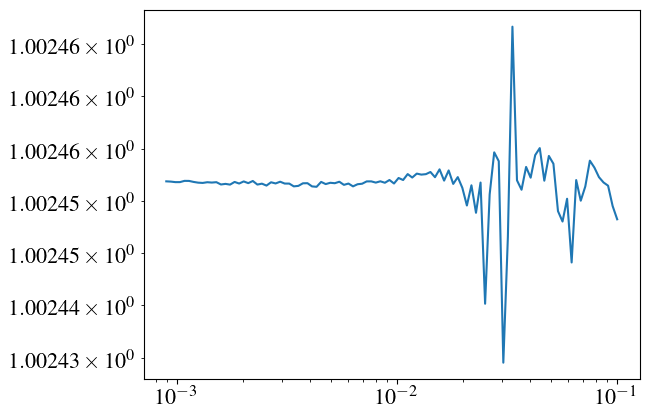

In [158]:
plt.loglog(kL_ofz[1], GALI_Pgv )
plt.loglog(kL_ofz[1], Avery_Pgv[101,:,2] )
plt.show()
plt.loglog(kL_ofz[1], Avery_Pgv[101,:,2]/GALI_Pgv )

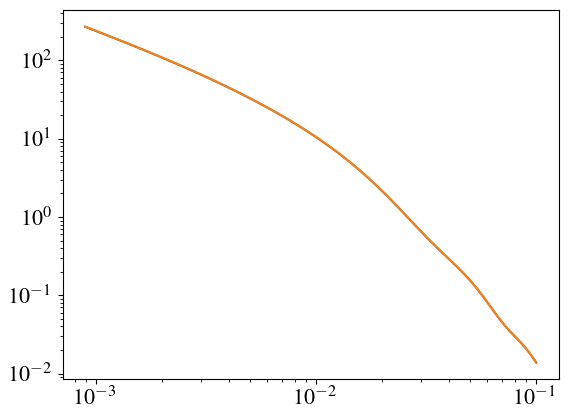

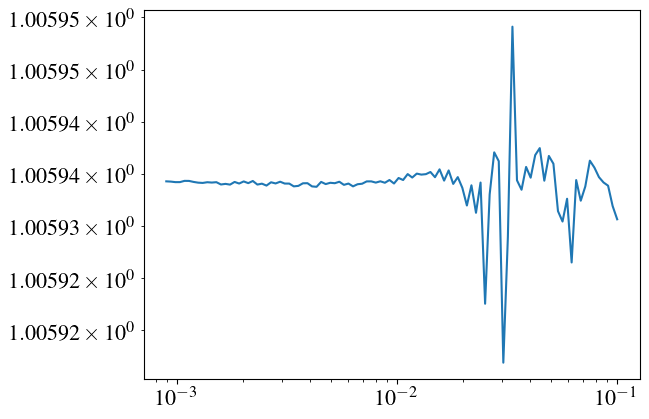

In [160]:
plt.loglog(kL_ofz[1], GALI_Pvv )
plt.loglog(kL_ofz[1], Avery_Pvv[101,:,2] )
plt.show()
plt.loglog(kL_ofz[1], Avery_Pvv[101,:,2]/GALI_Pvv )

### derivatives


In [ ]:
#dPvrg_dparam_num_noW(paramname, z, kLlist, mulist, f_ofk_flag, nonlin_flag, brsd, Rstar, b1_ofz, bk2, bk4, bv):

In [284]:
fkflag_here = True
pname = 'tau'
Avery_dPgv_dcosmo_noW = dPvrg_dparam_num_noW(pname, 0.7, kL_ofz[1], mulist, fkflag_here, False, 1., 1., b[0.7], 0., 0., 1.0)
plt.loglog(kL_ofz[1], np.abs(Avery_dPgv_dcosmo_noW[101,:,2]) )

In [210]:
GALI_dPgg_dcosmo = np.loadtxt('GALI_files/d_Pgg_fz.txt')
GALI_dPgv_dcosmo = np.loadtxt('GALI_files/d_Pgv_fz.txt')
GALI_dPvv_dcosmo = np.loadtxt('GALI_files/d_Pvv_fz.txt')
pname_dict={'H0':0 , 'ombh2':1, 'omch2':2 , 'ns':3, 'As':4 ,'tau':5 , 'mnu':6}

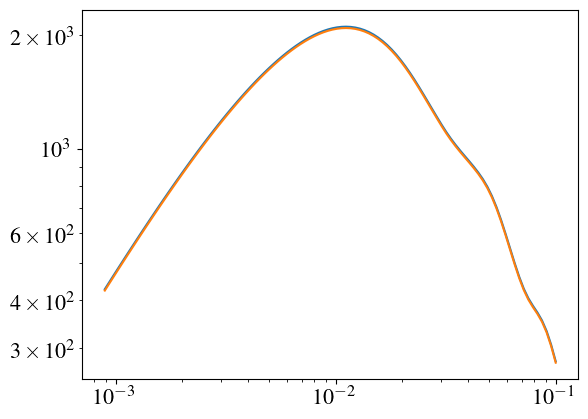

In [212]:
pname = 'H0'
Avery_dPgg_dcosmo_noW = dPgg_dparam_num_noW(pname, 0.7, kL_ofz[1], mulist, False, False, 1., 1., b[0.7], 0., 0.)
Gali_dPgg_dp =  GALI_dPgg_dcosmo[pname_dict[pname]]
plt.loglog(kL_ofz[1], np.abs(Gali_dPgg_dp) )
plt.loglog(kL_ofz[1], np.abs(Avery_dPgg_dcosmo_noW[101,:,2]) )
plt.show()
plt.loglog(kL_ofz[1], np.abs(Gali_dPgg_dp) / np.abs(Avery_dPgg_dcosmo_noW[101,:,2]))


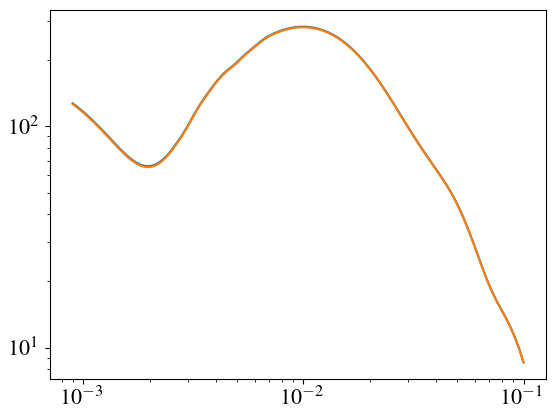

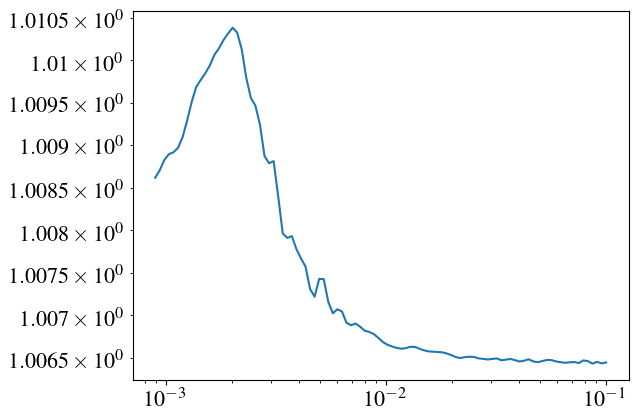

In [235]:
pname = 'mnu'

Avery_dPgvr_dcosmo_noW = dPvrg_dparam_num_noW(pname, 0.7, kL_ofz[1], mulist, False, False, 1., 1., b[0.7], 0., 0., 1.)
Gali_dPgv_dp =  GALI_dPgv_dcosmo[pname_dict[pname]]

plt.loglog(kL_ofz[1], np.abs(Gali_dPgv_dp) )
plt.loglog(kL_ofz[1], np.abs(Avery_dPgvr_dcosmo_noW[101,:,2]) )
plt.show()
plt.loglog(kL_ofz[1], np.abs(Gali_dPgv_dp) / np.abs(Avery_dPgvr_dcosmo_noW[101,:,2]))

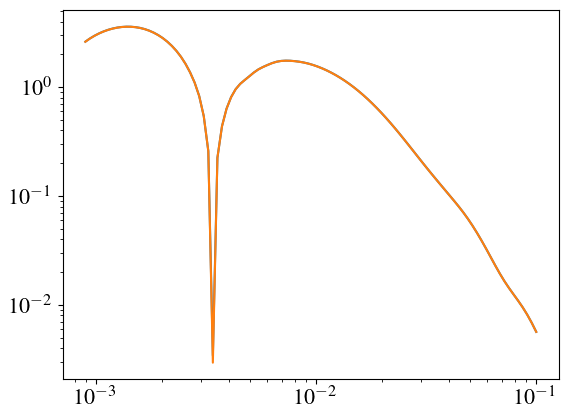

In [245]:
pname = 'mnu'

Avery_dPvv_dcosmo_noW = dPvrvr_dparam_num_noW(pname, 0.7, kL_ofz[1], mulist, False, False,  1.)
Gali_dPvv_dp =  GALI_dPvv_dcosmo[pname_dict[pname]]

plt.loglog(kL_ofz[1], np.abs(Gali_dPvv_dp) )
plt.loglog(kL_ofz[1], np.abs(Avery_dPvv_dcosmo_noW[101,:,2]) )
plt.show()
plt.loglog(kL_ofz[1], np.abs(Gali_dPvv_dp) / np.abs(Avery_dPvv_dcosmo_noW[101,:,2]))

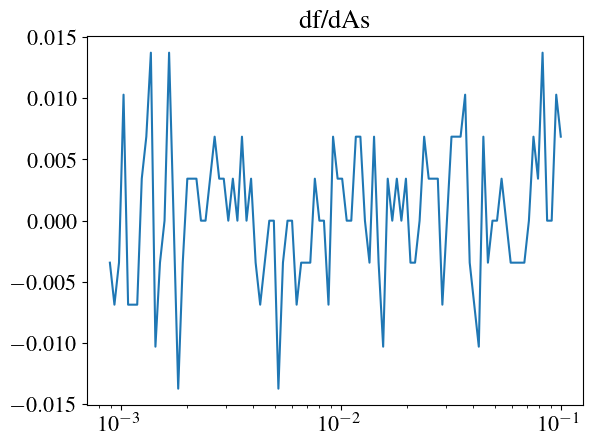

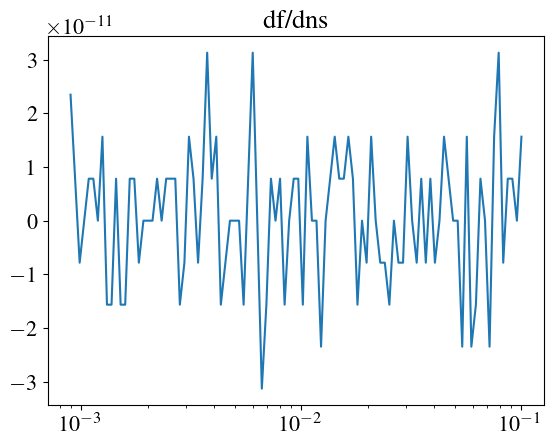

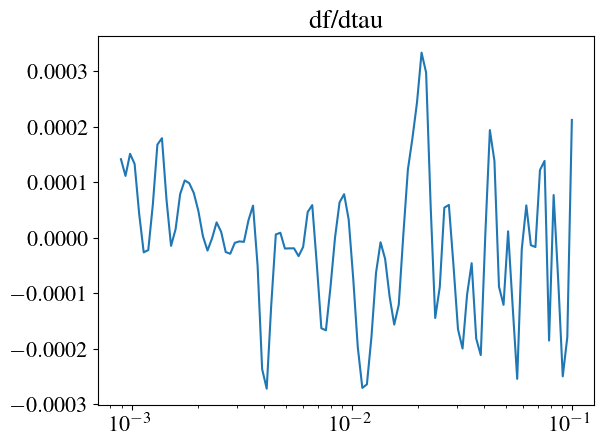

In [267]:
pname = 'As'
plt.semilogx(kL_ofz[1],  df_dcosmo_params_dict_ofz_ofk_lin[pname][0.7])
plt.title('df/dAs')
plt.show()

pname = 'ns'
plt.semilogx(kL_ofz[1],  df_dcosmo_params_dict_ofz_ofk_lin[pname][0.7])
plt.title('df/dns')
plt.show()

pname = 'tau'
plt.semilogx(kL_ofz[1],  df_dcosmo_params_dict_ofz_ofk_lin[pname][0.7])
plt.title('df/dtau')
plt.show()

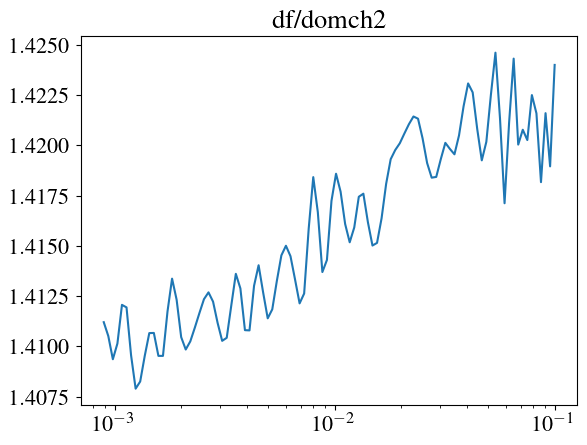

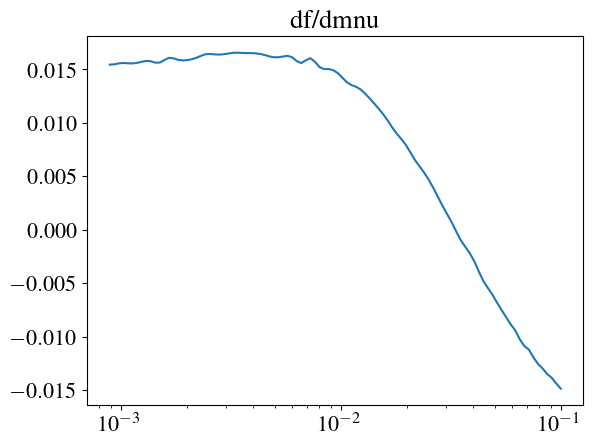

In [269]:
pname = 'H0'
plt.semilogx(kL_ofz[1],  df_dcosmo_params_dict_ofz_ofk_lin[pname][0.7])
plt.title('df/dH0')
plt.show()

pname = 'ombh2'
plt.semilogx(kL_ofz[1],  df_dcosmo_params_dict_ofz_ofk_lin[pname][0.7])
plt.title('df/dombh2')
plt.show()

pname = 'omch2'
plt.semilogx(kL_ofz[1],  df_dcosmo_params_dict_ofz_ofk_lin[pname][0.7])
plt.title('df/domch2')
plt.show()


pname = 'mnu'
plt.semilogx(kL_ofz[1],  df_dcosmo_params_dict_ofz_ofk_lin[pname][0.7])
plt.title('df/dmnu')
plt.show()

In [771]:
np.shape(test_dPgg_dbrsd)

(102, 100, 3)

In [781]:
#dPij_dparams_noW(z, kLlist, mulist, f_ofk_flag, f_ofk_list, Pmm_touse, brsd, Rstar, b1_ofz, Om0input,H0input, bk2, bk4, bv, lin_b1_flag, m_fid, q_fid):
test_dP_dparams_noW = dPij_dparams_noW(0.7, kL_ofz[1], mulist, True, f_params_dict_h_ofz_ofk_lin['fid'][0.7], Pmm_params_dict_h_lin['fid'], 1., 1., b[0.7], Om0fid, H0fid, 0., 0., 1., False, m_fid, q_fid)
test_dPgg_dbrsd = test_dP_dparams_noW['Pgg']['brsd']
test1 = test_dPgg_dbrsd[0,:,2]
test2 = 2*(b[0.7] + 1*f_params_dict_h_ofz_ofk_lin['fid'][0.7]*(-1)*(-1))*(1*f_params_dict_h_ofz_ofk_lin['fid'][0.7]*(-1)*(-1))*Pmm_params_dict_h_lin['fid'](0.7, kL_ofz[1])
plt.loglog( kL_ofz[1], test1)
plt.loglog( kL_ofz[1], test2)
plt.show()
plt.loglog( kL_ofz[1], test1/test2)

/Users/averytishue/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


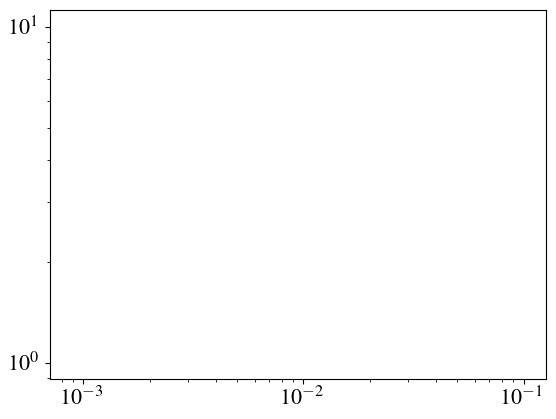

In [787]:
#dPij_dparams_noW(z, kLlist, mulist, f_ofk_flag, f_ofk_list, Pmm_touse, brsd, Rstar, b1_ofz, Om0input,H0input, bk2, bk4, bv, lin_b1_flag, m_fid, q_fid):
test_dP_dparams_noW = dPij_dparams_noW(0.7, kL_ofz[1], mulist, True, f_params_dict_h_ofz_ofk_lin['fid'][0.7], Pmm_params_dict_h_lin['fid'], 1., 1., b[0.7], Om0fid, H0fid, 0., 0., 1., False, m_fid, q_fid)
test_dPgvr_dbrsd = test_dP_dparams_noW['Pgvr']['brsd']
atest=1/(1+0.7)
test1 = test_dPgvr_dbrsd[0,:,2]
test2 = (-1)*1.*(f_params_dict_h_ofz_ofk_lin['fid'][0.7]*atest*HofzedfidLCDM(0.7)/kL_ofz[1] )*(1*f_params_dict_h_ofz_ofk_lin['fid'][0.7]*(-1)*(-1))*Pmm_params_dict_h_lin['fid'](0.7, kL_ofz[1])
plt.loglog( kL_ofz[1], test1)
plt.loglog( kL_ofz[1], test2)
plt.show()
plt.loglog( kL_ofz[1], test1/test2)

In [783]:
Hz_paramdict_h_lin.keys()

dict_keys(['As', 'H0', 'ombh2', 'omch2', 'ns', 'mnu', 'tau', 'nnu', 'w0', 'wa', 'ok'])

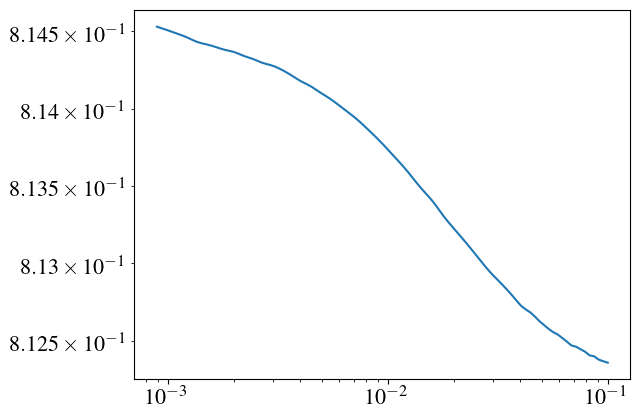

In [780]:
plt.loglog( kL_ofz[1], f_params_dict_h_ofz_ofk_lin['fid'][0.7])

# Combine w/ BAO & CMB

## HD

In [1323]:
#my HD WITH lensing, lmax 10000
F_HD_lensing_load = np.load('/Users/averytishue/FisherLens/CLASS_delens/results/fisher_8p_1exp_GALIfids_HD_withlensing_lmax10000.pkl',allow_pickle=True)
F_HD_lensing = F_HD_lensing_load['fisherGaussian'][0]['lensed']
F_HD_lensing = fsky *  F_HD_lensing
F_HD_lensing_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
F_HD_lensing_Fisher = FisherMatrix(F_HD_lensing , F_HD_lensing_keys)
F_HD_lensing_Fisher.delete('nnu')
F_HD_lensing_Fisher.sigmas()

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


{'omch2': 0.0005467445550892823,
 'ombh2': 1.4452735103019176e-05,
 'As': 2.821161228095442e-11,
 'ns': 0.0016907284265218023,
 'tau': 0.006894433842579098,
 'H0': 0.295949769288864,
 'mnu': 0.025454274173931726}

In [1591]:
#my HD WITH lensing
F_HD_lensing_load = np.load('/Users/averytishue/FisherLens/CLASS_delens/results/fisher_8p_1exp_GALIfids_HD_withlensing.pkl',allow_pickle=True)
F_HD_lensing = F_HD_lensing_load['fisherGaussian'][0]['lensed']
F_HD_lensing = fsky *  F_HD_lensing
F_HD_lensing_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
F_HD_lensing_Fisher = FisherMatrix(F_HD_lensing , F_HD_lensing_keys)
F_HD_lensing_Fisher.delete('nnu')
F_HD_lensing_Fisher.sigmas()

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


{'omch2': 0.0006881734766083947,
 'ombh2': 1.595056691256925e-05,
 'As': 3.44748413968322e-11,
 'ns': 0.002224223798881706,
 'tau': 0.008320799556729144,
 'H0': 0.5582083192375363,
 'mnu': 0.0468752341466396}

In [1296]:
#my HD without lensing
F_HD_nolensing_load = np.load('/Users/averytishue/FisherLens/CLASS_delens/results/fisher_8p_1exp_GALIfids_HD_nolensing.pkl',allow_pickle=True)
F_HD_nolensing = F_HD_nolensing_load['fisherGaussian'][0]['lensed']
F_HD_nolensing = fsky *  F_HD_nolensing
F_HD_nolensing_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
F_HD_nolensing_Fisher = FisherMatrix(F_HD_nolensing , F_HD_nolensing_keys)
F_HD_nolensing_Fisher.delete('nnu')
F_HD_nolensing_Fisher.sigmas()

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


{'omch2': 0.0007780143640590225,
 'ombh2': 1.8333398512420978e-05,
 'As': 7.973922283838771e-11,
 'ns': 0.0023064862774416868,
 'tau': 0.01857312920291025,
 'H0': 1.3470971459581322,
 'mnu': 0.13323086679247695}

In [1592]:
F_BAO_HD_lensing = F_HD_lensing_Fisher + F_BAO_GALI_LCDMmnu
F_BAO_HD_lensing_tauprior = F_BAO_HD_lensing.copy()
F_BAO_HD_lensing_tauprior.add_prior('tau', tau_prior_planck)

print(F_BAO_HD_lensing.sigmas()['mnu'])
print(F_BAO_HD_lensing_tauprior.sigmas()['mnu'])

0.028981255779609312
0.02184864214098924


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

In [1593]:
F_Pgg_BAO_HD_lensing = F_BAO_HD_lensing + F_gg_dict['b_ofz_nonlin']
F_Pgggvvv_BAO_HD_lensing = F_BAO_HD_lensing + F_gggvvv_dict['b_ofz_nonlin_HD_lmax15000_Nvv']

print(F_Pgg_BAO_HD_lensing.sigmas()['mnu'])
print(F_Pgggvvv_BAO_HD_lensing.sigmas()['mnu'])

0.02420152014961842
0.0225243236496808


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [ ]:
#F_BAO_HD_lensing_tauprior
#F_Pgg_BAO_HD_lensing_tauprior
#F_Pgggvvv_BAO_HD_lensing_tauprior


In [1595]:
F_Pgg_BAO_HD_lensing_tauprior = F_Pgg_BAO_HD_lensing.copy()
F_Pgg_BAO_HD_lensing_tauprior.add_prior('tau', tau_prior_planck)

F_Pgggvvv_BAO_HD_lensing_tauprior = F_Pgggvvv_BAO_HD_lensing.copy()
F_Pgggvvv_BAO_HD_lensing_tauprior.add_prior('tau', tau_prior_planck)

print(F_Pgg_BAO_HD_lensing_tauprior.sigmas()['mnu'])
print(F_Pgggvvv_BAO_HD_lensing_tauprior.sigmas()['mnu'])

0.020103485613650707
0.019306015991032006


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

In [1298]:
#can kSZ replace lensing?
F_Pgg_BAO_HD_nolensing = F_HD_nolensing_Fisher.copy() + F_gg_dict['mq_lin'] + F_BAO_GALI_LCDMmnu
print(F_Pgg_BAO_HD_nolensing.sigmas())

F_Pgggvvv_BAO_HD_nolensing = F_HD_nolensing_Fisher + F_gggvvv_dict['mq_lin_HD_lmax15000_Nvv'] + F_BAO_GALI_LCDMmnu
F_Pgggvvv_BAO_HD_nolensing.sigmas()

{'As': 3.084854654309775e-11, 'H0': 0.2199022359919897, 'bk2': 0.6382730878636411, 'brsd': 0.025632084248279875, 'm': 0.0030877266432144984, 'mnu': 0.029752558481332823, 'ns': 0.001896873919138545, 'ombh2': 1.8235918492570095e-05, 'omch2': 0.0004860949517987364, 'q': 0.00475188207407434, 'tau': 0.007781181157000673}


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


{'As': 2.72239881350824e-11,
 'H0': 0.21053129090159015,
 'bk2': 0.5959341149732119,
 'brsd': 0.008541230943814376,
 'bv': 0.002599313786175225,
 'm': 0.0027602014018592255,
 'mnu': 0.026573213570579762,
 'ns': 0.001843699046779307,
 'ombh2': 1.822419837654188e-05,
 'omch2': 0.00044745233183845205,
 'q': 0.0039037781278916804,
 'tau': 0.006898208824147692}

In [1305]:
#kSZ improvement lensing
print('how kSZ improves over Pgg alone, without lensing: ',26.57/29.75)
print('how kSZ improves over Pgg alone, WITH lensing: ',21.83/23.7)

# lensing improvement things
print('lensing improvement with Pgg ', 23.7/29.75)
print('lensing improvement with Pgg,Pgv,Pvv ', 21.83/26.57)

how kSZ improves over Pgg alone, without lensing:  0.893109243697479
how kSZ improves over Pgg alone, WITH lensing:  0.9210970464135021
lensing improvement with Pgg  0.7966386554621848
lensing improvement with Pgg,Pgv,Pvv  0.8216033120060218


In [1332]:
F_Pgg_BAO_HD_lensing = F_HD_lensing_Fisher + F_gg_dict['b_ofz_nonlin'] + F_BAO_GALI_LCDMmnu
F_Pgg_BAO_HD_lensing.add_prior('tau', tau_prior_planck)
print(F_Pgg_BAO_HD_lensing.sigmas())

{'As': 2.018032690025858e-11, 'H0': 0.20008790446524086, 'b1_0.2': 0.012717540289111092, 'b1_0.7': 0.0065445342474376896, 'b1_1.3': 0.007350591650694982, 'b1_1.9': 0.009102000238340098, 'b1_2.6': 0.01140008628344244, 'bk2_0.2': 2.01434158606892, 'bk2_0.7': 0.9720051954964407, 'bk2_1.3': 1.0112107747109815, 'bk2_1.9': 1.2531728309641166, 'bk2_2.6': 1.668877710973829, 'brsd_0.2': 0.1125810702180515, 'brsd_0.7': 0.04534326336641792, 'brsd_1.3': 0.041792793809461375, 'brsd_1.9': 0.04881930093028303, 'brsd_2.6': 0.060401749863957466, 'mnu': 0.020103485613650707, 'ns': 0.001363708606673613, 'ombh2': 1.4949555172249617e-05, 'omch2': 0.0003520732506421438, 'tau': 0.004982918573527838}


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

In [1333]:
F_Pgggvvv_BAO_HD_lensing = F_HD_lensing_Fisher + F_gggvvv_dict['b_ofz_nonlin_HD_lmax15000_Nvv'] + F_BAO_GALI_LCDMmnu
F_Pgggvvv_BAO_HD_lensing.add_prior('tau', tau_prior_planck)
print(F_Pgggvvv_BAO_HD_lensing.sigmas())

{'As': 1.9193610565939527e-11, 'H0': 0.19803620694279256, 'b1_0.2': 0.010287422899562894, 'b1_0.7': 0.005572078681975722, 'b1_1.3': 0.006642016093119207, 'b1_1.9': 0.008491786373103544, 'b1_2.6': 0.010971287925214186, 'bk2_0.2': 1.7736500594456575, 'bk2_0.7': 0.8646833010139847, 'bk2_1.3': 0.9268062026180294, 'bk2_1.9': 1.1775865682157933, 'bk2_2.6': 1.6117153693117239, 'brsd_0.2': 0.03364664042741881, 'brsd_0.7': 0.012323531532120988, 'brsd_1.3': 0.015763770539646196, 'brsd_1.9': 0.02578788721251898, 'brsd_2.6': 0.04310316703753214, 'bv_0.2': 0.010833052524592622, 'bv_0.7': 0.003927498905936513, 'bv_1.3': 0.003681799866689556, 'bv_1.9': 0.004334800104297406, 'bv_2.6': 0.005308498927576074, 'mnu': 0.019306015991032006, 'ns': 0.001361547757787622, 'ombh2': 1.494287634430334e-05, 'omch2': 0.00034559840483293434, 'tau': 0.004755927036884221}


In [1299]:
F_Pgg_BAO_HD_lensing = F_HD_lensing_Fisher + F_gg_dict['mq_lin'] + F_BAO_GALI_LCDMmnu
print(F_Pgg_BAO_HD_lensing.sigmas())

F_Pgggvvv_BAO_HD_lensing = F_HD_lensing_Fisher + F_gggvvv_dict['mq_lin_HD_lmax15000_Nvv'] + F_BAO_GALI_LCDMmnu
F_Pgggvvv_BAO_HD_lensing.sigmas()

{'As': 2.613917506165198e-11, 'H0': 0.2005650536717102, 'bk2': 0.6167358234674565, 'brsd': 0.02505442500171567, 'm': 0.0029922496740131593, 'mnu': 0.02369812661126363, 'ns': 0.0014502083611283919, 'ombh2': 1.4955676434884629e-05, 'omch2': 0.0004229521558375114, 'q': 0.004622574808002635, 'tau': 0.00648803423015338}


{'As': 2.385995910739128e-11,
 'H0': 0.19455247753536498,
 'bk2': 0.5733870215279656,
 'brsd': 0.008495031457384821,
 'bv': 0.002329194724062706,
 'm': 0.002649849733083745,
 'mnu': 0.021828768689631795,
 'ns': 0.001430590474796374,
 'ombh2': 1.4944381355450947e-05,
 'omch2': 0.000401155935796544,
 'q': 0.003781072633213679,
 'tau': 0.005946774637614506}

## BAO

In [340]:
from stats import FisherMatrix
F_BAO_GALI_load = np.loadtxt('GALI_files/Fisher_DESI_BAO')
F_BAO_GALI_load_keys_withzeros = ['H0', 'ombh2', 'omch2', 'As', 'ns', 'tau', 'mnu']
F_BAO_GALI_load_keys_final = ['H0', 'ombh2', 'omch2', 'mnu']
F_BAO_GALI_temp = FisherMatrix(F_BAO_GALI_load , F_BAO_GALI_load_keys_withzeros)
F_BAO_GALI_LCDMmnu = F_BAO_GALI_temp.copy()
F_BAO_GALI_LCDMmnu.delete('As')
F_BAO_GALI_LCDMmnu.delete('ns')
F_BAO_GALI_LCDMmnu.delete('tau')

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [1924]:
F_BAO_GALI_temp

H0         ombh2          omch2   As   ns  tau           mnu
H0        24.605520 -1.732899e+04    -949.850493  0.0  0.0  0.0     39.917511
ombh2 -17328.993630  1.241537e+07  581294.334168  0.0  0.0  0.0 -29969.165142
omch2   -949.850493  5.812943e+05   73079.238084  0.0  0.0  0.0   -769.846907
As         0.000000  0.000000e+00       0.000000  0.0  0.0  0.0      0.000000
ns         0.000000  0.000000e+00       0.000000  0.0  0.0  0.0      0.000000
tau        0.000000  0.000000e+00       0.000000  0.0  0.0  0.0      0.000000
mnu       39.917511 -2.996917e+04    -769.846907  0.0  0.0  0.0     81.087553

In [388]:
F_BAO_GALI_LCDMmnu.sigmas()

{'H0': 242570.4992569896,
 'ombh2': 17.544445273750757,
 'omch2': 2045.164151615035,
 'mnu': 95081.17649405668}

## S4

In [417]:
fsky = 0.4

F_S4_GALI_load = np.load('GALI_files/fisher_8p_S4.pkl', allow_pickle=True)
F_S4_GALI_load_fishergaussian = F_S4_GALI_load['fisherGaussian']
F_S4_GALI_load_fishergaussian_fmat_lensed = F_S4_GALI_load_fishergaussian[0]['lensed']
F_S4_GALI_load_fishergaussian_fmat_lensed = fsky * F_S4_GALI_load_fishergaussian_fmat_lensed
F_S4_GALI_load_fishergaussian_fmat_lensed_keys=['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'nnu']
F_S4_GALI_fishergaussian_fmat_lensed = FisherMatrix( F_S4_GALI_load_fishergaussian_fmat_lensed, F_S4_GALI_load_fishergaussian_fmat_lensed_keys)

In [2557]:
F_S4_GALI_fishergaussian_fmat_lensed.sigmas()['mnu']

0.09363557802143033

In [2572]:
#my own S4
F_S4_test_load = np.load('/Users/averytishue/FisherLens/CLASS_delens/results/fisher_8p_1exp_GALIfids_withlensing.pkl',allow_pickle=True)
F_S4_test = F_S4_test_load['fisherGaussian'][0]['lensed']
F_S4_test = fsky *  F_S4_test
F_S4_test_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
F_S4_test_Fisher = FisherMatrix(F_S4_test , F_S4_test_keys)
F_S4_test_Fisher.delete('nnu')
F_S4_test_Fisher.sigmas()
#F_S4_test_fisher = FisherMatrix(F_S4_test , )

{'omch2': 0.0008086908576646175,
 'ombh2': 3.052301901659771e-05,
 'As': 5.7976878869982754e-11,
 'ns': 0.0024370996390421537,
 'tau': 0.01357491157560276,
 'H0': 1.031608070909544,
 'mnu': 0.09456809179468069}

### S4, litebird tau prior, no BAO

In [1987]:
F_S4_test_Fisher_litebirdtau.sigmas()

{'omch2': 0.000797034340008373,
 'ombh2': 3.0000114980436553e-05,
 'As': 1.0095757032615173e-11,
 'ns': 0.002392765586452877,
 'tau': 0.0019786407913599878,
 'H0': 0.7623665473635732,
 'mnu': 0.05057584657308299}

In [2320]:
test = F_S4_test_Fisher + F_gg_dict['b_ofz_nonlin'] 
#test.add_prior('tau', tau_prior_litebird)
test.sigmas()['mnu']

0.09456809179468069

In [ ]:
#F_S4_test_Fisher_litebirdtau

In [1273]:
for key in F_S4_test_Fisher.keys():
    print(key, ' ', F_S4_test_Fisher.sigmas()[key] / F_S4_GALI_fishergaussian_fmat_lensed.sigmas()[key])

omch2   0.9999620757297638
ombh2   1.001365907788641
As   1.0071049572811008
ns   0.9986890670898597
tau   1.006739434991617
H0   1.0115761601090298
mnu   1.0099589685134098


In [418]:
F_S4_GALI_fishergaussian_fmat_lensed.delete('nnu')
F_S4_GALI_fishergaussian_fmat_lensed.sigmas()

{'H0': 1.019802671900013,
 'ombh2': 3.048138425643329e-05,
 'omch2': 0.0008087215278383851,
 'ns': 0.002440298706927638,
 'As': 5.75678616720386e-11,
 'tau': 0.013484036786257208,
 'mnu': 0.09363557802143033}

In [2571]:
#my S4 without lensing
F_S4_nolensing_load = np.load('/Users/averytishue/FisherLens/CLASS_delens/results/fisher_8p_1exp_GALIfids_nolensing.pkl',allow_pickle=True)
F_S4_nolensing = F_S4_nolensing_load['fisherGaussian'][0]['lensed']
F_S4_nolensing = fsky *  F_S4_nolensing
F_S4_nolensing_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
F_S4_nolensing_Fisher = FisherMatrix(F_S4_nolensing , F_S4_nolensing_keys)
F_S4_nolensing_Fisher.delete('nnu')
F_S4_nolensing_Fisher.sigmas()

{'omch2': 0.0008694530332736444,
 'ombh2': 3.1678425513606234e-05,
 'As': 1.3616221551738037e-10,
 'ns': 0.002510020825151119,
 'tau': 0.031693749316070614,
 'H0': 2.2127142562550715,
 'mnu': 0.23738807635143103}

In [ ]:
{'omch2': 0.0008694530332736444,
 'ombh2': 3.1678425513606234e-05,
 'As': 1.3616221551738037e-10,
 'ns': 0.002510020825151119,
 'tau': 0.031693749316070614,
 'H0': 2.2127142562550715,
 'mnu': 0.23738807635143103}

In [2570]:
test = {}
test =  F_S4_nolensing_Fisher.copy() #+ F_BAO_GALI_LCDMmnu  
test.add_prior('tau', tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.076500525173722


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [2564]:
test = {}
test =  F_S4_test_Fisher.copy() + F_BAO_GALI_LCDMmnu  
test.add_prior('tau', 0.01)
print(test.sigmas()['mnu'])
del(test)

0.02782340607596601


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

In [2554]:
test = F_S4_nolensing_Fisher.copy() + F_BAO_GALI_LCDMmnu  #+ F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_over_400']  #F_gg_dict['b_ofz_nonlin'] #+ F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
test.add_prior('tau', tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.030288052351332685


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [2332]:
20.2/22.4

0.9017857142857143

In [2078]:
test = F_S4_test_Fisher.copy() + F_BAO_GALI_LCDMmnu  + F_gg_dict['b_ofz_nonlin']  #F_gg_dict['b_ofz_nonlin'] #+ F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
#test.add_prior('tau', tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

test = F_S4_test_Fisher.copy() + F_BAO_GALI_LCDMmnu  + F_gg_dict['b_ofz_nonlin']  #F_gg_dict['b_ofz_nonlin'] #+ F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
test.add_prior('tau', tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

test = F_S4_test_Fisher.copy() + F_BAO_GALI_LCDMmnu  + F_gg_dict['b_ofz_nonlin']  #F_gg_dict['b_ofz_nonlin'] #+ F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
test.add_prior('tau', tau_prior_litebird)
print(test.sigmas()['mnu'])
del(test)

0.029143001901958353
0.02240666537704697
0.015265955662686098


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

In [2019]:
F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'].sigmas()['mnu']

0.2763411322463361

In [2079]:
28.6/29.1

0.9828178694158075

In [2752]:
F_S4_nolensing_load['fisherGaussian'][0].keys()

dict_keys(['unlensed', 'lensed', 'delensed'])

# S4 NO LENSING, unlensed

In [2753]:
#my S4 without lensing
F_S4_nolensing_UNLENSED_load = np.load('/Users/averytishue/FisherLens/CLASS_delens/results/fisher_8p_1exp_GALIfids_nolensing.pkl',allow_pickle=True)
F_S4_nolensing_UNLENSED = F_S4_nolensing_UNLENSED_load['fisherGaussian'][0]['unlensed']
F_S4_nolensing_UNLENSED = fsky *  F_S4_nolensing_UNLENSED
F_S4_nolensing_UNLENSED_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
F_S4_nolensing_UNLENSED_Fisher = FisherMatrix(F_S4_nolensing_UNLENSED , F_S4_nolensing_UNLENSED_keys)
F_S4_nolensing_UNLENSED_Fisher.delete('nnu')
F_S4_nolensing_UNLENSED_Fisher.sigmas()

{'omch2': 0.0007899077528368377,
 'ombh2': 3.0832089444850085e-05,
 'As': 5.722431779397586e-10,
 'ns': 0.0027124927721721035,
 'tau': 0.1303585977785585,
 'H0': 3.3552849037655177,
 'mnu': 0.3567209372804015}

In [2935]:
F_S4_nolensing_UNLENSED_Fisher.sigmas()

{'omch2': 0.0007899077528368377,
 'ombh2': 3.0832089444850085e-05,
 'As': 5.722431779397586e-10,
 'ns': 0.0027124927721721035,
 'tau': 0.1303585977785585,
 'H0': 3.3552849037655177,
 'mnu': 0.3567209372804015}

In [2887]:
F_S4_nolensing_UNLENSED_load.keys()

dict_keys(['cmbNoiseSpectra', 'powersFid', 'paramDerivs', 'fisherGaussian', 'deflectionNoises', 'script_text', 'cosmoFid', 'cosmoParams'])

In [2891]:
F_S4_nolensing_UNLENSED_load['script_text']

"import sys\nimport cambWrapTools\nimport classWrapTools\nimport fisherTools\nimport pickle\nimport scipy\nimport numpy\nimport os\n\nimport copy\n\nuseMPI = False #True\n#MPI\nif useMPI:\n    from mpi4py import MPI\n    comm = MPI.COMM_WORLD\n    rank = comm.Get_rank()\n    size = comm.Get_size()\nelse:\n    rank = 0\n    size = 1\n\nprint(rank, size)\n\n###  Set of experiments  ###\n# Results will be indexed by experiment number, starting from 0\nexpNames = list(range(1)) #list(range(20))\nnExps = len(expNames)\nlmax = 5000\nlmaxTT = 3000\nlmin = 30\nnoiseLevels = numpy.array([1.5]) #numpy.arange(0.5, 10.5, 0.5)\nbeamSizeArcmin = 1. #\n\nlbuffer = 1500\nlmax_calc = lmax+lbuffer\n\nexpNamesThisNode = numpy.array_split(numpy.asarray(expNames), size)[rank]\n\n# Directory where CLASS_delens is located\nclassExecDir = '/Users/averytishue/FisherLens/CLASS_delens/' #'./CLASS_delens/'\n# Directory where you would like the output\nclassDataDir = '/Users/averytishue/FisherLens/CLASS_delens/' #

In [2764]:
test = F_S4_nolensing_UNLENSED_Fisher + F_BAO_GALI_LCDMmnu 
test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.04862895673697953


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [2755]:
test = F_S4_nolensing_UNLENSED_Fisher + F_BAO_GALI_LCDMmnu + F_gg_dict['b_ofz_nonlin']
test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.0318225215868028


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [2756]:
test = F_S4_nolensing_UNLENSED_Fisher + F_BAO_GALI_LCDMmnu + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.03103017738536364


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [2760]:
31.03/31.82

0.9751728472658705

In [2759]:
1-0.0310/0.0318

0.02515723270440262

In [2761]:
test = F_S4_nolensing_UNLENSED_Fisher + F_gg_dict['b_ofz_nonlin']
#test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.07135493407384906


In [2762]:
test = F_S4_nolensing_UNLENSED_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
#test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.06754477649828453


In [2766]:
1-67.5/71.4

0.054621848739495826

# S4 1.4muK', NO LENSING, unlensed

In [2971]:
#my S4 without lensing
F_S4_nolensing_UNLENSED_1p4_load = np.load('/Users/averytishue/FisherLens/CLASS_delens/results/fisher_8p_1exp_test_01242025.pkl',allow_pickle=True)
F_S4_nolensing_UNLENSED_1p4 = F_S4_nolensing_UNLENSED_1p4_load['fisherGaussian'][0]['unlensed']
F_S4_nolensing_UNLENSED_1p4 = fsky *  F_S4_nolensing_UNLENSED_1p4
F_S4_nolensing_UNLENSED_1p4_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
F_S4_nolensing_UNLENSED_1p4_Fisher = FisherMatrix(F_S4_nolensing_UNLENSED_1p4 , F_S4_nolensing_UNLENSED_1p4_keys)
F_S4_nolensing_UNLENSED_1p4_Fisher.delete('nnu')
F_S4_nolensing_UNLENSED_1p4_Fisher.sigmas()

{'omch2': 0.0007901378675371653,
 'ombh2': 3.089390596470613e-05,
 'As': 5.722567333976653e-10,
 'ns': 0.0027141525648785242,
 'tau': 0.13036155261597226,
 'H0': 3.3669123787215023,
 'mnu': 0.3579822447142909}

## no lensing no BAO

In [1736]:
F_S4_nolensing_Pgg_fk = F_S4_nolensing_Fisher + F_gg_dict['b_ofz_nonlin']
F_S4_nolensing_Pgg_fk_tauprior = F_S4_nolensing_Pgg_fk.copy()
F_S4_nolensing_Pgg_fk_tauprior.add_prior('tau', tau_prior_planck)


F_S4_nolensing_Pgggvvv_fk = F_S4_nolensing_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
F_S4_nolensing_Pgggvvv_fk_tauprior = F_S4_nolensing_Pgggvvv_fk.copy()
F_S4_nolensing_Pgggvvv_fk_tauprior.add_prior('tau', tau_prior_planck)

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

In [1737]:
print(F_S4_nolensing_Pgggvvv_fk_tauprior.sigmas()['mnu'])
print(F_S4_nolensing_Pgg_fk_tauprior.sigmas()['mnu'])
print(F_S4_nolensing_Pgggvvv_fk_tauprior.sigmas()['mnu'] /   F_S4_nolensing_Pgg_fk_tauprior.sigmas()['mnu'])

0.05656370110815246
0.0577044723009759
0.9802308010569201


In [1738]:
print(F_S4_nolensing_Pgggvvv_fk.sigmas()['mnu'])
print(F_S4_nolensing_Pgg_fk.sigmas()['mnu'])
print(F_S4_nolensing_Pgggvvv_fk.sigmas()['mnu'] /   F_S4_nolensing_Pgg_fk.sigmas()['mnu'])

0.06599669925410659
0.06870234520400373
0.9606178516633889


#### remove tau from Pgg and Pgggvvv

In [1741]:
F_gg_baseline_notau = F_gg_dict['b_ofz_nonlin'].copy()
F_gg_baseline_notau.delete('tau')

F_gggvvv_baseline_notau = F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'].copy()
F_gggvvv_baseline_notau.delete('tau')


F_S4_nolensing_Pgg_notau = F_S4_nolensing_Fisher + F_gg_baseline_notau
F_S4_nolensing_Pgggvvv_notau = F_S4_nolensing_Fisher + F_gggvvv_baseline_notau

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [1742]:
F_S4_nolensing_Pgg_notau.sigmas()['mnu']

0.0687023481799132

In [1743]:
F_S4_nolensing_Pgggvvv_notau.sigmas()['mnu']

0.06599666951953602

In [1966]:
66/68.7

0.9606986899563318

In [1744]:
F_S4_nolensing_Pgggvvv_notau.sigmas()['mnu'] / F_S4_nolensing_Pgg_notau.sigmas()['mnu']

0.9606173772504583

In [1546]:
F_S4_nolensing_Fisher.sigmas()

{'omch2': 0.0008694530332736444,
 'ombh2': 3.1678425513606234e-05,
 'As': 1.3616221551738037e-10,
 'ns': 0.002510020825151119,
 'tau': 0.031693749316070614,
 'H0': 2.2127142562550715,
 'mnu': 0.23738807635143103}

In [1547]:
F_S4_nolensing_Fisher_tauprior = F_S4_nolensing_Fisher.copy()
F_S4_nolensing_Fisher_tauprior.add_prior('tau', tau_prior_planck)
F_S4_nolensing_Fisher_tauprior.sigmas()

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

{'omch2': 0.0008373964854662578,
 'ombh2': 3.167548353400491e-05,
 'As': 3.187731568922781e-11,
 'ns': 0.0024546899608847623,
 'tau': 0.007305709097154728,
 'H0': 0.9347156578727677,
 'mnu': 0.076500525173722}

In [1353]:
F_S4_nolensing_BAO = F_S4_nolensing_Fisher  + F_BAO_GALI_LCDMmnu
F_S4_nolensing_BAO.sigmas()

{'As': 5.274478654336395e-11,
 'H0': 0.2625771028237125,
 'mnu': 0.052533730256057856,
 'ns': 0.0024974174364617513,
 'ombh2': 3.160359860247916e-05,
 'omch2': 0.0008627162545417894,
 'tau': 0.013241156067046267}

In [1548]:
F_S4_nolensing_BAO_tauprior = F_S4_nolensing_BAO.copy()
F_S4_nolensing_BAO_tauprior.add_prior('tau', tau_prior_planck)
F_S4_nolensing_BAO_tauprior.sigmas()

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

{'As': 2.6181150503763134e-11,
 'H0': 0.22499713102062377,
 'mnu': 0.030288052351332685,
 'ns': 0.0019302323342261709,
 'ombh2': 3.1445904738642675e-05,
 'omch2': 0.0005011037862980706,
 'tau': 0.006531068185320468}

In [ ]:
#F_S4_nolensing_BAO_tauprior
#F_Pgg_BAO_S4_nolensing_tauprior
#F_Pgggvvv_BAO_S4_nolensing_tauprior


In [1670]:
del(F_Pgg_tauprior)

In [ ]:
# F_Pgg_base
# F_Pgg_base_tauprior

# F_Pgggvvv_base
# F_Pgggvvv_base_tauprior

In [1672]:
F_Pgg_base =  F_gg_dict['b_ofz_nonlin'].copy()

F_Pgg_base_tauprior = F_Pgg_base.copy()
F_Pgg_base_tauprior.add_prior('tau',tau_prior_planck)

print(F_Pgg_base.sigmas()['mnu'] , F_Pgg_base_tauprior.sigmas()['mnu'])


F_Pgggvvv_base =  F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'].copy()

F_Pgggvvv_base_tauprior = F_Pgggvvv_base.copy()
F_Pgggvvv_base_tauprior.add_prior('tau',tau_prior_planck)

print(F_Pgggvvv_base.sigmas()['mnu'] , F_Pgggvvv_base_tauprior.sigmas()['mnu'])

0.31204527498913287 0.31149269448614325
0.2763411322463361 0.27633944685854017


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

In [1543]:
#can kSZ replace lensing?
F_Pgg_BAO_S4_nolensing = F_S4_nolensing_Fisher + F_gg_dict['b_ofz_nonlin'] + F_BAO_GALI_LCDMmnu
print(F_Pgg_BAO_S4_nolensing.sigmas()['mnu'])

F_Pgggvvv_BAO_S4_nolensing = F_S4_nolensing_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'] + F_BAO_GALI_LCDMmnu
F_Pgggvvv_BAO_S4_nolensing.sigmas()['mnu']

0.032906342489583615


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


0.03201081158745621

In [1544]:
## add tau prior
F_Pgg_BAO_S4_nolensing_tauprior = F_Pgg_BAO_S4_nolensing.copy()
F_Pgg_BAO_S4_nolensing_tauprior.add_prior('tau', tau_prior_planck)

F_Pgggvvv_BAO_S4_nolensing_tauprior = F_Pgggvvv_BAO_S4_nolensing.copy()
F_Pgggvvv_BAO_S4_nolensing_tauprior.add_prior('tau', tau_prior_planck)

print(F_Pgg_BAO_S4_nolensing_tauprior.sigmas()['mnu'])
print(F_Pgggvvv_BAO_S4_nolensing_tauprior.sigmas()['mnu'])

0.025581328527912207
0.025234735854779398


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

In [1545]:
25.32/25.58

0.9898358092259578

In [1287]:
F_Pgg_BAO_S4_nolensing_tauprior.sigmas()

{'As': 2.1922409775902796e-11,
 'H0': 0.21504394992926446,
 'bk2': 0.6229201785863652,
 'brsd': 0.024610416984959787,
 'm': 0.003681774965222891,
 'mnu': 0.025069836148525208,
 'ns': 0.0018866578403332235,
 'ombh2': 3.0700921184739255e-05,
 'omch2': 0.0004216042467554091,
 'q': 0.005406883736471927,
 'tau': 0.005483389192609119}

In [1288]:
F_Pgggvvv_BAO_S4_nolensing_tauprior.sigmas()

{'As': 2.1582607718515198e-11,
 'H0': 0.214383338968397,
 'bk2': 0.6165812126166287,
 'brsd': 0.02011282043400529,
 'bv': 0.0059495974909505095,
 'm': 0.0036476664936175938,
 'mnu': 0.024658583644072193,
 'ns': 0.0018839151047352468,
 'ombh2': 3.064809733984106e-05,
 'omch2': 0.0004151781548179742,
 'q': 0.005206562639649712,
 'tau': 0.0054000306141045}

In [1289]:
24.66/25.07

0.9836457917830076

In [1469]:
F_Pgg_BAO_S4_lensing = F_S4_test_Fisher + F_gg_dict['b_ofz_nonlin'] + F_BAO_GALI_LCDMmnu
print(F_Pgg_BAO_S4_lensing.sigmas()['mnu'])

F_Pgggvvv_BAO_S4_lensing = F_S4_test_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'] + F_BAO_GALI_LCDMmnu
F_Pgggvvv_BAO_S4_lensing.sigmas()['mnu']

0.029143001901958048


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


0.028569949139672233

In [1874]:
F_S4_test_Fisher.sigmas()

{'omch2': 0.0008086908576646175,
 'ombh2': 3.052301901659771e-05,
 'As': 5.7976878869982754e-11,
 'ns': 0.0024370996390421537,
 'tau': 0.01357491157560276,
 'H0': 1.031608070909544,
 'mnu': 0.09456809179468069}

In [1875]:
F_S4_GALI_fishergaussian_fmat_lensed.sigmas()

{'H0': 1.019802671900013,
 'ombh2': 3.048138425643329e-05,
 'omch2': 0.0008087215278383851,
 'ns': 0.002440298706927638,
 'As': 5.75678616720386e-11,
 'tau': 0.013484036786257208,
 'mnu': 0.09363557802143033}

In [1876]:
F_S4_test_Fisher_litebirdtau = F_S4_test_Fisher.copy()
F_S4_test_Fisher_litebirdtau.add_prior('tau', tau_prior_litebird)
F_S4_test_Fisher_litebirdtau.sigmas()

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

{'omch2': 0.000797034340008373,
 'ombh2': 3.0000114980436553e-05,
 'As': 1.0095757032615173e-11,
 'ns': 0.002392765586452877,
 'tau': 0.0019786407913599878,
 'H0': 0.7623665473635732,
 'mnu': 0.05057584657308299}

In [ ]:
#F_Pgg_BAO_S4_lensing.sigmas()['mnu']
#F_Pgggvvv_BAO_S4_lensing.sigmas()['mnu']

#F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu']
#F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu']

In [ ]:
## add tau prior
F_Pgg_BAO_S4_lensing_tauprior = F_Pgg_BAO_S4_lensing.copy()
F_Pgg_BAO_S4_lensing_tauprior.add_prior('tau', tau_prior_planck)

F_Pgggvvv_BAO_S4_lensing_tauprior = F_Pgggvvv_BAO_S4_lensing.copy()
F_Pgggvvv_BAO_S4_lensing_tauprior.add_prior('tau', tau_prior_planck)

print(F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'])
print(F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu'])

## Gali bias model

In [1512]:
F_Pgg_BAO_S4_lensing_mq = F_S4_test_Fisher + F_BAO_GALI_LCDMmnu + F_gg_dict['mq_nonlin']
print(F_Pgg_BAO_S4_lensing_mq.sigmas()['mnu'])

F_Pgggvvv_BAO_S4_lensing_mq = F_S4_test_Fisher + F_BAO_GALI_LCDMmnu + F_gggvvv_dict['mq_nonlin_S4_lmax6500_Nvv']
print(F_Pgggvvv_BAO_S4_lensing_mq.sigmas()['mnu'])


F_Pgg_BAO_S4_lensing_mq_tauprior = F_Pgg_BAO_S4_lensing_mq.copy()
F_Pgg_BAO_S4_lensing_mq_tauprior.add_prior('tau',tau_prior_planck)
print(F_Pgg_BAO_S4_lensing_mq_tauprior.sigmas()['mnu'])

F_Pgggvvv_BAO_S4_lensing_mq_tauprior = F_Pgggvvv_BAO_S4_lensing_mq.copy()
F_Pgggvvv_BAO_S4_lensing_mq_tauprior.add_prior('tau',tau_prior_planck)
print(F_Pgggvvv_BAO_S4_lensing_mq_tauprior.sigmas()['mnu'])

0.028440241399968102
0.02774483039010707
0.02212610338969486
0.02189248777295031


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

In [1749]:
print(F_Pgg_BAO_S4_lensing_mq_tauprior.sigmas()['mnu'])
print(F_Pgggvvv_BAO_S4_lensing_mq_tauprior.sigmas()['mnu'])

0.02212610338969486
0.02189248777295031


In [1754]:
print(1- F_Pgg_BAO_S4_lensing_mq_tauprior.sigmas()['mnu'] / F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'])

0.012521362845880124


In [1755]:
print(1- F_Pgggvvv_BAO_S4_lensing_mq_tauprior.sigmas()['mnu'] / F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu'])

0.014290789622661282


In [1756]:
print (1 -  F_Pgggvvv_BAO_S4_lensing_mq_tauprior.sigmas()['mnu'] / F_Pgg_BAO_S4_lensing_mq_tauprior.sigmas()['mnu'])

0.010558371378367348


## combine BAO and S4

In [1344]:
GALI_F_BAO_S4_withlensing = F_S4_GALI_fishergaussian_fmat_lensed + F_BAO_GALI_LCDMmnu
print('CMB S4 + DESI BAO')
GALI_F_BAO_S4_withlensing.sigmas()

CMB S4 + DESI BAO


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


{'As': 4.308869083494128e-11,
 'H0': 0.23753742482538084,
 'mnu': 0.03805655885326647,
 'ns': 0.002150723846093166,
 'ombh2': 2.983356128652893e-05,
 'omch2': 0.0006212717684496783,
 'tau': 0.010767731639529777}

In [1466]:
GALI_F_BAO_S4_withlensing.sigmas()['mnu']

0.03805655885326647

### add Planck-like tau prior

In [1167]:
GALI_F_BAO_S4_withlensing_tauprior = GALI_F_BAO_S4_withlensing.copy()
GALI_F_BAO_S4_withlensing_tauprior.add_prior('tau', tau_prior_planck)
GALI_F_BAO_S4_withlensing_tauprior.sigmas()

{'As': 2.477956171240651e-11,
 'H0': 0.21843572361853406,
 'mnu': 0.024632336651652483,
 'ns': 0.0017917535114278585,
 'ombh2': 2.9795712286583e-05,
 'omch2': 0.0004028565436356521,
 'tau': 0.006158628744587421}

In [1467]:
GALI_F_BAO_S4_withlensing.sigmas()['mnu']
GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu']

0.024632336651652483

In [1169]:
GALI_F_BAO_S4_withlensing_Pgg_fk_lin_tauprior = GALI_F_BAO_S4_withlensing_tauprior + Fisher_each_Pgg_summnu_sumz
GALI_F_BAO_S4_withlensing_Pgg_fk_lin_tauprior.sigmas()

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


{'As': 2.146060267442179e-11,
 'H0': 0.21181810095622414,
 'bk2': 0.6013728801471089,
 'brsd': 0.02444024684563268,
 'm': 0.0030464938551766413,
 'mnu': 0.02214416329943222,
 'ns': 0.0017715920125698187,
 'ombh2': 2.9534173622390776e-05,
 'omch2': 0.00036818557874770193,
 'q': 0.00468838533182349,
 'tau': 0.00538486977330596}

In [1170]:
GALI_F_BAO_S4_withlensing_Pgggvvv_fk_lin_tauprior = GALI_F_BAO_S4_withlensing_tauprior + Fisher_each_Pgggvvv_summnu_sumz
GALI_F_BAO_S4_withlensing_Pgggvvv_fk_lin_tauprior.sigmas()

{'As': 2.1140698622441782e-11,
 'H0': 0.21134039991852482,
 'bk2': 0.5924980172518768,
 'brsd': 0.020047748169231473,
 'bv': 0.005339234879674878,
 'm': 0.0030101372266347634,
 'mnu': 0.02191994035379389,
 'ns': 0.0017703824698550325,
 'ombh2': 2.9519407488836395e-05,
 'omch2': 0.0003649577023100186,
 'q': 0.004521754117843431,
 'tau': 0.005310853229495024}

## combine BAO,S4,Pgg

### linear

#### df/dtau

In [1335]:
GALI_F_BAO_S4_withlensing.sigmas()

{'As': 4.308869083494128e-11,
 'H0': 0.23753742482538084,
 'mnu': 0.03805655885326647,
 'ns': 0.002150723846093166,
 'ombh2': 2.983356128652893e-05,
 'omch2': 0.0006212717684496783,
 'tau': 0.010767731639529777}

In [467]:
#f(k), WITH df/dtau, linear matter power
GALI_F_BAO_S4_withlensing_Pgg_fk_lin = GALI_F_BAO_S4_withlensing + Fisher_each_Pgg_summnu_sumz

In [468]:
print('CMB S4+DESI BAO+Pgg constraints: f(k), WITH df/dtau')
GALI_F_BAO_S4_withlensing_Pgg_fk_lin.sigmas()

CMB S4+DESI BAO+Pgg constraints: f(k), WITH df/dtau


{'As': 3.063359302864746e-11,
 'H0': 0.21891038488671286,
 'bk2': 0.634582200833689,
 'brsd': 0.02553760787269175,
 'm': 0.0030672045464970165,
 'mnu': 0.028422280715537495,
 'ns': 0.001981863374973695,
 'ombh2': 2.9638219222347266e-05,
 'omch2': 0.0004736554778199153,
 'q': 0.0047002158166813855,
 'tau': 0.0077275659505684335}

In [821]:
GALI_F_BAO_S4_withlensing_Pgg_fk_lin.sigmas()

{'As': 3.063359302864746e-11,
 'H0': 0.21891038488671286,
 'bk2': 0.634582200833689,
 'brsd': 0.02553760787269175,
 'm': 0.0030672045464970165,
 'mnu': 0.028422280715537495,
 'ns': 0.001981863374973695,
 'ombh2': 2.9638219222347266e-05,
 'omch2': 0.0004736554778199153,
 'q': 0.0047002158166813855,
 'tau': 0.0077275659505684335}

In [ ]:
GALI_F_BAO_S4_withlensing_Pgg_fk_lin_tauprior = GALI_F_BAO_S4_withlensing_Pgg_fk_lin.copy()
GALI_F_BAO_S4_withlensing_Pgg_fk_lin_tauprior.add_prior('tau', )

### nonlinear

#### df/dtau

In [502]:
GALI_F_BAO_S4_withlensing_Pgg_fk_NONlin = GALI_F_BAO_S4_withlensing + Fisher_each_Pgg_summnu_sumz

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [503]:
print('CMB S4+DESI BAO+Pgg (NONlinear) constraints: f(k), including df/dtau')
GALI_F_BAO_S4_withlensing_Pgg_fk_NONlin.sigmas()

CMB S4+DESI BAO+Pgg (NONlinear) constraints: f(k), including df/dtau


{'As': 3.071943595536413e-11,
 'H0': 0.21895719388032017,
 'bk2': 0.628329923876112,
 'brsd': 0.025631915457334387,
 'm': 0.0031100677451278333,
 'mnu': 0.028440819384540596,
 'ns': 0.001988485713416378,
 'ombh2': 2.9667878211849348e-05,
 'omch2': 0.0004763068681461655,
 'q': 0.004669970175253425,
 'tau': 0.007752416591768922}

## combine BAO,S4,Pgg+kSZ

### linear Pmm

#### with df/dtau

In [469]:
GALI_F_BAO_S4_withlensing_Pgggvvv_fk_lin = GALI_F_BAO_S4_withlensing + Fisher_each_Pgggvvv_summnu_sumz

In [470]:
print('CMB S4+DESI BAO+Pgg+Pgv+Pvv constraints: f(k), WITH df/dtau')
GALI_F_BAO_S4_withlensing_Pgggvvv_fk_lin.sigmas()

CMB S4+DESI BAO+Pgg+Pgv+Pvv constraints: f(k), WITH df/dtau


{'As': 2.975016796347537e-11,
 'H0': 0.21782639118622793,
 'bk2': 0.6295411663558178,
 'brsd': 0.020663828859653337,
 'bv': 0.005429322115579484,
 'm': 0.0030294720371081157,
 'mnu': 0.027769746594492675,
 'ns': 0.001972145403723111,
 'ombh2': 2.9632600142101925e-05,
 'omch2': 0.00046354225956597034,
 'q': 0.004547036123771641,
 'tau': 0.007513468320286226}

In [562]:
28.42/27.77

1.0234065538350738

### NONlinear Pmm

#### w/ df/dtau

In [499]:
GALI_F_BAO_S4_withlensing_Pgggvvv_fk_NONlin = GALI_F_BAO_S4_withlensing + Fisher_each_Pgggvvv_summnu_sumz

In [500]:
print('CMB S4+DESI BAO+Pgg+Pgv+Pvv (NONlinear) constraints: f(k), WITH df/dtau')
GALI_F_BAO_S4_withlensing_Pgggvvv_fk_NONlin.sigmas()

CMB S4+DESI BAO+Pgg+Pgv+Pvv (NONlinear) constraints: f(k), WITH df/dtau


{'As': 2.984545940078661e-11,
 'H0': 0.21793851554408386,
 'bk2': 0.623334052507679,
 'brsd': 0.02074775334449319,
 'bv': 0.0054394186326453525,
 'm': 0.003069709745788763,
 'mnu': 0.027810575942622782,
 'ns': 0.0019782072079673374,
 'ombh2': 2.966065716212837e-05,
 'omch2': 0.0004660396303694281,
 'q': 0.0045211308544001235,
 'tau': 0.007540218981150147}

In [501]:
28.44/27.81

1.022653721682848

## combine BAO,S4,Pgg my bias model w/ all b(z)

### linear

#### df/dtau

In [551]:
GALI_F_BAO_S4_withlensing_Pgg_fk_b_of_z = GALI_F_BAO_S4_withlensing + Fisher_each_Pgg_summnu_sumz
GALI_F_BAO_S4_withlensing_Pgg_fk_b_of_z.sigmas()

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


{'As': 3.146834774506508e-11,
 'H0': 0.2212792555165866,
 'b1_0.2': 0.012819206254226206,
 'b1_0.7': 0.0067338395264022275,
 'b1_1.3': 0.007628008988980916,
 'b1_1.9': 0.009460211053220556,
 'b1_2.6': 0.011886029382140572,
 'bk2_0.2': 2.0289597792019682,
 'bk2_0.7': 0.9953755435560268,
 'bk2_1.3': 1.043027641167732,
 'bk2_1.9': 1.2908758296483913,
 'bk2_2.6': 1.71675316514261,
 'brsd_0.2': 0.11088643898962033,
 'brsd_0.7': 0.04561677294204392,
 'brsd_1.3': 0.04244600788726306,
 'brsd_1.9': 0.04964790061019536,
 'brsd_2.6': 0.06145324858494609,
 'mnu': 0.029061402668882616,
 'ns': 0.001985912837453519,
 'ombh2': 2.96792583209519e-05,
 'omch2': 0.00048369163016070136,
 'tau': 0.007924302832957114}

In [563]:
29.06/28.42

1.0225193525686136

### nonlinear

#### df/dtau

In [531]:
GALI_F_BAO_S4_withlensing_Pgg_fk_NONlin_b_of_z = GALI_F_BAO_S4_withlensing + Fisher_each_Pgg_summnu_sumz

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [532]:
GALI_F_BAO_S4_withlensing_Pgg_fk_NONlin_b_of_z.sigmas()

{'As': 3.161653487782953e-11,
 'H0': 0.22152612000222588,
 'b1_0.2': 0.012754187255695893,
 'b1_0.7': 0.00669502318145222,
 'b1_1.3': 0.007612643309545535,
 'b1_1.9': 0.00945671719572674,
 'b1_2.6': 0.01189248166828563,
 'bk2_0.2': 2.0194126389166427,
 'bk2_0.7': 0.9894595534113206,
 'bk2_1.3': 1.0390373300148934,
 'bk2_1.9': 1.2877009011594869,
 'bk2_2.6': 1.7142500315170148,
 'brsd_0.2': 0.11275201634924652,
 'brsd_0.7': 0.04586916994576968,
 'brsd_1.3': 0.0425074924674774,
 'brsd_1.9': 0.049676378388349214,
 'brsd_2.6': 0.06147233049289371,
 'mnu': 0.029149431271416115,
 'ns': 0.0019923286656283587,
 'ombh2': 2.9713533237510223e-05,
 'omch2': 0.00048659462460827745,
 'tau': 0.007962794981984758}

In [568]:
29.15/29.06

1.0030970406056434

## combine BAO,S4,Pgg,Pgv,Pvv my bias model w/ all b(z)

### linear

#### df/dtau

In [552]:
GALI_F_BAO_S4_withlensing_Pgggvvv_fk_b_of_z = GALI_F_BAO_S4_withlensing + Fisher_each_Pgggvvv_summnu_sumz
GALI_F_BAO_S4_withlensing_Pgggvvv_fk_b_of_z.sigmas()

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


{'As': 3.0802883710840435e-11,
 'H0': 0.22020266611536865,
 'b1_0.2': 0.011149433580048952,
 'b1_0.7': 0.0063163703865568264,
 'b1_1.3': 0.0074846219378467225,
 'b1_1.9': 0.009390629239442711,
 'b1_2.6': 0.011849960124104523,
 'bk2_0.2': 1.8704127884471369,
 'bk2_0.7': 0.956926538394844,
 'bk2_1.3': 1.0282522067934707,
 'bk2_1.9': 1.281740976105251,
 'bk2_2.6': 1.7102310114138128,
 'brsd_0.2': 0.06494010239066474,
 'brsd_0.7': 0.032990129301117166,
 'brsd_1.3': 0.03763045978561334,
 'brsd_1.9': 0.04700693539977875,
 'brsd_2.6': 0.05990126858451047,
 'bv_0.2': 0.016228695866362768,
 'bv_0.7': 0.008281984546824706,
 'bv_1.3': 0.010115128903432809,
 'bv_1.9': 0.014086825507373286,
 'bv_2.6': 0.01955198538332552,
 'mnu': 0.028518910398353206,
 'ns': 0.0019796025579561106,
 'ombh2': 2.9677540691960545e-05,
 'omch2': 0.0004770004041237368,
 'tau': 0.007763963719658284}

In [565]:
28.52/27.77

1.0270075621173929

In [553]:
29.06/28.52

1.0189340813464236

### nonlinear

#### df/dtau

In [533]:
GALI_F_BAO_S4_withlensing_Pgggvvv_fk_NONlin_b_of_z = GALI_F_BAO_S4_withlensing + Fisher_each_Pgggvvv_summnu_sumz

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [534]:
GALI_F_BAO_S4_withlensing_Pgggvvv_fk_NONlin_b_of_z.sigmas()

{'As': 3.0952456243797026e-11,
 'H0': 0.22056021163996528,
 'b1_0.2': 0.011111476930139929,
 'b1_0.7': 0.006282923737070495,
 'b1_1.3': 0.007469793698602757,
 'b1_1.9': 0.009386715195989997,
 'b1_2.6': 0.011855087973343201,
 'bk2_0.2': 1.8637058760345666,
 'bk2_0.7': 0.9510338130538337,
 'bk2_1.3': 1.02439952765972,
 'bk2_1.9': 1.2786722970694187,
 'bk2_2.6': 1.7077963040690565,
 'brsd_0.2': 0.06571488372351092,
 'brsd_0.7': 0.033149444743791556,
 'brsd_1.3': 0.037677160014025234,
 'brsd_1.9': 0.04703121151431576,
 'brsd_2.6': 0.059918350678822646,
 'bv_0.2': 0.01642383847927605,
 'bv_0.7': 0.00830915567387304,
 'bv_1.3': 0.010122039887071797,
 'bv_1.9': 0.014089366133827297,
 'bv_2.6': 0.01955310930754311,
 'mnu': 0.028622181029406404,
 'ns': 0.001985627313261715,
 'ombh2': 2.9711263165232764e-05,
 'omch2': 0.000479722932209544,
 'tau': 0.0078023828256303055}

In [567]:
28.62/28.52

1.0035063113604488

In [536]:
29.15/28.62

1.0185185185185184

# no BAO

In [1732]:
F_S4_withlensing_Pgg_fk = F_S4_GALI_fishergaussian_fmat_lensed + F_gg_dict['b_ofz_nonlin']
F_S4_withlensing_Pgg_fk_tauprior = F_S4_withlensing_Pgg_fk.copy()
F_S4_withlensing_Pgg_fk_tauprior.add_prior('tau', tau_prior_planck)


F_S4_withlensing_Pgggvvv_fk = F_S4_GALI_fishergaussian_fmat_lensed + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
F_S4_withlensing_Pgggvvv_fk_tauprior = F_S4_withlensing_Pgggvvv_fk.copy()
F_S4_withlensing_Pgggvvv_fk_tauprior.add_prior('tau', tau_prior_planck)

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

In [1734]:
print(F_S4_withlensing_Pgg_fk_tauprior.sigmas()['mnu'])
print(F_S4_withlensing_Pgggvvv_fk_tauprior.sigmas()['mnu'])
print(F_S4_withlensing_Pgggvvv_fk_tauprior.sigmas()['mnu'] / F_S4_withlensing_Pgg_fk_tauprior.sigmas()['mnu'])

0.052068467862755534
0.051337615936270745
0.9859636367943224


In [1735]:
print(F_S4_withlensing_Pgg_fk.sigmas()['mnu'])
print(F_S4_withlensing_Pgggvvv_fk.sigmas()['mnu'])
print(F_S4_withlensing_Pgggvvv_fk.sigmas()['mnu'] / F_S4_withlensing_Pgg_fk.sigmas()['mnu'])

0.06027666055247042
0.05861756356992112
0.9724753002680853


# no BAO; S4, Pgg, [m,q], f(k)

In [1731]:
F_S4_withlensing_Pgg_fk = F_S4_GALI_fishergaussian_fmat_lensed + F_gg_dict['b_ofz_nonlin']
F_S4_withlensing_Pgg_fk_tauprior = F_S4_withlensing_Pgg_fk.copy()
F_S4_withlensing_Pgg_fk_tauprior.add_prior()

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [757]:
F_S4_withlensing_Pgg_fk = F_S4_GALI_fishergaussian_fmat_lensed + Fisher_each_Pgg_summnu_sumz

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [1154]:
F_S4_GALI_fishergaussian_fmat_lensed.sigmas()

{'H0': 1.019802671900013,
 'ombh2': 3.048138425643329e-05,
 'omch2': 0.0008087215278383851,
 'ns': 0.002440298706927638,
 'As': 5.75678616720386e-11,
 'tau': 0.013484036786257208,
 'mnu': 0.09363557802143033}

In [758]:
F_S4_withlensing_Pgg_fk.sigmas()

{'As': 3.314443694125014e-11,
 'H0': 0.6640182541832773,
 'bk2': 0.6491660047669189,
 'brsd': 0.025746386980581626,
 'm': 0.006707067571156248,
 'mnu': 0.05447375506844582,
 'ns': 0.002258669278191697,
 'ombh2': 3.0079597029101915e-05,
 'omch2': 0.0006985441990330208,
 'q': 0.0057007876554866456,
 'tau': 0.00804957095577194}

In [760]:
F_S4_withlensing_Pgggvvv_fk = F_S4_GALI_fishergaussian_fmat_lensed + Fisher_each_Pgggvvv_summnu_sumz
F_S4_withlensing_Pgggvvv_fk.sigmas()

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


{'As': 3.198417157232689e-11,
 'H0': 0.6517069133721419,
 'bk2': 0.6432389195144881,
 'brsd': 0.020753381157945033,
 'bv': 0.005565251610740898,
 'm': 0.006573661029146496,
 'mnu': 0.05296400345556544,
 'ns': 0.002248392708688787,
 'ombh2': 3.0070210836227137e-05,
 'omch2': 0.0006918743692321248,
 'q': 0.005550730822356263,
 'tau': 0.007786815487391511}

In [764]:
52.96/54.47

0.9722783183403709

# no BAO; S4, Pgggvvv, [m,q], f(k)

# BAO+S4+Pvv alone

In [1666]:
Fisher_each_Pvv_summnu_sumz_tauprior=Fisher_each_Pvv_summnu_sumz.copy()
Fisher_each_Pvv_summnu_sumz_tauprior.add_prior('tau',tau_prior_planck)
Fisher_each_Pvv_summnu_sumz_tauprior.sigmas()

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

{'As': 5.222646335180514e-09,
 'H0': 238.5165837862056,
 'bv_0.2': 0.7562446213104325,
 'bv_0.7': 0.7357758288836492,
 'bv_1.3': 1.050630435476526,
 'bv_1.9': 1.2053786329892326,
 'bv_2.6': 1.289954945262085,
 'mnu': 2.8361684680440202,
 'ns': 0.221340986733173,
 'ombh2': 0.030243614183629905,
 'omch2': 0.059904498820603384,
 'tau': 0.007507895997374481}

In [1665]:
Fisher_each_Pvv_summnu_sumz.sigmas()['mnu']

2.8946772785324306

In [815]:
GALI_F_BAO_S4_withlensing_Pvv_fk = GALI_F_BAO_S4_withlensing + Fisher_each_Pvv_summnu_sumz
GALI_F_BAO_S4_withlensing_Pvv_fk.sigmas()

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


{'As': 4.201360945571041e-11,
 'H0': 0.2355734045359035,
 'bv': 0.009875768704239403,
 'mnu': 0.037182102596679444,
 'ns': 0.0021350519876351375,
 'ombh2': 2.9832424366351214e-05,
 'omch2': 0.0006086417781395472,
 'tau': 0.010504460110473866}

In [1564]:
GALI_F_BAO_S4_withlensing_Pvv_fk = GALI_F_BAO_S4_withlensing + Fisher_each_Pvv_summnu_sumz
GALI_F_BAO_S4_withlensing_Pvv_fk.sigmas()['mnu']

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


{'As': 4.204044068649256e-11,
 'H0': 0.23541261464231797,
 'bv_0.2': 0.027880560352093034,
 'bv_0.7': 0.012815972336237552,
 'bv_1.3': 0.01601982531125466,
 'bv_1.9': 0.022633262703871934,
 'bv_2.6': 0.030551560062451914,
 'mnu': 0.03716620032216294,
 'ns': 0.0021364128840215615,
 'ombh2': 2.983293758920329e-05,
 'omch2': 0.0006098549574336697,
 'tau': 0.010512125448938401}

In [1565]:
GALI_F_BAO_S4_withlensing_Pvv_fk_tauprior = GALI_F_BAO_S4_withlensing_Pvv_fk.copy()
GALI_F_BAO_S4_withlensing_Pvv_fk_tauprior.add_prior('tau', tau_prior_planck)
GALI_F_BAO_S4_withlensing_Pvv_fk_tauprior.sigmas()['mnu']

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

0.024438631485108324

# using Planck CMB primary

In [1111]:
## load in file GALI sent
GALI_Planck_covmat = np.loadtxt('base_mnu_plikHM_TTTEEE_lowl_lowE_lensing_BAO.covmat')
planck_fids = {'ombh2':0.0224, 'ombh2':0.120, '100thetamc':1.041, 'tau': 0.0543, 'ln10to10As':3.0448, 'ns':0.0966, 'mnu':0.06 }

GALI_Planck_covmat_thetamc_keys_LCDM_mnu = ['ombh2', 'omch2', '100thetamc', 'tau', 'mnu', 'ln10to10As','ns']
GALI_Planck_covmat_H0_keys_LCDM_mnu =      ['H0',    'ombh2', 'omch2',      'ns',  'As',   'tau',       'mnu']

Planck_covmat_thetamc_keys_LCDM = ['ombh2', 'omch2', '100thetamc', 'tau', 'ln10to10As','ns']
Planck_covmat_H0_keys_LCDM =      ['ombh2', 'omch2', 'H0',         'tau', 'As',        'ns']

Planck_covmat_thetamc_keys_LCDM_mnu = ['ombh2', 'omch2', '100thetamc', 'tau', 'ln10to10As','ns', 'mnu']
Planck_covmat_H0_keys_LCDM_mnu =      ['ombh2', 'omch2', 'H0',         'tau', 'As',        'ns', 'mnu']
#tranformation_matrix is given by F'(p') = [M^T] [F(p)] [M] for old fisher F, new fisher F', M_{ij} = dp_i/dp'_j : https://arxiv.org/pdf/0906.4123
#tranformation_matrix = [[1,0, (2/planck_fids['H0'])*planck_fids['ombh2'], 0, 0, 0, 0]
#                        [0,1, (2/planck_fids['H0'])*planck_fids['ombh2'], 0, 0, 0, 0],
#                        [0,0,],
#                        [],
#                        [],
#                        [],
#                        []]

# GALI transformation matrix
# Creating the transformation matrix between the sets:
# Om_b*h^2, Om_cdm*h^2, 100theta_mc, tau, m_nu, ln(10^{10}A_s), n_s
# H0, Om_b*h^2, Om_cdm*h^2, n_s, A_s, tau, m_nu
M_LCDM_mnu_GALI = np.array([
    [0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0],
    [0.2997/100, -2.576, 1.0589, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1/(2.2e-9), 0, 0],
    [0, 0, 0, 1, 0, 0, 0]
])

M_LCDM = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [-2.576, 1.0589, 0.2997/100, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1/(2.2e-9), 0],
    [0, 0, 0, 0, 0, 1],
])

M_LCDM_mnu = np.array([
    [1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [-2.576, 1.0589, 0.2997/100, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1/(2.2e-9), 0, 0],
    [0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1]
])

In [1101]:
## first load in no BAO covmat with LCDM to make sure we are doing things right. do TTTEEE lowE
cov_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM = np.loadtxt('/Users/averytishue/Downloads/COM_CosmoParams_fullGrid_R3.01/base/plikHM_TTTEEE_lowl_lowE_lensing/dist/base_plikHM_TTTEEE_lowl_lowE_lensing.covmat')
#get fisher of full thing which has many nuisance params then (by looking at paramnames) can take just first 6 
Planck_covmat_keys_LCDM = ['ombh2', 'omch2', '100thetamc', 'tau', 'ln10to10As','ns']
Fisher_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_full = np.linalg.inv(cov_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM)
len_LCDM = len(Planck_covmat_keys_LCDM)
len_full = (np.shape(cov_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM))[0]
#we could create a reduced fisher matrix but actually that will not really reflect planck covariances
#Fisher_Planck_DR3_plik_TTTEEE_lowE_LCDM = (Fisher_Planck_DR3_plik_TTTEEE_lowE_LCDM_full.copy())[:len_LCDM,:len_LCDM]
#create fisher object
#F_Planck_DR3_plik_TTTEEE_lowE_LCDM = FisherMatrix(Fisher_Planck_DR3_plik_TTTEEE_lowE_LCDM, Planck_covmat_keys_LCDM)

#the constraints in the P18 paper actually dont marginalize over the nuisance params, so test by looking at full list
ctest=(np.linalg.inv(Fisher_Planck_DR3_plik_TTTEEE_lowE_LCDM_full))
for ind in range(6):
    print(Planck_covmat_keys_LCDM[ind], ctest[ind][ind]**(0.5))

#convert to H0
M_large = np.identity(len_full)
M_large [:len_LCDM,:len_LCDM] = M_LCDM

#now convert to my params, H0, As
F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_H0 = np.matmul(np.matmul(M_large.T , Fisher_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_full) , M_large)
cov_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_H0 = np.linalg.inv(F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_H0)

for ind in range(6):
    print(Planck_covmat_H0_keys_LCDM[ind], cov_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_H0[ind][ind]**(0.5))


ombh2 0.00014573440568376424
omch2 0.001178109799636643
100thetamc 0.00031167509204296074
tau 0.007303649156414952
ln10to10As 0.014146582626202704
ns 0.0041535074334828215
ombh2 0.00014573440568376418
omch2 0.0011781097996366474
H0 0.5426259528189167
tau 0.007303649156415153
As 3.1122481777646836e-11
ns 0.004153507433482845


In [1967]:
F_Planck = {}

In [1977]:
#LCDM+mnu
cov_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu = np.loadtxt('/Users/averytishue/Downloads/Planck_Data/COM_CosmoParams_fullGrid_R3.01/base_mnu/plikHM_TTTEEE_lowl_lowE/dist/base_mnu_plikHM_TTTEEE_lowl_lowE.covmat')
Planck_covmat_keys_thetamcparam_full = ['ombh2', 'omch2', '100thetamc', 'tau', 'mnu', 'ln10to10As','ns', 'calPlanck', 'acib217', 'xi', 'asz143', 'aps100', 'aps143', 'aps143217', 'aps217', 'aksz', 'kgal100', 'kgal143', 'kgal143217', 'kgal217', 'galfTE100', 'galfTE100143', 'galfTE100217', 'galfTE143', 'galfTE143217', 'galfTE217', 'cal0', 'cal2']
Planck_covmat_keys_full =              ['H0',    'ombh2', 'omch2',      'ns',  'As',   'tau',     'mnu', 'calPlanck', 'acib217', 'xi', 'asz143', 'aps100', 'aps143', 'aps143217', 'aps217', 'aksz', 'kgal100', 'kgal143', 'kgal143217', 'kgal217', 'galfTE100', 'galfTE100143', 'galfTE100217', 'galfTE143', 'galfTE143217', 'galfTE217', 'cal0', 'cal2']
#Planck_covmat_keys_full =             ['ombh2', 'omch2', 'H0',         'tau', 'As',   'ns',      'mnu', 'calPlanck', 'acib217', 'xi', 'asz143', 'aps100', 'aps143', 'aps143217', 'aps217', 'aksz', 'kgal100', 'kgal143', 'kgal143217', 'kgal217', 'galfTE100', 'galfTE100143', 'galfTE100217', 'galfTE', 'galfTE143', 'galfTE217', 'cal0', 'cal2']
#GALI_Planck_covmat_H0_keys_LCDM_mnu
Fisher_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_thetamcparam_full = np.linalg.inv(cov_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu)
len_full = np.shape(cov_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu)[0]

#convert to H0
M_large_mnu = np.identity(len_full)
M_large_mnu [:np.shape(M_LCDM_mnu_GALI)[0],:np.shape(M_LCDM_mnu)[0]] = M_LCDM_mnu_GALI

Fisher_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full = np.matmul(np.matmul(M_large_mnu.T, Fisher_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_thetamcparam_full), M_large_mnu)
F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full = FisherMatrix(Fisher_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full, Planck_covmat_keys_full)
#len_full_mnu = (np.shape(cov_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM))[0]



In [2418]:
F_Planck.keys()

dict_keys(['BAO_lensing', 'lensing', 'BAO', 'base'])

In [2641]:
F_Planck['BAO'].sigmas()['mnu']

0.0397106308184592

In [2420]:
planck_priors_base={}
params_here = ['As', 'ns', 'ombh2', 'omch2', 'H0', 'tau', 'mnu']
for element in params_here:
    planck_priors_base[element] = F_Planck['base'].sigmas()[element]


In [2421]:
planck_priors_base

{'As': 3.557197341165694e-11,
 'ns': 0.00441745367830819,
 'ombh2': 0.00015303272852563359,
 'omch2': 0.0014092702012034352,
 'H0': 0.6398006418329015,
 'tau': 0.007923417507614992,
 'mnu': 0.08338835230414371}

In [2423]:
test={}
test = F_gg_dict['b_ofz_nonlin'].copy()
for element in params_here:
    test.add_prior(element, planck_priors_base[element])
print(test.sigmas()['mnu'])
del(test)

0.06368091909378885


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

In [2385]:
F_Planck['lensing'].sigmas()['mnu']

0.07740927076261664

In [2386]:
test = F_gg_dict['b_ofz_nonlin'] + F_Planck['base'] 
print(test.sigmas()['mnu'])
del(test)

0.06214696990696997


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [2383]:
test = F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'] + F_Planck['base'] 
print(test.sigmas()['mnu'])
del(test)

0.061047269295455


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [2377]:
F_Planck.keys()

dict_keys(['BAO_lensing', 'lensing', 'BAO', 'base'])

In [1979]:
#F_Planck['base'] = F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full

In [2288]:
F_Plack_base_gg = {}
F_Plack_base_gg = F_gg_dict['b_ofz_nonlin'] + F_Planck['base'].copy() 
F_Plack_base_gggvvv = {}
F_Plack_base_gggvvv = F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'] + F_Planck['base'].copy() 
print(F_Planck['base'].sigmas()['mnu'])
print(F_Plack_base_gg.sigmas()['mnu'])
print(F_Plack_base_gggvvv.sigmas()['mnu'])

0.08338835230414371
0.06214696990696997
0.061047269295455


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [2291]:
60+83.4+83.4

226.8

In [2301]:
62/83.

0.7469879518072289

In [2306]:
61.05/62.15

0.9823008849557522

In [2307]:
61/62.

0.9838709677419355

In [2085]:
F_Planck.keys()

dict_keys(['BAO_lensing', 'lensing', 'BAO', 'base'])

In [2086]:
F_Planck['BAO_lensing'].sigmas()

{'H0': 0.4255796556265459,
 'ombh2': 0.0001348345578848375,
 'omch2': 0.0009327983972970554,
 'ns': 0.003708622655380324,
 'As': 3.188263575678428e-11,
 'tau': 0.007336845643734891,
 'mnu': 0.03770780555800183,
 'calPlanck': 0.002447503707862381,
 'acib217': 6.723353032527737,
 'xi': 0.28554632548852743,
 'asz143': 1.9566120719243307,
 'aps100': 28.01930709350256,
 'aps143': 7.862447392510807,
 'aps143217': 9.153443505042262,
 'aps217': 10.152249011918496,
 'aksz': 2.385691555922515,
 'kgal100': 1.8294600842871647,
 'kgal143': 1.788287309131279,
 'kgal143217': 3.304311728635783,
 'kgal217': 7.406861886116162,
 'galfTE100': 0.038186542132012946,
 'galfTE100143': 0.029566617831601905,
 'galfTE100217': 0.08513321443479038,
 'galfTE143': 0.053242283948005065,
 'galfTE143217': 0.08008483439453444,
 'galfTE217': 0.2687182688244325,
 'cal0': 0.0006164124674274523,
 'cal2': 0.0006156150014416462}

In [1978]:
F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full.sigmas()

{'H0': 0.6398006418329015,
 'ombh2': 0.00015303272852563359,
 'omch2': 0.0014092702012034352,
 'ns': 0.00441745367830819,
 'As': 3.557197341165694e-11,
 'tau': 0.007923417507614992,
 'mnu': 0.08338835230414371,
 'calPlanck': 0.0024662641991481733,
 'acib217': 6.628832627242882,
 'xi': 0.28603391931727273,
 'asz143': 1.9616460689940998,
 'aps100': 27.53375092500113,
 'aps143': 7.814659813453173,
 'aps143217': 9.27728721124879,
 'aps217': 10.180332018161309,
 'aksz': 2.4348006078527242,
 'kgal100': 1.8291762353584193,
 'kgal143': 1.7766763914680668,
 'kgal143217': 3.3251909719593438,
 'kgal217': 7.360290551330131,
 'galfTE100': 0.03763081051478961,
 'galfTE100143': 0.029392839093901755,
 'galfTE100217': 0.08497814424897734,
 'galfTE143': 0.05376013857869044,
 'galfTE143217': 0.07957753263327534,
 'galfTE217': 0.26811023852139626,
 'cal0': 0.0006122045083140117,
 'cal2': 0.0006192295939310391}

In [ ]:
test = F_S4_nolensing_Fisher.copy() + F_BAO_GALI_LCDMmnu + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']  #F_gg_dict['b_ofz_nonlin'] #+ F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
test.add_prior('tau', tau_prior_litebird)
print(test.sigmas()['mnu'])
del(test)

In [2068]:
test = F_Planck['lensing'].copy()  #F_gg_dict['b_ofz_nonlin'] #+ F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
print(test.sigmas()['mnu'])
del(test)

test = F_gg_dict['b_ofz_nonlin'] +  F_Planck['lensing'].copy()  #F_gg_dict['b_ofz_nonlin'] #+ F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
print(test.sigmas()['mnu'])
del(test)

test =  F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'] + F_Planck['lensing'].copy()  #F_gg_dict['b_ofz_nonlin'] #+ F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
print(test.sigmas()['mnu'])
del(test)


0.07740927076261664
0.060924731340500894
0.05997687000131032


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [2070]:
61/62.1

0.9822866344605475

In [1130]:
tau_prior_planck = F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full.sigmas()['tau']

## combine CMB PLANCK, DESI BAO, PGG/PGG+KSZ

In [1313]:
F_DESIBAO_Planck_withlensing = F_BAO_GALI_LCDMmnu + F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full
F_DESIBAO_Planck_withlensing.sigmas()['mnu']

0.03637493037623377

In [1144]:
F_BAO_GALI_LCDMmnu

H0         ombh2          omch2           mnu
H0        24.605520 -1.732899e+04    -949.850493     39.917511
ombh2 -17328.993630  1.241537e+07  581294.334168 -29969.165142
omch2   -949.850493  5.812943e+05   73079.238084   -769.846907
mnu       39.917511 -2.996917e+04    -769.846907     81.087553

In [1316]:
F_gg_dict.keys()

dict_keys(['b_ofz_nonlin', 'b_ofz_lin', 'mq_lin', 'mq_nonlin'])

In [ ]:
#F_BAO_Planck_withlensing_Pgggvvv.sigmas()['mnu']
#F_BAO_Planck_withlensing_Pgg.sigmas()['mnu']
#F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full.sigmas()['mnu']

In [1579]:
F_BAO_Planck_withlensing_Pgg = F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full+ F_gg_dict['b_ofz_nonlin']# + F_BAO_GALI_LCDMmnu
F_BAO_Planck_withlensing_Pgg.sigmas()['mnu']

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


0.0331831051717124

In [1580]:
F_BAO_Planck_withlensing_Pgggvvv = F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full+ F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']# + F_BAO_GALI_LCDMmnu
F_BAO_Planck_withlensing_Pgggvvv.sigmas()['mnu']

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


0.03286770184576893

In [1317]:
#GALI_F_BAO_S4_withlensing_Pgg_fk_lin = GALI_F_BAO_S4_withlensing + Fisher_each_Pgg_summnu_sumz
F_BAO_Planck_withlensing_Pgg_fk_lin = F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full+ F_gg_dict['mq_lin']# + F_BAO_GALI_LCDMmnu
F_BAO_Planck_withlensing_Pgg_fk_lin.sigmas()['mnu']

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


0.032663184660629334

In [1318]:
F_gggvvv_dict.keys()

dict_keys(['mq_lin_GALI_Nvv', 'mq_nonlin_GALI_Nvv', 'b_ofz_lin_GALI_Nvv', 'b_ofz_nonlin_GALI_Nvv', 'b_ofz_nonlin_S4_lmax6500_Nvv', 'b_ofz_lin_S4_lmax6500_Nvv', 'mq_lin_S4_lmax6500_Nvv', 'mq_nonlin_S4_lmax6500_Nvv', 'mq_nonlin_HD_lmax15000_Nvv', 'mq_lin_HD_lmax15000_Nvv', 'b_ofz_lin_HD_lmax15000_Nvv', 'b_ofz_nonlin_HD_lmax15000_Nvv'])

In [1319]:
#GALI_F_BAO_S4_withlensing_Pgg_fk_lin = GALI_F_BAO_S4_withlensing + Fisher_each_Pgg_summnu_sumz
F_BAO_Planck_withlensing_Pgggvvv_fk_lin = F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full+ F_gggvvv_dict['mq_lin_GALI_Nvv'] #+ F_BAO_GALI_LCDMmnu
F_BAO_Planck_withlensing_Pgggvvv_fk_lin.sigmas()['mnu']

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


0.03230934559344769

In [1164]:
#no BAO
F_Planck_withlensing_Pgg_fk_lin = F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full+ Fisher_each_Pgg_summnu_sumz
F_Planck_withlensing_Pgg_fk_lin.sigmas()['mnu']

0.05672836525481629

In [1165]:
F_Planck_withlensing_Pgggvvv_fk_lin = F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full+ Fisher_each_Pgggvvv_summnu_sumz
F_Planck_withlensing_Pgggvvv_fk_lin.sigmas()['mnu']

0.055871421834165665

## reproducing mnu results from P18 https://arxiv.org/pdf/1807.06209

In [1148]:
#load in no BAO covmat, with mnu
# its 28x28, but look at DR3 .paramnames file, which tells you order of params etc.
#can invert to fisher and then reduce to first 7x7 
cov_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDMmnu = np.loadtxt('/Users/averytishue/Downloads/COM_CosmoParams_fullGrid_R3.01/base_mnu/plikHM_TTTEEE_lowl_lowE_lensing/dist/base_mnu_plikHM_TTTEEE_lowl_lowE_lensing.covmat')
#now invert the cov mat, and reduce to 7x7 of PLANCKS LCMD+mnu params (with 100thetamc)
Fisher_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_full_LCDMmnu  = np.linalg.inv(cov_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDMmnu )
Fisher_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDMmnu  = Fisher_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_full_LCDMmnu[:7,:7]
F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDMmnu  = FisherMatrix(Fisher_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDMmnu  , GALI_Planck_covmat_keys)

#now matrix multiply it to transform to my params (with H0)
#Fisher_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_myparams = np.matmul( np.matmul((M.T),Fisher_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing) , M)

#convert it to fisher object
#F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_myparams = FisherMatrix(Fisher_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_myparams , GALI_Planck_covmat_my_keys)


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [1149]:
for ind in range(7):
    print(cov_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDMmnu[ind][ind]**(0.5))

0.00015455346971194144
0.0012824023549572888
0.0003170174758589816
0.0075078961100963565
0.07740927076261603
0.014648537469658874
0.004257553522857934


In [1091]:
mnu_pos=6

chain_1_P18DR3_mnu_TTTEEE_lowl_lowE_load = np.loadtxt('/Users/averytishue/Downloads/COM_CosmoParams_fullGrid_R3.01/base_mnu/plikHM_TTTEEE_lowl_lowE_lensing/base_mnu_plikHM_TTTEEE_lowl_lowE_lensing_1.txt')
#chain_1_dim_1 = np.shape(chain_1_P18DR3_mnu_TTTEEE_lowl_lowE_load)[0]
#chain_1_dim_2 = np.shape(chain_1_P18DR3_mnu_TTTEEE_lowl_lowE_load)[1]
mnu_list_1 = chain_1_P18DR3_mnu_TTTEEE_lowl_lowE_load[:,mnu_pos]

chain_2_P18DR3_mnu_TTTEEE_lowl_lowE_load = np.loadtxt('/Users/averytishue/Downloads/COM_CosmoParams_fullGrid_R3.01/base_mnu/plikHM_TTTEEE_lowl_lowE_lensing/base_mnu_plikHM_TTTEEE_lowl_lowE_lensing_2.txt')
#chain_2_dim_1 = np.shape(chain_2_P18DR3_mnu_TTTEEE_lowl_lowE_load)[0]
#chain_2_dim_2 = np.shape(chain_1_P18DR3_mnu_TTTEEE_lowl_lowE_load)[1]
mnu_list_2 = chain_2_P18DR3_mnu_TTTEEE_lowl_lowE_load[:,mnu_pos]

chain_3_P18DR3_mnu_TTTEEE_lowl_lowE_load = np.loadtxt('/Users/averytishue/Downloads/COM_CosmoParams_fullGrid_R3.01/base_mnu/plikHM_TTTEEE_lowl_lowE_lensing/base_mnu_plikHM_TTTEEE_lowl_lowE_lensing_3.txt')
#chain_3_dim_1 = np.shape(chain_1_P18DR3_mnu_TTTEEE_lowl_lowE_load)[0]
#chain_3_dim_2 = np.shape(chain_1_P18DR3_mnu_TTTEEE_lowl_lowE_load)[1]
mnu_list_3 = chain_3_P18DR3_mnu_TTTEEE_lowl_lowE_load[:,mnu_pos]

chain_4_P18DR3_mnu_TTTEEE_lowl_lowE_load = np.loadtxt('/Users/averytishue/Downloads/COM_CosmoParams_fullGrid_R3.01/base_mnu/plikHM_TTTEEE_lowl_lowE_lensing/base_mnu_plikHM_TTTEEE_lowl_lowE_lensing_4.txt')
#chain_4_dim_1 = np.shape(chain_4_P18DR3_mnu_TTTEEE_lowl_lowE_load)[0]
#chain_4_dim_2 = np.shape(chain_4_P18DR3_mnu_TTTEEE_lowl_lowE_load)[1]
mnu_list_4 = chain_4_P18DR3_mnu_TTTEEE_lowl_lowE_load[:,mnu_pos]

mnu_list_all = np.append(np.append(np.append(mnu_list_1,mnu_list_2),mnu_list_3), mnu_list_4)

np.average(mnu_list_all)

0.09891652994247026

In [1092]:
mnu_list_all_sorted = mnu_list_all.copy()
mnu_list_all_sorted.sort()
len_mnu_list_all = len(mnu_list_all)
mnu_list_all_sorted[int(0.95*len_mnu_list_all)]

0.250837

In [1086]:
mnu_list_all_sorted

array([7.198916e-06, 1.322097e-05, 4.152672e-05, ..., 7.275371e-01,
       7.496915e-01, 7.529158e-01])

In [1093]:
bin_width = 80
mnu_hist, mnu_bin_edges = np.histogram(mnu_list_all, bins = int(len(mnu_list)/bin_width))
plt.stairs(mnu_hist, mnu_bin_edges)
plt.xlabel('mnu')
plt.ylabel('counts')

Text(0, 0.5, 'counts')

# Can kSZ replace lensing?

In [631]:
#load in my CMB S4 from FisherLens to check 
F_S4_load = np.load('/Users/averytishue/FisherLens/CLASS_delens/results/fisher_8p_1exp_GALIfids_withlensing.pkl', allow_pickle=True)

In [632]:
F_S4_load

{'cmbNoiseSpectra': {0: {'l': array([   2,    3,    4, ..., 8498, 8499, 8500]),
   'cl_TT': array([1.90385905e-07, 1.90385922e-07, 1.90385945e-07, ...,
          5.73153668e-07, 5.73302351e-07, 5.73451090e-07]),
   'cl_EE': array([3.80771810e-07, 3.80771844e-07, 3.80771891e-07, ...,
          1.14630734e-06, 1.14660470e-06, 1.14690218e-06]),
   'cl_TE': array([0., 0., 0., ..., 0., 0., 0.]),
   'cl_BB': array([3.80771810e-07, 3.80771844e-07, 3.80771891e-07, ...,
          1.14630734e-06, 1.14660470e-06, 1.14690218e-06]),
   'dl_TT': array([1.81805147e-07, 3.63610327e-07, 6.06017286e-07, ...,
          6.58833636e+00, 6.59159642e+00, 6.59485811e+00]),
   'dl_EE': array([3.63610294e-07, 7.27220655e-07, 1.21203457e-06, ...,
          1.31766727e+01, 1.31831928e+01, 1.31897162e+01]),
   'dl_TE': array([0., 0., 0., ..., 0., 0., 0.]),
   'dl_BB': array([3.63610294e-07, 7.27220655e-07, 1.21203457e-06, ...,
          1.31766727e+01, 1.31831928e+01, 1.31897162e+01])}},
 'powersFid': {0: {'unlens

# testing lmax=3000 S4

In [800]:
GALI_F_BAO_S4_withlensing_Pgggvvv_fk_lin = GALI_F_BAO_S4_withlensing + Fisher_each_Pgggvvv_summnu_sumz
GALI_F_BAO_S4_withlensing_Pgggvvv_fk_lin.sigmas()

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


{'As': 3.05535717492005e-11,
 'H0': 0.21883331391550737,
 'bk2': 0.6341495753145178,
 'brsd': 0.02512581666723558,
 'bv': 0.015306172709051522,
 'm': 0.0030639526602683513,
 'mnu': 0.028366062436746584,
 'ns': 0.0019809298587321047,
 'ombh2': 2.9637681875301392e-05,
 'omch2': 0.0004726826733043754,
 'q': 0.004686837520088168,
 'tau': 0.007708080909433456}

In [802]:
28.37/28.42

0.998240675580577

# Figures

## examples

In [1425]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat


fig, (ax1,ax2) = plt.subplots(2,1, figsize=(5,10))

experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
exp_colors = ['tab:blue', 'tab:gray', 'tab:green', 'tab:orange' ]
y_pos= np.arange(len(experiments))

mnu_constraints = np.array([94, 38, 29.15, 28.6 ])

ax1.barh(y_pos, mnu_constraints, color=exp_colors )
ax1.set_yticks(y_pos, labels=experiments)
ax1.invert_yaxis()
ax1.set_ylabel(r'Experiments', labelpad=xpad_base, fontsize=xfontsize_base)

#ax1.set_xticks([])
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})$', labelpad=ypad_base, fontsize=yfontsize_base)

mnu_ratios = mnu_constraints/mnu_constraints[1]
ax2.barh(y_pos, mnu_ratios, color=exp_colors )
ax2.set_yticks(y_pos, labels=experiments)
ax2.invert_yaxis()
ax2.set_ylabel(r'Experiments', labelpad=xpad_base, fontsize=xfontsize_base)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\cal{O}]$', labelpad=xpad_base, fontsize=xfontsize_base)

#ax2.set_xticks([])
plt.subplots_adjust(hspace=0.4)

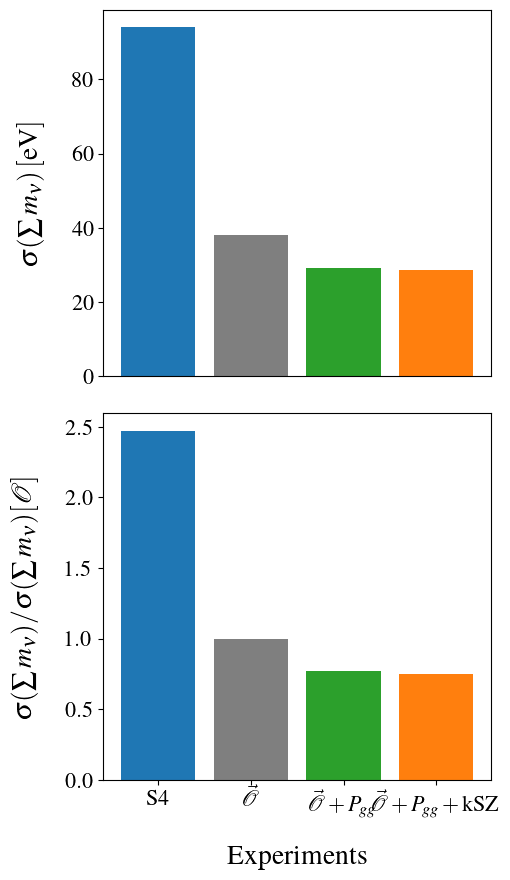

In [1422]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat


fig, (ax1,ax2) = plt.subplots(2,1, figsize=(5,10))

experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
exp_colors = ['tab:blue', 'tab:gray', 'tab:green', 'tab:orange' ]


mnu_constraints = np.array([94, 38, 29.15, 28.6 ])
ax1.bar(experiments, mnu_constraints, color=exp_colors )
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_xlabel(r'Experiments', labelpad=xpad_base, fontsize=xfontsize_base)
#ax1.set_xticks([])
ax1.set_ylabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.set_xticks([])


mnu_ratios = mnu_constraints/mnu_constraints[1]
ax2.bar(experiments, mnu_ratios, color=exp_colors )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'Experiments', labelpad=xpad_base, fontsize=xfontsize_base)
ax2.set_ylabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\cal{O}]$', labelpad=xpad_base, fontsize=xfontsize_base)
#ax2.hlines(1,0,3.5,colors='k')
#ax2.set_xticks([])
plt.subplots_adjust(hspace=0.1)

Text(0, 0.5, '$\\sigma(\\sum m_{\\nu}) / \\sigma(\\sum m_{\\nu}) [\\cal{O}]$')

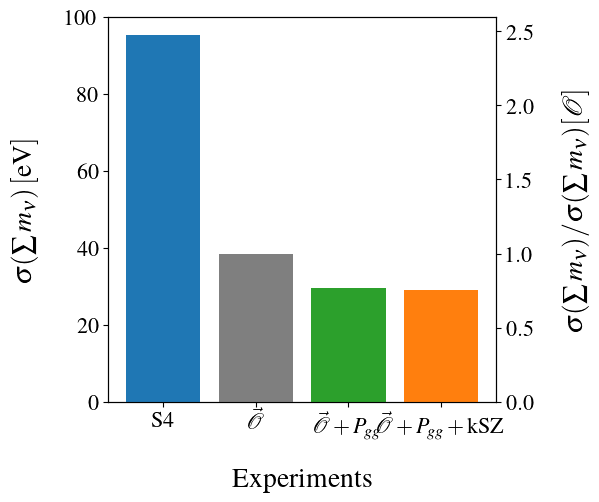

In [1430]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat


fig, ax1 = plt.subplots(1,1, figsize=(5,5))

experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
exp_colors = ['tab:blue', 'tab:gray', 'tab:green', 'tab:orange' ]


mnu_constraints = np.array([94, 38, 29.15, 28.6 ])
ax1.bar(experiments, mnu_constraints, color=exp_colors )
#ax1.set_yticks(y_pos, labels=experiments)
ax1.set_xlabel(r'Experiments', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_ylabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)

ax1.set_ylim(0,100)


mnu_ratios = mnu_constraints/mnu_constraints[1]
ax2=ax1.twinx()

ax2.bar(experiments, mnu_ratios, color=exp_colors )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_ylabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\cal{O}]$', labelpad=xpad_base, fontsize=xfontsize_base)


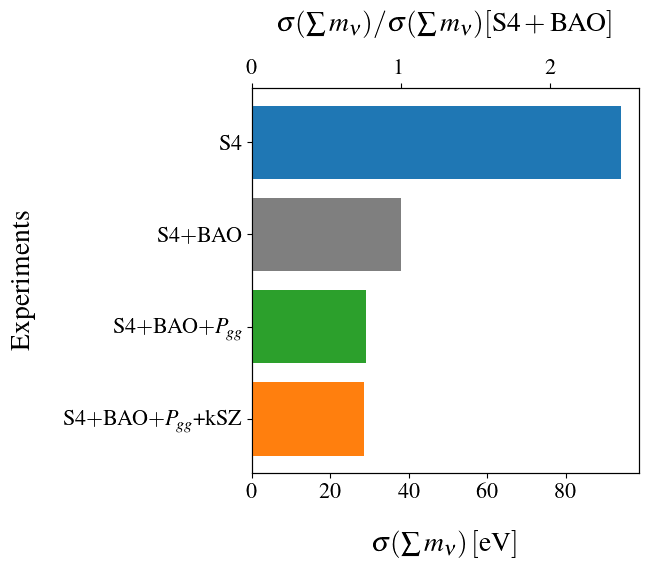

In [1443]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat


fig, ax1 = plt.subplots(1,1, figsize=(5,5))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4', r'S4$+$BAO', r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:blue', 'tab:gray', 'tab:green', 'tab:orange' ]


mnu_constraints = np.array([94, 38, 29.15, 28.6 ])
ax1.barh(experiments, mnu_constraints, color=exp_colors )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
ax1.set_ylabel(r'Experiments', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)



mnu_ratios = mnu_constraints/mnu_constraints[1]
ax2=ax1.twiny()

ax2.barh(experiments, mnu_ratios, color=exp_colors )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO}]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_baseline_withS4alone.pdf', bbox_inches='tight')


## paper figs

In [ ]:
#GALI_F_BAO_S4_withlensing.sigmas()['mnu']
#GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu']

#F_Pgg_BAO_S4_lensing.sigmas()['mnu']
#F_Pgggvvv_BAO_S4_lensing.sigmas()['mnu']

#F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu']
#F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu']

### baseline

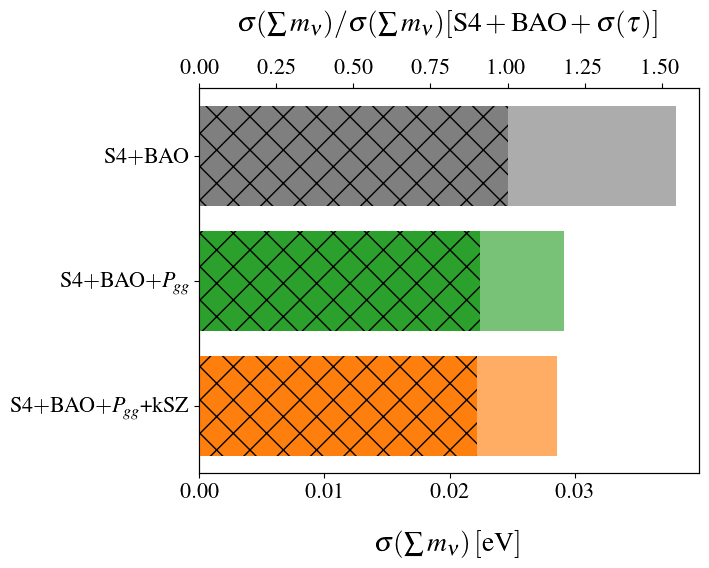

In [1571]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.4


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO', r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:green', 'tab:orange' ]

#
mnu_constraints = np.array([GALI_F_BAO_S4_withlensing.sigmas()['mnu'] , F_Pgg_BAO_S4_lensing.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing.sigmas()['mnu']])
mnu_constraints_tau = np.array([GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)


#
#mnu_ratios = mnu_constraints/mnu_constraints[0]
mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
ax2.barh(experiments, mnu_ratios, color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_baseline.pdf', bbox_inches='tight')


In [1721]:
GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu']/GALI_F_BAO_S4_withlensing.sigmas()['mnu']

0.6472560156220809

In [1722]:
F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] / F_Pgg_BAO_S4_lensing.sigmas()['mnu']

0.768852345836811

In [1723]:
F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] /GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu']

0.9096443302931196

In [1724]:
F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] 

0.022406665377047087

In [1677]:
for key in F_Pgg_BAO_S4_lensing.keys():
    print(key, ' ', F_Pgggvvv_BAO_S4_lensing.sigmas()[key]/F_Pgg_BAO_S4_lensing.sigmas()[key])

As   0.977163819195297
H0   0.9952310607529985
b1_0.2   0.8659158380105898
b1_0.7   0.9330682834561546
b1_1.3   0.979404651224397
b1_1.9   0.9922513938497503
b1_2.6   0.9967400417246939
bk2_0.2   0.9196408069409152
bk2_0.7   0.9575776658501978
bk2_1.3   0.9845060547016528
bk2_1.9   0.992571653548678
bk2_2.6   0.9960426191166605
brsd_0.2   0.5601358182709059
brsd_0.7   0.6915104200870772
brsd_1.3   0.8735904501236025
brsd_1.9   0.9442034965124853
brsd_2.6   0.9741557129217949
mnu   0.9803365224964243
ns   0.996264061138703
ombh2   0.9999139764961682
omch2   0.9846514604712004
tau   0.9780978005355949


In [1679]:
for key in F_Pgg_BAO_S4_lensing.keys():
    print(key, ' ', 1- F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()[key]/F_Pgg_BAO_S4_lensing_tauprior.sigmas()[key])

As   0.011424127742109214
H0   0.0018742118713510614
b1_0.2   0.13481335399636896
b1_0.7   0.07021316904085306
b1_1.3   0.022443386230648454
b1_1.9   0.008480798400841372
b1_2.6   0.0031889847690379503
bk2_0.2   0.08158636471571734
bk2_0.7   0.048027425621459785
bk2_1.3   0.017868617049156987
bk2_1.9   0.007550985314500713
bk2_2.6   0.0031510567212623686
brsd_0.2   0.4394050081722667
brsd_0.7   0.30512793407704064
brsd_1.3   0.12288221166846647
brsd_1.9   0.05348018063720661
brsd_2.6   0.024125836120102218
mnu   0.00878224461267052
ns   0.0002487496698352354
ombh2   0.00026661803138894324
omch2   0.0052185220154657985
tau   0.010472316957313654


#### baseline with Pvv

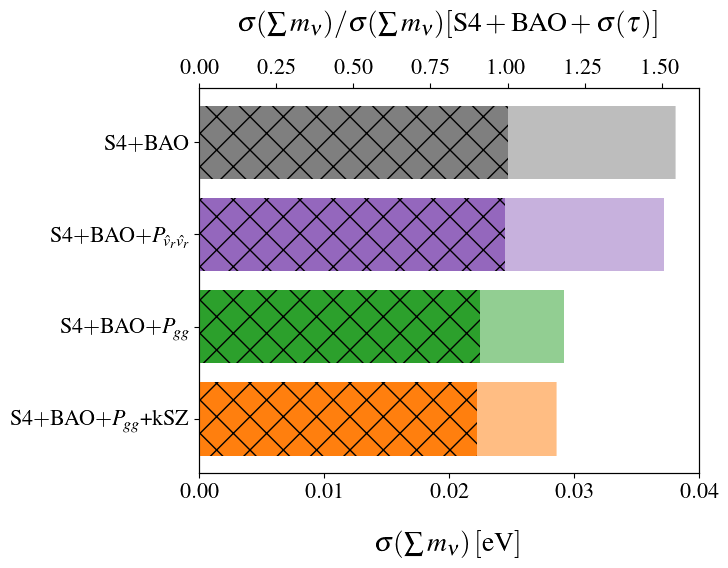

In [2464]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.3


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO',  r'S4$+$BAO$+P_{\hat{v}_r \hat{v}_r}$' , r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:purple' , 'tab:green', 'tab:orange' ]

#
mnu_constraints = np.array([GALI_F_BAO_S4_withlensing.sigmas()['mnu'] , GALI_F_BAO_S4_withlensing_Pvv_fk.sigmas()['mnu'] ,  F_Pgg_BAO_S4_lensing.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing.sigmas()['mnu']])
mnu_constraints_tau = np.array([GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu'], GALI_F_BAO_S4_withlensing_Pvv_fk_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.set_xticks([0,0.01,0.02,0.03,0.04])


#
#mnu_ratios = mnu_constraints/mnu_constraints[0]
mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
ax2.barh(experiments, mnu_ratios, color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_baseline_withPvv.pdf', bbox_inches='tight')


##### baseline w/ Pvv, no lensing

In [2576]:
F_BAO_S4_nolensing = {}
F_BAO_S4_nolensing = F_S4_nolensing_Fisher.copy() + F_BAO_GALI_LCDMmnu  

F_BAO_S4_nolensing_tauprior = {}
F_BAO_S4_nolensing_tauprior = F_BAO_S4_nolensing.copy()
F_BAO_S4_nolensing_tauprior.add_prior('tau', tau_prior_planck)


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [2578]:
#F_Pvv_BAO_S4_nolensing = {}
F_Pvv_BAO_S4_nolensing = F_BAO_S4_nolensing.copy() + Fisher_each_Pvv_summnu_sumz.copy()

F_Pvv_BAO_S4_nolensing_tauprior = F_Pvv_BAO_S4_nolensing.copy()
F_Pvv_BAO_S4_nolensing_tauprior.add_prior('tau', tau_prior_planck)

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats 

In [2577]:
Fisher_each_Pvv_summnu_sumz.sigmas()['mnu']

2.8946772785324306

In [2581]:
F_BAO_S4_nolensing.sigmas()['mnu']

0.052533730256057856

In [2582]:
F_BAO_S4_nolensing_tauprior.sigmas()['mnu']

0.030288052351332685

In [2583]:
F_BAO_S4_nolensing.sigmas()['mnu']

0.052533730256057856

In [2584]:
F_Pgg_BAO_S4_nolensing.sigmas()['mnu']

0.032906342489583615

In [2585]:
 F_Pgg_BAO_S4_nolensing_tauprior.sigmas()['mnu']

0.025581328527912207

In [2590]:
F_Pvv_BAO_S4_nolensing_tauprior.sigmas()['mnu']

0.029879626879740072

In [2593]:
1-29.9/30.3

0.01320132013201325

In [2594]:
F_Pgggvvv_BAO_S4_nolensing_tauprior.sigmas()['mnu'] 

0.025234735854779398

In [2589]:
25.6/30.3

0.8448844884488449

In [2588]:
32.9*0.25

8.225

In [2587]:
25.6/32.9

0.778115501519757

In [2596]:
1-25.2/25.6

0.01562500000000011

In [2603]:
1-56.5/57.8

0.02249134948096876

In [2604]:
#No BAO
test = F_S4_nolensing_Fisher.copy() + F_gg_dict['b_ofz_nonlin']
#test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)


0.06870234520400373


In [2605]:
#No BAO
test = F_S4_nolensing_Fisher.copy() + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
#test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.06599669925410659


In [2606]:
1-66/68.7

0.039301310043668214

In [2580]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.3


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO',  r'S4$+$BAO$+P_{\hat{v}_r \hat{v}_r}$' , r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:purple' , 'tab:green', 'tab:orange' ]

#
mnu_constraints = np.array([F_BAO_S4_nolensing.sigmas()['mnu'] , F_Pvv_BAO_S4_nolensing.sigmas()['mnu'] ,  F_Pgg_BAO_S4_nolensing.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_nolensing.sigmas()['mnu']])
mnu_constraints_tau = np.array([F_BAO_S4_nolensing_tauprior.sigmas()['mnu'], F_Pvv_BAO_S4_nolensing_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_nolensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_nolensing_tauprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.set_xticks([0,0.01,0.02,0.03,0.04, 0.05])


#
#mnu_ratios = mnu_constraints/mnu_constraints[0]
mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
ax2.barh(experiments, mnu_ratios, color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_baseline_withPvv_09012025.pdf', bbox_inches='tight')


In [1864]:
GALI_F_BAO_S4_withlensing.sigmas()['mnu']

0.03805655885326647

In [1865]:
GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu']

0.024632336651652483

In [1728]:
GALI_F_BAO_S4_withlensing_Pvv_fk_tauprior.sigmas()['mnu']/GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu']

0.9921361432622688

In [1730]:
F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu'] / F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.9912177553873295

#### Baseline w/ Pvv UNLENSEND & no lensing

In [2778]:
F_S4_nolensing_UNLENSED_Fisher.sigmas()['mnu']

0.3567209372804015

In [2780]:
F_S4_nolensing_UNLENSED_Fisher_tauprior = F_S4_nolensing_UNLENSED_Fisher.copy()
F_S4_nolensing_UNLENSED_Fisher_tauprior.add_prior('tau',tau_prior_planck)
print(F_S4_nolensing_UNLENSED_Fisher_tauprior.sigmas()['mnu'])

0.3503943258570429


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [2770]:
F_BAO_S4_nolensing_UNLENSED = {}
F_BAO_S4_nolensing_UNLENSED = F_S4_nolensing_UNLENSED_Fisher.copy() + F_BAO_GALI_LCDMmnu  

F_BAO_S4_nolensing_UNLENSED_tauprior = {}
F_BAO_S4_nolensing_UNLENSED_tauprior = F_BAO_S4_nolensing_UNLENSED.copy()
F_BAO_S4_nolensing_UNLENSED_tauprior.add_prior('tau', tau_prior_planck)


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [2776]:
F_BAO_S4_nolensing_UNLENSED.sigmas()['mnu']

0.048731716074621984

In [2777]:
F_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu']

0.04862895673697953

In [2771]:
#F_Pvv_BAO_S4_nolensing = {}
F_Pvv_BAO_S4_nolensing_UNLENSED = F_BAO_S4_nolensing_UNLENSED.copy() + Fisher_each_Pvv_summnu_sumz.copy()

F_Pvv_BAO_S4_nolensing_UNLENSED_tauprior = F_Pvv_BAO_S4_nolensing_UNLENSED.copy()
F_Pvv_BAO_S4_nolensing_UNLENSED_tauprior.add_prior('tau', tau_prior_planck)

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats 

In [2768]:
F_Pgg_BAO_S4_nolensing_UNLENSED = F_S4_nolensing_UNLENSED_Fisher + F_gg_dict['b_ofz_nonlin'] + F_BAO_GALI_LCDMmnu
F_Pgg_BAO_S4_nolensing_UNLENSED_tauprior = F_Pgg_BAO_S4_nolensing_UNLENSED.copy()
F_Pgg_BAO_S4_nolensing_UNLENSED_tauprior.add_prior('tau',tau_prior_planck)

F_Pgggvvv_BAO_S4_nolensing_UNLENSED = F_S4_nolensing_UNLENSED_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'] + F_BAO_GALI_LCDMmnu
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_tauprior = F_Pgggvvv_BAO_S4_nolensing_UNLENSED.copy()
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_tauprior.add_prior('tau',tau_prior_planck)

/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.

0.6

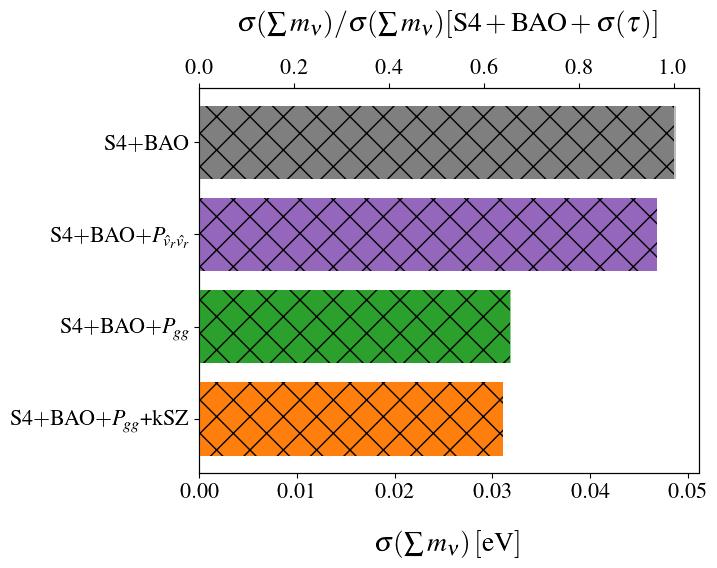

In [2775]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.3


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO',  r'S4$+$BAO$+P_{\hat{v}_r \hat{v}_r}$' , r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:purple' , 'tab:green', 'tab:orange' ]

#
mnu_constraints = np.array([F_BAO_S4_nolensing_UNLENSED.sigmas()['mnu'] , F_Pvv_BAO_S4_nolensing_UNLENSED.sigmas()['mnu'] ,  F_Pgg_BAO_S4_nolensing_UNLENSED.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_nolensing_UNLENSED.sigmas()['mnu']])
mnu_constraints_tau = np.array([F_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu'], F_Pvv_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.set_xticks([0,0.01,0.02,0.03,0.04, 0.05])


#
#mnu_ratios = mnu_constraints/mnu_constraints[0]
mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
ax2.barh(experiments, mnu_ratios, color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.subplots_adjust(left=0.0, right=1)


#plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_baseline_withPvv_21012025_nolensing_UNLENSED.pdf', bbox_inches='tight')


In [2845]:
1 - F_Pgggvvv_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu'] / F_Pgggvvv_BAO_S4_nolensing_UNLENSED.sigmas()['mnu']

0.0003571394392317684

In [2846]:
1 - F_Pgg_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu'] / F_Pgg_BAO_S4_nolensing_UNLENSED.sigmas()['mnu']

0.001209714360377312

In [2839]:
1 - F_Pgggvvv_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu'] / F_Pgg_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu']

0.024898850308777143

In [2844]:
1 - F_Pgggvvv_BAO_S4_nolensing_UNLENSED.sigmas()['mnu'] / F_Pgg_BAO_S4_nolensing_UNLENSED.sigmas()['mnu']

0.025730494107383928

In [2786]:
F_Pgg_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu']

0.03182252158680123

In [2787]:
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu']

0.03103017738536364

In [2788]:
1 - 31.03/31.82

0.0248271527341295

In [2781]:
F_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu']

0.04862895673697953

In [2782]:
F_Pvv_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu']

0.04687005157605214

In [2784]:
F_Pvv_BAO_S4_nolensing_UNLENSED.sigmas()['mnu']

0.046870089074998976

In [2783]:
1-46.9 / 48.6

0.034979423868312765

In [2840]:
test = F_S4_nolensing_UNLENSED_Fisher.copy() + F_gg_dict['b_ofz_nonlin'] 
#test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)


0.07135493407384906


In [2841]:
test = F_S4_nolensing_UNLENSED_Fisher.copy() + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'] 
#test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.06754477649828453


In [2795]:
1 - 66.7/69.6

0.04166666666666652

In [2842]:
1 - 67.5/71.4

0.054621848739495826

#### BASELINE 1.4muK' w/ Pvv UNLENSED no lensing

In [ ]:
F_S4_nolensing_UNLENSED_1p4_Fisher

In [2972]:
F_S4_nolensing_UNLENSED_1p4_Fisher_tauprior = F_S4_nolensing_UNLENSED_1p4_Fisher.copy()
F_S4_nolensing_UNLENSED_1p4_Fisher_tauprior.add_prior('tau',tau_prior_planck)
print(F_S4_nolensing_UNLENSED_1p4_Fisher_tauprior.sigmas()['mnu'])

F_BAO_S4_nolensing_UNLENSED_1p4 = {}
F_BAO_S4_nolensing_UNLENSED_1p4 = F_S4_nolensing_UNLENSED_1p4_Fisher.copy() + F_BAO_GALI_LCDMmnu  

F_BAO_S4_nolensing_UNLENSED_1p4_tauprior = {}
F_BAO_S4_nolensing_UNLENSED_1p4_tauprior = F_BAO_S4_nolensing_UNLENSED_1p4.copy()
F_BAO_S4_nolensing_UNLENSED_1p4_tauprior.add_prior('tau', tau_prior_planck)

#F_Pvv_BAO_S4_nolensing = {}
F_Pvv_BAO_S4_nolensing_UNLENSED_1p4 = F_BAO_S4_nolensing_UNLENSED_1p4.copy() + Fisher_each_Pvv_summnu_sumz.copy()

F_Pvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior = F_Pvv_BAO_S4_nolensing_UNLENSED_1p4.copy()
F_Pvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior.add_prior('tau', tau_prior_planck)

F_Pgg_BAO_S4_nolensing_UNLENSED_1p4 = F_S4_nolensing_UNLENSED_1p4_Fisher + F_gg_dict['b_ofz_nonlin'] + F_BAO_GALI_LCDMmnu
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior = F_Pgg_BAO_S4_nolensing_UNLENSED_1p4.copy()
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior.add_prior('tau',tau_prior_planck)

F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4 = F_S4_nolensing_UNLENSED_1p4_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'] + F_BAO_GALI_LCDMmnu
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior = F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4.copy()
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior.add_prior('tau',tau_prior_planck)

0.3516235091789464


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.

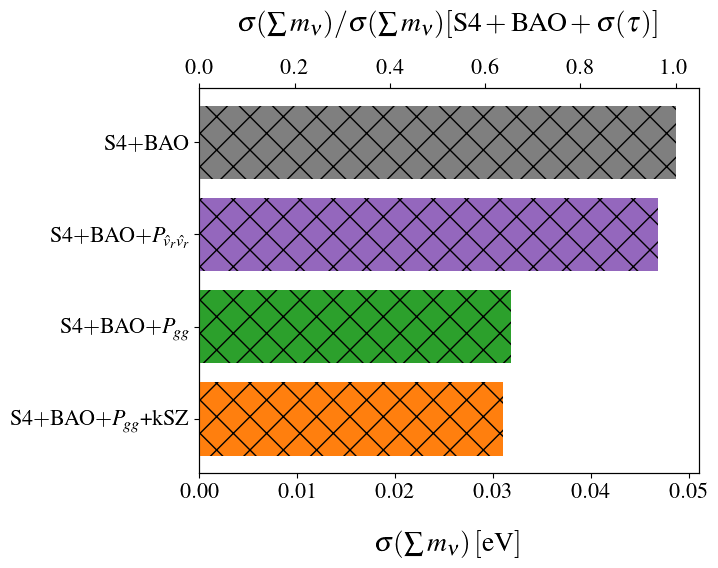

In [2977]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.3


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO',  r'S4$+$BAO$+P_{\hat{v}_r \hat{v}_r}$' , r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:purple' , 'tab:green', 'tab:orange' ]

#
mnu_constraints = np.array([F_BAO_S4_nolensing_UNLENSED_1p4.sigmas()['mnu'] , F_Pvv_BAO_S4_nolensing_UNLENSED_1p4.sigmas()['mnu'] ,  F_Pgg_BAO_S4_nolensing_UNLENSED_1p4.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4.sigmas()['mnu']])
mnu_constraints_tau = np.array([F_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'], F_Pvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] ])
#
#ax1.barh(experiments, mnu_constraints, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.set_xticks([0,0.01,0.02,0.03,0.04, 0.05])


#
#mnu_ratios = mnu_constraints/mnu_constraints[0]
mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
#ax2.barh(experiments, mnu_ratios, color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_baseline_withPvv_24012025_nolensing_UNLENSED_1p4.pdf', bbox_inches='tight')


In [2976]:
F_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.048644347223637634

In [2978]:
F_Pvv_BAO_S4_nolensing_UNLENSED_1p4.sigmas()['mnu'] 

0.046883899747862536

In [2980]:
1 - F_Pvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']  / F_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.036190807670848923

In [2983]:
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.03182686375706815

In [2984]:
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.031034252515441015

In [2988]:
test = F_S4_nolensing_UNLENSED_1p4_Fisher.copy() + F_gg_dict['b_ofz_nonlin'] 
test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)


0.06960643824637064


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [2989]:
test = F_S4_nolensing_UNLENSED_1p4_Fisher.copy() + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'] 
test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.06675941863798099


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [2990]:
1- 0.06675941863798099 / 0.06960643824637064

0.040901670594215456

In [2991]:
F_S4_nolensing_UNLENSED_1p4_Fisher.sigmas()['mnu']

0.3579822447142909

In [2992]:
test = F_S4_nolensing_UNLENSED_1p4_Fisher.copy() + F_gg_dict['b_ofz_nonlin'] 
#test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.07137090648021825


In [2993]:
test = F_S4_nolensing_UNLENSED_1p4_Fisher.copy() + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'] 
#test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.06755968940961285


In [2994]:
1 - 0.06755968940961285 / 0.07137090648021825

0.053400149424496224

#### Baseline w/ Pvv unlensed no lensing, CLUSTER 1.4 muK'

In [ ]:
#f_cluster_S4unlensed_Fisher

In [3191]:
F_S4_cluster_nolensing_UNLENSED_1p4_Fisher_tauprior = f_cluster_S4unlensed_Fisher.copy()
F_S4_cluster_nolensing_UNLENSED_1p4_Fisher_tauprior.add_prior('tau',tau_prior_planck)
print(F_S4_cluster_nolensing_UNLENSED_1p4_Fisher_tauprior.sigmas()['mnu'])

F_BAO_S4_cluster_nolensing_UNLENSED_1p4 = {}
F_BAO_S4_cluster_nolensing_UNLENSED_1p4 = f_cluster_S4unlensed_Fisher.copy() + F_BAO_GALI_LCDMmnu  

F_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior = {}
F_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior = F_BAO_S4_cluster_nolensing_UNLENSED_1p4.copy()
F_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.add_prior('tau', tau_prior_planck)

#F_Pvv_BAO_S4_nolensing = {}
F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4 = F_BAO_S4_cluster_nolensing_UNLENSED_1p4.copy() + Fisher_each_Pvv_summnu_sumz.copy()

F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior = F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4.copy()
F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.add_prior('tau', tau_prior_planck)

F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4 = f_cluster_S4unlensed_Fisher + F_gg_dict['b_ofz_nonlin'] + F_BAO_GALI_LCDMmnu
F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior = F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4.copy()
F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.add_prior('tau',tau_prior_planck)

F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4 = f_cluster_S4unlensed_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'] + F_BAO_GALI_LCDMmnu
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior = F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4.copy()
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.add_prior('tau',tau_prior_planck)

0.3524287869575521


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.

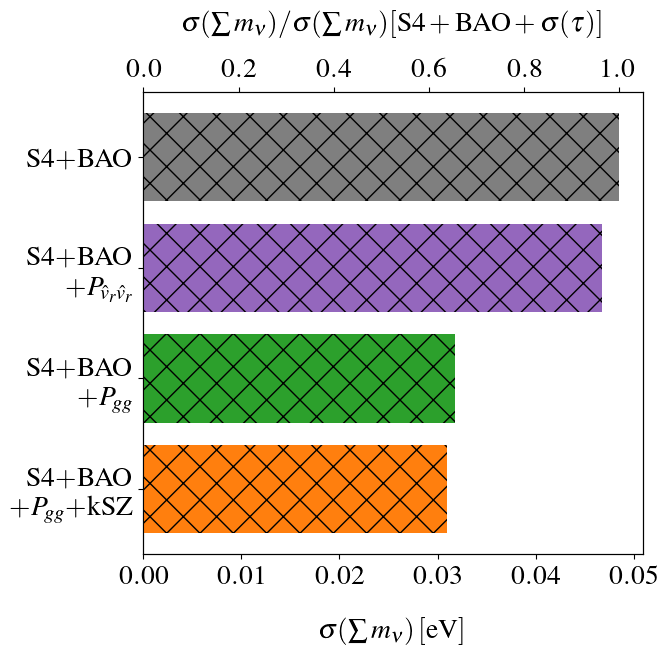

In [3641]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.3


figsize_x = 5
figsize_y = 1.2*figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO',  r'S4$+$BAO'+'\n' +r'$+P_{\hat{v}_r \hat{v}_r}$' , r'S4$+$BAO'+'\n' r'$+P_{gg}$', r'S4$+$BAO' +'\n' r'$+P_{gg}+$kSZ' ]
exp_colors = ['tab:gray', 'tab:purple' , 'tab:green', 'tab:orange' ]

#
mnu_constraints = np.array([F_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu'] , F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu'] ,  F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu']])
mnu_constraints_tau = np.array([F_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'], F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] ])
#
#ax1.barh(experiments, mnu_constraints, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.set_xticks([0,0.01,0.02,0.03,0.04, 0.05])
ax1.tick_params( labelsize=20)


#
#mnu_ratios = mnu_constraints/mnu_constraints[0]
mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
#ax2.barh(experiments, mnu_ratios, color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)
ax2.tick_params( labelsize=20)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_baseline_withPvv_28012025_nolensing_UNLENSED_1p4.pdf', bbox_inches='tight')


In [3201]:
F_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.04855093380671697

In [3207]:
F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.04679892502110638

In [3208]:
1-F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']/F_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.036085995638835744

In [3209]:
F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.03179478541669215

In [3210]:
1 - F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']/F_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.3451251515929983

In [3211]:
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.031004035838904175

In [3212]:
1 - F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] / F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.024870417190261507

In [3213]:
test = f_cluster_S4unlensed_Fisher.copy() + F_gg_dict['b_ofz_nonlin'] 
test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.06964769351434304


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [3214]:
test = f_cluster_S4unlensed_Fisher.copy() + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'] 
test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.06679907101207701


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [3215]:
1 - 0.06679907101207701 / 0.06964769351434304

0.040900457122523215

In [3370]:
test = f_cluster_S4unlensed_Fisher.copy() + F_gg_dict['b_ofz_nonlin'] 
#test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.07143311900987863


In [3371]:
test = f_cluster_S4unlensed_Fisher.copy() + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'] 
#test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])
del(test)

0.06760993942451403


In [3372]:
1 - 0.06760993942451403 / 0.07143311900987863

0.05352110671292243

In [3373]:
0.07143311900987863 - 0.06760993942451403

0.0038231795853646

### Pgg and kSZ alone (with \tau prior)

In [ ]:
# F_Pgg_base
# F_Pgg_base_tauprior

# F_Pgggvvv_base
# F_Pgggvvv_base_tauprior

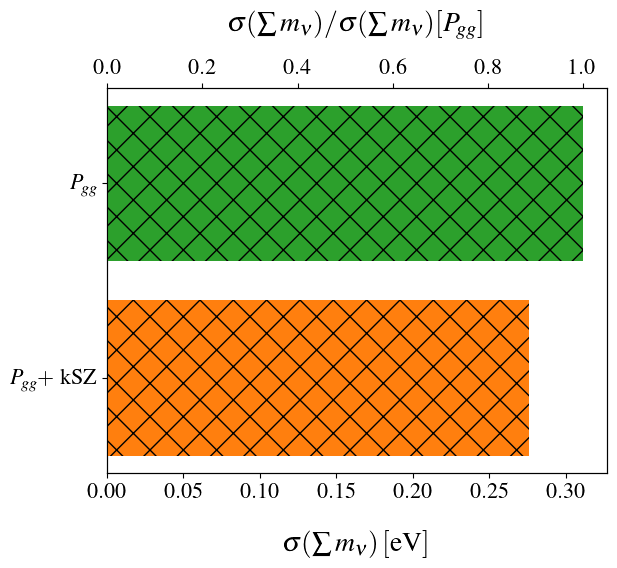

In [1705]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.4


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

experiments = [ r'$P_{gg}$', r'$P_{gg}+$ kSZ' ] #[ r'$P_{vv}$' , r'$P_{gg}$', r'$P_{gg}$+kSZ' ]
exp_colors = [ 'tab:green', 'tab:orange' ] #[ 'tab:purple' , 'tab:green', 'tab:orange' ]

#
#mnu_constraints = np.array([GALI_F_BAO_S4_withlensing.sigmas()['mnu'] , GALI_F_BAO_S4_withlensing_Pvv_fk.sigmas()['mnu'] ,  F_Pgg_BAO_S4_lensing.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing.sigmas()['mnu']])
mnu_constraints_tau = np.array([ F_Pgg_base_tauprior.sigmas()['mnu'] , F_Pgggvvv_base_tauprior.sigmas()['mnu'] ])
#
#ax1.barh(experiments, mnu_constraints, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)


#
#mnu_ratios = mnu_constraints/mnu_constraints[0]
#mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
#ax2.barh(experiments, mnu_ratios, color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [P_{gg}]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_PggkSZ_only.pdf', bbox_inches='tight')


In [1706]:
F_Pgg_base_tauprior.sigmas()['mnu']

0.31149269448614325

In [1707]:
 F_Pgggvvv_base_tauprior.sigmas()['mnu']

0.27633944685854017

### gal bias

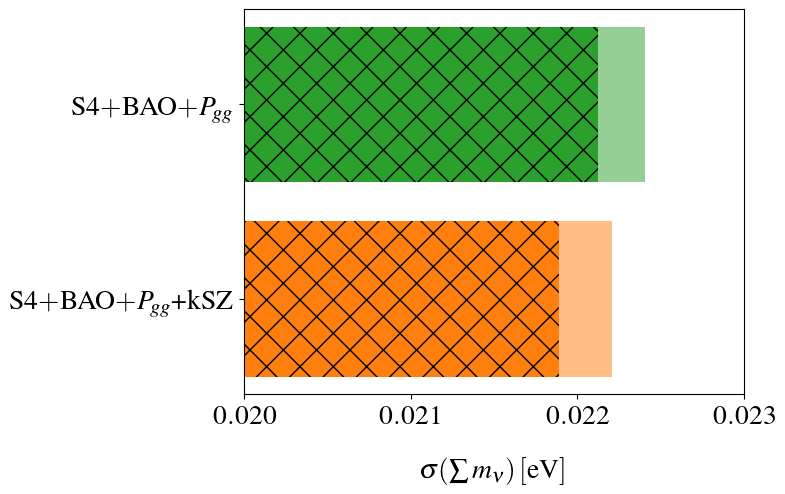

In [2468]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.5


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ] #[r'S4$+$BAO', r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:green', 'tab:orange' ]  #['tab:gray', 'tab:green', 'tab:orange' ]

#
mnu_constraints_mq_tau = np.array([ F_Pgg_BAO_S4_lensing_mq_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing_mq_tauprior.sigmas()['mnu']])
mnu_constraints_tau = np.array([ F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu'] ]) #np.array([GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_mq_tau, color=exp_colors, hatch='x' )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.set_xlim(0.02,0.023)
ax1.set_xticks([0.02,0.021,0.022,0.023])
ax1.tick_params(axis='both', which='major', labelsize=20)

#
#mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
mnu_ratios_mq_tau = mnu_constraints_mq_tau/mnu_constraints_tau[0]
#
#ax2=ax1.twiny()
#ax2.barh(experiments, mnu_ratios_tau, color=exp_colors , alpha = alpha_default)
#ax2.barh(experiments, mnu_ratios_mq_tau, color=exp_colors,  hatch ='x' )
#ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_bias_compare.pdf', bbox_inches='tight')


In [1801]:
F_Pgg_BAO_S4_lensing_mq_tauprior.sigmas()['mnu']  / F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.9874786371541199

#### gal bias with Pgg and kSZ only

In [1761]:
F_gg_GALIbias = F_gg_dict['mq_nonlin'].copy()
print(F_gg_GALIbias.sigmas()['mnu'])

F_gggvvv_GALIbias = F_gggvvv_dict['mq_nonlin_S4_lmax6500_Nvv'].copy()
print(F_gggvvv_GALIbias.sigmas()['mnu'])

0.1704974888289124
0.13632947397868536


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [1763]:
F_gg_GALIbias = F_gg_dict['mq_nonlin'].copy()
F_gg_GALIbias_tauprior = F_gg_GALIbias.copy()
F_gg_GALIbias_tauprior.add_prior('tau', tau_prior_planck)
print(F_gg_GALIbias.sigmas()['mnu'])
print(F_gg_GALIbias_tauprior.sigmas()['mnu'])

F_gggvvv_GALIbias = F_gggvvv_dict['mq_nonlin_S4_lmax6500_Nvv'].copy()
F_gggvvv_GALIbias_tauprior = F_gggvvv_GALIbias.copy()
F_gggvvv_GALIbias_tauprior.add_prior('tau', tau_prior_planck)
print(F_gggvvv_GALIbias.sigmas()['mnu'])
print(F_gggvvv_GALIbias_tauprior.sigmas()['mnu'])

0.1704974888289124
0.16783478863876905
0.13632947397868536
0.13632846245325886


In [1764]:
F_Pgg_base_tauprior.sigmas()['mnu']

0.31149269448614325

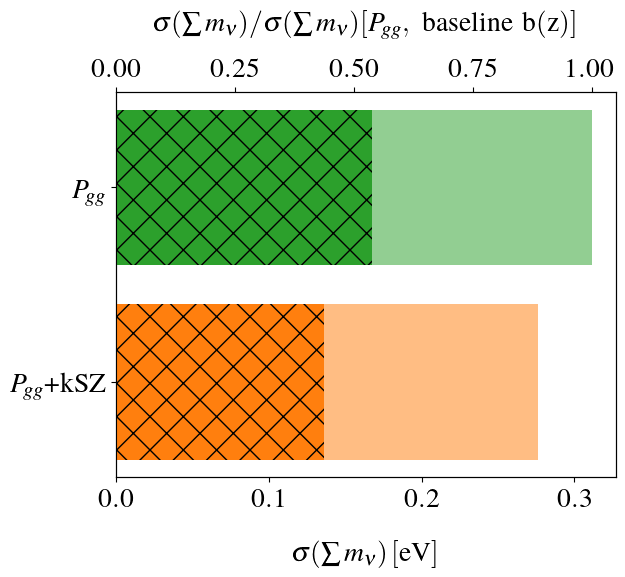

In [2489]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.3


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'$P_{gg}$', r'$P_{gg}$+kSZ' ] #[r'S4$+$BAO', r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:green', 'tab:orange' ]  #['tab:gray', 'tab:green', 'tab:orange' ]

#
mnu_constraints_tau = np.array([ F_Pgg_base_tauprior.sigmas()['mnu'] , F_Pgggvvv_base_tauprior.sigmas()['mnu']])
mnu_constraints_mq_tau = np.array([ F_gg_GALIbias_tauprior.sigmas()['mnu'] , F_gggvvv_GALIbias_tauprior.sigmas()['mnu'] ]) #np.array([GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints_mq_tau, color=exp_colors, hatch='x' )
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors, alpha = alpha_default )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.tick_params(axis='both', which='major', labelsize=20)


#
#mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
mnu_ratios_mq_tau = mnu_constraints_mq_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
ax2.barh(experiments, mnu_ratios_tau, color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios_mq_tau, color=exp_colors,  hatch ='x' )
#ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [P_{gg}+\sigma(\tau)\rm{,\,\,\, baseline\,\,\,} b(z)]$', labelpad=xpad_base, fontsize=xfontsize_base)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [P_{gg} \rm{,\,\,\, baseline\,\,\,} b(z)]$', labelpad=xpad_base, fontsize=xfontsize_base)
ax2.tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_bias_compare_PggkSZ_only.pdf', bbox_inches='tight')


In [1784]:
F_gg_GALIbias_tauprior.sigmas()['mnu'] / F_Pgg_base_tauprior.sigmas()['mnu']

0.5388081056463916

In [1785]:
F_gggvvv_GALIbias_tauprior.sigmas()['mnu'] /F_Pgggvvv_base_tauprior.sigmas()['mnu']

0.4933369593196234

In [1786]:
F_Pgggvvv_base_tauprior.sigmas()['mnu'] / F_Pgg_base_tauprior.sigmas()['mnu']

0.8871458360023693

In [1787]:
F_gggvvv_GALIbias_tauprior.sigmas()['mnu']  / F_gg_GALIbias_tauprior.sigmas()['mnu']

0.8122777378811417

In [1778]:
mnu_ratios_mq_tau

array([0.53880811, 0.43766183])

#### same but w/o lensing

In [2608]:
F_S4_nolensing_Fisher.sigmas()['mnu']

0.23738807635143103

In [2609]:
F_Pgg_BAO_S4_nolensing_mq = F_S4_nolensing_Fisher.copy() + F_BAO_GALI_LCDMmnu.copy() + F_gg_dict['mq_nonlin']
print(F_Pgg_BAO_S4_nolensing_mq.sigmas()['mnu'])
F_Pgg_BAO_S4_nolensing_mq_tauprior = F_Pgg_BAO_S4_nolensing_mq.copy()
F_Pgg_BAO_S4_nolensing_mq_tauprior.add_prior('tau',tau_prior_planck)
print(F_Pgg_BAO_S4_nolensing_mq_tauprior.sigmas()['mnu'])

F_Pgggvvv_BAO_S4_nolensing_mq = F_S4_nolensing_Fisher.copy() + F_BAO_GALI_LCDMmnu.copy() + F_gggvvv_dict['mq_nonlin_S4_lmax6500_Nvv']
print(F_Pgggvvv_BAO_S4_nolensing_mq.sigmas()['mnu'])
F_Pgggvvv_BAO_S4_nolensing_mq_tauprior = F_Pgggvvv_BAO_S4_nolensing_mq.copy()
F_Pgggvvv_BAO_S4_nolensing_mq_tauprior.add_prior('tau',tau_prior_planck)
print(F_Pgggvvv_BAO_S4_nolensing_mq_tauprior.sigmas()['mnu'])

0.03173182511080313
0.025074502565548936
0.0306625794722358
0.02465332034494848


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats 

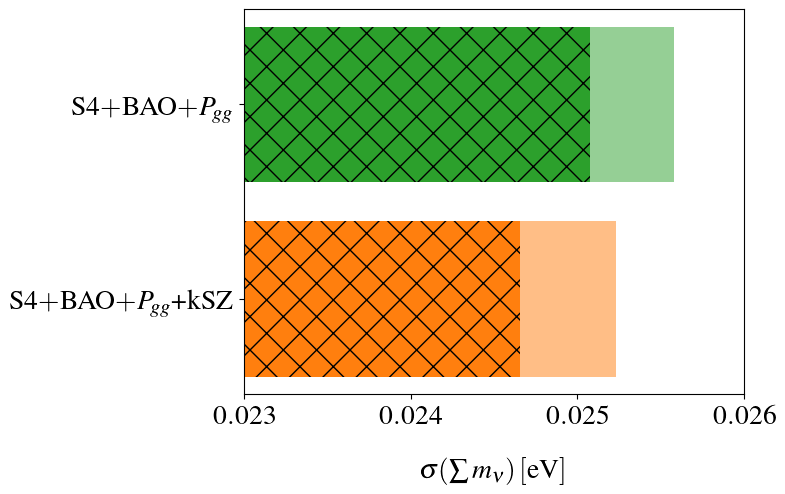

In [2671]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.5


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ] #[r'S4$+$BAO', r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:green', 'tab:orange' ]  #['tab:gray', 'tab:green', 'tab:orange' ]

#
mnu_constraints_mq_tau = np.array([ F_Pgg_BAO_S4_nolensing_mq_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_nolensing_mq_tauprior.sigmas()['mnu']])
mnu_constraints_tau = np.array([ F_Pgg_BAO_S4_nolensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_nolensing_tauprior.sigmas()['mnu'] ]) #np.array([GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_mq_tau, color=exp_colors, hatch='x' )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.set_xlim(0.023,0.026)
ax1.set_xticks([0.023, 0.024, 0.025, 0.026])
ax1.tick_params(axis='both', which='major', labelsize=20)

#
#mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
mnu_ratios_mq_tau = mnu_constraints_mq_tau/mnu_constraints_tau[0]
#
#ax2=ax1.twiny()
#ax2.barh(experiments, mnu_ratios_tau, color=exp_colors , alpha = alpha_default)
#ax2.barh(experiments, mnu_ratios_mq_tau, color=exp_colors,  hatch ='x' )
#ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_bias_compare_nolensing.pdf', bbox_inches='tight')


In [3054]:
1 - F_Pgg_BAO_S4_nolensing_mq_tauprior.sigmas()['mnu']/ F_Pgg_BAO_S4_nolensing_tauprior.sigmas()['mnu']

0.019812339371282683

In [3055]:
1 - F_Pgggvvv_BAO_S4_nolensing_mq_tauprior.sigmas()['mnu']/ F_Pgggvvv_BAO_S4_nolensing_tauprior.sigmas()['mnu']

0.023040285152055584

In [3060]:
1 -  F_Pgggvvv_BAO_S4_nolensing_mq_tauprior.sigmas()['mnu']/F_Pgg_BAO_S4_nolensing_mq_tauprior.sigmas()['mnu']

0.016797231350828112

In [3061]:
1 -  F_Pgggvvv_BAO_S4_nolensing_tauprior.sigmas()['mnu']/F_Pgg_BAO_S4_nolensing_tauprior.sigmas()['mnu']

0.01354865806733363

In [3058]:
F_Pgg_BAO_S4_nolensing_tauprior.sigmas()['mnu']

0.025581328527912207

In [3059]:
1-25.2/25.6

0.01562500000000011

#### unlensed, no lensing

In [3038]:
F_S4_nolensing_UNLENSED_1p4_Fisher.sigmas()

{'omch2': 0.0007901378675371653,
 'ombh2': 3.089390596470613e-05,
 'As': 5.722567333976653e-10,
 'ns': 0.0027141525648785242,
 'tau': 0.13036155261597226,
 'H0': 3.3669123787215023,
 'mnu': 0.3579822447142909}

In [3039]:
F_Pgg_BAO_S4_nolensing_UNLENSED_mq = F_S4_nolensing_UNLENSED_1p4_Fisher.copy() + F_BAO_GALI_LCDMmnu.copy() + F_gg_dict['mq_nonlin']
print(F_Pgg_BAO_S4_nolensing_UNLENSED_mq.sigmas()['mnu'])
F_Pgg_BAO_S4_nolensing_UNLENSED_mq_tauprior = F_Pgg_BAO_S4_nolensing_UNLENSED_mq.copy()
F_Pgg_BAO_S4_nolensing_UNLENSED_mq_tauprior.add_prior('tau',tau_prior_planck)
print(F_Pgg_BAO_S4_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu'])

F_Pgggvvv_BAO_S4_nolensing_UNLENSED_mq = F_S4_nolensing_UNLENSED_1p4_Fisher.copy() + F_BAO_GALI_LCDMmnu.copy() + F_gggvvv_dict['mq_nonlin_S4_lmax6500_Nvv']
print(F_Pgggvvv_BAO_S4_nolensing_UNLENSED_mq.sigmas()['mnu'])
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_mq_tauprior = F_Pgggvvv_BAO_S4_nolensing_UNLENSED_mq.copy()
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_mq_tauprior.add_prior('tau',tau_prior_planck)
print(F_Pgggvvv_BAO_S4_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu'])

0.030500781328180716
0.030396651383232248
0.029536039900254732
0.029458291408419195


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats 

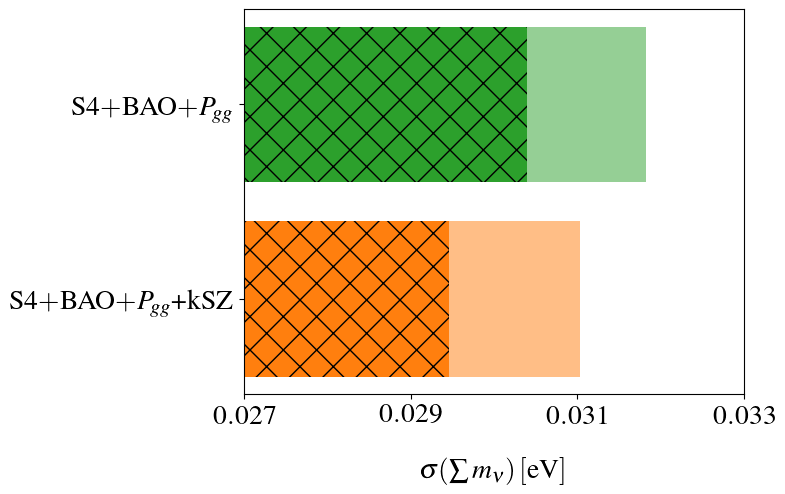

In [3053]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.5


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ] #[r'S4$+$BAO', r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:green', 'tab:orange' ]  #['tab:gray', 'tab:green', 'tab:orange' ]

#
mnu_constraints_mq_tau = np.array([ F_Pgg_BAO_S4_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu']])
mnu_constraints_tau = np.array([ F_Pgg_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu'] ]) #np.array([GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_mq_tau, color=exp_colors, hatch='x' )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.set_xlim(0.027,0.033)
ax1.set_xticks([0.027, 0.029, 0.031, 0.033])
ax1.tick_params(axis='both', which='major', labelsize=20)

#
#mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
mnu_ratios_mq_tau = mnu_constraints_mq_tau/mnu_constraints_tau[0]
#
#ax2=ax1.twiny()
#ax2.barh(experiments, mnu_ratios_tau, color=exp_colors , alpha = alpha_default)
#ax2.barh(experiments, mnu_ratios_mq_tau, color=exp_colors,  hatch ='x' )
#ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_bias_compare_nolensing_UNLENSED.pdf', bbox_inches='tight')


In [3044]:
1 - F_Pgggvvv_BAO_S4_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu'] / F_Pgg_BAO_S4_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu']

0.030870504878398597

In [3046]:
1 - F_Pgg_BAO_S4_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu'] / F_Pgg_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu'] 

0.044806952198294114

In [3045]:
1 - F_Pgggvvv_BAO_S4_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu'] / F_Pgggvvv_BAO_S4_nolensing_UNLENSED_tauprior.sigmas()['mnu'] 

0.050656686793091765

#### cluster unlensed, no lensing

In [3229]:
F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_mq = f_cluster_S4unlensed_Fisher.copy() + F_BAO_GALI_LCDMmnu.copy() + F_gg_dict['mq_nonlin']
print(F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_mq.sigmas()['mnu'])
F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior = F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_mq.copy()
F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior.add_prior('tau',tau_prior_planck)
print(F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu'])

F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_mq = f_cluster_S4unlensed_Fisher.copy() + F_BAO_GALI_LCDMmnu.copy() + F_gggvvv_dict['mq_nonlin_S4_lmax6500_Nvv']
print(F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_mq.sigmas()['mnu'])
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior = F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_mq.copy()
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior.add_prior('tau',tau_prior_planck)
print(F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu'])

0.030470090922259396
0.03036714919237897
0.02950770265490602
0.0294307649533641


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats 

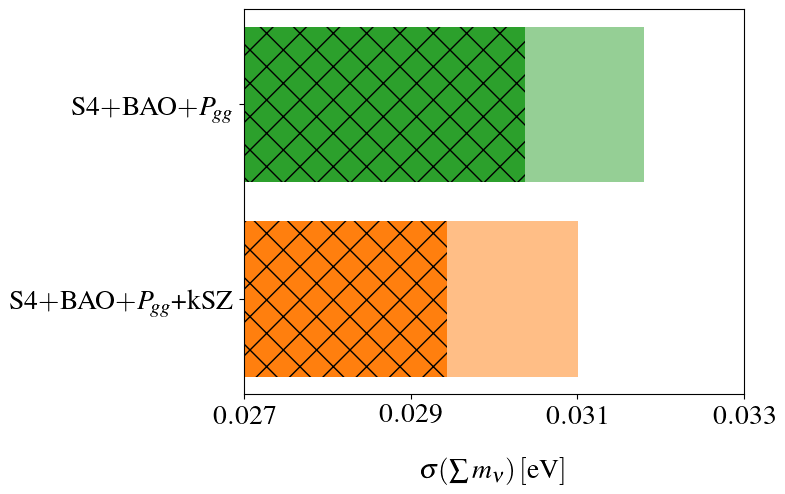

In [3443]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.5


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ] #[r'S4$+$BAO', r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:green', 'tab:orange' ]  #['tab:gray', 'tab:green', 'tab:orange' ]

#
mnu_constraints_mq_tau = np.array([ F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu']])
mnu_constraints_tau = np.array([ F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] ]) #np.array([GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_mq_tau, color=exp_colors, hatch='x' )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.set_xlim(0.027,0.033)
ax1.set_xticks([0.027, 0.029, 0.031, 0.033])
ax1.tick_params(axis='both', which='major', labelsize=20)

#
#mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
mnu_ratios_mq_tau = mnu_constraints_mq_tau/mnu_constraints_tau[0]
#
#ax2=ax1.twiny()
#ax2.barh(experiments, mnu_ratios_tau, color=exp_colors , alpha = alpha_default)
#ax2.barh(experiments, mnu_ratios_mq_tau, color=exp_colors,  hatch ='x' )
#ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_bias_compare_nolensing_UNLENSED_01282025.pdf', bbox_inches='tight')


In [3232]:
1 - F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu'] / F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu']

0.03083543447173065

In [3233]:
1 - F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu']/ F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] 

0.04490158387933885

In [3234]:
1 - F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu']/ F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] 

0.05074406744059812

##### add no bv

In [ ]:
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_nobv.sigmas()['mnu']

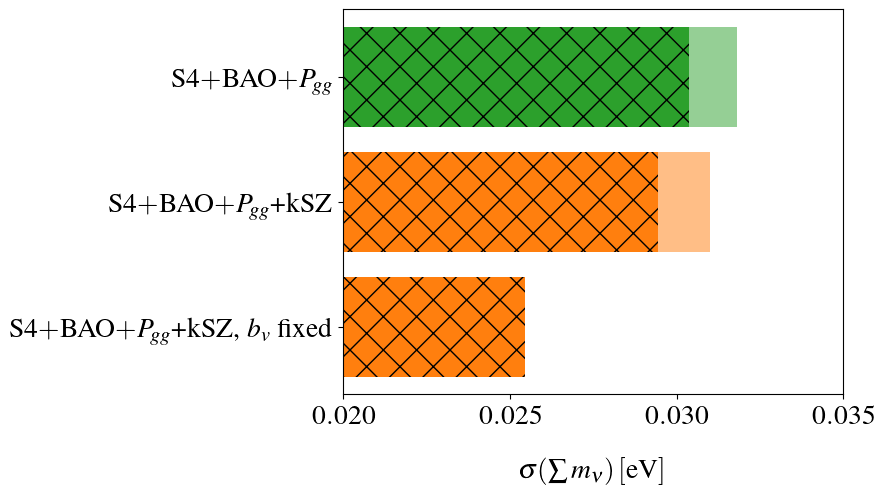

In [3482]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.5


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments_mq = [r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ', r'S4$+$BAO$+P_{gg}$+kSZ, $b_v$ fixed' ] #[r'S4$+$BAO', r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors_mq = ['tab:green', 'tab:orange', 'tab:orange' ]  #['tab:gray', 'tab:green', 'tab:orange' ]

experiments = [r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ] #[r'S4$+$BAO', r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_color = ['tab:green', 'tab:orange' ]  #['tab:gray', 'tab:green', 'tab:orange' ]

#
mnu_constraints_mq_tau = np.array([ F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu'], F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_nobv.sigmas()['mnu']])
mnu_constraints_tau = np.array([ F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] ]) #np.array([GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments_mq, mnu_constraints_mq_tau, color=exp_colors_mq, hatch='x' )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.set_xlim(0.02,0.035)
#ax1.set_xticks([0.027, 0.029, 0.031, 0.033])
ax1.tick_params(axis='both', which='major', labelsize=20)

#
#mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
#mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#mnu_ratios_mq_tau = mnu_constraints_mq_tau/mnu_constraints_tau[0]
#
#ax2=ax1.twiny()
#ax2.barh(experiments, mnu_ratios_tau, color=exp_colors , alpha = alpha_default)
#ax2.barh(experiments, mnu_ratios_mq_tau, color=exp_colors,  hatch ='x' )
#ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_bias_compare_nolensing_UNLENSED_01282025_nobv_1.pdf', bbox_inches='tight')


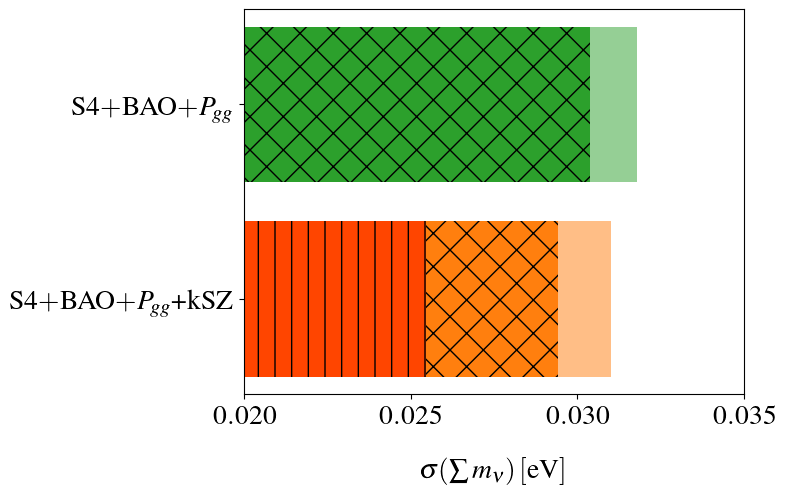

In [3492]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.5


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ', r'S4$+$BAO$+P_{gg}$+kSZ, $b_v$ fixed' ] #[r'S4$+$BAO', r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:green', 'tab:orange', 'tab:orange' ]  #['tab:gray', 'tab:green', 'tab:orange' ]

experiments_mq = [r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ] #[r'S4$+$BAO', r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors_mq = ['tab:green', 'tab:orange' ]  #['tab:gray', 'tab:green', 'tab:orange' ]

experiments_bv = [ r'S4$+$BAO$+P_{gg}$+kSZ' ] #[r'S4$+$BAO', r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors_bv = [ 'orangered' ]  #['tab:gray', 'tab:green', 'tab:orange' ]

#
mnu_constraints_mq_tau = np.array([ F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu']])
mnu_constraints_tau = np.array([ F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']]) #np.array([GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu'] ])
mnu_constraints_bv = np.array([ F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_nobv.sigmas()['mnu'] ])
#
ax1.barh(experiments_mq, mnu_constraints_tau, color=exp_colors_mq, alpha = alpha_default )
ax1.barh(experiments_mq, mnu_constraints_mq_tau, color=exp_colors_mq, hatch='x' )
ax1.barh(experiments_bv, mnu_constraints_bv, color=exp_colors_bv, hatch='|' )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.set_xlim(0.02,0.035)
#ax1.set_xticks([0.027, 0.029, 0.031, 0.033])
ax1.tick_params(axis='both', which='major', labelsize=20)

#
#mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
#mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#mnu_ratios_mq_tau = mnu_constraints_mq_tau/mnu_constraints_tau[0]
#
#ax2=ax1.twiny()
#ax2.barh(experiments, mnu_ratios_tau, color=exp_colors , alpha = alpha_default)
#ax2.barh(experiments, mnu_ratios_mq_tau, color=exp_colors,  hatch ='x' )
#ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_bias_compare_nolensing_UNLENSED_01282025_nobv_2.pdf', bbox_inches='tight')


##### bv 1% prior

In [3497]:
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bv0p01 = F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.copy()
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bv0p01.add_prior('bv_0.2', 0.01)
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bv0p01.add_prior('bv_0.7', 0.01)
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bv0p01.add_prior('bv_1.3', 0.01)
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bv0p01.add_prior('bv_1.9', 0.01)
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bv0p01.add_prior('bv_2.6', 0.01)

/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [3498]:
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_nobv.sigmas()['mnu']

0.02544744280487128

In [3499]:
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bv0p01.sigmas()['mnu']

0.026510124773814432

In [3500]:
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.031004035838904175

In [3505]:
1 - F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bv0p01.sigmas()['mnu'] / F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.14494600278621594

In [3504]:
1 - F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bv0p01.sigmas()['mnu'] / F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.1662115524171235

In [3625]:
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bv0p01.sigmas()['mnu']

0.026510124773814432

In [3627]:
test = f_cluster_S4unlensed_Fisher.copy() +F_BAO_GALI_LCDMmnu+F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_fz']
test.add_prior('tau',tau_prior_planck)
test.add_prior('bv_0.2',0.01)
test.add_prior('bv_0.7',0.01)
test.add_prior('bv_1.3',0.01)
test.add_prior('bv_1.9',0.01)
test.add_prior('bv_2.6',0.01)
test.sigmas()['mnu']

/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


0.027456078338542272

In [3628]:
F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.03179478541669215

In [3629]:
1 - 0.027456078338542272 / 0.03179478541669215

0.1364597062470525

In [3630]:
1 - 0.0265/0.0318

0.16666666666666674

In [3568]:
import colorsys

def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

tabgreen_conv = matplotlib.colors.ColorConverter.to_rgb("tab:green")
lighter_tabgreen = scale_lightness(tabgreen_conv,1.6)

taborange_conv = matplotlib.colors.ColorConverter.to_rgb("tab:orange")
lighter_taborange = scale_lightness(taborange_conv,1.35)

In [3554]:
np.array(lighter_taborange)

array([1.        , 0.77817916, 0.58235294])

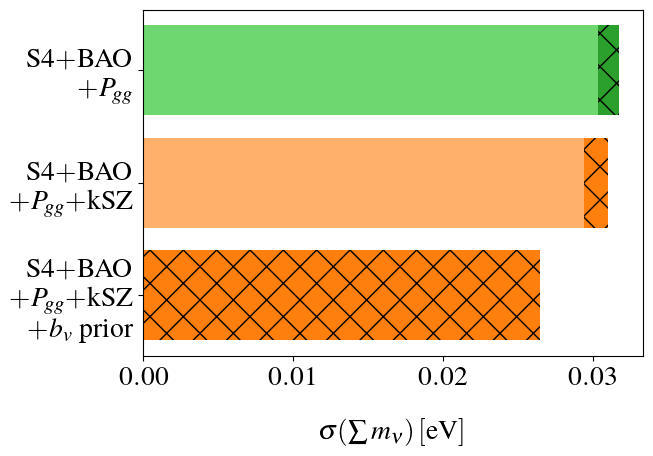

In [3640]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.5


figsize_x = 5
figsize_y = 1.2*(3./4.)*figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO'+'\n'+r'$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ', r'S4$+$BAO$+P_{gg}$+kSZ, $b_v$ fixed' ] #[r'S4$+$BAO', r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
#exp_colors = ['tab:green', 'tab:orange', 'tab:orange' ]  #['tab:gray', 'tab:green', 'tab:orange' ]
exp_colors = ['tab:green', 'tab:orange'] 

experiments_mq = [r'S4$+$BAO'+'\n' +r'$+P_{gg}$', r'S4$+$BAO'+'\n' +r'$+P_{gg}+$kSZ' ] #[r'S4$+$BAO', r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
#exp_colors_mq = ['tab:green', 'tab:orange' ]  #['tab:gray', 'tab:green', 'tab:orange' ]
exp_colors_mq = [lighter_tabgreen, lighter_taborange ] 

#experiments_bv = [ r'S4$+$BAO$+P_{gg}$'+'\n'+r'$+$kSZ $+b_v$ prior' ]
experiments_bv = [ r'S4$+$BAO' +'\n'+r'$+P_{gg}+$kSZ' + '\n' +r'$+b_v$ prior' ] 
exp_colors_bv = [ 'tab:orange' ]  #['tab:gray', 'tab:green', 'tab:orange' ]

#
mnu_constraints_mq_tau = np.array([ F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_mq_tauprior.sigmas()['mnu']])
mnu_constraints_tau = np.array([ F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']]) #np.array([GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu'] ])
mnu_constraints_bv = np.array([ F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bv0p01.sigmas()['mnu'] ])
#
ax1.barh(experiments_mq, mnu_constraints_tau, color=exp_colors,hatch='x')
ax1.barh(experiments_mq, mnu_constraints_mq_tau, color=exp_colors_mq ,alpha=1.)
ax1.barh(experiments_bv, mnu_constraints_bv, color=exp_colors_bv, hatch='x'   )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
#ax1.set_xlim(0.02,0.035)
#ax1.set_xticks([0.027, 0.029, 0.031, 0.033])
ax1.tick_params(axis='both', which='major', labelsize=20)

#
#mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
#mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#mnu_ratios_mq_tau = mnu_constraints_mq_tau/mnu_constraints_tau[0]
#
#ax2=ax1.twiny()
#ax2.barh(experiments, mnu_ratios_tau, color=exp_colors , alpha = alpha_default)
#ax2.barh(experiments, mnu_ratios_mq_tau, color=exp_colors,  hatch ='x' )
#ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.subplots_adjust(left=0.0, right=1)
plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_bias_compare_nolensing_UNLENSED_02062025_bvprior.pdf', bbox_inches='tight')
#plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/bv_prior_ex3.pdf', bbox_inches='tight')


### lensing

In [ ]:
##F_S4_nolensing_BAO_tauprior
#F_Pgg_BAO_S4_nolensing_tauprior
#F_Pgggvvv_BAO_S4_nolensing_tauprior

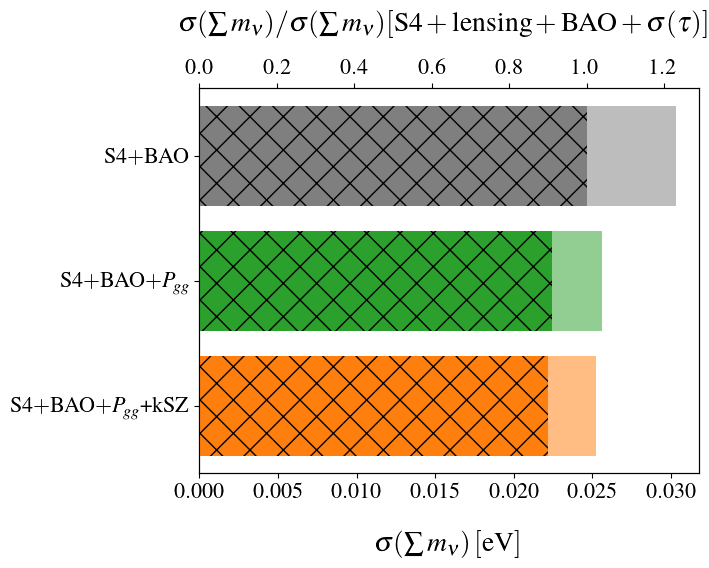

In [2631]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.3


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))


experiments = [r'S4$+$BAO', r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:green', 'tab:orange' ]

#
mnu_constraints_noLensing_tau = np.array([F_S4_nolensing_BAO_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_nolensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_nolensing_tauprior.sigmas()['mnu']])
mnu_constraints_tau = np.array([GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu'] ]) #np.array([GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints_noLensing_tau, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors, hatch='x' )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)


#
#mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
mnu_ratios_noLensing_tau = mnu_constraints_noLensing_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
ax2.barh(experiments, mnu_ratios_noLensing_tau , color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\mathrm{S4+lensing}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)
ax2.xaxis.set_label_coords(.49, 1.15)
plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_lensing_compare.pdf', bbox_inches='tight')


In [2613]:
1- F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu']/F_Pgggvvv_BAO_S4_nolensing_tauprior.sigmas()['mnu']

0.11986855386302342

In [2635]:
F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.022209884560751604

In [2637]:
1-222/224

0.008928571428571397

In [2634]:
F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.022406665377047087

In [2632]:
1- GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu']/F_S4_nolensing_BAO_tauprior.sigmas()['mnu']

0.18673091402760167

In [2633]:
GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu']

0.024632336651652483

In [2615]:
1 - F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu']/F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.00878224461267052

In [2611]:
F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.022406665377047087

In [2282]:
mnu_constraints_noLensing_tau

array([0.03028805, 0.02558133, 0.02523474])

In [2284]:
0.02558133/0.03028805

0.8446014187113399

In [2283]:
mnu_constraints_tau

array([0.02463234, 0.02240667, 0.02220988])

In [2285]:
0.02240667/0.02463234

0.909644394320637

In [1861]:
1/( F_Pgg_BAO_S4_nolensing_tauprior.sigmas()['mnu'] / GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu'])

0.9629029479362551

### lensed spectra NO kappa

In [3314]:
F_BAO_S4_cluster_lensed_nokappa = f_cluster_S4lensed_Fisher.copy() + F_BAO_GALI_LCDMmnu
F_BAO_S4_cluster_lensed_nokappa_tauprior = F_BAO_S4_cluster_lensed_nokappa.copy() 
F_BAO_S4_cluster_lensed_nokappa_tauprior.add_prior('tau', tau_prior_planck)

F_Pgg_BAO_S4_cluster_lensed_nokappa = F_BAO_S4_cluster_lensed_nokappa.copy() + F_gg_dict['b_ofz_nonlin']
F_Pgg_BAO_S4_cluster_lensed_nokappa_tauprior = F_Pgg_BAO_S4_cluster_lensed_nokappa.copy()
F_Pgg_BAO_S4_cluster_lensed_nokappa_tauprior.add_prior('tau',tau_prior_planck)

F_Pgggvvv_BAO_S4_cluster_lensed_nokappa = F_BAO_S4_cluster_lensed_nokappa.copy() + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_tauprior = F_Pgggvvv_BAO_S4_cluster_lensed_nokappa.copy()
F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_tauprior.add_prior('tau',tau_prior_planck)

F_Pvv_BAO_S4_cluster_lensed_nokappa = F_BAO_S4_cluster_lensed_nokappa.copy()  + Fisher_each_Pvv_summnu_sumz.copy()
F_Pvv_BAO_S4_cluster_lensed_nokappa_tauprior = F_Pvv_BAO_S4_cluster_lensed_nokappa.copy()
F_Pvv_BAO_S4_cluster_lensed_nokappa_tauprior.add_prior('tau',tau_prior_planck)



/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.

In [3277]:
print(F_BAO_S4_cluster_lensed_nokappa.sigmas()['mnu'])
print(F_BAO_S4_cluster_lensed_nokappa_tauprior.sigmas()['mnu'])

print(F_Pgg_BAO_S4_cluster_lensed_nokappa.sigmas()['mnu'])
print(F_Pgg_BAO_S4_cluster_lensed_nokappa_tauprior.sigmas()['mnu'])

print(F_Pgggvvv_BAO_S4_cluster_lensed_nokappa.sigmas()['mnu'])
print(F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_tauprior.sigmas()['mnu'])

0.05249196912044423
0.030335337701121113
0.03288072796023359
0.02559598854489354
0.031986208156778266
0.025247798142561784


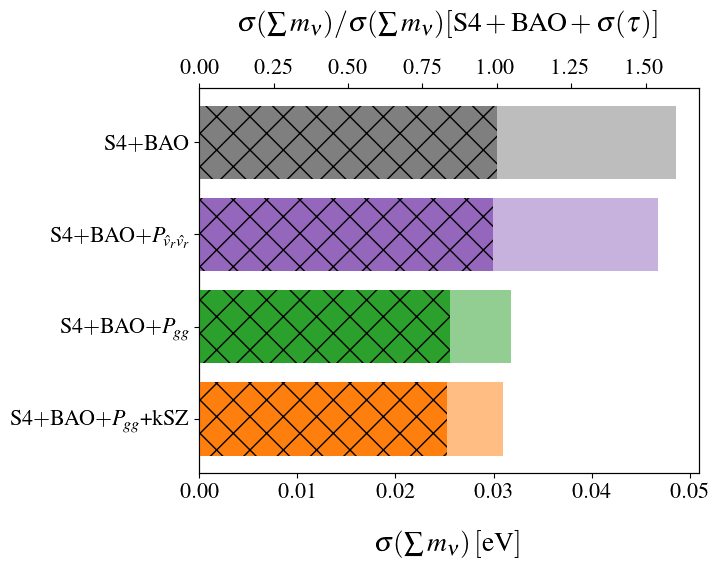

In [3315]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.3


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO',  r'S4$+$BAO$+P_{\hat{v}_r \hat{v}_r}$' , r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:purple' , 'tab:green', 'tab:orange' ]

#
mnu_constraints_lensed_tau = np.array([F_BAO_S4_cluster_lensed_nokappa_tauprior.sigmas()['mnu'] , F_Pvv_BAO_S4_cluster_lensed_nokappa_tauprior.sigmas()['mnu'] ,  F_Pgg_BAO_S4_cluster_lensed_nokappa_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_tauprior.sigmas()['mnu']])
mnu_constraints_unlensed_tau = np.array([F_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'], F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints_unlensed_tau, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_lensed_tau, color=exp_colors )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.set_xticks([0,0.01,0.02,0.03,0.04, 0.05])


#

mnu_ratios_lensing = mnu_constraints_unlensed_tau/mnu_constraints_lensed_tau[0]
mnu_ratios = mnu_constraints_lensed_tau/mnu_constraints_lensed_tau[0]
#
ax2=ax1.twiny()
ax2.barh(experiments, mnu_ratios_lensing, color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_lensed_vs_unlensed_nokappa_01302025.pdf', bbox_inches='tight')


In [3316]:
mnu_constraints_lensed_tau

array([0.03033534, 0.0299239 , 0.02559599, 0.0252478 ])

In [3318]:
mnu_constraints_unlensed_tau

array([0.04855093, 0.04679893, 0.03179479, 0.03100404])

In [3349]:
F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_tauprior_nobv = F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_tauprior.copy()
F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_tauprior_nobv.delete('bv_0.2')
F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_tauprior_nobv.delete('bv_0.7')
F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_tauprior_nobv.delete('bv_1.3')
F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_tauprior_nobv.delete('bv_1.9')
F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_tauprior_nobv.delete('bv_2.6')
F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_tauprior_nobv.sigmas()['mnu']

0.02489043787022854

In [3350]:
F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_tauprior.sigmas()['mnu']

0.025247798142561784

In [3369]:
1 - F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_tauprior_nobv.sigmas()['mnu'] / F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_tauprior.sigmas()['mnu']

0.014154116343746415

#### no bv

In [3368]:
F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_nobv = F_Pgggvvv_BAO_S4_cluster_lensed_nokappa.copy()
F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_nobv.delete('bv_0.2')
F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_nobv.delete('bv_0.7')
F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_nobv.delete('bv_1.3')
F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_nobv.delete('bv_1.9')
F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_nobv.delete('bv_2.6')
print(1 - F_Pgggvvv_BAO_S4_cluster_lensed_nokappa_nobv.sigmas()['mnu'] / F_Pgggvvv_BAO_S4_cluster_lensed_nokappa.sigmas()['mnu'])

0.0031650683152385506


### lensing + kappa

In [ ]:
f_cluster_S4lensed_kappa_Fisher

In [3352]:
F_BAO_S4_cluster_lensed_kappa = f_cluster_S4lensed_kappa_Fisher.copy() + F_BAO_GALI_LCDMmnu
F_BAO_S4_cluster_lensed_kappa_tauprior = F_BAO_S4_cluster_lensed_kappa.copy() 
F_BAO_S4_cluster_lensed_kappa_tauprior.add_prior('tau', tau_prior_planck)

F_Pgg_BAO_S4_cluster_lensed_kappa = F_BAO_S4_cluster_lensed_kappa.copy() + F_gg_dict['b_ofz_nonlin']
F_Pgg_BAO_S4_cluster_lensed_kappa_tauprior = F_Pgg_BAO_S4_cluster_lensed_kappa.copy()
F_Pgg_BAO_S4_cluster_lensed_kappa_tauprior.add_prior('tau',tau_prior_planck)

F_Pgggvvv_BAO_S4_cluster_lensed_kappa = F_BAO_S4_cluster_lensed_kappa.copy() + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior = F_Pgggvvv_BAO_S4_cluster_lensed_kappa.copy()
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior.add_prior('tau',tau_prior_planck)

F_Pvv_BAO_S4_cluster_lensed_kappa = F_BAO_S4_cluster_lensed_kappa.copy()  + Fisher_each_Pvv_summnu_sumz.copy()
F_Pvv_BAO_S4_cluster_lensed_kappa_tauprior = F_Pvv_BAO_S4_cluster_lensed_kappa.copy()
F_Pvv_BAO_S4_cluster_lensed_kappa_tauprior.add_prior('tau',tau_prior_planck)



/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.

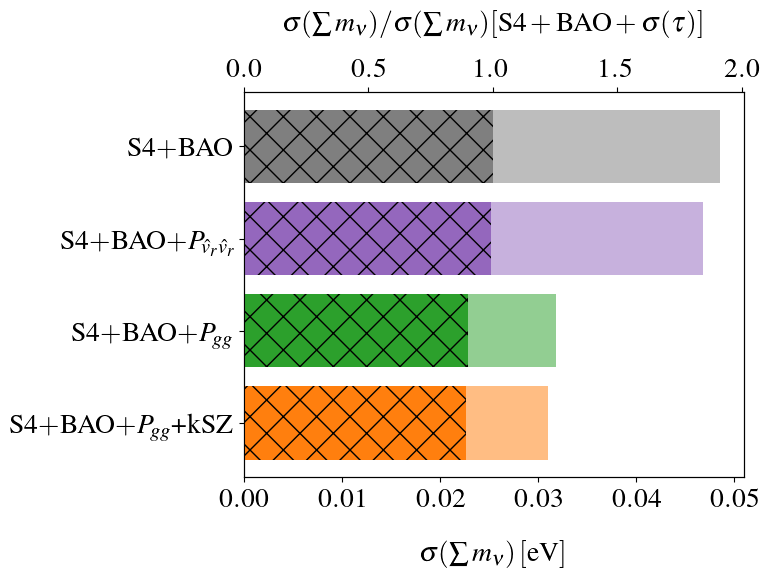

In [3444]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.3


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO',  r'S4$+$BAO$+P_{\hat{v}_r \hat{v}_r}$' , r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:purple' , 'tab:green', 'tab:orange' ]

#
mnu_constraints_lensed_tau = np.array([F_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu'] , F_Pvv_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu'] ,  F_Pgg_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu']])
mnu_constraints_unlensed_tau = np.array([F_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'], F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints_unlensed_tau, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_lensed_tau, color=exp_colors )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
#ax1.set_xticks([0,0.01,0.02,0.03,0.04, 0.05])
ax1.tick_params(axis='both', which='major', labelsize=20)


#

mnu_ratios_lensing = mnu_constraints_unlensed_tau/mnu_constraints_lensed_tau[0]
mnu_ratios = mnu_constraints_lensed_tau/mnu_constraints_lensed_tau[0]
#
ax2=ax1.twiny()
ax2.barh(experiments, mnu_ratios_lensing, color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)
ax2.tick_params(labelsize=20)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_lensed_kappa_vs_unlensed_nokappa_01302025.pdf', bbox_inches='tight')


In [3354]:
mnu_constraints_lensed_tau

array([0.02537537, 0.0251524 , 0.02286345, 0.02264604])

In [3355]:
mnu_constraints_unlensed_tau

array([0.04855093, 0.04679893, 0.03179479, 0.03100404])

In [3358]:
1 - 0.0251524/0.02537537

0.008786866950117544

In [3356]:
1 - 0.02264604 / 0.02286345

0.009509063592764933

In [3357]:
1 -0.02286345/ 0.02537537

0.09899047777431424

In [3360]:
1/mnu_ratios_lensing

array([0.52265467, 0.54222127, 0.79809856, 0.81845385])

#### bv prior

In [ ]:
tabgreen_conv = matplotlib.colors.ColorConverter.to_rgb("tab:green")
lighter_tabgreen = scale_lightness(tabgreen_conv,1.6)

taborange_conv = matplotlib.colors.ColorConverter.to_rgb("tab:orange")
lighter_taborange = scale_lightness(taborange_conv,1.35)

In [3599]:
F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior = F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.copy()
F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.add_prior('bv_0.2', 0.01)
F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.add_prior('bv_0.7', 0.01)
F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.add_prior('bv_1.3', 0.01)
F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.add_prior('bv_1.9', 0.01)
F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.add_prior('bv_2.6', 0.01)

F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior = F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.copy()
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.add_prior('bv_0.2', 0.01)
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.add_prior('bv_0.7', 0.01)
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.add_prior('bv_1.3', 0.01)
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.add_prior('bv_1.9', 0.01)
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.add_prior('bv_2.6', 0.01)

/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.

In [3600]:
F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.sigmas()['mnu']/F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.8655517212457782

In [3601]:
F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.sigmas()['mnu']

0.04050689010447074

In [3631]:

F_Pvv_BAO_S4_cluster_lensed_kappa_tauprior_bvprior = F_Pvv_BAO_S4_cluster_lensed_kappa_tauprior.copy()
F_Pvv_BAO_S4_cluster_lensed_kappa_tauprior_bvprior.add_prior('bv_0.2', 0.01)
F_Pvv_BAO_S4_cluster_lensed_kappa_tauprior_bvprior.add_prior('bv_0.7', 0.01)
F_Pvv_BAO_S4_cluster_lensed_kappa_tauprior_bvprior.add_prior('bv_1.3', 0.01)
F_Pvv_BAO_S4_cluster_lensed_kappa_tauprior_bvprior.add_prior('bv_1.9', 0.01)
F_Pvv_BAO_S4_cluster_lensed_kappa_tauprior_bvprior.add_prior('bv_2.6', 0.01)

F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior_bvprior = F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior.copy()
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior_bvprior.add_prior('bv_0.2', 0.01)
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior_bvprior.add_prior('bv_0.7', 0.01)
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior_bvprior.add_prior('bv_1.3', 0.01)
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior_bvprior.add_prior('bv_1.9', 0.01)
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior_bvprior.add_prior('bv_2.6', 0.01)

/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.

In [3609]:
tabgreen_conv = matplotlib.colors.ColorConverter.to_rgb("tab:green")
lighter_tabgreen = scale_lightness(tabgreen_conv,1.6)

taborange_conv = matplotlib.colors.ColorConverter.to_rgb("tab:orange")
lighter_taborange = scale_lightness(taborange_conv,1.35)

tabgray_conv = matplotlib.colors.ColorConverter.to_rgb("tab:gray")
lighter_tabgray = scale_lightness(tabgray_conv,1.35)

tabpurple_conv = matplotlib.colors.ColorConverter.to_rgb("tab:purple")
lighter_tabpurple = scale_lightness(tabpurple_conv,1.35)

In [3645]:
1 - F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior_bvprior.sigmas()['mnu'] /  F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.sigmas()['mnu']

0.14677634253481153

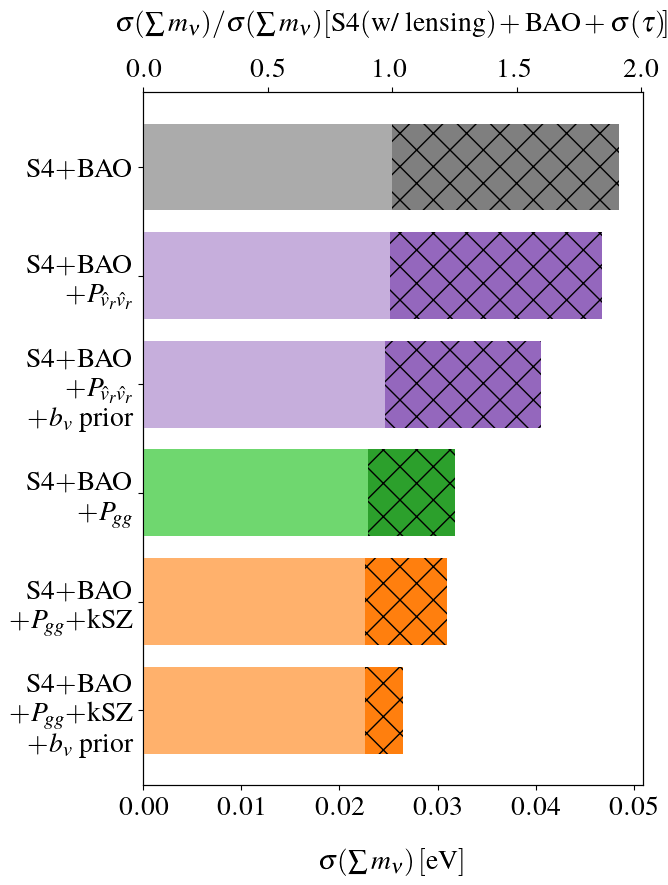

In [3681]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = (10./4.)*(1/golden_rat)

alpha_default = 0.3


figsize_x = 5
figsize_y = 1.2*(6./4.)*figsize_x #figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO',  r'S4$+$BAO'+'\n'+r'$+P_{\hat{v}_r \hat{v}_r}$' , r'S4$+$BAO'+'\n'+r'$+P_{\hat{v}_r \hat{v}_r}$'+'\n'+ r'$+b_v$ prior', r'S4$+$BAO'+'\n'+r'$+P_{gg}$', r'S4$+$BAO'+'\n'+r'$+P_{gg}+$kSZ', r'S4$+$BAO'+'\n'+r'$+P_{gg}+$kSZ'+'\n'+r'$+b_v$ prior' ] 
#experiments =[r'S4$+$BAO',  r'S4$+$BAO'+'\n'+r'$+P_{\hat{v}_r \hat{v}_r}$' , r'S4$+$BAO'+'\n'+r'$+P_{gg}$', r'S4$+$BAO'+'\n'+r'$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:purple' , 'tab:purple', 'tab:green', 'tab:orange', 'tab:orange' ]

#experiments_bv = [r'S4$+$BAO'+'\n'+r'$+P_{\hat{v}_r \hat{v}_r}+b_v$ prior', r'S4$+$BAO$+P_{gg}$'+'\n'+r'$+$kSZ $+b_v$ prior']
experiments_bv = [r'S4$+$BAO'+'\n'+r'$+P_{\hat{v}_r \hat{v}_r}+b_v$ prior', r'S4$+$BAO'+'\n'+r'$+P_{gg}$+kSZ'+'\n'+r'$+b_v$ prior']
exp_colors_bv = [ 'tab:purple' , 'tab:orange' ]

exp_colors_light = [lighter_tabgray,lighter_tabpurple,lighter_tabpurple, lighter_tabgreen,lighter_taborange,lighter_taborange]
#
mnu_constraints_lensed_tau = np.array([F_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu'] , F_Pvv_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu'] , F_Pvv_BAO_S4_cluster_lensed_kappa_tauprior_bvprior.sigmas()['mnu'],  F_Pgg_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu'], F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior_bvprior.sigmas()['mnu'] ])
mnu_constraints_unlensed_tau = np.array([F_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'], F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] ,F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.sigmas()['mnu'], F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'], F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.sigmas()['mnu']  ])
#mnu_constraints_unlensed_tau_bv = np.array([F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.sigmas()['mnu'], F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints_unlensed_tau, color=exp_colors, hatch='x' )
ax1.barh(experiments, mnu_constraints_lensed_tau, color=exp_colors_light )
#ax1.barh(experiments_bv, mnu_constraints_unlensed_tau_bv, color=exp_colors_bv, hatch='x' )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
#ax1.set_xticks([0,0.01,0.02,0.03,0.04, 0.05])
ax1.tick_params(axis='both', which='major', labelsize=20)


#

mnu_ratios_lensing = mnu_constraints_unlensed_tau/mnu_constraints_lensed_tau[0]
mnu_ratios = mnu_constraints_lensed_tau/mnu_constraints_lensed_tau[0]
#
ax2=ax1.twiny()
ax2.barh(experiments, mnu_ratios_lensing, color=exp_colors,  hatch ='x' )
ax2.barh(experiments, mnu_ratios, color=exp_colors_light )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}($w/ lensing$)+\rm{BAO} +\sigma(\tau)\!]$', labelpad=xpad_base, fontsize=xfontsize_base)
ax2.tick_params(labelsize=20)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_lensed_kappa_vs_unlensed_nokappa_bvprior_02062025.pdf', bbox_inches='tight')


In [3646]:
1 - F_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu'] / F_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.4773453276389721

In [3647]:
1 - F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu'] / F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.2695776626615133

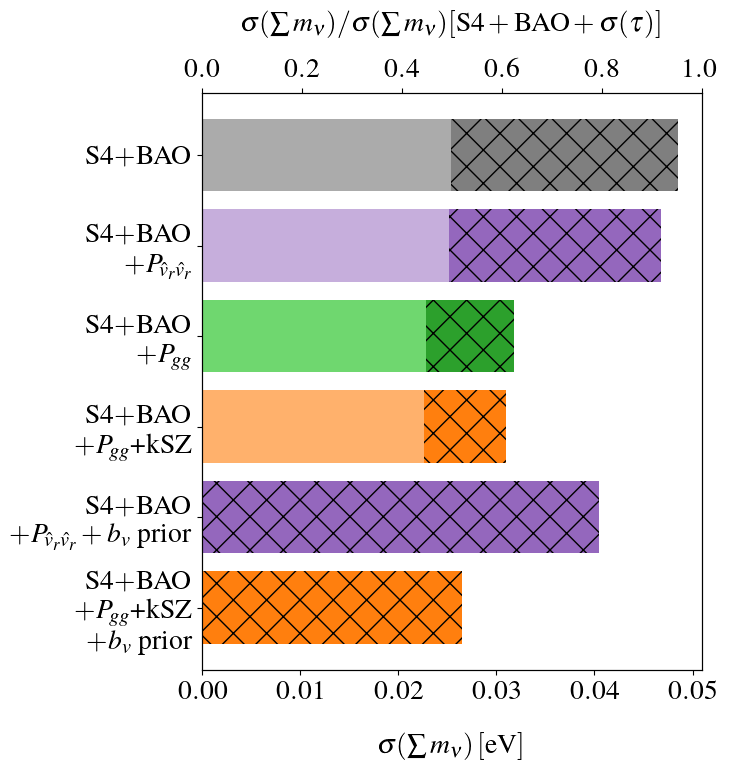

In [3621]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = (10./4.)*(1/golden_rat)

alpha_default = 0.3


figsize_x = 5
figsize_y = (6./4.)*figsize_x #figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO',  r'S4$+$BAO'+'\n'+r'$+P_{\hat{v}_r \hat{v}_r}$' , r'S4$+$BAO'+'\n'+r'$+P_{gg}$', r'S4$+$BAO'+'\n'+r'$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:purple' , 'tab:green', 'tab:orange' ]

#experiments_bv = [r'S4$+$BAO'+'\n'+r'$+P_{\hat{v}_r \hat{v}_r}+b_v$ prior', r'S4$+$BAO$+P_{gg}$'+'\n'+r'$+$kSZ $+b_v$ prior']
experiments_bv = [r'S4$+$BAO'+'\n'+r'$+P_{\hat{v}_r \hat{v}_r}+b_v$ prior', r'S4$+$BAO'+'\n'+r'$+P_{gg}$+kSZ'+'\n'+r'$+b_v$ prior']
exp_colors_bv = [ 'tab:purple' , 'tab:orange' ]

exp_colors_light = [lighter_tabgray,lighter_tabpurple,lighter_tabgreen,lighter_taborange]
#
mnu_constraints_lensed_tau = np.array([F_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu'] , F_Pvv_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu'] ,  F_Pgg_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu']])
mnu_constraints_unlensed_tau = np.array([F_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'], F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] , F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu'] ])
mnu_constraints_unlensed_tau_bv = np.array([F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.sigmas()['mnu'], F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_bvprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints_unlensed_tau, color=exp_colors, hatch='x' )
ax1.barh(experiments, mnu_constraints_lensed_tau, color=exp_colors_light )
ax1.barh(experiments_bv, mnu_constraints_unlensed_tau_bv, color=exp_colors_bv, hatch='x' )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
#ax1.set_xticks([0,0.01,0.02,0.03,0.04, 0.05])
ax1.tick_params(axis='both', which='major', labelsize=20)


#

mnu_ratios_lensing = mnu_constraints_unlensed_tau/mnu_constraints_lensed_tau[0]
mnu_ratios = mnu_constraints_lensed_tau/mnu_constraints_lensed_tau[0]
#
ax2=ax1.twiny()
#ax2.barh(experiments, mnu_ratios_lensing, color=exp_colors , alpha = alpha_default)
#ax2.barh(experiments, mnu_ratios, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)
ax2.tick_params(labelsize=20)

plt.subplots_adjust(left=0.0, right=1)


#plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_lensed_kappa_vs_unlensed_nokappa_bvprior_02062025.pdf', bbox_inches='tight')


#### tau prior effects

In [ ]:
F_BAO_S4_cluster_lensed_kappa
F_BAO_S4_cluster_lensed_kappa_tauprior = F_BAO_S4_cluster_lensed_kappa.copy() 
F_BAO_S4_cluster_lensed_kappa_tauprior.add_prior('tau', tau_prior_planck)

F_Pgg_BAO_S4_cluster_lensed_kappa = F_BAO_S4_cluster_lensed_kappa.copy() + F_gg_dict['b_ofz_nonlin']
F_Pgg_BAO_S4_cluster_lensed_kappa_tauprior = F_Pgg_BAO_S4_cluster_lensed_kappa.copy()
F_Pgg_BAO_S4_cluster_lensed_kappa_tauprior.add_prior('tau',tau_prior_planck)

F_Pgggvvv_BAO_S4_cluster_lensed_kappa = F_BAO_S4_cluster_lensed_kappa.copy() + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior = F_Pgggvvv_BAO_S4_cluster_lensed_kappa.copy()
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior.add_prior('tau',tau_prior_planck)

F_Pvv_BAO_S4_cluster_lensed_kappa = F_BAO_S4_cluster_lensed_kappa.copy()  + Fisher_each_Pvv_summnu_sumz.copy()
F_Pvv_BAO_S4_cluster_lensed_kappa_tauprior = F_Pvv_BAO_S4_cluster_lensed_kappa.copy()
F_Pvv_BAO_S4_cluster_lensed_kappa_tauprior.add_prior('tau',tau_prior_planck)


In [3361]:
print(1 - F_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu']/F_BAO_S4_cluster_lensed_kappa.sigmas()['mnu'])
print(1 - F_Pvv_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu']/F_Pvv_BAO_S4_cluster_lensed_kappa.sigmas()['mnu'])
print(1 - F_Pgg_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu']/F_Pgg_BAO_S4_cluster_lensed_kappa.sigmas()['mnu'])
print(1 - F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu']/F_Pgggvvv_BAO_S4_cluster_lensed_kappa.sigmas()['mnu'])

0.4445652595238927
0.42857617681124793
0.26875030181772364
0.2574928453053804


In [3362]:
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu']/F_Pgggvvv_BAO_S4_cluster_lensed_kappa.sigmas()['mnu']

0.7425071546946196

In [3363]:
F_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu']/F_BAO_S4_cluster_lensed_kappa.sigmas()['mnu']

0.5554347404761073

In [3682]:
1 - 24.6/26.6

0.07518796992481203

In [3683]:
1 - 23.3/24.6

0.05284552845528456

#### bv effect

In [3364]:
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_nobv = F_Pgggvvv_BAO_S4_cluster_lensed_kappa.copy()
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_nobv.delete('bv_0.2')
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_nobv.delete('bv_0.7')
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_nobv.delete('bv_1.3')
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_nobv.delete('bv_1.9')
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_nobv.delete('bv_2.6')

F_Pgggvvv_BAO_S4_cluster_lensed_kappa_nobv_tauprior = F_Pgggvvv_BAO_S4_cluster_lensed_kappa_nobv.copy()
F_Pgggvvv_BAO_S4_cluster_lensed_kappa_nobv_tauprior.add_prior('tau',tau_prior_planck)

/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [3366]:
1 - F_Pgggvvv_BAO_S4_cluster_lensed_kappa_nobv.sigmas()['mnu'] / F_Pgggvvv_BAO_S4_cluster_lensed_kappa.sigmas()['mnu']

0.017783075353731248

In [3367]:
1 - F_Pgggvvv_BAO_S4_cluster_lensed_kappa_nobv_tauprior.sigmas()['mnu'] / F_Pgggvvv_BAO_S4_cluster_lensed_kappa_tauprior.sigmas()['mnu']

0.0018110218627026553

### Planck

In [ ]:
#F_BAO_Planck_withlensing_Pgggvvv.sigmas()['mnu']
#F_BAO_Planck_withlensing_Pgg.sigmas()['mnu']
#F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full.sigmas()['mnu']

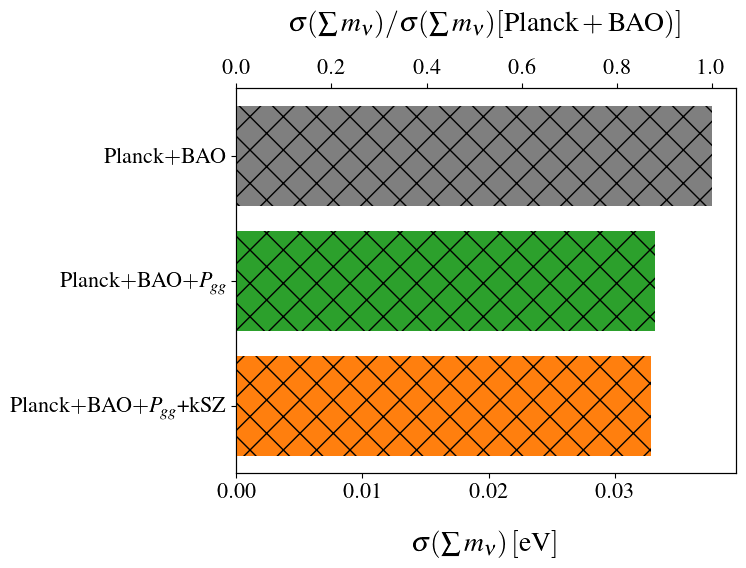

In [1590]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.4


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'Planck$+$BAO', r'Planck$+$BAO$+P_{gg}$', r'Planck$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:green', 'tab:orange' ]

#
mnu_constraints = np.array([F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full.sigmas()['mnu'] , F_BAO_Planck_withlensing_Pgg.sigmas()['mnu'] , F_BAO_Planck_withlensing_Pgggvvv.sigmas()['mnu']])
#
ax1.barh(experiments, mnu_constraints, color=exp_colors, alpha = 1 )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)


#
mnu_ratios = mnu_constraints/mnu_constraints[0]
#mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
ax2.barh(experiments, mnu_ratios, color=exp_colors, hatch='x' )
#ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{Planck}+\rm{BAO})]$', labelpad=xpad_base, fontsize=xfontsize_base)
plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_Planck.pdf', bbox_inches='tight')


In [1866]:
 F_BAO_Planck_withlensing_Pgg.sigmas()['mnu'] 

0.0331831051717124

In [1862]:
F_BAO_Planck_withlensing_Pgg.sigmas()['mnu'] / F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full.sigmas()['mnu'] 

0.880006266094441

In [1863]:
F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full.sigmas()['mnu'] 

0.03770780555800183

#### w/o lensing

In [2638]:
F_Planck.keys()

dict_keys(['BAO_lensing', 'lensing', 'BAO', 'base'])

In [2653]:
F_BAO_Planck_nolensing_Pgggvvv.sigmas()['mnu'] 

0.03344369083063088

In [2652]:
F_BAO_Planck_withlensing_Pgggvvv.sigmas()['mnu'] 

0.03286770184576893

In [2655]:
1-F_BAO_Planck_nolensing_Pgg.sigmas()['mnu'] / F_Planck['BAO'].sigmas()['mnu']

0.14829266231942229

In [2658]:
1-F_BAO_Planck_nolensing_Pgggvvv.sigmas()['mnu'] / F_BAO_Planck_nolensing_Pgg.sigmas()['mnu'] 

0.011180493727958707

In [2656]:
F_BAO_Planck_nolensing_Pgg.sigmas()['mnu']

0.03382183565200619

In [2646]:
F_BAO_Planck_nolensing_Pgg = F_gg_dict['b_ofz_nonlin'].copy() +  F_Planck['BAO'].copy() 
F_BAO_Planck_nolensing_Pgggvvv = F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'].copy() + F_Planck['BAO'].copy() 

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


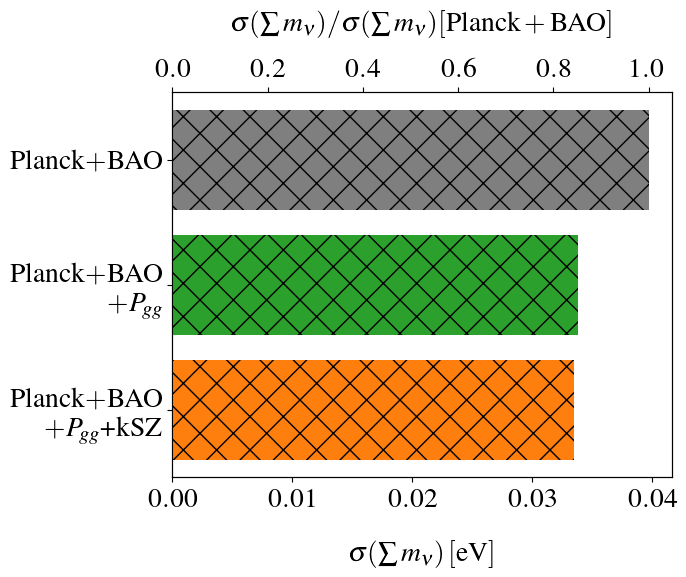

In [3457]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.4


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'Planck$+$BAO', r'Planck$+$BAO'+'\n'+r'$+P_{gg}$', r'Planck$+$BAO'+'\n'+r'$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:green', 'tab:orange' ]

#
mnu_constraints = np.array([F_Planck['BAO'].sigmas()['mnu'] , F_BAO_Planck_nolensing_Pgg.sigmas()['mnu'] , F_BAO_Planck_nolensing_Pgggvvv.sigmas()['mnu']])
#
ax1.barh(experiments, mnu_constraints, color=exp_colors, alpha = 1 )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.tick_params(axis='both', which='major', labelsize=20)



#
mnu_ratios = mnu_constraints/mnu_constraints[0]
#mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
ax2.barh(experiments, mnu_ratios, color=exp_colors, hatch='x' )
#ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{Planck}+\rm{BAO}]$', labelpad=xpad_base, fontsize=xfontsize_base)
ax2.tick_params(labelsize=20)
plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_Planck_nolensing.pdf', bbox_inches='tight')


#### bv prior

In [3506]:
F_BAO_Planck_nolensing_Pgggvvv_bv0p01 = F_BAO_Planck_nolensing_Pgggvvv.copy()
F_BAO_Planck_nolensing_Pgggvvv_bv0p01.add_prior('bv_0.2',0.01)
F_BAO_Planck_nolensing_Pgggvvv_bv0p01.add_prior('bv_0.7',0.01)
F_BAO_Planck_nolensing_Pgggvvv_bv0p01.add_prior('bv_1.3',0.01)
F_BAO_Planck_nolensing_Pgggvvv_bv0p01.add_prior('bv_1.9',0.01)
F_BAO_Planck_nolensing_Pgggvvv_bv0p01.add_prior('bv_2.6',0.01)

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

In [3654]:
1 - F_BAO_Planck_nolensing_Pgggvvv_bv0p01.sigmas()['mnu'] / F_BAO_Planck_nolensing_Pgg.sigmas()['mnu']

0.09171608307523882

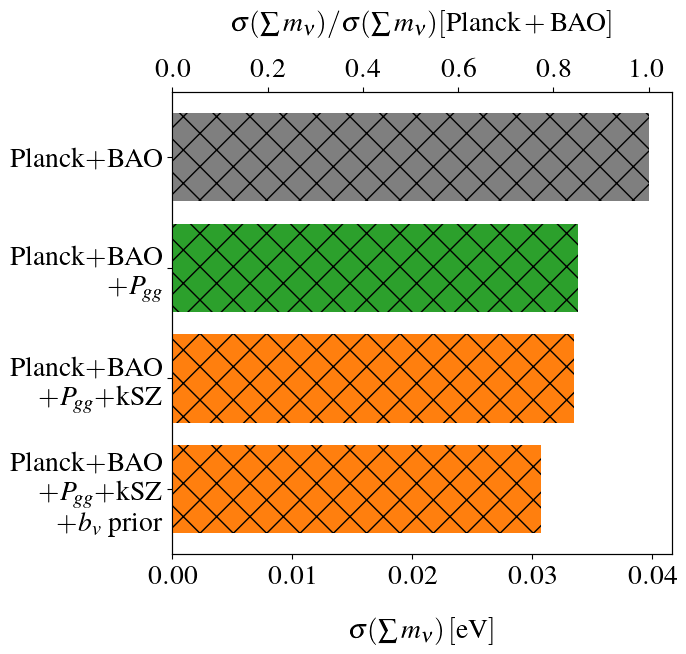

In [3667]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.4


figsize_x = 5
figsize_y = 1.2*figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'Planck$+$BAO', r'Planck$+$BAO'+'\n'+r'$+P_{gg}$', r'Planck$+$BAO'+'\n'+r'$+P_{gg}+$kSZ', r'Planck$+$BAO'+'\n'+r'$+P_{gg}+$kSZ'+'\n'+r'$+b_v$ prior' ]
exp_colors = ['tab:gray', 'tab:green', 'tab:orange', 'tab:orange' ]

#
mnu_constraints = np.array([F_Planck['BAO'].sigmas()['mnu'] , F_BAO_Planck_nolensing_Pgg.sigmas()['mnu'] , F_BAO_Planck_nolensing_Pgggvvv.sigmas()['mnu'], F_BAO_Planck_nolensing_Pgggvvv_bv0p01.sigmas()['mnu']])
#
ax1.barh(experiments, mnu_constraints, color=exp_colors, )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.tick_params(axis='both', which='major', labelsize=20)



#
mnu_ratios = mnu_constraints/mnu_constraints[0]
#mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
ax2.barh(experiments, mnu_ratios, color=exp_colors, hatch='x' )
#ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{Planck}+\rm{BAO}]$', labelpad=xpad_base, fontsize=xfontsize_base)
ax2.tick_params(labelsize=20)
plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_Planck_nolensing_bvprior.pdf', bbox_inches='tight')


### HD

In [ ]:
#F_BAO_HD_lensing_tauprior
#F_Pgg_BAO_HD_lensing_tauprior
#F_Pgggvvv_BAO_HD_lensing_tauprior


In [2471]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.3


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'HD$+$BAO', r'HD$+$BAO$+P_{gg}$', r'HD$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:green', 'tab:orange' ]

#
mnu_constraints = np.array([F_BAO_HD_lensing.sigmas()['mnu'] , F_Pgg_BAO_HD_lensing.sigmas()['mnu'] , F_Pgggvvv_BAO_HD_lensing.sigmas()['mnu']])
mnu_constraints_tau = np.array([F_BAO_HD_lensing_tauprior.sigmas()['mnu'] , F_Pgg_BAO_HD_lensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_HD_lensing_tauprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)


#
#mnu_ratios = mnu_constraints/mnu_constraints[0]
mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
ax2.barh(experiments, mnu_ratios, color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{HD}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_HD.pdf', bbox_inches='tight')


In [1882]:
F_Pgggvvv_BAO_HD_lensing.sigmas()['mnu'] / F_Pgg_BAO_HD_lensing.sigmas()['mnu']

0.930698712743296

In [1883]:
F_BAO_HD_lensing_tauprior.sigmas()['mnu'] 

0.02184864214098924

In [1888]:
F_Pgg_BAO_HD_lensing_tauprior.sigmas()['mnu'] 

0.020103485613650707

In [1892]:
20.1/21.8

0.9220183486238532

In [1889]:
F_Pgggvvv_BAO_HD_lensing_tauprior.sigmas()['mnu']

0.019306015991032006

In [1885]:
GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu']

0.024632336651652483

In [1886]:
21.85/24.63

0.8871295168493708

In [1890]:
19.3/20.1

0.9601990049751243

In [1597]:
mnu_constraints_tau

array([0.02184864, 0.02010349, 0.01930602])

In [1887]:
F_Pgg_BAO_HD_lensing_tauprior.sigmas()['mnu'] 

0.020103485613650707

#### w/o lensing

In [2659]:
F_BAO_HD_nolensing = F_HD_nolensing_Fisher.copy() + F_BAO_GALI_LCDMmnu.copy()


F_Pgg_BAO_HD_nolensing = F_HD_nolensing_Fisher.copy() + F_gg_dict['b_ofz_nonlin'] + F_BAO_GALI_LCDMmnu.copy()
#print(F_Pgg_BAO_HD_nolensing.sigmas())

F_Pgggvvv_BAO_HD_nolensing = F_HD_nolensing_Fisher.copy() + F_gggvvv_dict['b_ofz_nonlin_HD_lmax15000_Nvv'] + F_BAO_GALI_LCDMmnu.copy()
#print(F_Pgggvvv_BAO_HD_nolensing.sigmas())


F_BAO_HD_nolensing_tauprior = F_BAO_HD_nolensing.copy()
F_BAO_HD_nolensing_tauprior.add_prior('tau',tau_prior_planck)

F_Pgg_BAO_HD_nolensing_tauprior = F_Pgg_BAO_HD_nolensing.copy()
F_Pgg_BAO_HD_nolensing_tauprior.add_prior('tau',tau_prior_planck)

F_Pgggvvv_BAO_HD_nolensing_tauprior = F_Pgggvvv_BAO_HD_nolensing.copy()
F_Pgggvvv_BAO_HD_nolensing_tauprior.add_prior('tau',tau_prior_planck)

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

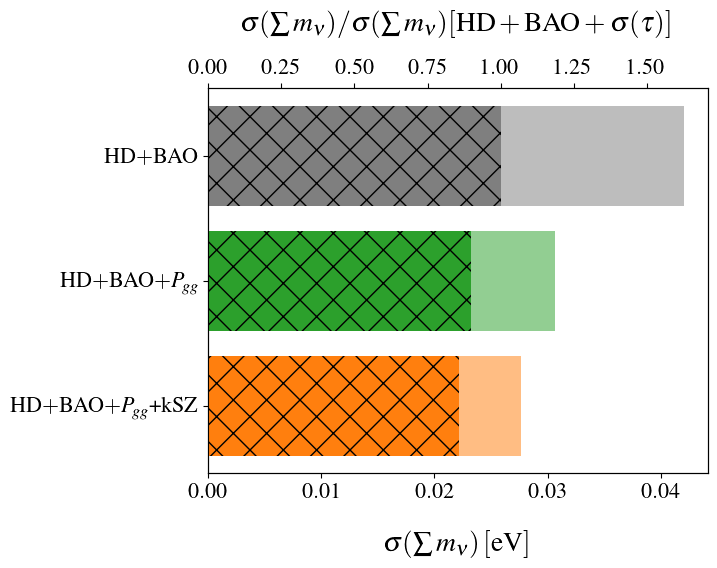

In [2660]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.3


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'HD$+$BAO', r'HD$+$BAO$+P_{gg}$', r'HD$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:green', 'tab:orange' ]

#
mnu_constraints = np.array([F_BAO_HD_nolensing.sigmas()['mnu'] , F_Pgg_BAO_HD_nolensing.sigmas()['mnu'] , F_Pgggvvv_BAO_HD_nolensing.sigmas()['mnu']])
mnu_constraints_tau = np.array([F_BAO_HD_nolensing_tauprior.sigmas()['mnu'] , F_Pgg_BAO_HD_nolensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_HD_nolensing_tauprior.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)


#
#mnu_ratios = mnu_constraints/mnu_constraints[0]
mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
ax2.barh(experiments, mnu_ratios, color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{HD}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)

plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_HD_nolensing.pdf', bbox_inches='tight')


In [2675]:
F_Pgg_BAO_HD_nolensing_tauprior.sigmas()['mnu']

0.023264101891240258

In [2676]:
F_Pgggvvv_BAO_HD_nolensing_tauprior.sigmas()['mnu']

0.022158620443939184

In [2673]:
F_BAO_HD_nolensing_tauprior.sigmas()['mnu'] 

0.025851570341788276

In [2674]:
1-258.5/303

0.1468646864686468

In [2664]:
1 - F_Pgggvvv_BAO_HD_nolensing_tauprior.sigmas()['mnu']/F_Pgg_BAO_HD_nolensing_tauprior.sigmas()['mnu']

0.04751876743272543

In [2678]:
1-233/259

0.10038610038610041

In [2680]:
1-201/218

0.07798165137614677

In [2677]:
1-222/233

0.047210300429184504

#### unlensed, no kappa

In [3379]:
t1 = f_cluster_HDunlensed_Fisher.copy()
print(t1.sigmas()['mnu'])

t1 = f_cluster_HDunlensed_Fisher.copy() + F_BAO_GALI_LCDMmnu
print(t1.sigmas()['mnu'])

0.15969803978898622
0.026629335028991452


In [3380]:
F_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu']

0.026628557473276627

In [3375]:
F_HD_cluster_nolensing_UNLENSED_Fisher_tauprior = f_cluster_HDunlensed_Fisher.copy()
F_HD_cluster_nolensing_UNLENSED_Fisher_tauprior.add_prior('tau',tau_prior_planck)
print(F_HD_cluster_nolensing_UNLENSED_Fisher_tauprior.sigmas()['mnu'])

F_BAO_HD_cluster_nolensing_UNLENSED = f_cluster_HDunlensed_Fisher.copy() + F_BAO_GALI_LCDMmnu  

F_BAO_HD_cluster_nolensing_UNLENSED_tauprior = F_BAO_HD_cluster_nolensing_UNLENSED.copy()
F_BAO_HD_cluster_nolensing_UNLENSED_tauprior.add_prior('tau', tau_prior_planck)

#F_Pvv_BAO_HD_nolensing = {}
F_Pvv_BAO_HD_cluster_nolensing_UNLENSED = F_BAO_HD_cluster_nolensing_UNLENSED.copy() + Fisher_each_Pvv_summnu_sumz.copy()

F_Pvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior = F_Pvv_BAO_HD_cluster_nolensing_UNLENSED.copy()
F_Pvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior.add_prior('tau', tau_prior_planck)

F_Pgg_BAO_HD_cluster_nolensing_UNLENSED = f_cluster_HDunlensed_Fisher + F_gg_dict['b_ofz_nonlin'] + F_BAO_GALI_LCDMmnu
F_Pgg_BAO_HD_cluster_nolensing_UNLENSED_tauprior = F_Pgg_BAO_HD_cluster_nolensing_UNLENSED.copy()
F_Pgg_BAO_HD_cluster_nolensing_UNLENSED_tauprior.add_prior('tau',tau_prior_planck)

F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED = f_cluster_HDunlensed_Fisher + F_gggvvv_dict['b_ofz_nonlin_HD_lmax15000_Nvv'] + F_BAO_GALI_LCDMmnu
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior = F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED.copy()
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior.add_prior('tau',tau_prior_planck)

0.1582596051774184


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.

In [3449]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.3


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'HD', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'HD$+$BAO',  r'HD$+$BAO$+P_{\hat{v}_r \hat{v}_r}$' , r'HD$+$BAO$+P_{gg}$', r'HD$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:purple' , 'tab:green', 'tab:orange' ]

#
#mnu_constraints = np.array([F_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu'] , F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu'] ,  F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu']])
mnu_constraints_tau = np.array([F_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu'], F_Pvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu'] , F_Pgg_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu'] ])
#
#ax1.barh(experiments, mnu_constraints, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.tick_params(axis='both', which='major', labelsize=20)
#ax1.set_xticks([0,0.01,0.02,0.03,0.04, 0.05])


#
#mnu_ratios = mnu_constraints/mnu_constraints[0]
mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
#ax2.barh(experiments, mnu_ratios, color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{HD}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)
ax2.tick_params( labelsize=20)


plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_HD_nolensing_UNLENSED_01302025.pdf', bbox_inches='tight')


python(21535) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21536) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21537) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21538) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21539) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21540) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21541) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21543) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21544) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21545) Malloc

##### bv prior

In [3509]:
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior_bv0p01 = F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior.copy()
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior_bv0p01.add_prior('bv_0.2',0.01)
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior_bv0p01.add_prior('bv_0.7',0.01)
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior_bv0p01.add_prior('bv_1.3',0.01)
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior_bv0p01.add_prior('bv_1.9',0.01)
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior_bv0p01.add_prior('bv_2.6',0.01)

/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [3510]:
1 - F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior_bv0p01.sigmas()['mnu'] / F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu']

0.08717942654000921

In [3519]:
1 - F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior_bv0p01.sigmas()['mnu'] / F_Pgg_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu']

0.13269411545513154

In [3511]:
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior_bv0p01.sigmas()['mnu']

0.021302845306490865

In [3666]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.3


figsize_x = 5
figsize_y = 1.2*figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'HD', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'HD$+$BAO',  r'HD$+$BAO' +'\n'+  r'$+P_{gg}$', r'HD$+$BAO'+'\n'+r'$+P_{gg}+$kSZ', r'HD$+$BAO'+'\n'+r'$+P_{gg}+$kSZ'+'\n'+r'$+b_v$ prior' ]
#exp_colors = ['tab:gray', 'tab:purple' , 'tab:green', 'tab:orange', 'tab:orange' ]
exp_colors = ['tab:gray', 'tab:green', 'tab:orange', 'tab:orange' ]

#
#mnu_constraints_tau = np.array([F_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu'], F_Pvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu'] , F_Pgg_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu'], F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior_bv0p01.sigmas()['mnu'] ])
mnu_constraints_tau = np.array([F_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu'] , F_Pgg_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu'], F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior_bv0p01.sigmas()['mnu'] ])

#ax1.barh(experiments, mnu_constraints, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.tick_params(axis='both', which='major', labelsize=20)
#ax1.set_xticks([0,0.01,0.02,0.03,0.04, 0.05])


#
#mnu_ratios = mnu_constraints/mnu_constraints[0]
#mnu_ratios = mnu_constraints/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
#ax2.barh(experiments, mnu_ratios, color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{HD}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)
ax2.tick_params( labelsize=20)


plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_HD_nolensing_UNLENSED_02062025_bvprior.pdf', bbox_inches='tight')


In [3663]:
mnu_constraints_tau

array([0.02662856, 0.02456209, 0.02333739, 0.02130285])

In [3664]:
1 - 0.02130285/0.02456209

0.1326939197763708

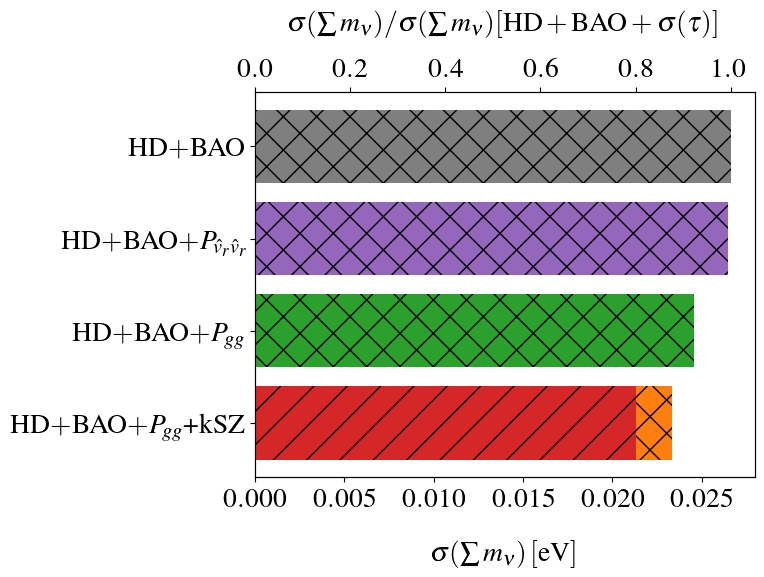

In [3520]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.3


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'HD', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'HD$+$BAO',  r'HD$+$BAO$+P_{\hat{v}_r \hat{v}_r}$' , r'HD$+$BAO$+P_{gg}$', r'HD$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:purple' , 'tab:green', 'tab:orange' ]
exp_colors_bv = ['tab:gray', 'tab:purple' , 'tab:green', 'tab:red' ]

#
#mnu_constraints = np.array([F_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu'] , F_Pvv_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu'] ,  F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu']])
mnu_constraints_tau = np.array([F_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu'], F_Pvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu'] , F_Pgg_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior.sigmas()['mnu'] ])
mnu_constraints_tau_bv = np.array([0, 0 , 0 , F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_tauprior_bv0p01.sigmas()['mnu'] ])

#
#ax1.barh(experiments, mnu_constraints, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_tau, color=exp_colors )
ax1.barh(experiments, mnu_constraints_tau_bv, color=exp_colors_bv,  hatch ='+' )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)
ax1.tick_params(axis='both', which='major', labelsize=20)
#ax1.set_xticks([0,0.01,0.02,0.03,0.04, 0.05])


#
#mnu_ratios = mnu_constraints/mnu_constraints[0]
mnu_ratios_bv = mnu_constraints_tau_bv/mnu_constraints_tau[0]
mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
#ax2.barh(experiments, mnu_ratios, color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
ax2.barh(experiments, mnu_ratios_bv, color=exp_colors_bv,  hatch ='/' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{HD}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)
ax2.tick_params( labelsize=20)


plt.subplots_adjust(left=0.0, right=1)


#plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_HD_nolensing_UNLENSED_bvprior_02062025.pdf', bbox_inches='tight')


##### no photoz

In [3393]:
F_Pgg_BAO_HD_cluster_nolensing_UNLENSED_nophotoz = f_cluster_HDunlensed_Fisher + F_gg_dict['b_ofz_nonlin_nophotoz'] + F_BAO_GALI_LCDMmnu
F_Pgg_BAO_HD_cluster_nolensing_UNLENSED_nophotoz_tauprior = F_Pgg_BAO_HD_cluster_nolensing_UNLENSED_nophotoz.copy()
F_Pgg_BAO_HD_cluster_nolensing_UNLENSED_nophotoz_tauprior.add_prior('tau',tau_prior_planck)

/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [3390]:
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_nophotoz = f_cluster_HDunlensed_Fisher + F_gggvvv_dict['b_ofz_nonlin_HD_lmax15000_Nvv_nophotoz'] + F_BAO_GALI_LCDMmnu
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_nophotoz_tauprior = F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_nophotoz.copy()
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_nophotoz_tauprior.add_prior('tau',tau_prior_planck)

/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [3391]:
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_nophotoz_tauprior.sigmas()['mnu']

0.016491856751631735

In [3394]:
F_Pgg_BAO_HD_cluster_nolensing_UNLENSED_nophotoz_tauprior.sigmas()['mnu']

0.021901317390169636

In [3396]:
1 - F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_nophotoz_tauprior.sigmas()['mnu'] / F_Pgg_BAO_HD_cluster_nolensing_UNLENSED_nophotoz_tauprior.sigmas()['mnu']

0.24699247730942098

In [3410]:
test = f_cluster_HDunlensed_Fisher.copy() + F_BAO_GALI_LCDMmnu + F_gggvvv_dict['b_ofz_nonlin_HD_lmax15000_Nvv_nophotoz']
test.add_prior('tau',tau_prior_planck)
test.sigmas()['mnu']

/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


0.016491856751631263

In [3411]:
test = F_HD_nolensing_Fisher.copy() + F_BAO_GALI_LCDMmnu + F_gggvvv_dict['b_ofz_nonlin_HD_lmax15000_Nvv_nophotoz']
test.add_prior('tau',tau_prior_planck)
test.sigmas()['mnu']

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

0.016787620430072935

##### no photoz, bv prior

In [3665]:
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_nophotoz_tauprior_bvprior = F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_nophotoz_tauprior.copy()
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_nophotoz_tauprior_bvprior.add_prior('bv_0.2',0.01)
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_nophotoz_tauprior_bvprior.add_prior('bv_0.7',0.01)
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_nophotoz_tauprior_bvprior.add_prior('bv_1.3',0.01)
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_nophotoz_tauprior_bvprior.add_prior('bv_1.9',0.01)
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_nophotoz_tauprior_bvprior.add_prior('bv_2.6',0.01)
F_Pgggvvv_BAO_HD_cluster_nolensing_UNLENSED_nophotoz_tauprior_bvprior.sigmas()['mnu']

/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


0.0162101506843963

### tau prior?

In [1868]:
tau_prior_planck

0.007507896110099775

In [1869]:
tau_prior_litebird = 0.002

GALI_F_BAO_S4_withlensing_litebirdtau = GALI_F_BAO_S4_withlensing.copy()
GALI_F_BAO_S4_withlensing_litebirdtau.add_prior('tau', tau_prior_litebird)

GALI_F_BAO_S4_withlensing_Pvv_fk_litebirdtau = GALI_F_BAO_S4_withlensing_Pvv_fk.copy()
GALI_F_BAO_S4_withlensing_Pvv_fk_litebirdtau.add_prior('tau', tau_prior_litebird)

F_Pgg_BAO_S4_lensing_litebirdtau = F_Pgg_BAO_S4_lensing.copy()
F_Pgg_BAO_S4_lensing_litebirdtau.add_prior('tau', tau_prior_litebird)

F_Pgggvvv_BAO_S4_lensing_litebirdtau = F_Pgggvvv_BAO_S4_lensing.copy()
F_Pgggvvv_BAO_S4_lensing_litebirdtau.add_prior('tau', tau_prior_litebird)

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.

In [1873]:
golden_rat = 1.618
ypad_base = 20
xpad_base = 20
xfontsize_base = 20
yfontsize_base = 20
aspect_rat_base = 1/golden_rat

alpha_default = 0.4


figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'S4$+$BAO',  r'S4$+$BAO$+P_{vv}$' , r'S4$+$BAO$+P_{gg}$', r'S4$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:purple' , 'tab:green', 'tab:orange' ]

#
mnu_constraints = np.array([GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu'] , GALI_F_BAO_S4_withlensing_Pvv_fk_tauprior.sigmas()['mnu'] ,  F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu']])
mnu_constraints_tau_litebird = np.array([GALI_F_BAO_S4_withlensing_litebirdtau.sigmas()['mnu'], GALI_F_BAO_S4_withlensing_Pvv_fk_litebirdtau.sigmas()['mnu'] , F_Pgg_BAO_S4_lensing_litebirdtau.sigmas()['mnu'] , F_Pgggvvv_BAO_S4_lensing_litebirdtau.sigmas()['mnu'] ])
#
ax1.barh(experiments, mnu_constraints, color=exp_colors, alpha = alpha_default )
ax1.barh(experiments, mnu_constraints_tau_litebird, color=exp_colors, hatch='x' )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)


#
#mnu_ratios = mnu_constraints/mnu_constraints[0]
mnu_ratios = mnu_constraints/mnu_constraints_tau_litebird[0]
mnu_ratios_tau_litebird = mnu_constraints_tau_litebird/mnu_constraints_tau_litebird[0]
#
ax2=ax1.twiny()
ax2.barh(experiments, mnu_ratios, color=exp_colors , alpha = alpha_default)
ax2.barh(experiments, mnu_ratios_tau_litebird, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{S4}+\rm{BAO} +\sigma(\tau)]$', labelpad=xpad_base, fontsize=xfontsize_base)
plt.subplots_adjust(left=0.0, right=1)


#plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_baseline_withPvv.pdf', bbox_inches='tight')


In [1879]:
F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu'] / GALI_F_BAO_S4_withlensing_tauprior.sigmas()['mnu']

0.9096443302931196

In [1880]:
F_Pgg_BAO_S4_lensing_litebirdtau.sigmas()['mnu'] / GALI_F_BAO_S4_withlensing_litebirdtau.sigmas()['mnu']

0.9868021312475731

### bv is important for baseline forecast S4,VRO10,DESIBAO+tau prior when lensing EXCLUDED

#### cluster results

In [3236]:
#w/ tau prior
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_nobv = F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.copy()
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_nobv.delete('bv_0.2')
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_nobv.delete('bv_0.7')
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_nobv.delete('bv_1.3')
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_nobv.delete('bv_1.9')
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_nobv.delete('bv_2.6')

In [3237]:
1 - F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_nobv.sigmas()['mnu']/F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.19963470514534554

In [3459]:
F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.03179478541669215

In [3458]:
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_nobv.sigmas()['mnu']

0.02544744280487128

In [3256]:
# repeat but w/o tau prior
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_nobv = F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4.copy()
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_nobv.delete('bv_0.2')
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_nobv.delete('bv_0.7')
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_nobv.delete('bv_1.3')
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_nobv.delete('bv_1.9')
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_nobv.delete('bv_2.6')

In [3257]:
1 - F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_nobv.sigmas()['mnu']/F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu']

0.03490811773930935

In [3251]:
### test when using just f(z), no tau prior
F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz = f_cluster_S4unlensed_Fisher.copy() + F_BAO_GALI_LCDMmnu + F_gg_dict['b_ofz_nonlin_fz']

F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz = f_cluster_S4unlensed_Fisher.copy() + F_BAO_GALI_LCDMmnu + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_fz']


In [3272]:
F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu']

0.03183384918604895

In [3268]:
print(F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu'])
print(F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu'])
print( 1- F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu'] / F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4.sigmas()['mnu'])

0.03183384918604895
0.031015360720343412
0.025711262905154353


In [3258]:
print(F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz.sigmas()['mnu'])
print(F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz.sigmas()['mnu'])
print( 1- F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz.sigmas()['mnu'] / F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz.sigmas()['mnu'])


0.031780028311936354
0.03106490558552493
0.022502268386678126


In [3265]:
print( F_gg_dict['b_ofz_nonlin'].sigmas()['mnu'])
print(F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'].sigmas()['mnu'] )
print(1 - F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'].sigmas()['mnu'] / F_gg_dict['b_ofz_nonlin'].sigmas()['mnu'])

0.31204527498913287
0.2763411322463361
0.11441975124936654


In [3266]:
print( F_gg_dict['b_ofz_nonlin_fz'].sigmas()['mnu'])
print(F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_fz'].sigmas()['mnu'] )
print(1 - F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_fz'].sigmas()['mnu'] / F_gg_dict['b_ofz_nonlin_fz'].sigmas()['mnu'])

0.36070640807722565
0.3563240379109525
0.012149410346308231


In [3270]:
test_fgg_fk_tauprior = F_gg_dict['b_ofz_nonlin'].copy()
test_fgg_fk_tauprior.add_prior('tau',tau_prior_planck)
print(test_fgg_fk_tauprior.sigmas()['mnu'])

test_fgggvvv_fk_tauprior = F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'].copy()
test_fgggvvv_fk_tauprior.add_prior('tau',tau_prior_planck)
print(test_fgggvvv_fk_tauprior.sigmas()['mnu'])

0.31149269448614325
0.27633944685854017


In [3274]:
test=f_cluster_S4unlensed_Fisher.copy()
print(test.sigmas()['As'])
test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['As'])

5.730446307476479e-10
3.338188961146221e-11


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [3273]:
test = F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'].copy()
test.delete('bv_0.2')
test.delete('bv_0.7')
test.delete('bv_1.3')
test.delete('bv_1.9')
test.delete('bv_2.6')
print(test.sigmas()['mnu'])
del(test)

test = F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'].copy()
test.delete('bv_0.2')
test.delete('bv_0.7')
test.delete('bv_1.3')
test.delete('bv_1.9')
test.delete('bv_2.6')
test.add_prior('tau',tau_prior_planck)
print(test.sigmas()['mnu'])

0.2703618054761776
0.2703498603052676


/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:249: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, 

In [3261]:
F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz.sigmas()['tau']

0.10016997389176438

In [3252]:
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_nobv = F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz.copy()
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_nobv.delete('bv_0.2')
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_nobv.delete('bv_0.7')
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_nobv.delete('bv_1.3')
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_nobv.delete('bv_1.9')
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_nobv.delete('bv_2.6')

In [3254]:
1 - F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_nobv.sigmas()['mnu'] / F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz.sigmas()['mnu']

0.029380498379873554

In [3255]:
### test when using just f(z), but with a tau prior!
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_nobv_tauprior = F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_nobv.copy()
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_nobv_tauprior.add_prior('tau',tau_prior_planck)

F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_tauprior = F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz.copy()
F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_tauprior.add_prior('tau',tau_prior_planck)


print( 1 - F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_nobv_tauprior.sigmas()['mnu'] /F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_tauprior.sigmas()['mnu'] )

0.16467234860211022


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.

In [3250]:
### test when using just f(z), but with a tau prior!
F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_tauprior = f_cluster_S4unlensed_Fisher.copy() + F_BAO_GALI_LCDMmnu + F_gg_dict['b_ofz_nonlin_fz']
F_Pgg_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_tauprior.add_prior('tau',tau_prior_planck)

F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_tauprior = f_cluster_S4unlensed_Fisher.copy() + F_BAO_GALI_LCDMmnu + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_fz']
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_tauprior.add_prior('tau',tau_prior_planck)


In [3240]:
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_tauprior_nobv = F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_tauprior.copy()
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_tauprior_nobv.delete('bv_0.2')
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_tauprior_nobv.delete('bv_0.7')
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_tauprior_nobv.delete('bv_1.3')
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_tauprior_nobv.delete('bv_1.9')
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_fz_tauprior_nobv.delete('bv_2.6')


In [3244]:
F_Pgggvvv_BAO_S4_cluster_nolensing_UNLENSED_1p4_tauprior_nobv.sigmas()['mnu']

0.02544744280487128

#### local results

In [3065]:
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobv = F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior.copy()
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobv.delete('bv_0.2')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobv.delete('bv_0.7')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobv.delete('bv_1.3')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobv.delete('bv_1.9')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobv.delete('bv_2.6')

In [3083]:
1 - F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobv.sigmas()['mnu']/F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.2001109835992506

In [3067]:
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.031034252515441015

In [3066]:
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobv.sigmas()['mnu']

0.0254579587457619

In [3096]:
### test when using just f(z)
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_fz_tauprior = F_S4_nolensing_UNLENSED_1p4_Fisher_tauprior.copy() + F_BAO_GALI_LCDMmnu + F_gg_dict['b_ofz_nonlin_fz']

F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_fz_tauprior = F_S4_nolensing_UNLENSED_1p4_Fisher_tauprior.copy() + F_BAO_GALI_LCDMmnu + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_fz']


In [3098]:
print(F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_fz_tauprior.sigmas()['mnu'])
print(F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_fz_tauprior.sigmas()['mnu'])

0.03180693844911246
0.031075207578533808


In [3100]:
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_fz_tauprior_nobv = F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_fz_tauprior.copy()
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_fz_tauprior_nobv.delete('bv_0.2')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_fz_tauprior_nobv.delete('bv_0.7')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_fz_tauprior_nobv.delete('bv_1.3')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_fz_tauprior_nobv.delete('bv_1.9')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_fz_tauprior_nobv.delete('bv_2.6')

In [3101]:
1 - F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_fz_tauprior_nobv.sigmas()['mnu'] / F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_fz_tauprior.sigmas()['mnu']

0.1651087547999518

In [3245]:
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_fz_tauprior_nobv.sigmas()['mnu']

0.026555334447780795

In [3247]:
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_fz_tauprior.sigmas()['mnu']

0.031075207578533808

#### old stuff with lensing

In [1599]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nobv = F_Pgggvvv_BAO_S4_lensing_tauprior.copy()
F_Pgggvvv_BAO_S4_lensing_tauprior_nobv.delete('bv_0.2')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobv.delete('bv_0.7')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobv.delete('bv_1.3')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobv.delete('bv_1.9')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobv.delete('bv_2.6')

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [1603]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nobv.sigmas()['mnu']

0.02218916304211371

In [1602]:
F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.022209884560751604

In [1622]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nobv.sigmas()['mnu']/F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.9990670136721687

In [2480]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nobv.sigmas()['mnu']/F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.9902929627736494

In [1604]:
F_Pgggvvv_BAO_S4_lensing_nobv = F_Pgggvvv_BAO_S4_lensing.copy()
F_Pgggvvv_BAO_S4_lensing_nobv.delete('bv_0.2')
F_Pgggvvv_BAO_S4_lensing_nobv.delete('bv_0.7')
F_Pgggvvv_BAO_S4_lensing_nobv.delete('bv_1.3')
F_Pgggvvv_BAO_S4_lensing_nobv.delete('bv_1.9')
F_Pgggvvv_BAO_S4_lensing_nobv.delete('bv_2.6')

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [1607]:
F_Pgggvvv_BAO_S4_lensing.sigmas()['mnu']

0.028569949139672233

In [1606]:
F_Pgggvvv_BAO_S4_lensing_nobv.sigmas()['mnu']

0.028310421461467852

In [1621]:
F_Pgggvvv_BAO_S4_lensing_nobv.sigmas()['mnu']/F_Pgggvvv_BAO_S4_lensing.sigmas()['mnu']

0.9909160608954672

In [2479]:
F_Pgggvvv_BAO_S4_lensing_nobv.sigmas()['mnu']/F_Pgg_BAO_S4_lensing.sigmas()['mnu']

0.9714312052241174

### b2: constraints improve by 5%, kSZ improvement sloightly bigger, to 1.5%

In [3068]:
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2 = F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior.copy()
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2.delete('bk2_0.2')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2.delete('bk2_0.7')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2.delete('bk2_1.3')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2.delete('bk2_1.9')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2.delete('bk2_2.6')

F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2 = F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior.copy()
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2.delete('bk2_0.2')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2.delete('bk2_0.7')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2.delete('bk2_1.3')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2.delete('bk2_1.9')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2.delete('bk2_2.6')

In [3069]:
1 - F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2.sigmas()['mnu'] /  F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2.sigmas()['mnu']

0.035499346021464984

In [3072]:
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2.sigmas()['mnu']

0.025874038011469737

In [3070]:
1 - F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2.sigmas()['mnu'] /  F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.16627481204529815

In [3071]:
1 - F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobk2.sigmas()['mnu'] /  F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.15711594097806325

##### old stuff with lensing

In [1614]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nobk2 = F_Pgggvvv_BAO_S4_lensing_tauprior.copy()
F_Pgggvvv_BAO_S4_lensing_tauprior_nobk2.delete('bk2_0.2')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobk2.delete('bk2_0.7')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobk2.delete('bk2_1.3')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobk2.delete('bk2_1.9')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobk2.delete('bk2_2.6')

F_Pgg_BAO_S4_lensing_tauprior_nobk2 = F_Pgg_BAO_S4_lensing_tauprior.copy()
F_Pgg_BAO_S4_lensing_tauprior_nobk2.delete('bk2_0.2')
F_Pgg_BAO_S4_lensing_tauprior_nobk2.delete('bk2_0.7')
F_Pgg_BAO_S4_lensing_tauprior_nobk2.delete('bk2_1.3')
F_Pgg_BAO_S4_lensing_tauprior_nobk2.delete('bk2_1.9')
F_Pgg_BAO_S4_lensing_tauprior_nobk2.delete('bk2_2.6')

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [1640]:
F_Pgg_BAO_S4_lensing_tauprior_nobk2.sigmas()['mnu']

0.02155815170262782

In [1641]:
F_Pgg_BAO_S4_lensing_tauprior_nobk2.sigmas()['mnu']/F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.9621311935470566

In [1642]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nobk2.sigmas()['mnu']

0.021231627276465673

In [1643]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nobk2.sigmas()['mnu']/F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.9559539680807406

In [1688]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nobk2.sigmas()['mnu']/F_Pgg_BAO_S4_lensing_tauprior_nobk2.sigmas()['mnu']

0.9848537838184733

#### f_$\nu$ stuff

In [1689]:
(0.06/13.2)*(0.142/(ombh2fid+omch2fid))

0.004545454545454545

In [1695]:
for zed in z_mean:
    parn = 'b1_'+str(zed)
    print(F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()[parn]/F_Pgg_BAO_S4_lensing_tauprior.sigmas()[parn])

0.865186646003631
0.9297868309591469
0.9775566137693515
0.9915192015991586
0.996811015230962


In [1696]:
for zed in z_mean:
    parn = 'b1_'+str(zed)
    print(F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()[parn]/b[zed])

0.010507741784504991
0.0045365501946808915
0.00414086656375893
0.004192936802296541
0.004269334287130552


In [1690]:
F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()

{'As': 2.1567061176165427e-11,
 'H0': 0.2136833514559629,
 'b1_0.2': 0.011033128873730242,
 'b1_0.7': 0.006215073766712822,
 'b1_1.3': 0.007412151149128484,
 'b1_1.9': 0.009308319701098322,
 'b1_2.6': 0.011697975946737712,
 'bk2_0.2': 1.850892726396574,
 'bk2_0.7': 0.9286731422684812,
 'bk2_1.3': 0.9993688999394865,
 'bk2_1.9': 1.252189928699062,
 'bk2_2.6': 1.6751682974901523,
 'brsd_0.2': 0.06312392015744148,
 'brsd_0.7': 0.03154804961866382,
 'brsd_1.3': 0.036732392728819896,
 'brsd_1.9': 0.046311636219099964,
 'brsd_2.6': 0.05908178478543541,
 'bv_0.2': 0.015915203825326765,
 'bv_0.7': 0.007871323194694274,
 'bv_1.3': 0.009639578380123397,
 'bv_1.9': 0.013746482630879799,
 'bv_2.6': 0.019300311559674353,
 'mnu': 0.022209884560751604,
 'ns': 0.0017765945247050958,
 'ombh2': 2.9563374187611334e-05,
 'omch2': 0.0003708380153938707,
 'tau': 0.005409319229180931}

### no b1

In [3073]:
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nob1 = F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior.copy()
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nob1.delete('b1_0.2')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nob1.delete('b1_0.7')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nob1.delete('b1_1.3')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nob1.delete('b1_1.9')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nob1.delete('b1_2.6')


F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nob1 = F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior.copy()
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nob1.delete('b1_0.2')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nob1.delete('b1_0.7')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nob1.delete('b1_1.3')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nob1.delete('b1_1.9')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nob1.delete('b1_2.6')

In [3074]:
1 - F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nob1.sigmas()['mnu'] / F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nob1.sigmas()['mnu']

0.0072799529836088395

In [3075]:
1 - F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nob1.sigmas()['mnu'] / F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.2973456649822289

In [3076]:
1 - F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nob1.sigmas()['mnu'] / F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.3098199806511611

#### old lensing stuff

In [1630]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nob1 = F_Pgggvvv_BAO_S4_lensing_tauprior.copy()
F_Pgggvvv_BAO_S4_lensing_tauprior_nob1.delete('b1_0.2')
F_Pgggvvv_BAO_S4_lensing_tauprior_nob1.delete('b1_0.7')
F_Pgggvvv_BAO_S4_lensing_tauprior_nob1.delete('b1_1.3')
F_Pgggvvv_BAO_S4_lensing_tauprior_nob1.delete('b1_1.9')
F_Pgggvvv_BAO_S4_lensing_tauprior_nob1.delete('b1_2.6')


F_Pgg_BAO_S4_lensing_tauprior_nob1 = F_Pgg_BAO_S4_lensing_tauprior.copy()
F_Pgg_BAO_S4_lensing_tauprior_nob1.delete('b1_0.2')
F_Pgg_BAO_S4_lensing_tauprior_nob1.delete('b1_0.7')
F_Pgg_BAO_S4_lensing_tauprior_nob1.delete('b1_1.3')
F_Pgg_BAO_S4_lensing_tauprior_nob1.delete('b1_1.9')
F_Pgg_BAO_S4_lensing_tauprior_nob1.delete('b1_2.6')




/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [1631]:
F_Pgg_BAO_S4_lensing_tauprior_nob1.sigmas()['mnu']

0.02093248335646904

In [2472]:
F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.022406665377047087

In [1638]:
F_Pgg_BAO_S4_lensing_tauprior_nob1.sigmas()['mnu']/F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.9342078798531008

In [1632]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nob1.sigmas()['mnu']

0.020835284521134294

In [1639]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nob1.sigmas()['mnu']/F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.9381086364561099

In [1683]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nob1.sigmas()['mnu']/F_Pgg_BAO_S4_lensing_tauprior_nob1.sigmas()['mnu']

0.9953565549925681

In [1687]:
F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu']/F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.9912177553873295

In [2481]:
F_Pgggvvv_BAO_S4_lensing_nob1 = F_Pgggvvv_BAO_S4_lensing.copy()
F_Pgggvvv_BAO_S4_lensing_nob1.delete('b1_0.2')
F_Pgggvvv_BAO_S4_lensing_nob1.delete('b1_0.7')
F_Pgggvvv_BAO_S4_lensing_nob1.delete('b1_1.3')
F_Pgggvvv_BAO_S4_lensing_nob1.delete('b1_1.9')
F_Pgggvvv_BAO_S4_lensing_nob1.delete('b1_2.6')


F_Pgg_BAO_S4_lensing_nob1 = F_Pgg_BAO_S4_lensing.copy()
F_Pgg_BAO_S4_lensing_nob1.delete('b1_0.2')
F_Pgg_BAO_S4_lensing_nob1.delete('b1_0.7')
F_Pgg_BAO_S4_lensing_nob1.delete('b1_1.3')
F_Pgg_BAO_S4_lensing_nob1.delete('b1_1.9')
F_Pgg_BAO_S4_lensing_nob1.delete('b1_2.6')

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [2483]:
F_Pgggvvv_BAO_S4_lensing_nob1.sigmas()['mnu']/F_Pgg_BAO_S4_lensing_nob1.sigmas()['mnu']

0.9839255061820792

In [2484]:
F_Pgggvvv_BAO_S4_lensing_nob1.sigmas()['mnu']/F_Pgggvvv_BAO_S4_lensing.sigmas()['mnu']

0.9868537443174807

In [2485]:
F_Pgg_BAO_S4_lensing_nob1.sigmas()['mnu']/F_Pgg_BAO_S4_lensing.sigmas()['mnu']

0.9832540795397823

### no brsd

In [3077]:
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobrsd = F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior.copy()
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobrsd.delete('brsd_0.2')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobrsd.delete('brsd_0.7')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobrsd.delete('brsd_1.3')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobrsd.delete('brsd_1.9')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobrsd.delete('brsd_2.6')


F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobrsd = F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior.copy()
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobrsd.delete('brsd_0.2')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobrsd.delete('brsd_0.7')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobrsd.delete('brsd_1.3')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobrsd.delete('brsd_1.9')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobrsd.delete('brsd_2.6')

In [3078]:
1 - F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobrsd.sigmas()['mnu'] / F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobrsd.sigmas()['mnu']

0.021355048483658434

In [3079]:
1 - F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobrsd.sigmas()['mnu'] / F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.00917338893765618

In [3080]:
1 - F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_nobrsd.sigmas()['mnu'] / F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior.sigmas()['mnu']

0.012766357734178224

#### old lensing stuff

In [1633]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nobrsd = F_Pgggvvv_BAO_S4_lensing_tauprior.copy()
F_Pgggvvv_BAO_S4_lensing_tauprior_nobrsd.delete('brsd_0.2')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobrsd.delete('brsd_0.7')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobrsd.delete('brsd_1.3')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobrsd.delete('brsd_1.9')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobrsd.delete('brsd_2.6')


F_Pgg_BAO_S4_lensing_tauprior_nobrsd = F_Pgg_BAO_S4_lensing_tauprior.copy()
F_Pgg_BAO_S4_lensing_tauprior_nobrsd.delete('brsd_0.2')
F_Pgg_BAO_S4_lensing_tauprior_nobrsd.delete('brsd_0.7')
F_Pgg_BAO_S4_lensing_tauprior_nobrsd.delete('brsd_1.3')
F_Pgg_BAO_S4_lensing_tauprior_nobrsd.delete('brsd_1.9')
F_Pgg_BAO_S4_lensing_tauprior_nobrsd.delete('brsd_2.6')




/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [1634]:
F_Pgg_BAO_S4_lensing_tauprior_nobrsd.sigmas()['mnu']

0.021759592883479752

In [1636]:
F_Pgg_BAO_S4_lensing_tauprior_nobrsd.sigmas()['mnu']/F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.9711214282590134

In [1635]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nobrsd.sigmas()['mnu']

0.021738956489275357

In [1637]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nobrsd.sigmas()['mnu']/F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.9787964646917412

In [1685]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nobrsd.sigmas()['mnu']/F_Pgg_BAO_S4_lensing_tauprior_nobrsd.sigmas()['mnu']

0.999051618552107

### delete all bias

In [1644]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias = F_Pgggvvv_BAO_S4_lensing_tauprior.copy()
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('bk2_0.2')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('bk2_0.7')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('bk2_1.3')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('bk2_1.9')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('bk2_2.6')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('b1_0.2')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('b1_0.7')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('b1_1.3')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('b1_1.9')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('b1_2.6')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('brsd_0.2')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('brsd_0.7')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('brsd_1.3')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('brsd_1.9')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('brsd_2.6')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('bv_0.2')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('bv_0.7')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('bv_1.3')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('bv_1.9')
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.delete('bv_2.6')

F_Pgg_BAO_S4_lensing_tauprior_nobias = F_Pgg_BAO_S4_lensing_tauprior.copy()
F_Pgg_BAO_S4_lensing_tauprior_nobias.delete('bk2_0.2')
F_Pgg_BAO_S4_lensing_tauprior_nobias.delete('bk2_0.7')
F_Pgg_BAO_S4_lensing_tauprior_nobias.delete('bk2_1.3')
F_Pgg_BAO_S4_lensing_tauprior_nobias.delete('bk2_1.9')
F_Pgg_BAO_S4_lensing_tauprior_nobias.delete('bk2_2.6')
F_Pgg_BAO_S4_lensing_tauprior_nobias.delete('b1_0.2')
F_Pgg_BAO_S4_lensing_tauprior_nobias.delete('b1_0.7')
F_Pgg_BAO_S4_lensing_tauprior_nobias.delete('b1_1.3')
F_Pgg_BAO_S4_lensing_tauprior_nobias.delete('b1_1.9')
F_Pgg_BAO_S4_lensing_tauprior_nobias.delete('b1_2.6')
F_Pgg_BAO_S4_lensing_tauprior_nobias.delete('brsd_0.2')
F_Pgg_BAO_S4_lensing_tauprior_nobias.delete('brsd_0.7')
F_Pgg_BAO_S4_lensing_tauprior_nobias.delete('brsd_1.3')
F_Pgg_BAO_S4_lensing_tauprior_nobias.delete('brsd_1.9')
F_Pgg_BAO_S4_lensing_tauprior_nobias.delete('brsd_2.6')



/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [1645]:
F_Pgg_BAO_S4_lensing_tauprior_nobias.sigmas()['mnu']

0.01594330041045611

In [1646]:
F_Pgg_BAO_S4_lensing_tauprior_nobias.sigmas()['mnu']/F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.7115427548977498

In [1648]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.sigmas()['mnu']

0.015922901957187922

In [1649]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.sigmas()['mnu']/F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.7169286230927207

In [1650]:
F_Pgggvvv_BAO_S4_lensing_tauprior_nobias.sigmas()['mnu']/F_Pgg_BAO_S4_lensing_tauprior_nobias.sigmas()['mnu']

0.99872056269762

### just b1

In [3081]:
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only = F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior.copy()
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('bk2_0.2')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('bk2_0.7')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('bk2_1.3')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('bk2_1.9')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('bk2_2.6')
#F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('b1_0.2')
#F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('b1_0.7')
#F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('b1_1.3')
#F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('b1_1.9')
#F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('b1_2.6')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('brsd_0.2')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('brsd_0.7')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('brsd_1.3')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('brsd_1.9')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('brsd_2.6')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('bv_0.2')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('bv_0.7')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('bv_1.3')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('bv_1.9')
F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('bv_2.6')

F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only = F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior.copy()
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('bk2_0.2')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('bk2_0.7')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('bk2_1.3')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('bk2_1.9')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('bk2_2.6')
#F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('b1_0.2')
#F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('b1_0.7')
#F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('b1_1.3')
#F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('b1_1.9')
#F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('b1_2.6')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('brsd_0.2')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('brsd_0.7')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('brsd_1.3')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('brsd_1.9')
F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.delete('brsd_2.6')



In [3082]:
1 - F_Pgggvvv_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.sigmas()['mnu']/F_Pgg_BAO_S4_nolensing_UNLENSED_1p4_tauprior_b1only.sigmas()['mnu']

0.21286898237305862

#### old lensing stuff

In [2473]:
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only = F_Pgggvvv_BAO_S4_lensing_tauprior.copy()
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('bk2_0.2')
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('bk2_0.7')
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('bk2_1.3')
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('bk2_1.9')
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('bk2_2.6')
#F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('b1_0.2')
#F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('b1_0.7')
#F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('b1_1.3')
#F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('b1_1.9')
#F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('b1_2.6')
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('brsd_0.2')
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('brsd_0.7')
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('brsd_1.3')
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('brsd_1.9')
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('brsd_2.6')
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('bv_0.2')
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('bv_0.7')
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('bv_1.3')
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('bv_1.9')
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.delete('bv_2.6')

F_Pgg_BAO_S4_lensing_tauprior_b1only = F_Pgg_BAO_S4_lensing_tauprior.copy()
F_Pgg_BAO_S4_lensing_tauprior_b1only.delete('bk2_0.2')
F_Pgg_BAO_S4_lensing_tauprior_b1only.delete('bk2_0.7')
F_Pgg_BAO_S4_lensing_tauprior_b1only.delete('bk2_1.3')
F_Pgg_BAO_S4_lensing_tauprior_b1only.delete('bk2_1.9')
F_Pgg_BAO_S4_lensing_tauprior_b1only.delete('bk2_2.6')
#F_Pgg_BAO_S4_lensing_tauprior_b1only.delete('b1_0.2')
#F_Pgg_BAO_S4_lensing_tauprior_b1only.delete('b1_0.7')
#F_Pgg_BAO_S4_lensing_tauprior_b1only.delete('b1_1.3')
#F_Pgg_BAO_S4_lensing_tauprior_b1only.delete('b1_1.9')
#F_Pgg_BAO_S4_lensing_tauprior_b1only.delete('b1_2.6')
F_Pgg_BAO_S4_lensing_tauprior_b1only.delete('brsd_0.2')
F_Pgg_BAO_S4_lensing_tauprior_b1only.delete('brsd_0.7')
F_Pgg_BAO_S4_lensing_tauprior_b1only.delete('brsd_1.3')
F_Pgg_BAO_S4_lensing_tauprior_b1only.delete('brsd_1.9')
F_Pgg_BAO_S4_lensing_tauprior_b1only.delete('brsd_2.6')



/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list


In [2474]:
F_Pgg_BAO_S4_lensing_tauprior_b1only.sigmas()['mnu']

0.020506946671792967

In [2475]:
F_Pgg_BAO_S4_lensing_tauprior_b1only.sigmas()['mnu']/F_Pgg_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.9152163575754493

In [2476]:
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.sigmas()['mnu']

0.019985975929334182

In [2477]:
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.sigmas()['mnu']/F_Pgggvvv_BAO_S4_lensing_tauprior.sigmas()['mnu']

0.8998685191120974

In [2478]:
F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.sigmas()['mnu']/F_Pgg_BAO_S4_lensing_tauprior_b1only.sigmas()['mnu']

0.9745954017047612

In [1717]:
np.where('H0' == F_Pgggvvv_BAO_S4_lensing_tauprior_b1only.keys())[0][0]

1

In [1788]:
3000*2.6e-4

0.7799999999999999

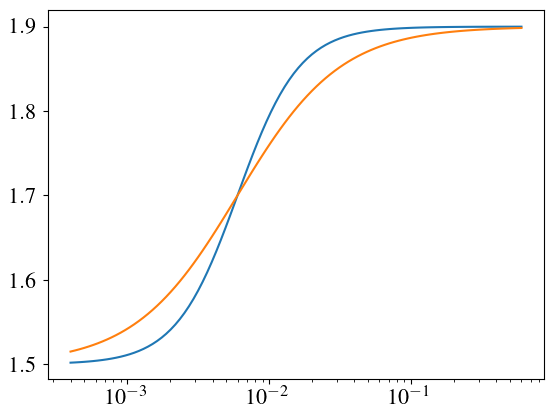

In [1851]:
blower = 1.5
bupper = 1.9
kt = 6e-3

ks =  np.geomspace(4e-4,6e-1,100)
p=0.6
diff=bupper-blower
plt.semilogx(ks, blower + diff*(0.5)*(1 + np.tanh( np.log(ks)-np.log(kt) ))  )
plt.semilogx(ks, blower + diff*(0.5)*(1 +  np.tanh( p*(np.log(ks)-np.log(kt)) )) )

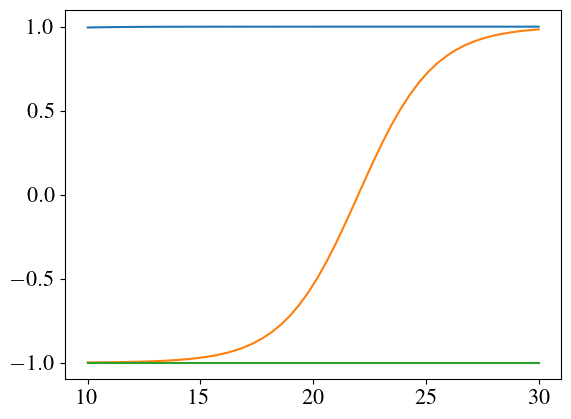

In [1836]:
xr = np.linspace(10,30,50)
p=0.3
c=22
plt.plot( xr, np.tanh(p*xr))
plt.plot( xr, np.tanh(p*(xr-c)) )
plt.plot( xr, np.tanh(p*(xr)-c)) 

In [1813]:
np.tanh( ks-kt )

array([-5.59994146e-03, -5.56927529e-03, -5.53625801e-03, -5.50070934e-03,
       -5.46243522e-03, -5.42122669e-03, -5.37685877e-03, -5.32908924e-03,
       -5.27765729e-03, -5.22228214e-03, -5.16266146e-03, -5.09846975e-03,
       -5.02935656e-03, -4.95494456e-03, -4.87482749e-03, -4.78856794e-03,
       -4.69569499e-03, -4.59570159e-03, -4.48804180e-03, -4.37212786e-03,
       -4.24732691e-03, -4.11295761e-03, -3.96828634e-03, -3.81252325e-03,
       -3.64481794e-03, -3.46425480e-03, -3.26984803e-03, -3.06053624e-03,
       -2.83517668e-03, -2.59253896e-03, -2.33129841e-03, -2.05002876e-03,
       -1.74719442e-03, -1.42114207e-03, -1.07009167e-03, -6.92126714e-04,
       -2.85183790e-04,  1.52958659e-04,  6.24692462e-04,  1.13259275e-03,
        1.67943197e-03,  2.26819504e-03,  2.90209550e-03,  3.58459311e-03,
        4.31941257e-03,  5.11056379e-03,  5.96236366e-03,  6.87945946e-03,
        7.86685401e-03,  8.92993273e-03,  1.00744927e-02,  1.13067741e-02,
        1.26334932e-02,  

### CONTOURS

In [1719]:
'''
def get_contour(Fmat, paramname_1, paramname_2):

    ind_1 = np.where(paramname_1 = Fmat.keys())[0][0]
    ind_2 = np.where(paramname_2 = Fmat.keys())[0][0]

    x_center = fids_cdm[paramname_1]
    y_center = fids_cdm[paramname_2]

    cov = np.linalg.inv(Fmat)
    sig_x = (cov[ind_1,ind_1])**0.5
    sig_y = (cov[ind_2,ind_2])**0.5
    sig_xy = cov[ind_1,ind_2]
    rho = sig_xy/(sig_x*sig_y)


    x_lin = np.linspace(-4*sig_x, 4*sig_x, numpoints)
    y_lin = np.linspace(-4*sig_y, 4*sig_y, numpoints)
    x_grid,y_grid = np.meshgrid(x_lin,y_lin)
    chi2 = ((x_grid/sig_x)**2 + (y_grid/sig_y)**2 -2.*rho*(x_grid/sig_x)*(y_grid/sig_y))/(1-rho**2)

    return x_grid,x_center,y_grid,y_center,chi2'''



In [2087]:
def get_contour(param1, param2, Fisher, numpoints):
    pos1 = np.where( Fisher.keys() == param1)[0][0]
    pos2 = np.where( Fisher.keys() == param2)[0][0]

    sigma1 = (np.linalg.inv(Fisher)[pos1,pos1])**0.5
    sigma12 = np.linalg.inv(Fisher)[pos1,pos2]
    sigma2 = (np.linalg.inv(Fisher)[pos2,pos2])**0.5
    rho = sigma12/(sigma1*sigma2)
    xrangevals = np.linspace(-4*sigma1,4*sigma1,numpoints)
    yrangevals = np.linspace(-4*sigma2,4*sigma2,numpoints)
    xgrid,ygrid = np.meshgrid(xrangevals,yrangevals)
    chisq_grid = ((xgrid/sigma1)**2+(ygrid/sigma2)**2-2.*rho*(xgrid/sigma1)*(ygrid/sigma2))/(1-rho**2)
    return [sigma1,sigma2,xgrid,ygrid, chisq_grid, sigma12]

In [ ]:
F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']

In [2142]:
def tan_theta_fisher(sigx, sigy, sigxy):
    return np.tan( 0.5* np.arctan( 2*sigxy/(sigx**2 - sigy**2)))

def a_fisher(sigx, sigy, sigxy):
    return ( 0.5*(sigx**2 + sigy**2) + np.sqrt(0.25*(sigx**2 - sigy**2)**2 + sigxy**2))**0.5

def b_fisher(sigx, sigy, sigxy):
    return ( 0.5*(sigx**2 + sigy**2) - np.sqrt(0.25*(sigx**2 - sigy**2)**2 + sigxy**2))**0.5

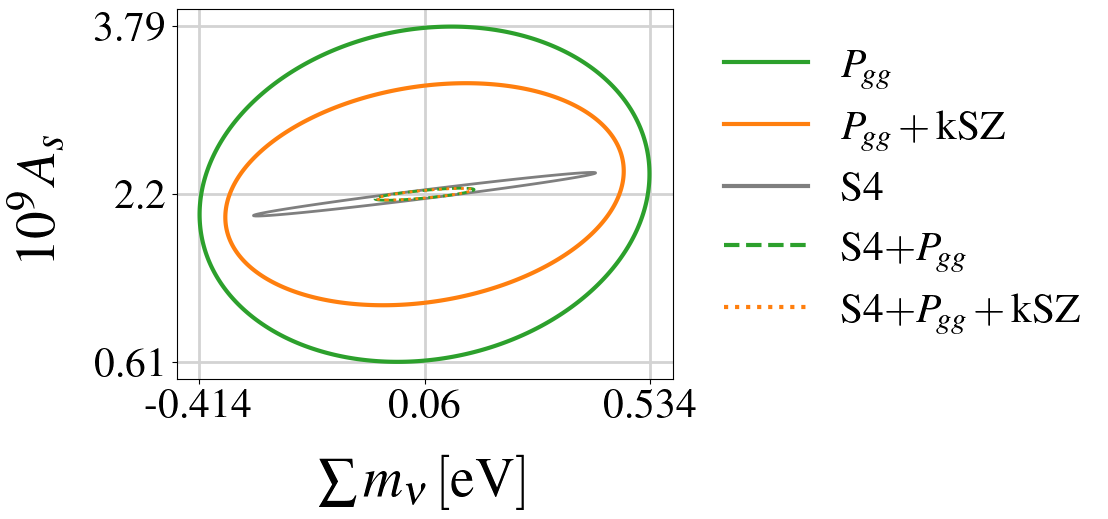

In [2191]:
from matplotlib.lines import Line2D
p1 = 'mnu'
p2 = 'As'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.1*alpha


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)


xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy

xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

#print(alpha*sigmafNL, alpha*sigy)
plt.hlines([yline_min, ycenter,   yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
plt.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)


#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher, numpoints)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Pgg_fk, numpoints)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=2, linestyles='dashed')

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Pgggvvv_fk, numpoints)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=2, linestyles='dotted')


plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=40)
plt.ylabel(r'$10^9 \,A_s$', labelpad = 20,fontsize=40)
plt.tick_params(axis='both', labelsize=30)
plt.xticks([xline_min, xcenter, xline_max], labels=[-0.414,0.06,0.534])
plt.yticks([yline_min, ycenter, yline_max], labels=[0.61,2.20,3.79])

legend_lines = [Line2D([0], [0], color='tab:green', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:orange', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:gray', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:green', linestyle = 'dashed', lw=3),
                Line2D([0], [0], color='tab:orange', linestyle = 'dotted', lw=3)]
legend_labels = [r'$P_{gg}$',r'$P_{gg}+\rm{kSZ}$', r'S4', r'S4$+P_{gg}$', r'S4$+P_{gg}+\rm{kSZ}$' ]
plt.legend(legend_lines, legend_labels,loc='upper right', bbox_to_anchor=(1.9, 1.), fontsize = 30, frameon=False )

#plt.title(Delta_approx[numplot], fontsize=40 )
plt.savefig('mnu_As_contours.pdf', bbox_inches='tight')



In [2308]:
F_S4_nolensing_Fisher.sigmas()['mnu']

0.23738807635143103

In [2292]:
F_S4_nolensing_Pgg_fk.sigmas()['mnu']

0.06870234520400373

In [2293]:
F_S4_nolensing_Pgggvvv_fk.sigmas()['mnu']

0.06599669925410659

In [2294]:
66/68.7

0.9606986899563318

In [2156]:
F_S4_nolensing_Fisher.sigmas()

{'omch2': 0.0008694530332736444,
 'ombh2': 3.1678425513606234e-05,
 'As': 1.3616221551738037e-10,
 'ns': 0.002510020825151119,
 'tau': 0.031693749316070614,
 'H0': 2.2127142562550715,
 'mnu': 0.23738807635143103}

In [2155]:
F_S4_nolensing_Pgg_fk.sigmas()

{'As': 3.755867373467147e-11,
 'H0': 0.8083373709812529,
 'b1_0.2': 0.0139238932403474,
 'b1_0.7': 0.012310240497356748,
 'b1_1.3': 0.017290878298043027,
 'b1_1.9': 0.02195353346358758,
 'b1_2.6': 0.026929243496101644,
 'bk2_0.2': 2.0274730489595063,
 'bk2_0.7': 1.009303173325467,
 'bk2_1.3': 1.0724511228112756,
 'bk2_1.9': 1.325665965188545,
 'bk2_2.6': 1.7596255143974624,
 'brsd_0.2': 0.11395910843485171,
 'brsd_0.7': 0.046747691618026464,
 'brsd_1.3': 0.04287806883237017,
 'brsd_1.9': 0.050033350916699415,
 'brsd_2.6': 0.061982963719465496,
 'mnu': 0.06870234520400373,
 'ns': 0.0023777813689675117,
 'ombh2': 3.1558090234707806e-05,
 'omch2': 0.0007891596063457837,
 'tau': 0.008992290938644409}

0.31204527498913287
0.0


([<matplotlib.axis.YTick at 0x2e3fd5950>,
 [Text(0, 6.090555931529238e-10, '0.61'),
  Text(0, 2.2e-09, '2.2'),
  Text(0, 3.790944406847076e-09, '3.79')])

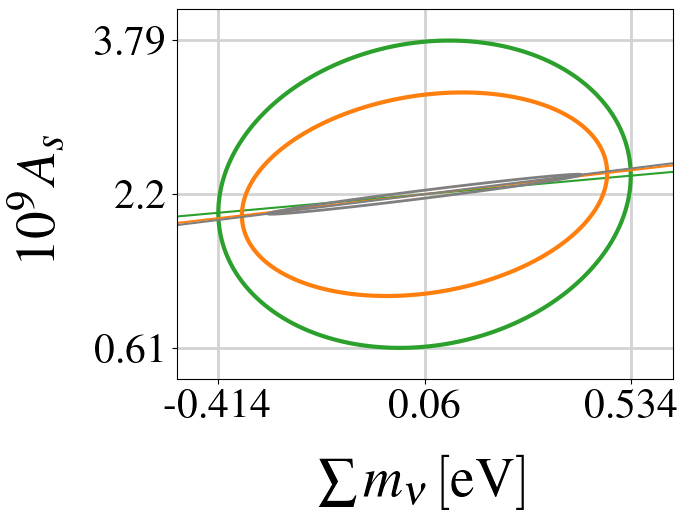

In [2144]:
p1 = 'mnu'
p2 = 'As'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.2*alpha


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)


xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy

xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

#print(alpha*sigmafNL, alpha*sigy)
plt.hlines([yline_min, ycenter,   yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
plt.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)
tantheta_gg = tan_theta_fisher(sigx,sigy,sigxy)
slope = tantheta_gg
xvals = np.linspace(-1,1,100)
plt.plot(xvals,  slope*xvals + (ycenter - slope*xcenter), c='tab:green')
print(a_fisher(sigx,sigy,sigxy))
print(b_fisher(sigx,sigy,sigxy))


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)
tantheta_gggvvv = tan_theta_fisher(sigx,sigy,sigxy)
slope = tantheta_gggvvv
xvals = np.linspace(-1,1,100)
plt.plot(xvals,  slope*xvals + (ycenter - slope*xcenter), c='tab:orange')

#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher, numpoints)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)

tantheta_S4 = tan_theta_fisher(sigx,sigy,sigxy)
slope = tantheta_S4
xvals = np.linspace(-1,1,100)
plt.plot(xvals,  slope*xvals + (ycenter - slope*xcenter), c='tab:gray')

plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=40)
plt.ylabel(r'$10^9 \,A_s$', labelpad = 20,fontsize=40)
plt.tick_params(axis='both', labelsize=30)
plt.xticks([xline_min, xcenter, xline_max], labels=[-0.414,0.06,0.534])
plt.yticks([yline_min, ycenter, yline_max], labels=[0.61,2.20,3.79])

#plt.title(Delta_approx[numplot], fontsize=40 )
#plt.savefig('ksz_gal_contour_S4temp_Delta0.pdf', bbox_inches='tight')



In [2135]:
p1 = 'mnu'
p2 = 'ombh2'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.2*alpha


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)


xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy

xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

#print(alpha*sigmafNL, alpha*sigy)
plt.hlines([yline_min, ycenter,   yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
plt.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)
tantheta_gg = tan_theta_fisher(sigx,sigy,sigxy)
slope = tantheta_gg
xvals = np.linspace(-1,1,100)
plt.plot(xvals,  slope*xvals + (ycenter - slope*xcenter), c='tab:green')


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)
tantheta_gggvvv = tan_theta_fisher(sigx,sigy,sigxy)
slope = tantheta_gggvvv
xvals = np.linspace(-1,1,100)
plt.plot(xvals,  slope*xvals + (ycenter - slope*xcenter), c='tab:orange')

#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher, numpoints)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)

tantheta_S4 = tan_theta_fisher(sigx,sigy,sigxy)
slope = tantheta_S4
xvals = np.linspace(-1,1,100)
plt.plot(xvals,  slope*xvals + (ycenter - slope*xcenter), c='tab:gray')

plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=40)
plt.ylabel(r'$\Omega_b h^2$', labelpad = 20,fontsize=40)
plt.tick_params(axis='both', labelsize=30)
#plt.xticks([xline_min, xcenter, xline_max])
#plt.yticks([yline_min, ycenter, yline_max])
plt.xticks([xline_min, xcenter, xline_max], labels=[-0.414,0.06,0.534])
plt.yticks([yline_min, ycenter, yline_max], labels=[0.021,0.022,0.023])

#plt.title(Delta_approx[numplot], fontsize=40 )
#plt.savefig('ksz_gal_contour_S4temp_Delta0.pdf', bbox_inches='tight')



([<matplotlib.axis.YTick at 0x3087e4e10>,
 [Text(0, 0.021088080552659327, '0.021'),
  Text(0, 0.022, '0.022'),
  Text(0, 0.02291191944734067, '0.023')])

([<matplotlib.axis.YTick at 0x30852e9d0>,
 [Text(0, 0.11602583953972893, '0.116'),
  Text(0, 0.12, '0.12'),
  Text(0, 0.12397416046027106, '0.124')])

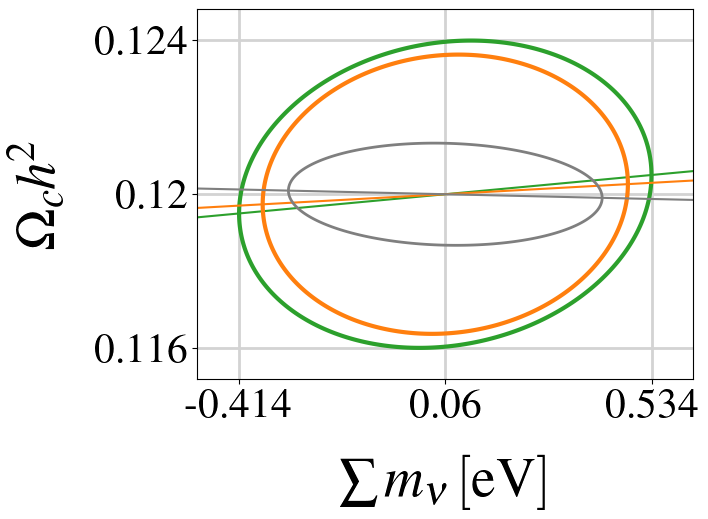

In [2138]:
p1 = 'mnu'
p2 = 'omch2'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.2*alpha


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)


xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy

xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

#print(alpha*sigmafNL, alpha*sigy)
plt.hlines([yline_min, ycenter,   yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
plt.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)
tantheta_gg = tan_theta_fisher(sigx,sigy,sigxy)
slope = tantheta_gg
xvals = np.linspace(-1,1,100)
plt.plot(xvals,  slope*xvals + (ycenter - slope*xcenter), c='tab:green')


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)
tantheta_gggvvv = tan_theta_fisher(sigx,sigy,sigxy)
slope = tantheta_gggvvv
xvals = np.linspace(-1,1,100)
plt.plot(xvals,  slope*xvals + (ycenter - slope*xcenter), c='tab:orange')

#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher, numpoints)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)

tantheta_S4 = tan_theta_fisher(sigx,sigy,sigxy)
slope = tantheta_S4
xvals = np.linspace(-1,1,100)
plt.plot(xvals,  slope*xvals + (ycenter - slope*xcenter), c='tab:gray')

plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=40)
plt.ylabel(r'$\Omega_c h^2$', labelpad = 20,fontsize=40)
plt.tick_params(axis='both', labelsize=30)
#plt.xticks([xline_min, xcenter, xline_max])
#plt.yticks([yline_min, ycenter, yline_max])
plt.xticks([xline_min, xcenter, xline_max], labels=[-0.414,0.06,0.534])
plt.yticks([yline_min, ycenter, yline_max], labels=[0.116,0.120,0.124])

#plt.title(Delta_approx[numplot], fontsize=40 )
#plt.savefig('ksz_gal_contour_S4temp_Delta0.pdf', bbox_inches='tight')



In [2212]:
p1 = 'mnu'
p2 = 'ns'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.2*alpha


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)


xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy

xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

#print(alpha*sigmafNL, alpha*sigy)
plt.hlines([yline_min, ycenter,   yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
plt.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)

#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher, numpoints)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Pgg_fk, numpoints)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=2, linestyles='dashed')

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Pgggvvv_fk, numpoints)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=2, linestyles='dotted')


plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=40)
plt.ylabel(r'$n_s$', labelpad = 20,fontsize=40)
plt.tick_params(axis='both', labelsize=30)
#plt.xticks([xline_min, xcenter, xline_max])
#plt.yticks([yline_min, ycenter, yline_max])
plt.xticks([xline_min, xcenter, xline_max], labels=[-0.414,0.06,0.534])
plt.yticks([yline_min, ycenter, yline_max], labels=[0.90,0.97,1.03])

#plt.title(Delta_approx[numplot], fontsize=40 )
#plt.savefig('ksz_gal_contour_S4temp_Delta0.pdf', bbox_inches='tight')



([<matplotlib.axis.YTick at 0x30ac0b690>,
 [Text(0, 0.8979028256775805, '0.9'),
  Text(0, 0.965, '0.97'),
  Text(0, 1.0320971743224194, '1.03')])

In [2240]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

p1 = 'mnu'
p2 = 'As'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.1*alpha


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)


xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy

xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

#print(alpha*sigmafNL, alpha*sigy)
ax1.hlines([yline_min, ycenter,   yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
ax1.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)


#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Pgg_fk, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=2, linestyles='dashed')

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Pgggvvv_fk, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=2, linestyles='dotted')


ax1.set_xlim(xlim_min, xlim_max)
ax1.set_ylim(ylim_min, ylim_max)
ax1.set_xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=30)
ax1.set_ylabel(r'$10^9 \,A_s$', labelpad = 20,fontsize=30)
ax1.tick_params(axis='both', labelsize=25)
ax1.set_xticks([xline_min, xcenter, xline_max], labels=[-0.414,0.06,0.534])
ax1.set_yticks([yline_min, ycenter, yline_max], labels=[0.61,2.20,3.79])

#########
p1 = 'mnu'
p2 = 'ns'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.1*alpha


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)


xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy

xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

#print(alpha*sigmafNL, alpha*sigy)
ax2.hlines([yline_min, ycenter,   yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
ax2.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)

#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Pgg_fk, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=2, linestyles='dashed')

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Pgggvvv_fk, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=2, linestyles='dotted')


ax2.set_xlim(xlim_min, xlim_max)
ax2.set_ylim(ylim_min, ylim_max)
ax2.set_xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=30)
ax2.set_ylabel(r'$n_s$', labelpad = 20,fontsize=30)
ax2.tick_params(axis='both', labelsize=25)
#ax2.set_xticks([xline_min, xcenter, xline_max])
#ax2.set_yticks([yline_min, ycenter, yline_max])
ax2.set_xticks([xline_min, xcenter, xline_max], labels=[-0.414,0.06,0.534])
ax2.set_yticks([yline_min, ycenter, yline_max], labels=[0.90,0.97,1.03])
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()


legend_lines = [Line2D([0], [0], color='tab:green', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:orange', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:gray', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:green', linestyle = 'dashed', lw=3),
                Line2D([0], [0], color='tab:orange', linestyle = 'dotted', lw=3)]
legend_labels = [r'$P_{gg}$',r'$P_{gg}+\rm{kSZ}$', r'S4', r'S4$+P_{gg}$', r'S4$+P_{gg}+\rm{kSZ}$' ]
plt.legend(legend_lines, legend_labels,loc='upper right', bbox_to_anchor=(1., -0.3), fontsize = 25, frameon=False, ncol=2 )



plt.subplots_adjust(wspace=0.3)

plt.savefig('mnu_As_contours.pdf', bbox_inches='tight')



In [2276]:
#trains
print(2.21+ 2.15)
print(1.53+1.52+1.52+1.51+1.51+1.52+1.52)
print(85+96.10)

4.359999999999999
10.629999999999999
181.1


In [2280]:
print(1.53+1.52+1.52+1.51+1.51+1.52+1.52 )

10.629999999999999


In [2279]:
print(94.88+96.10+2.21+2.15)

195.34


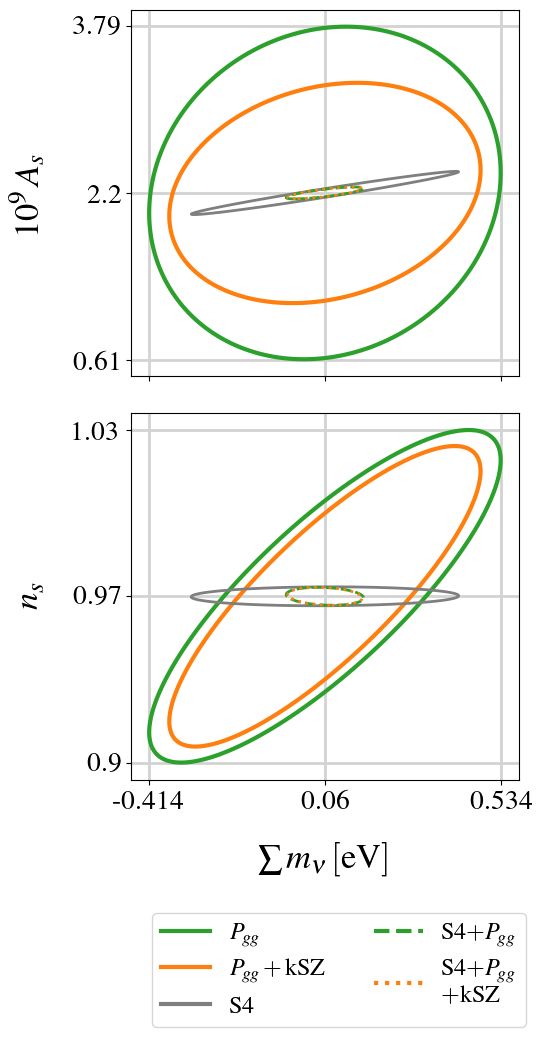

In [2801]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(5,10))

p1 = 'mnu'
p2 = 'As'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.1*alpha


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)


xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy

xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

#print(alpha*sigmafNL, alpha*sigy)
ax1.hlines([yline_min, ycenter,   yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
ax1.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)


#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Pgg_fk, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=2, linestyles='dashed')

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Pgggvvv_fk, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=2, linestyles='dotted')


ax1.set_xlim(xlim_min, xlim_max)
ax1.set_ylim(ylim_min, ylim_max)
#ax1.set_xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=30)
ax1.set_ylabel(r'$10^9 \,A_s$', labelpad = 20,fontsize=25)
ax1.tick_params(axis='both', labelsize=20)
#ax1.set_xticks([xline_min, xcenter, xline_max], labels=[-0.414,0.06,0.534])
ax1.set_xticks([xline_min, xcenter, xline_max], labels=['','',''])
ax1.set_yticks([yline_min, ycenter, yline_max], labels=[0.61,2.20,3.79])

#########
p1 = 'mnu'
p2 = 'ns'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.1*alpha


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)


xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy

xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

#print(alpha*sigmafNL, alpha*sigy)
ax2.hlines([yline_min, ycenter,   yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
ax2.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)

#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Pgg_fk, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=2, linestyles='dashed')

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Pgggvvv_fk, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=2, linestyles='dotted')


ax2.set_xlim(xlim_min, xlim_max)
ax2.set_ylim(ylim_min, ylim_max)
ax2.set_xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=25)
ax2.set_ylabel(r'$n_s$', labelpad = 20,fontsize=25)
ax2.tick_params(axis='both', labelsize=20)
#ax2.set_xticks([xline_min, xcenter, xline_max])
#ax2.set_yticks([yline_min, ycenter, yline_max])
ax2.set_xticks([xline_min, xcenter, xline_max], labels=[-0.414,0.06,0.534])
ax2.set_yticks([yline_min, ycenter, yline_max], labels=[0.90,0.97,1.03])
#ax2.yaxis.set_label_position('right')
#ax2.yaxis.tick_right()


legend_lines = [Line2D([0], [0], color='tab:green', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:orange', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:gray', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:green', linestyle = 'dashed', lw=3),
                Line2D([0], [0], color='tab:orange', linestyle = 'dotted', lw=3)]
legend_labels = [r'$P_{gg}$',r'$P_{gg}+\rm{kSZ}$', r'S4', r'S4$+P_{gg}$', r'S4$+P_{gg}$'+'\n'+r'$+\rm{kSZ}$' ]
plt.legend(legend_lines, legend_labels,loc='upper right', bbox_to_anchor=(1.05, -0.33), fontsize = 17.5, frameon=True, ncol=2 )



plt.subplots_adjust(wspace=0, hspace=0.1)

#plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_As_contours.pdf', bbox_inches='tight')



#### UNLENSED

In [2936]:
F_S4_nolensing_UNLENSED_Fisher.sigmas()

{'omch2': 0.0007899077528368377,
 'ombh2': 3.0832089444850085e-05,
 'As': 5.722431779397586e-10,
 'ns': 0.0027124927721721035,
 'tau': 0.1303585977785585,
 'H0': 3.3552849037655177,
 'mnu': 0.3567209372804015}

In [2937]:
F_Pgg_S4_nolensing_UNLENSED.sigmas()

{'As': 4.241948569464905e-10,
 'H0': 0.827228580205301,
 'b1_0.2': 0.09958954256201673,
 'b1_0.7': 0.13386342697210982,
 'b1_1.3': 0.17831921899586484,
 'b1_1.9': 0.22215066220542395,
 'b1_2.6': 0.2748915306185387,
 'bk2_0.2': 2.1212051886062318,
 'bk2_0.7': 1.091578328178412,
 'bk2_1.3': 1.327320407978783,
 'bk2_1.9': 1.5711584812470343,
 'bk2_2.6': 1.912080559246031,
 'brsd_0.2': 0.14652178657390222,
 'brsd_0.7': 0.10288458281203279,
 'brsd_1.3': 0.10556325290216496,
 'brsd_1.9': 0.10908909593192191,
 'brsd_2.6': 0.11385988389761457,
 'mnu': 0.07135493407384906,
 'ns': 0.002255451854941755,
 'ombh2': 2.941953052470384e-05,
 'omch2': 0.0007402383088685967,
 'tau': 0.09672092269239708}

In [2803]:
F_Pgg_S4_nolensing_UNLENSED = F_S4_nolensing_UNLENSED_Fisher.copy() + F_gg_dict['b_ofz_nonlin']


F_Pgggvvv_S4_nolensing_UNLENSED = F_S4_nolensing_UNLENSED_Fisher.copy() + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']

In [2838]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(5,10))

p1 = 'mnu'
p2 = 'As'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.1*alpha


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)


ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

#xlim_min = xcenter - lim_pad*sigx
#xlim_max = xcenter + lim_pad*sigx
#xline_min = xcenter - alpha*sigx
#xline_max = xcenter + alpha*sigx
xline_min = -0.4822158246662103
xline_max = 0.6022158246662104
sigx_line = (xline_min-xcenter)/(-alpha)
xlim_min = xcenter - lim_pad*sigx_line
xlim_max = xcenter + lim_pad*sigx_line


#print(alpha*sigmafNL, alpha*sigy)
ax1.hlines([yline_min, ycenter,  yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
ax1.vlines([xline_min, xcenter,  xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)


#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_UNLENSED_Fisher, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)


#xlim_min = xcenter - lim_pad*sigx
#xlim_max = xcenter + lim_pad*sigx
#xline_min = xcenter - alpha*sigx
#xline_max = xcenter + alpha*sigx
#ax1.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
#print([xline_min, xcenter, xline_max])


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_Pgg_S4_nolensing_UNLENSED, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=2, linestyles='dashed')

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_Pgggvvv_S4_nolensing_UNLENSED, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=2, linestyles='dotted')


ax1.set_xlim(xlim_min, xlim_max)
ax1.set_ylim(ylim_min, ylim_max)
#ax1.set_xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=30)
ax1.set_ylabel(r'$10^9 \,A_s$', labelpad = 20,fontsize=20)
ax1.tick_params(axis='both', labelsize=17.5)
#ax1.set_xticks([xline_min, xcenter, xline_max], labels=[-0.414,0.06,0.534])
ax1.set_xticks([xline_min, xcenter, xline_max], labels=['','',''])
ax1.set_yticks([yline_min, ycenter, yline_max], labels=[0.61,2.20,3.79])

#########
p1 = 'mnu'
p2 = 'ns'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.1*alpha


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)



ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

#xlim_min = xcenter - lim_pad*sigx
#xlim_max = xcenter + lim_pad*sigx
#xline_min = xcenter - alpha*sigx
#xline_max = xcenter + alpha*sigx
xline_min = -0.4822158246662103
xline_max = 0.6022158246662104
sigx_line = (xline_min-xcenter)/(-alpha)
xlim_min = xcenter - lim_pad*sigx_line
xlim_max = xcenter + lim_pad*sigx_line




ax2.hlines([yline_min, ycenter,   yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
ax2.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)

#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_UNLENSED_Fisher, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2, F_Pgg_S4_nolensing_UNLENSED, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=2, linestyles='dashed')

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_Pgggvvv_S4_nolensing_UNLENSED, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=2, linestyles='dotted')


ax2.set_xlim(xlim_min, xlim_max)
ax2.set_ylim(ylim_min, ylim_max)
ax2.set_xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=20)
ax2.set_ylabel(r'$n_s$', labelpad = 20,fontsize=20)
ax2.tick_params(axis='both', labelsize=17.5)
#ax2.set_xticks([xline_min, xcenter, xline_max])
#ax2.set_yticks([yline_min, ycenter, yline_max])
ax2.set_xticks([xline_min, xcenter, xline_max], labels=[-0.482,0.06,0.602])
ax2.set_yticks([yline_min, ycenter, yline_max], labels=[0.90,0.97,1.03])
#ax2.yaxis.set_label_position('right')
#ax2.yaxis.tick_right()


legend_lines = [Line2D([0], [0], color='tab:green', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:orange', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:gray', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:green', linestyle = 'dashed', lw=3),
                Line2D([0], [0], color='tab:orange', linestyle = 'dotted', lw=3)]
legend_labels = [r'$P_{gg}$',r'$P_{gg}+\rm{kSZ}$', r'S4', r'S4$+P_{gg}$', r'S4$+P_{gg}$'+'\n'+r'$+\rm{kSZ}$' ]
plt.legend(legend_lines, legend_labels,loc='upper right', bbox_to_anchor=(.9375, -0.33), fontsize = 15, frameon=True, ncol=2 )



plt.subplots_adjust(wspace=0, hspace=0.1)

#plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_As_contours_01212025.pdf', bbox_inches='tight')



In [2861]:
F_S4_nolensing_UNLENSED_Fisher.sigmas()

{'omch2': 0.0007899077528368377,
 'ombh2': 3.0832089444850085e-05,
 'As': 5.722431779397586e-10,
 'ns': 0.0027124927721721035,
 'tau': 0.1303585977785585,
 'H0': 3.3552849037655177,
 'mnu': 0.3567209372804015}

In [2862]:
F_S4_nolensing_UNLENSED_Fisher_tauprior.sigmas()

{'omch2': 0.0007854182254924083,
 'ombh2': 3.0696369320361496e-05,
 'As': 3.3386896402188157e-11,
 'ns': 0.0025585100677710496,
 'tau': 0.007495474822963184,
 'H0': 3.29082589840655,
 'mnu': 0.3503943258570429}

In [2863]:
fids_cdm['mnu'] + alpha*(F_S4_nolensing_UNLENSED_Fisher.sigmas()['mnu'])

0.6022158246662104

In [3223]:
print(fids_cdm['mnu'] + alpha*(f_cluster_S4unlensed_Fisher.sigmas()['mnu']))
print(fids_cdm['mnu'] - alpha*(f_cluster_S4unlensed_Fisher.sigmas()['mnu']))
print(fids_cdm['mnu'])

0.6061743943951254
-0.4861743943951255
0.06


In [3224]:
f_cluster_S4unlensed_Fisher.sigmas()['mnu']

0.35932525947047733

In [2866]:
print(fids_cdm['mnu'] + alpha*(F_S4_nolensing_UNLENSED_Fisher.sigmas()['mnu']))
print(fids_cdm['mnu'] - alpha*(F_S4_nolensing_UNLENSED_Fisher.sigmas()['mnu']))
print(fids_cdm['mnu'])

0.6022158246662104
-0.4822158246662103
0.06


In [3226]:
F_S4_nolensing_UNLENSED_Fisher.sigmas()['mnu']

0.3567209372804015

In [2867]:
print(fids_cdm['ns'] + alpha*(F_gg_dict['b_ofz_nonlin'].sigmas()['ns']))
print(fids_cdm['ns'] - alpha*(F_gg_dict['b_ofz_nonlin'].sigmas()['ns']))
print(fids_cdm['ns'])

1.0320971743224194
0.8979028256775805
0.965


In [2868]:
print(fids_cdm['As'] + alpha*(F_gg_dict['b_ofz_nonlin'].sigmas()['As']))
print(fids_cdm['As'] - alpha*(F_gg_dict['b_ofz_nonlin'].sigmas()['As']))
print(fids_cdm['As'])

3.790944406847076e-09
6.090555931529238e-10
2.2e-09


In [2953]:
F_Pgg_S4_nolensing_UNLENSED.sigmas()['mnu']

0.07135493407384906

In [2806]:
F_Pgggvvv_S4_nolensing_UNLENSED.sigmas()['mnu']

0.06754477649828453

In [2952]:
1-F_Pgggvvv_S4_nolensing_UNLENSED.sigmas()['mnu']/F_Pgg_S4_nolensing_UNLENSED.sigmas()['mnu']

0.05339725451390931

In [2807]:
1-67.5/71.4

0.054621848739495826

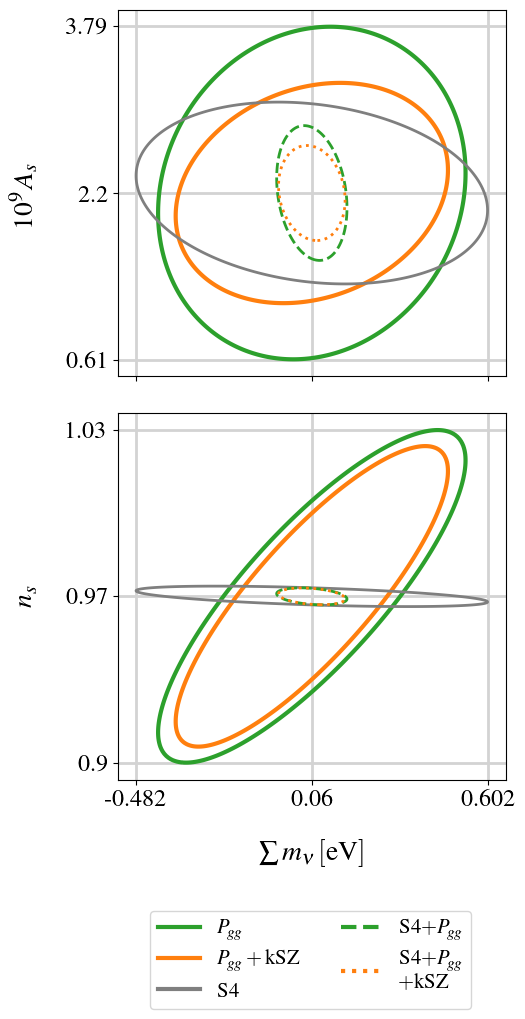

In [2871]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(5,10))

p1 = 'mnu'
p2 = 'As'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.1*alpha



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_UNLENSED_Fisher, numpoints)
xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

#xline_min = -0.4822158246662103
#xline_max = 0.6022158246662104
#sigx_line = (xline_min-xcenter)/(-alpha)
#xlim_min = xcenter - lim_pad*sigx_line
#xlim_max = xcenter + lim_pad*sigx_line


#print(alpha*sigmafNL, alpha*sigy)
ax1.hlines([yline_min, ycenter,  yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
ax1.vlines([xline_min, xcenter,  xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)


#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_UNLENSED_Fisher, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)


#xlim_min = xcenter - lim_pad*sigx
#xlim_max = xcenter + lim_pad*sigx
#xline_min = xcenter - alpha*sigx
#xline_max = xcenter + alpha*sigx
#ax1.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
#print([xline_min, xcenter, xline_max])


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_Pgg_S4_nolensing_UNLENSED, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=2, linestyles='dashed')

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_Pgggvvv_S4_nolensing_UNLENSED, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=2, linestyles='dotted')


ax1.set_xlim(xlim_min, xlim_max)
ax1.set_ylim(ylim_min, ylim_max)
#ax1.set_xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=30)
ax1.set_ylabel(r'$10^9 \,A_s$', labelpad = 20,fontsize=20)
ax1.tick_params(axis='both', labelsize=17.5)
#ax1.set_xticks([xline_min, xcenter, xline_max], labels=[-0.414,0.06,0.534])
ax1.set_xticks([xline_min, xcenter, xline_max], labels=['','',''])
ax1.set_yticks([yline_min, ycenter, yline_max], labels=[0.61,2.20,3.79])

#########
p1 = 'mnu'
p2 = 'ns'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.1*alpha


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_UNLENSED_Fisher, numpoints)
xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

#xline_min = -0.4822158246662103
#xline_max = 0.6022158246662104
#sigx_line = (xline_min-xcenter)/(-alpha)
#xlim_min = xcenter - lim_pad*sigx_line
#xlim_max = xcenter + lim_pad*sigx_line




ax2.hlines([yline_min, ycenter,   yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
ax2.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)

#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_UNLENSED_Fisher, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2, F_Pgg_S4_nolensing_UNLENSED, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=2, linestyles='dashed')

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_Pgggvvv_S4_nolensing_UNLENSED, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=2, linestyles='dotted')


ax2.set_xlim(xlim_min, xlim_max)
ax2.set_ylim(ylim_min, ylim_max)
ax2.set_xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=20)
ax2.set_ylabel(r'$n_s$', labelpad = 20,fontsize=20)
ax2.tick_params(axis='both', labelsize=17.5)
#ax2.set_xticks([xline_min, xcenter, xline_max])
#ax2.set_yticks([yline_min, ycenter, yline_max])
ax2.set_xticks([xline_min, xcenter, xline_max], labels=[-0.482,0.06,0.602])
ax2.set_yticks([yline_min, ycenter, yline_max], labels=[0.90,0.97,1.03])
#ax2.yaxis.set_label_position('right')
#ax2.yaxis.tick_right()


legend_lines = [Line2D([0], [0], color='tab:green', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:orange', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:gray', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:green', linestyle = 'dashed', lw=3),
                Line2D([0], [0], color='tab:orange', linestyle = 'dotted', lw=3)]
legend_labels = [r'$P_{gg}$',r'$P_{gg}+\rm{kSZ}$', r'S4', r'S4$+P_{gg}$', r'S4$+P_{gg}$'+'\n'+r'$+\rm{kSZ}$' ]
plt.legend(legend_lines, legend_labels,loc='upper right', bbox_to_anchor=(.9375, -0.33), fontsize = 15, frameon=True, ncol=2 )



plt.subplots_adjust(wspace=0, hspace=0.1)

plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_As_contours_01212025.pdf', bbox_inches='tight')



In [2860]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(5,10))

p1 = 'mnu'
p2 = 'As'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.1*alpha




sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx

#xline_min = -0.4822158246662103
#xline_max = 0.6022158246662104
#sigx_line = (xline_min-xcenter)/(-alpha)
#xlim_min = xcenter - lim_pad*sigx_line
#xlim_max = xcenter + lim_pad*sigx_line


#print(alpha*sigmafNL, alpha*sigy)
ax1.hlines([yline_min, ycenter,  yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
ax1.vlines([xline_min, xcenter,  xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)


#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_UNLENSED_Fisher, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)


#xlim_min = xcenter - lim_pad*sigx
#xlim_max = xcenter + lim_pad*sigx
#xline_min = xcenter - alpha*sigx
#xline_max = xcenter + alpha*sigx
#ax1.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
#print([xline_min, xcenter, xline_max])


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_Pgg_S4_nolensing_UNLENSED, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=2, linestyles='dashed')

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_Pgggvvv_S4_nolensing_UNLENSED, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=2, linestyles='dotted')


ax1.set_xlim(xlim_min, xlim_max)
ax1.set_ylim(ylim_min, ylim_max)
#ax1.set_xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=30)
ax1.set_ylabel(r'$10^9 \,A_s$', labelpad = 20,fontsize=20)
ax1.tick_params(axis='both', labelsize=17.5)
#ax1.set_xticks([xline_min, xcenter, xline_max], labels=[-0.414,0.06,0.534])
ax1.set_xticks([xline_min, xcenter, xline_max], labels=['','',''])
ax1.set_yticks([yline_min, ycenter, yline_max], labels=[0.61,2.20,3.79])

#########
p1 = 'mnu'
p2 = 'ns'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.1*alpha




sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx

#xline_min = -0.4822158246662103
#xline_max = 0.6022158246662104
#sigx_line = (xline_min-xcenter)/(-alpha)
#xlim_min = xcenter - lim_pad*sigx_line
#xlim_max = xcenter + lim_pad*sigx_line




ax2.hlines([yline_min, ycenter,   yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
ax2.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)

#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_UNLENSED_Fisher, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2, F_Pgg_S4_nolensing_UNLENSED, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=2, linestyles='dashed')

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_Pgggvvv_S4_nolensing_UNLENSED, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=2, linestyles='dotted')


ax2.set_xlim(xlim_min, xlim_max)
ax2.set_ylim(ylim_min, ylim_max)
ax2.set_xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=20)
ax2.set_ylabel(r'$n_s$', labelpad = 20,fontsize=20)
ax2.tick_params(axis='both', labelsize=17.5)
#ax2.set_xticks([xline_min, xcenter, xline_max])
#ax2.set_yticks([yline_min, ycenter, yline_max])
ax2.set_xticks([xline_min, xcenter, xline_max], labels=[-0.482,0.06,0.602])
ax2.set_yticks([yline_min, ycenter, yline_max], labels=[0.90,0.97,1.03])
#ax2.yaxis.set_label_position('right')
#ax2.yaxis.tick_right()


legend_lines = [Line2D([0], [0], color='tab:green', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:orange', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:gray', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:green', linestyle = 'dashed', lw=3),
                Line2D([0], [0], color='tab:orange', linestyle = 'dotted', lw=3)]
legend_labels = [r'$P_{gg}$',r'$P_{gg}+\rm{kSZ}$', r'S4', r'S4$+P_{gg}$', r'S4$+P_{gg}$'+'\n'+r'$+\rm{kSZ}$' ]
plt.legend(legend_lines, legend_labels,loc='upper right', bbox_to_anchor=(.9375, -0.33), fontsize = 15, frameon=True, ncol=2 )



plt.subplots_adjust(wspace=0, hspace=0.1)

#plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_As_contours_01212025.pdf', bbox_inches='tight')



#### cluster UNLENSED

In [3216]:
f_cluster_S4unlensed_Fisher.sigmas()

{'omch2': 0.0007904070025121488,
 'ombh2': 3.0681991973037295e-05,
 'As': 5.730446307476479e-10,
 'ns': 0.0027540716846626736,
 'tau': 0.13054743777515238,
 'H0': 3.3844680201370556,
 'mnu': 0.35932525947047733}

In [3227]:
1 - F_S4_nolensing_UNLENSED_Fisher.sigmas()['mnu']/f_cluster_S4unlensed_Fisher.sigmas()['mnu']

0.007247812730765801

In [3219]:
del(F_Pgggvvv_cluster_S4_nolensing_UNLENSED)

In [3220]:
F_Pgg_S4_cluster_nolensing_UNLENSED = f_cluster_S4unlensed_Fisher.copy() + F_gg_dict['b_ofz_nonlin']


F_Pgggvvv_S4_cluster_nolensing_UNLENSED = f_cluster_S4unlensed_Fisher.copy() + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']

-0.4861743943951255 0.6061743943951254
6.090555931529238e-10 3.790944406847076e-09
-0.4861743943951255 0.6061743943951254
0.8979028256775805 1.0320971743224194


python(21411) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21412) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21413) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21414) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21415) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(21416) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


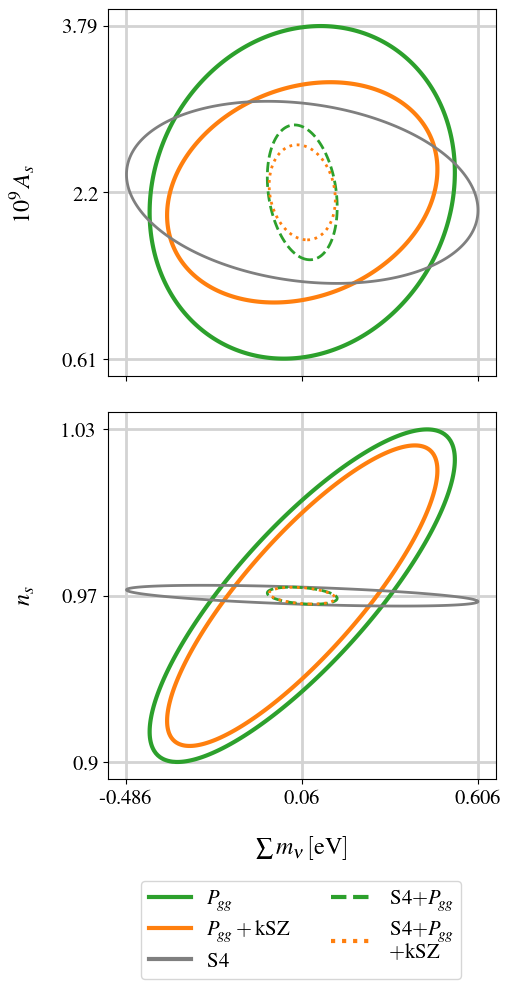

In [3433]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(5,10))

p1 = 'mnu'
p2 = 'As'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.1*alpha



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,f_cluster_S4unlensed_Fisher, numpoints)
xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx
print(xline_min, xline_max)

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy
print(yline_min, yline_max)

#xline_min = -0.4822158246662103
#xline_max = 0.6022158246662104
#sigx_line = (xline_min-xcenter)/(-alpha)
#xlim_min = xcenter - lim_pad*sigx_line
#xlim_max = xcenter + lim_pad*sigx_line


#print(alpha*sigmafNL, alpha*sigy)
ax1.hlines([yline_min, ycenter,  yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
ax1.vlines([xline_min, xcenter,  xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)


#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,f_cluster_S4unlensed_Fisher, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)


#xlim_min = xcenter - lim_pad*sigx
#xlim_max = xcenter + lim_pad*sigx
#xline_min = xcenter - alpha*sigx
#xline_max = xcenter + alpha*sigx
#ax1.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
#print([xline_min, xcenter, xline_max])


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_Pgg_S4_cluster_nolensing_UNLENSED, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=2, linestyles='dashed')

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_Pgggvvv_S4_cluster_nolensing_UNLENSED, numpoints)
ax1.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=2, linestyles='dotted')


ax1.set_xlim(xlim_min, xlim_max)
ax1.set_ylim(ylim_min, ylim_max)
#ax1.set_xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=30)
ax1.set_ylabel(r'$10^9 \,A_s$', labelpad = 20,fontsize=17.5)
ax1.tick_params(axis='both', labelsize=15)
#ax1.set_xticks([xline_min, xcenter, xline_max], labels=[-0.414,0.06,0.534])
ax1.set_xticks([xline_min, xcenter, xline_max], labels=['','',''])
ax1.set_yticks([yline_min, ycenter, yline_max], labels=[0.61,2.20,3.79])

#########
p1 = 'mnu'
p2 = 'ns'
numpoints=400
xcenter = fids_cdm[p1]
ycenter = fids_cdm[p2]
alpha=1.52
lim_pad=1.1*alpha


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,f_cluster_S4unlensed_Fisher, numpoints)
xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx
print(xline_min, xline_max)


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy
print(yline_min, yline_max)

#xline_min = -0.4822158246662103
#xline_max = 0.6022158246662104
#sigx_line = (xline_min-xcenter)/(-alpha)
#xlim_min = xcenter - lim_pad*sigx_line
#xlim_max = xcenter + lim_pad*sigx_line




ax2.hlines([yline_min, ycenter,   yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
ax2.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)

#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_S4_nolensing_Fisher_tauprior, numpoints)
sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,f_cluster_S4unlensed_Fisher, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:gray',linewidths=2)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2, F_Pgg_S4_cluster_nolensing_UNLENSED, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=2, linestyles='dashed')

sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_Pgggvvv_S4_cluster_nolensing_UNLENSED, numpoints)
ax2.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=2, linestyles='dotted')


ax2.set_xlim(xlim_min, xlim_max)
ax2.set_ylim(ylim_min, ylim_max)
ax2.set_xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=17.5)
ax2.set_ylabel(r'$n_s$', labelpad = 20,fontsize=17.5)
ax2.tick_params(axis='both', labelsize=15)
#ax2.set_xticks([xline_min, xcenter, xline_max])
#ax2.set_yticks([yline_min, ycenter, yline_max])
ax2.set_xticks([xline_min, xcenter, xline_max], labels=[-0.486,0.06,0.606])
ax2.set_yticks([yline_min, ycenter, yline_max], labels=[0.90,0.97,1.03])
#ax2.yaxis.set_label_position('right')
#ax2.yaxis.tick_right()


legend_lines = [Line2D([0], [0], color='tab:green', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:orange', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:gray', linestyle = 'solid', lw=3),
                Line2D([0], [0], color='tab:green', linestyle = 'dashed', lw=3),
                Line2D([0], [0], color='tab:orange', linestyle = 'dotted', lw=3)]
legend_labels = [r'$P_{gg}$',r'$P_{gg}+\rm{kSZ}$', r'S4', r'S4$+P_{gg}$', r'S4$+P_{gg}$'+'\n'+r'$+\rm{kSZ}$' ]
plt.legend(legend_lines, legend_labels,loc='upper right', bbox_to_anchor=(.9375, -0.25), fontsize = 15, frameon=True, ncol=2 )



plt.subplots_adjust(wspace=0, hspace=0.1)

plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_As_contours_01282025.pdf', bbox_inches='tight')



In [2260]:
F_gg_dict['b_ofz_nonlin'].keys()

Index(['As', 'H0', 'b1_0.2', 'b1_0.7', 'b1_1.3', 'b1_1.9', 'b1_2.6', 'bk2_0.2',
       'bk2_0.7', 'bk2_1.3', 'bk2_1.9', 'bk2_2.6', 'brsd_0.2', 'brsd_0.7',
       'brsd_1.3', 'brsd_1.9', 'brsd_2.6', 'mnu', 'ns', 'ombh2', 'omch2',
       'tau'],
      dtype='object')

In [ ]:
F_gggvvv_dict['mq_nonlin_S4_lmax6500_Nvv']

([<matplotlib.axis.YTick at 0x30e1d3650>,
 [Text(0, 0.7545745352034627, '0.75'),
  Text(0, 1.05, '1.05'),
  Text(0, 1.3454254647965374, '1.35')])

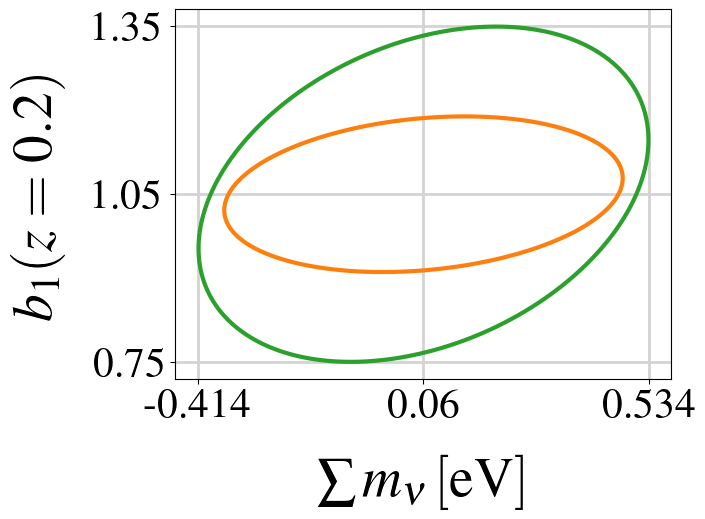

In [2275]:
p1 = 'mnu'
z_to_use = 0.2
p2 = 'b1_'+str(z_to_use)
numpoints=400
if p1 in fids_cdm.keys():
    xcenter = fids_cdm[p1]
else:
    xcenter_manual = b[z_to_use]
    xcenter = xcenter_manual

if p2 in fids_cdm.keys():
    ycenter = fids_cdm[p2]
else:
    ycenter_manual = b[z_to_use]
    ycenter = ycenter_manual


alpha=1.52
lim_pad=1.1*alpha


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['b_ofz_nonlin'], numpoints)


xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy

xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

#print(alpha*sigmafNL, alpha*sigy)
plt.hlines([yline_min, ycenter,   yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
plt.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'], numpoints)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)


#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['mq_nonlin'], numpoints)
#plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3, linestyles='dashed')

#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['mq_nonlin_S4_lmax6500_Nvv'], numpoints)
#plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3, linestyles='dashed')


plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=40)
plt.ylabel(r'$b_1(z=0.2)$', labelpad = 20,fontsize=40)
plt.tick_params(axis='both', labelsize=30)
#plt.xticks([xline_min, xcenter, xline_max])
#plt.yticks([yline_min, ycenter, yline_max])
plt.xticks([xline_min, xcenter, xline_max], labels=[-0.414,0.06,0.534])
plt.yticks([yline_min, ycenter, yline_max], labels=[0.75,1.05,1.35])

#plt.title(Delta_approx[numplot], fontsize=40 )
#plt.savefig('ksz_gal_contour_S4temp_Delta0.pdf', bbox_inches='tight')



In [2269]:
p1 = 'mnu'
z_to_use = 0.2
p2 = 'q'
numpoints=400
if p1 in fids_cdm.keys():
    xcenter = fids_cdm[p1]
else:
    xcenter_manual = b[z_to_use]
    xcenter = xcenter_manual

if p2 in fids_cdm.keys():
    ycenter = fids_cdm[p2]
else:
    ycenter_manual = b[z_to_use]
    ycenter = q_fid


alpha=1.52
lim_pad=1.1*alpha


sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['mq_nonlin'], numpoints)


xlim_min = xcenter - lim_pad*sigx
xlim_max = xcenter + lim_pad*sigx
ylim_min = ycenter - lim_pad*sigy
ylim_max = ycenter + lim_pad*sigy

xline_min = xcenter - alpha*sigx
xline_max = xcenter + alpha*sigx
yline_min = ycenter - alpha*sigy
yline_max = ycenter + alpha*sigy

#print(alpha*sigmafNL, alpha*sigy)
plt.hlines([yline_min, ycenter,   yline_max], xlim_min, xlim_max, color='lightgray',lw=2)
plt.vlines([xline_min, xcenter, xline_max], ylim_min, ylim_max, color='lightgray',lw=2)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3)



sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['mq_nonlin_S4_lmax6500_Nvv'], numpoints)
plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3)


#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gg_dict['mq_nonlin'], numpoints)
#plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:green',linewidths=3, linestyles='dashed')

#sigx,sigy,xgrid,ygrid,chi2grid,sigxy = get_contour(p1, p2,F_gggvvv_dict['mq_nonlin_S4_lmax6500_Nvv'], numpoints)
#plt.contour(xgrid + xcenter, ygrid + ycenter, chi2grid,[0,2.3],colors='tab:orange',linewidths=3, linestyles='dashed')


plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_min, ylim_max)
plt.xlabel(r'$\sum m_\nu \, [ \rm{eV} ]$',labelpad = 20,fontsize=40)
plt.ylabel(r'$b_1(z=0.2)$', labelpad = 20,fontsize=40)
plt.tick_params(axis='both', labelsize=30)
#plt.xticks([xline_min, xcenter, xline_max])
plt.yticks([yline_min, ycenter, yline_max])
plt.xticks([xline_min, xcenter, xline_max], labels=[-0.414,0.06,0.534])
#plt.yticks([yline_min, ycenter, yline_max], labels=[0.75,1.05,1.35])

#plt.title(Delta_approx[numplot], fontsize=40 )
#plt.savefig('ksz_gal_contour_S4temp_Delta0.pdf', bbox_inches='tight')



([<matplotlib.axis.XTick at 0x30e2c6910>,
 [Text(-0.19915618301994686, 0, '-0.414'),
  Text(0.06, 0, '0.06'),
  Text(0.31915618301994686, 0, '0.534')])

In [2272]:
F_gg_dict['mq_nonlin'].sigmas()

{'m': 0.08417658269164625,
 'q': 0.11373669023565038,
 'brsd': 0.13352786070749942,
 'bk2': 1.2737064692842912,
 'As': 6.186804442630598e-10,
 'H0': 4.839421905156847,
 'ombh2': 0.0005419765161961621,
 'omch2': 0.0023826049284414023,
 'ns': 0.02234480080282309,
 'tau': 82.01179971420999,
 'mnu': 0.1704974888289124}

In [2273]:
F_gg_dict['b_ofz_nonlin'].sigmas()

{'As': 1.0466739518730763e-09,
 'H0': 29.60665011366093,
 'b1_0.2': 0.19435885841877454,
 'b1_0.7': 0.2589470301035716,
 'b1_1.3': 0.3665941389084374,
 'b1_1.9': 0.47300376960521334,
 'b1_2.6': 0.5964225861732827,
 'bk2_0.2': 3.0936815575015677,
 'bk2_0.7': 2.5168761171087404,
 'bk2_1.3': 3.0228504006367496,
 'bk2_1.9': 3.8398510751868744,
 'bk2_2.6': 5.170245903095392,
 'brsd_0.2': 0.4673221272226352,
 'brsd_0.7': 0.24509814908613936,
 'brsd_1.3': 0.1956286750167041,
 'brsd_1.9': 0.1991146600770404,
 'brsd_2.6': 0.20933990352495524,
 'mnu': 0.31204527498913287,
 'ns': 0.04414287784369703,
 'ombh2': 0.0005999470048293903,
 'omch2': 0.0026145792501783287,
 'tau': 95.69690899172423}

In [2270]:
F_gggvvv_dict['mq_nonlin_S4_lmax6500_Nvv'].sigmas()

{'m': 0.04985845458082802,
 'q': 0.06813226963599886,
 'brsd': 0.07945316218429499,
 'bk2': 1.1053430565041937,
 'bv': 0.06969538242407967,
 'As': 3.142852397554701e-10,
 'H0': 2.8031277765003666,
 'ombh2': 0.0005094775528991092,
 'omch2': 0.0022852459956170575,
 'ns': 0.01893529265965683,
 'tau': 21.651059545966284,
 'mnu': 0.13632947397868536}

In [2271]:
F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv'].sigmas()

{'As': 6.932270940244111e-10,
 'H0': 24.514343574574273,
 'b1_0.2': 0.09022677754618626,
 'b1_0.7': 0.14328638808188512,
 'b1_1.3': 0.23063936353272832,
 'b1_1.9': 0.3113880073123128,
 'b1_2.6': 0.40053662621743014,
 'bk2_0.2': 2.602779460255171,
 'bk2_0.7': 2.252359921786528,
 'bk2_1.3': 2.632247772961964,
 'bk2_1.9': 3.426418186633637,
 'bk2_2.6': 4.613453942789956,
 'brsd_0.2': 0.3537658282509297,
 'brsd_0.7': 0.14308905352323545,
 'brsd_1.3': 0.09532563423515814,
 'brsd_1.9': 0.11446687452048504,
 'brsd_2.6': 0.13467252741095845,
 'bv_0.2': 0.0920908006466444,
 'bv_0.7': 0.09062842542064645,
 'bv_1.3': 0.11955178703847688,
 'bv_1.9': 0.13366220594906686,
 'bv_2.6': 0.1415105663777002,
 'mnu': 0.2763411322463361,
 'ns': 0.03988907981611633,
 'ombh2': 0.0005241705754313635,
 'omch2': 0.0023759065982474157,
 'tau': 22.231984196474503}

In [2115]:
np.linspace(-0.5,0.5,100)

array([-0.5       , -0.48989899, -0.47979798, -0.46969697, -0.45959596,
       -0.44949495, -0.43939394, -0.42929293, -0.41919192, -0.40909091,
       -0.3989899 , -0.38888889, -0.37878788, -0.36868687, -0.35858586,
       -0.34848485, -0.33838384, -0.32828283, -0.31818182, -0.30808081,
       -0.2979798 , -0.28787879, -0.27777778, -0.26767677, -0.25757576,
       -0.24747475, -0.23737374, -0.22727273, -0.21717172, -0.20707071,
       -0.1969697 , -0.18686869, -0.17676768, -0.16666667, -0.15656566,
       -0.14646465, -0.13636364, -0.12626263, -0.11616162, -0.10606061,
       -0.0959596 , -0.08585859, -0.07575758, -0.06565657, -0.05555556,
       -0.04545455, -0.03535354, -0.02525253, -0.01515152, -0.00505051,
        0.00505051,  0.01515152,  0.02525253,  0.03535354,  0.04545455,
        0.05555556,  0.06565657,  0.07575758,  0.08585859,  0.0959596 ,
        0.10606061,  0.11616162,  0.12626263,  0.13636364,  0.14646465,
        0.15656566,  0.16666667,  0.17676768,  0.18686869,  0.19

In [2117]:
plt.plot(np.linspace(-0.5,0.5,100) , 2.5*np.linspace(-0.5,0.5,100))
plt.ylim()

(-1.375, 1.375)

In [ ]:

figsize_x = 5
figsize_y = figsize_x #(1/golden_rat)*figsize_x
fig, ax1 = plt.subplots(1,1, figsize=(figsize_x,figsize_y))

#experiments = [r'S4', r'$\vec{\cal{O}}$', r'$\vec{\cal{O}}+P_{gg}$', r'$\vec{\cal{O}}+P_{gg}+\rm{kSZ}$' ]
experiments = [r'Planck$+$BAO', r'Planck$+$BAO$+P_{gg}$', r'Planck$+$BAO$+P_{gg}$+kSZ' ]
exp_colors = ['tab:gray', 'tab:green', 'tab:orange' ]

#
mnu_constraints = np.array([F_Planck_DR3_plik_TTTEEE_lowl_lowE_lensing_LCDM_mnu_full.sigmas()['mnu'] , F_BAO_Planck_withlensing_Pgg.sigmas()['mnu'] , F_BAO_Planck_withlensing_Pgggvvv.sigmas()['mnu']])
#
ax1.barh(experiments, mnu_constraints, color=exp_colors, alpha = 1 )
ax1.invert_yaxis()
#ax1.set_yticks(y_pos, labels=experiments)
#ax1.set_ylabel(r'Experimental Configuration', labelpad=xpad_base, fontsize=xfontsize_base)
ax1.set_xlabel(r'$\sigma(\sum m_{\nu})\, [\mathrm{eV}]$', labelpad=ypad_base, fontsize=yfontsize_base)


#
mnu_ratios = mnu_constraints/mnu_constraints[0]
#mnu_ratios_tau = mnu_constraints_tau/mnu_constraints_tau[0]
#
ax2=ax1.twiny()
ax2.barh(experiments, mnu_ratios, color=exp_colors, hatch='x' )
#ax2.barh(experiments, mnu_ratios_tau, color=exp_colors,  hatch ='x' )
#ax2.set_yticks(y_pos, labels=experiments)
ax2.set_xlabel(r'$\sigma(\sum m_{\nu}) / \sigma(\sum m_{\nu}) [\rm{Planck}+\rm{BAO})]$', labelpad=xpad_base, fontsize=xfontsize_base)
plt.subplots_adjust(left=0.0, right=1)


plt.savefig('/Users/averytishue/Research_Selim/ksz_mnu/mnu_Planck.pdf', bbox_inches='tight')


### LCDM extensions

In [1946]:
#S4 with omega_k, w0, nnu
F_S4_LCDMextend_load = np.load('/Users/averytishue/FisherLens/CLASS_delens/results/fisher_8p_1exp_GALIfids_withlensing_LCDMextend.pkl',allow_pickle=True)
F_S4_LCDMextend = F_S4_LCDMextend_load['fisherGaussian'][0]['lensed']
F_S4_LCDMextend = fsky *  F_S4_LCDMextend
F_S4_LCDMextend_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu', 'ok', 'w0']
F_S4_LCDMextend_Fisher = FisherMatrix(F_S4_LCDMextend , F_S4_LCDMextend_keys)
#right now, w0 isnt working, so lets ignore it
F_S4_LCDMextend_Fisher_nnu_omk = F_S4_LCDMextend_Fisher.copy()
F_S4_LCDMextend_Fisher_nnu_omk.delete('w0')
F_S4_LCDMextend_Fisher_nnu_omk.sigmas()


{'omch2': 0.0009225715150504486,
 'ombh2': 4.2098904368392554e-05,
 'nnu': 0.03832057349617907,
 'As': 6.812474908948861e-11,
 'ns': 0.0035287566363733573,
 'tau': 0.0157724952533823,
 'H0': 1.1024889853935882,
 'mnu': 0.10725796756539971,
 'ok': 0.00018355796973749323}

In [1945]:
F_S4_LCDMextend_load['cosmoParams']

['omega_c_h2',
 'omega_b_h2',
 'N_eff',
 'A_s',
 'n_s',
 'tau',
 'H0',
 'mnu',
 'omk',
 'w0_fld']

In [1928]:
latex_mapping = {
    'omch2': '$\\Omega_c h^2$',
    'ombh2': '$\\Omega_b h^2$',
    'H0': '$H_0$',
    'ns': '$n_s$',
    'As': '$A_s$',
    'mnu': '$\\Sigma m_{\\nu}$',
    'w0': '$w_0$',
    'wa': '$w_a$',
    'tau':'$\\tau$',
    'nnu':'$N_{\\rm eff}$',
    'ok':'$\\Omega_k$',
    'r':'$r$',
    'cs2':'$c_s^2$',
    'thetastar': '$\\theta^*$',
    'ctheta': '$\\theta_{\\rm COSMOMC}$',
    's8': '$\\sigma_8$',
    'om': '$\\Omega_m$',
    's8om0.25': '$\\sigma_8 \\Omega_m^{0.25}$',
}
'''
__file__ = '/folder_that_includes_your_pyfisher/pyfisher/pyfisher/'
'''
__file__ = '/Users/averytishue/pyfisher/pyfisher/'

def get_lensing_nl(exp):
    exp = exp.strip().lower()
    froot = os.path.dirname(__file__)+"/data/lensing_nl/"
    if exp=='planck':
        return np.loadtxt(f'{froot}planck_2018_mv_nlkk.dat',usecols=[0,1],unpack=True)
    elif exp=='act_dr6':
        return np.loadtxt(f'{froot}act_dr6.txt',usecols=[0,1],unpack=True)
    elif exp=='so_goal':
        return np.loadtxt(f'{froot}so_v3_1_deproj0_goal_fsky0p4_it.dat',usecols=[0,7],unpack=True)
    elif exp=='s4':
        return np.loadtxt(f'{froot}s4_noise.dat',usecols=[0,7],unpack=True)

def bin1d(bin_edges,ix,iy,stat=np.nanmean):
    numbins = len(bin_edges)-1
    cents = (bin_edges[:-1]+bin_edges[1:])/2.
    bin_edges_min = bin_edges.min()
    bin_edges_max = bin_edges.max()
    x = ix.copy()
    y = iy.copy()
    # this just prevents an annoying warning (which is otherwise informative) everytime
    # all the values outside the bin_edges are nans
    y[x<bin_edges_min] = 0
    y[x>bin_edges_max] = 0
    # pretty sure this treats nans in y correctly, but should double-check!
    bin_means = binnedstat(x,y,bins=bin_edges,statistic=stat)[0]
    return cents,bin_means


def mkdir(dirpath,comm=None):
    if comm is None:
        from . import mpi
        comm = mpi.MPI.COMM_WORLD
    exists = os.path.exists(dirpath)
    comm.Barrier()
    if comm.Get_rank()==0: 
        if not (exists):
            os.makedirs(dirpath)
    return exists

def interp(x,y,bounds_error=False,fill_value=0.,**kwargs):
    return interp1d(x,y,bounds_error=bounds_error,fill_value=fill_value,**kwargs)

def gauss_beam(ell,fwhm):
    """
    Map-level beam transfer function B(ell) for FWHM in arcminutes.
    """
    tht_fwhm = np.deg2rad(fwhm / 60.)
    return np.exp(-(tht_fwhm**2.)*(ell**2.) / (16.*np.log(2.)))


def prepare_output(args, message="",allow_changes=False):
    output_path = args.output
    assert output_path.strip()[-1]!='/'
    mkdir(f'{output_path}')
    rname = os.path.basename(f'{output_path}')
    with open(f'{output_path}/info.log','w') as f:
        f.write(f'{message}\n')
        now = datetime.datetime.now()
        f.write(f'Current date and time : {now.strftime("%Y-%m-%d %H:%M:%S")}\n')
        for arg in vars(args):
            f.write(f'{arg} :  {getattr(args, arg)}\n')
        info = get_info(path=os.path.realpath(__file__))
        if not(allow_changes): assert not(info['changes']), "Git must not have changes to run this script."
        f.write(pretty_info(info))
    output_root = f'{output_path}/{rname}'
    return output_root

def contour_plot(fisher,fiducials,fname,name='',add_marker=False,latex=True):
    from chainconsumer import ChainConsumer
    mean = [fiducials[key] for key in fisher.params]
    cov = np.linalg.inv(fisher.values)
    parameters = [latex_mapping[x] for x in fisher.params] if latex else fisher.params

    c = ChainConsumer()
    c.add_covariance(mean, cov, parameters=parameters, name=name,shade=False)
    if add_marker: c.add_marker(mean, parameters=parameters, marker_style="*", marker_size=100, color="r",name='')
    c.configure(usetex=False, serif=False,sigma2d=True,sigmas=[1])
    fig = c.plotter.plot()
    fig.set_size_inches(3 + fig.get_size_inches()) 
    fig.savefig(fname)


def get_fiducials(root_name='v20201120'):
    param_file = f'{data_dir}{root_name}_cmb_derivs/params.txt'
    _,fids = get_param_info(param_file,exclude=None)
    return fids


def get_saved_fisher(name,fsky=None,root_name='v20201120'):
    if name=='planck_lowell':
        fsky = 1 if fsky is None else fsky
        return fsky * read_fisher(f'{data_dir}{root_name}_saved_cmb/{root_name}_saved_cmb_planck_low_ell_TT_fullsky.txt',delim=',')
    elif name=='planck_highell':
        fsky = 1 if fsky is None else fsky
        return fsky * read_fisher(f'{data_dir}{root_name}_saved_cmb/{root_name}_saved_cmb_planck_high_ell_TTEETE_fullsky.txt',delim=',')
    elif name=='desi_bao':
        assert fsky is None
        return read_fisher(f'{data_dir}{root_name}_{name}/{root_name}_{name}_bao_fisher.txt',delim=',')
    elif name=='boss_bao':
        assert fsky is None
        return read_fisher(f'{data_dir}{root_name}_{name}/{root_name}_{name}_bao_fisher.txt',delim=',')

def get_lensing_fisher(bin_edges,ells,nls,fsky,root_name='v20201120',interpolate=True,errs=None):
    param_file = f'{data_dir}{root_name}_cmb_derivs/params.txt'
    _,fids = get_param_info(param_file,exclude=None)
    param_list = list(fids.keys())
    cls = load_theory_dict(f'{data_dir}{root_name}_cmb_derivs/{root_name}_cmb_derivs_cmb_fiducial.txt',ells)
    dcls = load_derivs(f'{data_dir}{root_name}_cmb_derivs',param_list,ells)
    if errs is None:
        nl_dict = {'kk':interp(ells,nls,bounds_error=True)}
        F = band_fisher(param_list,bin_edges,['kk'],cls,nl_dict,dcls,interpolate=interpolate)  * fsky
    else:
        assert fsky is None
        F = band_fisher(param_list,bin_edges,['kk'],None,None,dcls,interpolate=interpolate,errs=errs)
    return F

def get_lensing_sn(bin_edges,ells,nls,fsky,interpolate=False,root_name='v20201120'):
    cents,bin = get_binner(bin_edges,interpolate)
    nls_dict = {'kk':interp(ells,nls,bounds_error=True)}
    cls = load_theory_dict(f'{data_dir}{root_name}_cmb_derivs/{root_name}_cmb_derivs_cmb_fiducial.txt',ells)
    cov = gaussian_band_covariance(bin_edges,['kk'],cls,nls_dict,interpolate=interpolate) / fsky
    cinv = np.linalg.inv(cov)
    clkk = bin(cls['kk'])[...,None]
    return np.sqrt(np.einsum('ik,ik->',np.einsum('ij,ijk->ik',clkk,cinv),clkk))
    

def check_fisher_sanity(fmat,param_list):
    Ny,Nx = fmat.shape
    assert Ny==Nx
    assert Ny==len(param_list)
    assert len(param_list)==len(set(param_list))

def write_fisher(filename,fmat,delim=','):
    np.savetxt(filename,fmat,header=(delim).join(fmat.params),delimiter=delim)

def read_fisher(csv_file,delim=','):
    fmat = np.loadtxt(csv_file,delimiter=delim)
    with open(csv_file) as f:
        fline = f.readline()
    fline = fline.replace("#","")
    columns = fline.strip().split(delim)
    assert len(set(columns)) == len(columns)
    return FisherMatrix(fmat = fmat,param_list = columns)

def rename_fisher(fmat,pmapping):
    old_params = fmat.params
    new_params = list(old_params)
    for key in pmapping.keys():
        if key not in old_params: continue
        i = old_params.index(key)
        new_params[i] = pmapping[key]
    return FisherMatrix(fmat=fmat.values,param_list=new_params)
    
class FisherMatrix(DataFrame):
    """
    A Fisher Matrix object that subclasses pandas.DataFrame.
    This is essentially just a structured array that
    has identical column and row labels.

    You can initialize an empty one like:
    >> params = ['H0','om','sigma8']
    >> F = FisherMatrix(np.zeros((len(params),len(params))),params)
    
    where params is a list of parameter names. If you already have a
    Fisher matrix 'Fmatrix' whose diagonal parameter order is specified by
    the list 'params', then you can initialize this object as:
    
    >> F = FisherMatrix(Fmatrix,params)
    
    This makes the code 'aware' of the parameter order in a way that makes
    handling combinations of Fishers a lot easier.
    
    You can set individual elements like:
    
    >> F['s8']['H0'] = 1.

    Once you've populated the entries, you can do things like:
    >> Ftot = F1 + F2
    i.e. add Fisher matrices. The nice property here is that you needn't
    have initialized these objects with the same list of parameters!
    They can, for example, have mutually exclusive parameters, in which
    case you end up with some reordering of a block diagonal Fisher matrix.
    In the general case, of two overlapping parameter lists that don't
    have the same ordering, pandas will make sure the objects are added
    correctly.

    WARNING: No other operation other than addition and multiplication is overloaded. Subtraction
    for instance will give unpredictable behaviour. (Will likely introduce
    NaNs) But you shouldn't be subtracting Fisher matrices anyway!

    You can add a gaussian prior to a parameter:
    >> F.add_prior('H0',2.0)

    You can drop an entire parameter (which removes that row and column):
    >> F.delete('s8')
    which does it in place.

    If you want to preserve the original before modifying, you can
    >> Forig = F.copy()

    You can get marginalized errors on each parameter as a dict:
    >> sigmas = F.sigmas()


    """
    
    def __init__(self,fmat,param_list,delete_params=None,prior_dict=None):
        """
        fmat            -- (n,n) shape numpy array containing initial Fisher matrix for n parameters
        param_list      -- n-element list specifying diagonal order of fmat
        delete_params   -- list of names of parameters you would like to delete from this 
                        Fisher matrix when you initialize it. 
        prior_dict      -- a dictionary that maps names of parameters to 1-sigma prior values
                        you would like to add on initialization. This can also be done later with the 
                        add_prior function.
	"""
	
	
        check_fisher_sanity(fmat,param_list)
        pd.DataFrame.__init__(self,fmat.copy(),columns=param_list,index=param_list)
        try:
            a = self.params
            raise ValueError # self.params should not already exist
        except:
            pass

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.params = param_list
            
        cols = self.columns.tolist()
        ind = self.index.tolist()
        assert set(self.params)==set(cols)
        assert set(self.params)==set(ind)

        if delete_params is not None:
            self.delete(delete_params)
        if prior_dict is not None:
            for prior in prior_dict.keys():
                self.add_prior(prior,prior_dict[prior])

            
    def copy(self):
        """
        >> Fnew = F.copy()
        will create an independent Fnew that is not a view of the original.
        """
        f = FisherMatrix(pd.DataFrame.copy(self), list(self.params))
        return f

    def __radd__(self,other):
        # raise NotImplementedError
        return self._add(other,radd=True)

    def __add__(self,other):
        return self._add(other,radd=False)

    def __mul__(self,other):
        return FisherMatrix(self.values*other,self.columns.tolist())

    def __rmul__(self,other):
        return FisherMatrix(self.values*other,self.columns.tolist())

    def _add(self,other,radd=False):
        # if other is None: return self
        # odf = pd.DataFrame(data = other.values,columns=other.columns,index=other.index)
        # tdf = pd.DataFrame(data = self.values,columns=self.columns,index=self.index)
        # new_fpd = tdf.add(odf,fill_value=0)
        if other is None: return self
        F1 = pd.DataFrame(self.values,columns=self.params,index=self.params)
        F2 = pd.DataFrame(other.values,columns=other.params,index=other.params)
        if radd:
            new_fpd = pd.DataFrame.radd(F1,F2,fill_value=0)
        else:
            new_fpd = pd.DataFrame.add(F1,F2,fill_value=0)
        return FisherMatrix(new_fpd.values,new_fpd.columns.tolist())

    def add_prior(self,param,prior,warn=True):
        """
        Adds 1-sigma value 'prior' to the parameter name specified by 'param'
        """
        try:
            self[param][param] += 1./prior**2.
        except KeyError:
            if warn: print(f"WARNING: skipping prior for {param} since it was not found")
        
    def sigmas(self):
        """
        Returns marginalized 1-sigma uncertainties on each parameter in the Fisher matrix.
        """
        finv = np.linalg.inv(self.values)
        err2 = np.diagonal(finv)
        assert np.all(err2>0)
        errs = err2**(0.5)
        return dict(zip(self.params,errs))
    
    def delete(self,params):
        """
        Given a list of parameter names 'params', deletes these from the Fisher matrix.
        """
        self.drop(labels=params,axis=0,inplace=True)
        self.drop(labels=params,axis=1,inplace=True)
        self.params = self.columns.tolist()
        assert set(self.index.tolist())==set(self.params)

    def reordered(self,params):
        # Return a reordered version of self
        return self[params].T[params]

    def marge_var_2param(self,param1,param2):
        """
        Returns the sub-matrix corresponding to two parameters param1 and param2.
        Useful for contour plots.
        """
        finv = np.linalg.inv(self.values)
        i = self.params.index(param1)
        j = self.params.index(param2)
        chi211 = finv[i,i]
        chi222 = finv[j,j]
        chi212 = finv[i,j]
        return np.array([[chi211,chi212],[chi212,chi222]])


def get_planck_cmb_fisher(param_list,bin_edges,specs,root_name,fsky,interpolate=True):
    ells = np.arange(0,bin_edges.max()+1)
    nls = get_planck_nls(ells)
    cls = load_theory_dict(f'{root_name}/{os.path.basename(root_name)}_cmb_fiducial.txt',ells)
    dcls = load_derivs(root_name,param_list,ells)
    return band_fisher(param_list,bin_edges,specs,cls,nls,dcls,interpolate=interpolate)  * fsky


def load_derivs(root_name,param_list,ells):
    dcls = {}
    for param in param_list:
        dcls[param] = load_theory_dict(f'{root_name}/{os.path.basename(root_name)}_cmb_{param}_deriv.txt',ells)
    return dcls


def load_theory_dict(fname,ells):
    cls = {}
    ells,tt,ee,bb,te,kk = np.loadtxt(fname,unpack=True)
    cls['TT'] = interp(ells,tt)
    cls['EE'] = interp(ells,ee)
    cls['BB'] = interp(ells,bb)
    cls['TE'] = interp(ells,te)
    cls['kk'] = interp(ells,kk)
    return cls


def get_planck_nls(ells):
    beams_T =  [33.,23.,14.,10.,7.,5.,5.]
    uK_arcmins_T = [145.,149.,137.,65.,43.,66.,200.]
    beams_P =  [14.,10.,7.,5.,5.]
    uK_arcmins_P = [450.,103.,81.,134.,406.]
    Ns_TT = np.asarray([(uK_arcmin*np.pi/180./60.)**2./gauss_beam(ells,fwhm)**2. for uK_arcmin,fwhm in zip(uK_arcmins_T,beams_T)])
    Ns_PP = np.asarray([(uK_arcmin*np.pi/180./60.)**2./gauss_beam(ells,fwhm)**2. for uK_arcmin,fwhm in zip(uK_arcmins_P,beams_P)])
    N_TT = 1./(1./Ns_TT).sum(axis=0)
    N_PP = 1./(1./Ns_PP).sum(axis=0)
    nls = {}
    nls['TT'] = interp(ells,N_TT)
    nls['EE'] = interp(ells,N_PP)
    nls['BB'] = interp(ells,N_PP)
    return nls


def gaussian_band_covariance(bin_edges,specs,cls_dict,nls_dict,interpolate=False):

    cents,bin = get_binner(bin_edges,interpolate)
    delta_ell = np.diff(bin_edges)
    nbins = len(bin_edges) - 1

    def _symmz(cdict,ab):
        try:
            return bin(cdict[ab])
        except KeyError:
            try:
                return bin(cdict[ab[::-1]])
            except KeyError:
                return np.zeros((nbins,))
            
    
    ncomps = len(specs)
    cov = np.zeros((nbins,ncomps,ncomps))
    for i in range(ncomps):
        for j in range(i,ncomps):
            spec1 = specs[i]
            spec2 = specs[j]

            a,b = spec1
            g,d = spec2

            ag = a+g
            bd = b+d
            ad = a+d
            bg = b+g

            cl_ag = _symmz(cls_dict,ag)
            nl_ag = _symmz(nls_dict,ag)
            cl_bd = _symmz(cls_dict,bd)
            nl_bd = _symmz(nls_dict,bd)
            cl_ad = _symmz(cls_dict,ad)
            nl_ad = _symmz(nls_dict,ad)
            cl_bg = _symmz(cls_dict,bg)
            nl_bg = _symmz(nls_dict,bg)

            cov[:,i,j] = ((cl_ag+nl_ag)*(cl_bd+nl_bd)+(cl_ad+nl_ad)*(cl_bg+nl_bg))/(2*cents+1)/delta_ell
            if i!=j: cov[:,j,i] = cov[:,i,j].copy()
    return cov


def band_fisher(param_list,bin_edges,specs,cls_dict,nls_dict,derivs_dict,interpolate=True,errs=None,cov=None):

    cents,bin = get_binner(bin_edges,interpolate)
    nbins = len(bin_edges) - 1
    ncomps = len(specs)

    if errs is None:
        cov = gaussian_band_covariance(bin_edges,specs,cls_dict,nls_dict,interpolate=interpolate)
    else:
        assert cls_dict is None
        assert nls_dict is None
        cov = (errs**2.)[:,None,None]
    cinv = np.linalg.inv(cov)

    nparams = len(param_list)
    Fisher = np.zeros((nparams,nparams))
    for i in range(nparams):
        for j in range(i,nparams):

            param1 = param_list[i]
            param2 = param_list[j]
            dcls1 = np.zeros((nbins,ncomps))
            dcls2 = np.zeros((nbins,ncomps))
            for k,spec in enumerate(specs):
                dcls1[:,k] = bin(derivs_dict[param1][spec])
                dcls2[:,k] = bin(derivs_dict[param2][spec])

            Fisher[i,j] = np.einsum('ik,ik->',np.einsum('ij,ijk->ik',dcls1,cinv),dcls2)
            if i!=j: Fisher[j,i] = Fisher[i,j]

    return FisherMatrix(Fisher,param_list)




def get_param_info(param_file,exclude=None,get_range=False):
    param_dat = np.genfromtxt(param_file,dtype=None,encoding='utf-8',delimiter=',')
    jobs = []
    if not(get_range): jobs.append((None,None,'f'))
    fids = {}
    for p in param_dat:
        param = p[0]
        if exclude is not None:
            if param in exclude:
                print(f"Skipping {param}")
                continue
        fid = p[1]
        fids[param] = fid
        pstr = str(p[2]).strip()
        if pstr[-1]=='%': 
            step = float(pstr[:-1])*np.abs(fid)/100.
        else:
            step = float(pstr)
        assert step>0
        if get_range:
            jobs.append((param,fid-step,fid+step))
        else:
            jobs.append((param,fid+step,'u'))
            jobs.append((param,fid-step,'d'))
    return jobs,fids

def _camb_to_class(params):
    if params['thetastar'] is not None:
        params['100*theta_s'] = params.pop('thetastar')*100.
    else:
        params.pop('thetastar')
    if params['ctheta'] is not None:
        params['100*theta_s'] = params.pop('ctheta')*100.
        warnings.warn('Replacing CLASS 100*theta_s with cosmomc_theta')
    else:
        params.pop('ctheta')
    if params['H0'] is None:
        params.pop('H0')
    params['A_s'] = params.pop('As')
    params['n_s'] = params.pop('ns')
    params['Omega_cdm'] = params.pop('omch2')
    params['omega_b'] = params.pop('ombh2')
    params['tau_reio'] = params.pop('tau')
    params['Omega_k'] = params.pop('ok')
    params['N_ur'] = params.pop('nnu')
    #params['m_ncdm'] = ','.join([str(params.pop('mnu')/3.)]*3)
    params['N_ncdm'] = 1
    params['m_ncdm'] = params.pop('mnu')
    
    # params['use_ppf'] = 'no'
    # params['fluid_equation_of_state'] = 'CLP'
    # params['w0_fld'] = params.pop('w0')
    # params['wa_fld'] = params.pop('wa')
    # params['cs2_fld'] = params.pop('cs2')

    # params.pop('mnu')
    # DARK ENERGY AND R NOT SUPPORTED
    params.pop('w0')
    params.pop('wa')
    params.pop('cs2')
    params.pop('r')
    return params


def map_params(params,engine='camb'):
    checksum = 0
    try:
        assert params['H0']
        checksum = checksum + 1
    except:
        pass
    try:
        assert params['thetstar']
        checksum = checksum + 1
    except:
        pass
    try:
        assert params['ctheta']
        checksum = checksum + 1
    except:
        pass
    assert checksum <= 1
    if params is None: params = dict({})
    params = set_defaults(params)
    if engine=='camb':
        return params
    elif engine=='class':
        return _camb_to_class(params)


def set_defaults(params):
    ds = {
        'omch2': 0.1203058,
        'ombh2': 0.02219218,
        'H0': 67.02393,
        'ns': 0.9625356,
        'As': 2.15086031154146e-9,
        'mnu': 0.06,
        'w0': -1.0,
        'wa': 0.0,
        'tau':0.06574325,
        'nnu':3.046,
        'ok':0,
        'r':0,
        'cs2':1.0,
        'thetastar': None,
        'ctheta': None
    }
    for key in ds.keys():
        if key not in params.keys(): params[key] = ds[key]
    return params

    
    

def set_camb_pars(params=None,de='ppf'):
    """
    We only allow an As,ns,omch2,ombh2,H0,tau,mnu,w0,wa,omk,r,ctheta,nnu,
    cs2,thetastar parametrization. (ctheta=cosmomc_theta)
    Any other parameterization has to be obtained by transforming the Fisher matrix.
    """
    import camb
    from camb import model
    if params is None: params = dict({})
    params = set_defaults(params)
    pars = camb.CAMBparams()
    #This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
    pars.set_cosmology(H0=params['H0'], ombh2=params['ombh2'], 
                       omch2=params['omch2'], mnu=params['mnu'], 
                       omk=params['ok'], tau=params['tau'],nnu=params['nnu'],
                       cosmomc_theta=params['ctheta'],thetastar=params['thetastar'])
    pars.InitPower.set_params(As=params['As'], ns=params['ns'], r=params['r'])
    if params['r']>0: pars.WantTensors = True
    pars.set_dark_energy(w=params['w0'], wa=params['wa'], cs2=params['cs2'],dark_energy_model=de)
    return pars


def get_s8(zs=[0.],params=None,nonlinear=False,kmax=5.2,**kwargs):
    import camb
    from camb import model
    zs = np.asarray(zs)
    zdiffs = np.diff(zs)
    if np.all(zdiffs>0):
        rev = True
    elif np.all(zdiffs<0):
        rev = False
    else:
        raise ValueError
    pars = set_camb_pars(params=params,**kwargs)
    pars.set_matter_power(redshifts=zs,kmax=kmax,nonlinear=nonlinear,silent=True)
    if nonlinear: 
        pars.NonLinear = model.NonLinear_both
    else:
        pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    s8 = np.array(results.get_sigma8())
    return s8[::-1] if rev else s8

def get_bao_dr12(params=None,engine='camb',de='ppf',rs_fid = 147.78,zs=[0.38,0.51,0.61]):
    import camb
    params = map_params(params,engine=engine)
    zs = np.asarray(zs)
    if engine=='camb':
        pars = set_camb_pars(params=params,de=de)
        results = camb.get_results(pars)
        rdrag = results.get_derived_params()['rdrag']
        rs_rescale = 1 / rs_fid
        rs = rdrag * rs_rescale
        retdict = {}
        retdict["DM_over_rs"] = np.zeros((zs.size,))
        retdict["bao_Hz_rs"] = np.zeros((zs.size,))
        for i,z in enumerate(zs):
            retdict["DM_over_rs"][i] = (1 + z) * results.angular_diameter_distance(z) / rs
            retdict["bao_Hz_rs"][i] = results.hubble_parameter(z) * rs
    else:
        raise NotImplementedError
    return zs,retdict

def get_bao_rs_dV(zs,params=None,engine='camb',de='ppf'):
    #FIXME: camb and class only agree at 3% level!!!
    import camb
    params = map_params(params,engine=engine)
    if engine=='camb':
        pars = set_camb_pars(params=params,de=de)
        results = camb.get_results(pars)
        retval = results.get_BAO(zs,pars)[:,0]
    elif engine=='class':
        from classy import Class
        zs = np.asarray(zs)
        cosmo = Class()
        params['output'] = ''
        cosmo.set(params)
        cosmo.compute()
        Hzs = np.array([cosmo.Hubble(z) for z in zs])
        D_As = np.array([cosmo.angular_distance(z) for z in zs])
        D_Vs = ((1+zs)**2 * D_As**2 * zs/Hzs)**(1/3.)
        retval = cosmo.rs_drag()/D_Vs
        cosmo.struct_cleanup()
        cosmo.empty()
    return retval


def get_bao_fisher_rs_dV_diagonal(param_list,deriv_theory,fiducial_theory,sigma_percents):
    nparams = len(param_list)
    Fisher = np.zeros((nparams,nparams))
    sigmas = sigma_percents*fiducial_theory/100.
    for i in range(nparams):
        for j in range(i,nparams):
            param1 = param_list[i]
            param2 = param_list[j]
            rsdV1 = deriv_theory[param1]
            rsdV2 = deriv_theory[param2]
            Fz = (rsdV1*rsdV2/sigmas**2.).sum()
            Fisher[i,j] = Fz
            if i!=j: Fisher[j,i] = Fz
    return FisherMatrix(Fisher,param_list)

def load_bao_experiment_rs_dV_diagonal(exp_name,data_path,boss_include=['6df','mgs','lowz','cmass']):
    if exp_name=='desi':
        zs,sig_pers = np.loadtxt(f'{data_path}/desi.txt',unpack=True)
    elif exp_name=='boss':
        array = np.genfromtxt(f'{data_path}/boss.txt',delimiter=',',dtype=None,encoding='utf-8')
        zs = []
        sig_pers = []
        for line in array:
            if line[0]  in boss_include: 
                zs.append(line[1])
                sig_pers.append(line[2])
    else:
        raise ValueError
    return np.asarray(zs),np.asarray(sig_pers)

def get_cls(params=None,lmax=3000,accurate=False,engine='camb',de='ppf',nonlinear=True):
    from camb import model
    params = map_params(params,engine=engine)
    if engine=='camb':
        pars = set_camb_pars(params=params,de=de)
        if accurate:
            pars.set_accuracy(AccuracyBoost=3.0, lSampleBoost=1.0, lAccuracyBoost=3.0)
            pars.set_for_lmax(lmax=int(lmax+500), lens_potential_accuracy=3.0, max_eta_k=20000)
        else:
            pars.set_accuracy(AccuracyBoost=1.0, lSampleBoost=1.0, lAccuracyBoost=1.0)
            pars.set_for_lmax(lmax=int(lmax+500), lens_potential_accuracy=1, max_eta_k=2*lmax)
        if nonlinear:
            pars.NonLinear = model.NonLinear_both
        else:
            pars.NonLinear = model.NonLinear_none
        return load_theory(pars,lpad=lmax+2)
        
    elif engine=='class':
        from classy import Class
        cosmo = Class()
        params['output'] = 'lCl,tCl,pCl'
        params['lensing'] = 'yes'
        params['non linear'] = 'hmcode'
        params['l_max_scalars'] = lmax
        cosmo.set(params)
        cosmo.compute()
    return retval


def deriv_s8_wrt_param(iparam,deriv_root):
    if iparam in ['As','ns','omch2','ombh2','ok','mnu','w0','wa','nnu','ctheta','thetastar','cs2','H0']:
        try:
            val = np.loadtxt(f"{data_dir}{deriv_root}/{deriv_root}_fitderiv_s8_wrt_{iparam}.txt")
        except:
            print("Couldn't find ", f"{data_dir}{deriv_root}/{deriv_root}_fitderiv_s8_wrt_{iparam}.txt")
            raise ValueError
        assert val.size==1
        return val.ravel()[0]
    elif iparam in ['tau','r']:
        return 0.
    else:
        print("s8",iparam)
        raise ValueError

def deriv_om_wrt_param(iparam,fiducials,verbose=True):
    if iparam=='om': 
        return 1
    fs = fiducials
    h = fs['H0']/100.
    oc = fs['omch2'] / h**2.
    ob = fs['ombh2'] / h**2.
    om = oc+ob
    s8 = fs['s8']
    if iparam=='omch2':
        return 1./(h**2.)
    elif iparam=='ombh2':
        return 1./(h**2.)
    elif iparam=='H0':
        return 0
    else:
        if verbose: print(f'Setting om w.r.t. {iparam} to zero.')
        return 0
    

def get_itrans_deriv(oparam,iparam,fiducials,deriv_root,verbose=True):
    """
    The matrix is output/input

    So it has elements like

    ds8/dAs, dom/d(omc*h**2), ds8/d(omc*h**2)

    This typically has to be inverted.
    """

    if iparam==oparam: 
        return 1

    fs = fiducials
    h = fs['H0']/100.
    oc = fs['omch2'] / h**2.
    ob = fs['ombh2'] / h**2.
    om = oc+ob
    s8 = fs['s8']
    if oparam=='om':
        return deriv_om_wrt_param(iparam,fiducials,verbose=verbose)
    elif oparam=='omch2' and iparam=='om':
        return 1./deriv_om_wrt_param(oparam,fiducials,verbose=verbose)
    elif oparam=='ombh2' and iparam=='om':
        return 1./deriv_om_wrt_param(oparam,fiducials,verbose=verbose)
    elif oparam=='omch2' and iparam=='H0':
        return 2. * h * oc / 100.
    elif oparam=='ombh2' and iparam=='H0':
        return 2. * h * ob / 100.
    elif oparam=='H0' and iparam=='ombh2':
        return 1./(2. * h * ob / 100.)
    elif oparam=='H0' and iparam=='omch2':
        return 1./(2. * h * oc / 100.)
    elif oparam=='s8':
        return deriv_s8_wrt_param(iparam,deriv_root)
    elif oparam[:4]=='s8om':
        ind = float(oparam[4:])
        return ((om**ind) * deriv_s8_wrt_param(iparam,deriv_root)) + (s8 * ind * (om**(ind-1.)) * deriv_om_wrt_param(iparam,fiducials,verbose=verbose))
    else:
        if verbose: print(f'Setting {oparam} w.r.t. {iparam} to zero.')
        return 0.
    

def reparameterize(Fmat,oparams,fiducials,deriv_root='v20201120_s8_derivs',verbose=True):
    """
    Re-parameterize a Fisher matrix.
    iparams must only contain CAMB primitives
    like As,ns,omch2,ombh2,H0,tau,mnu,w0,wa,omk,r.
    oparams can contain those as well as
    s8
    om
    """
    iparams = Fmat.params
    onum = len(oparams)
    inum = len(iparams)
    iM = np.zeros((onum,inum))
    for i in range(onum):
        for j in range(inum):
            val = get_itrans_deriv(oparams[i],iparams[j],fiducials,deriv_root,verbose=verbose)
            iM[i,j] = val
    M = np.linalg.pinv(iM)
    interm = np.dot(M.T,Fmat)
    repar = FisherMatrix(np.dot(interm,M),oparams)
    return repar


def load_theory(pars,lpad=9000):
    '''
    All ell and 2pi factors are stripped off.
    '''

    import camb
    from camb import model
    uSuffix = "unlensed_total"
    lSuffix = "total"

    results = camb.get_results(pars)
    cmbmat = results.get_cmb_power_spectra(pars,lmax=lpad,spectra=['total','unlensed_total','lens_potential'],raw_cl=True,CMB_unit='muK')

    theory = TheorySpectra()
    for i,pol in enumerate(['TT','EE','BB','TE']):
        cls =cmbmat[lSuffix][:,i]
        ells = np.arange(0,len(cls),1)
        theory.loadCls(ells,cls,pol,lensed=True,interporder="linear",lpad=lpad,fill_zero=True)
        cls = cmbmat[uSuffix][:,i]
        ells = np.arange(0,len(cls),1)
        theory.loadCls(ells,cls,pol,lensed=False,interporder="linear",lpad=lpad,fill_zero=True)

    lensArr = cmbmat['lens_potential']
    cldd = lensArr[:,0]
    ells = np.arange(0,len(cldd),1)
    clkk = cldd.copy()
    clkk[1:] = clkk[1:] / 4. * (ells[1:]*(ells[1:]+1))**2.
    theory.loadGenericCls(ells,clkk,"kk",lpad=lpad,fill_zero=True)
    theory.dimensionless = False
    return theory






def get_binner(bin_edges,interpolate):
    cents = (bin_edges[1:] + bin_edges[:-1])/2.
    if interpolate:
        bin = lambda x: x(cents)
    else:
        ells = np.arange(bin_edges[0],bin_edges[-1]+1,1)
        bin = lambda x: bin1d(bin_edges,ells,x(ells))[1]
    return cents, bin


# COPIED FROM ACTSIMS
def pretty_info(info):
    name = info['package'] if info['package'] is not None else info['path']
    pstr = f'\n{name}'
    pstr = pstr + '\n'+''.join(["=" for x in range(len(name))])
    for key in info.keys():
        if key=='package': continue
        pstr = pstr + '\n' + f'\t{key:<10}{str(info[key]):<40}'
    return pstr

# COPIED FROM ACTSIMS
def get_info(package=None,path=None,validate=True):
    import git
    import importlib
    info = {}
    if package is None:
        assert path is not None, "One of package or path must be specified."
        path = os.path.dirname(path)
        version = None
    else:
        mod = importlib.import_module(package)
        try:
            version = mod.__version__
        except AttributeError:
            version = None
        path = mod.__file__
        path = os.path.dirname(path)
    info['package'] = package
    info['path'] = path
    info['version'] = version
    try:
        repo = git.Repo(path,search_parent_directories=True)
        is_git = True
    except git.exc.InvalidGitRepositoryError:
        is_git = False
    info['is_git'] = is_git
    if is_git:
        chash = str(repo.head.commit)
        untracked = len(repo.untracked_files)>0
        changes = len(repo.index.diff(None))>0
        branch = str(repo.active_branch)
        info['hash'] = chash
        info['untracked'] = untracked
        info['changes'] = changes
        info['branch'] = branch
    else:
        if validate:
            assert version is not None
            assert 'site-packages' in path
    return info
    

def validate_map_type(mapXYType):
    assert not(re.search('[^TEB]', mapXYType)) and (len(mapXYType)==2), \
      mapXYType+"\" is an invalid map type. XY must be a two" + \
      " letter combination of T, E and B. e.g TT or TE."

class TheorySpectra:
    '''
    Essentially just an interpolator that takes a CAMB-like
    set of discrete Cls and provides lensed and unlensed Cl functions
    for use in integrals
    '''
    

    def __init__(self):

        self.always_unlensed = False
        self.always_lensed = False
        self._uCl={}
        self._lCl={}
        self._gCl = {}


    def loadGenericCls(self,ells,Cls,keyName,lpad=9000,fill_zero=True):
        if not(fill_zero):
            fillval = Cls[ells<lpad][-1]
            print(fillval)
            print(ells[ells<lpad],Cls[ells<lpad])
            self._gCl[keyName] = lambda x: np.piecewise(x, [x<=lpad,x>lpad], [lambda y: interp1d(ells[ells<lpad],Cls[ells<lpad],bounds_error=False,fill_value=0.)(y),lambda y: fillval*(lpad/y)**4.])
            print(self._gCl[keyName](ells[ells<lpad]))

        else:
            fillval = 0.            
            self._gCl[keyName] = interp1d(ells[ells<lpad],Cls[ells<lpad],bounds_error=False,fill_value=fillval)
        

        

    def gCl(self,keyName,ell):

        if len(keyName)==3:
            # assume uTT, lTT, etc.
            ultype = keyName[0].lower()
            if ultype=="u":
                return self.uCl(keyName[1:],ell)
            elif ultype=="l":
                return self.lCl(keyName[1:],ell)
            else:
                raise ValueError
        
        try:
            return self._gCl[keyName](ell)
        except:
            return self._gCl[keyName[::-1]](ell)
        
    def loadCls(self,ell,Cl,XYType="TT",lensed=False,interporder="linear",lpad=9000,fill_zero=True):

        # Implement ellnorm

        mapXYType = XYType.upper()
        validate_map_type(mapXYType)


        if not(fill_zero):
            fillval = Cl[ell<lpad][-1]
            f = lambda x: np.piecewise(x, [x<=lpad,x>lpad], [lambda y: interp1d(ell[ell<lpad],Cl[ell<lpad],bounds_error=False,fill_value=0.)(y),lambda y: fillval*(lpad/y)**4.])

        else:
            fillval = 0.            
            f = interp1d(ell[ell<lpad],Cl[ell<lpad],bounds_error=False,fill_value=fillval)
                    
        if lensed:
            self._lCl[XYType]=f
        else:
            self._uCl[XYType]=f

    def _Cl(self,XYType,ell,lensed=False):

            
        mapXYType = XYType.upper()
        validate_map_type(mapXYType)

        if mapXYType=="ET": mapXYType="TE"
        ell = np.array(ell)

        try:
            if lensed:    
                retlist = np.array(self._lCl[mapXYType](ell))
                return retlist
            else:
                retlist = np.array(self._uCl[mapXYType](ell))
                return retlist

        except:
            zspecs = ['EB','TB']
            if (XYType in zspecs) or (XYType[::-1] in zspecs):
                return ell*0.
            else:
                raise

    def uCl(self,XYType,ell):
        if self.always_lensed:
            assert not(self.always_unlensed)
            return self.lCl(XYType,ell)
        return self._Cl(XYType,ell,lensed=False)
    def lCl(self,XYType,ell):
        if self.always_unlensed:
            assert not(self.always_lensed)
            return self.uCl(XYType,ell)
        return self._Cl(XYType,ell,lensed=True)
    


In [1931]:
import pyfisher as pyf


#data_dir = '/folder_that_includes_your_pyfisher/pyfisher/pyfisher/data/'
data_dir = '/Users/averytishue/Research_Pete/pyfisher/pyfisher/data/'
print(data_dir)

def get_saved_fisher(name,fsky=None,root_name='v20201120'):
    if name=='planck_lowell':
        fsky = 1 if fsky is None else fsky
        return fsky * read_fisher(f'{data_dir}{root_name}_saved_cmb/{root_name}_saved_cmb_planck_low_ell_TT_fullsky.txt',delim=',')
    elif name=='planck_highell':
        fsky = 1 if fsky is None else fsky
        return fsky * read_fisher(f'{data_dir}{root_name}_saved_cmb/{root_name}_saved_cmb_planck_high_ell_TTEETE_fullsky.txt',delim=',')
    elif name=='desi_bao':
        assert fsky is None
        return read_fisher(f'{data_dir}{root_name}_{name}/{root_name}_{name}_bao_fisher.txt',delim=',')
    elif name=='boss_bao':
        assert fsky is None
        return read_fisher(f'{data_dir}{root_name}_{name}/{root_name}_{name}_bao_fisher.txt',delim=',')

/Users/averytishue/Research_Pete/pyfisher/pyfisher/data/


In [1948]:
F_BAO_LCDMextend_load = get_saved_fisher('desi_bao')
print(F_BAO_LCDMextend_load.keys())
F_BAO_LCDMextend = F_BAO_LCDMextend_load.copy()
F_BAO_LCDMextend.delete('wa')

Index(['omch2', 'ombh2', 'H0', 'mnu', 'w0', 'wa', 'nnu', 'ok'], dtype='object')


In [1949]:
F_BAO_LCDMextend

omch2         ombh2            H0           mnu             w0  \
omch2   73079.238084  5.812943e+05   -949.850493   -769.846907  -15437.018732   
ombh2  581294.334168  1.241537e+07 -17328.993630 -29969.165142 -383764.954034   
H0       -949.850493 -1.732899e+04     24.605520     39.917511     528.004879   
mnu      -769.846907 -2.996917e+04     39.917511     81.087553     961.315137   
w0     -15437.018732 -3.837650e+05    528.004879    961.315137   12071.200545   
nnu      2994.213507  6.961471e+04    -96.365275   -171.703280   -2166.463338   
ok     -19775.820935 -5.333219e+05    728.708988   1359.109586   16872.618618   

                nnu             ok  
omch2   2994.213507  -19775.820935  
ombh2  69614.710096 -533321.937656  
H0       -96.365275     728.708988  
mnu     -171.703280    1359.109586  
w0     -2166.463338   16872.618618  
nnu      391.872747   -3020.453683  
ok     -3020.453683   23649.829486

In [1950]:
F_BAO_LCDMextend_nnu_ok=F_BAO_LCDMextend.copy()
F_BAO_LCDMextend_nnu_ok.delete('w0')

In [1951]:
F_BAO_LCDMextend_nnu_ok

omch2         ombh2            H0           mnu           nnu  \
omch2   73079.238084  5.812943e+05   -949.850493   -769.846907   2994.213507   
ombh2  581294.334168  1.241537e+07 -17328.993630 -29969.165142  69614.710096   
H0       -949.850493 -1.732899e+04     24.605520     39.917511    -96.365275   
mnu      -769.846907 -2.996917e+04     39.917511     81.087553   -171.703280   
nnu      2994.213507  6.961471e+04    -96.365275   -171.703280    391.872747   
ok     -19775.820935 -5.333219e+05    728.708988   1359.109586  -3020.453683   

                  ok  
omch2  -19775.820935  
ombh2 -533321.937656  
H0        728.708988  
mnu      1359.109586  
nnu     -3020.453683  
ok      23649.829486

In [1961]:
F_BAO_LCDMextend_nnu_ok.sigmas()

{'omch2': 27578.349866304314,
 'ombh2': 7233.7137496706455,
 'H0': 13527803.804991145,
 'mnu': 3462014.430817053,
 'nnu': 5915568.639449381,
 'ok': 84.34885968651572}

In [1962]:
F_S4_withlensing_Pgg_nnu_omk = F_S4_LCDMextend_Fisher_nnu_omk + F_BAO_LCDMextend_nnu_ok + F_gg_dict['b_ofz_nonlin_LCDMextend']
F_S4_withlensing_Pgg_nnu_omk.delete('w0')
#F_S4_withlensing_Pgg_nnu_omk = F_S4_withlensing_Pgg_nnu_omk.copy()
F_S4_withlensing_Pgg_nnu_omk.add_prior('tau',tau_prior_planck)

/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [1954]:
F_S4_withlensing_Pgg_nnu_omk.sigmas()['mnu']

0.025647545645223237

In [1960]:
F_S4_LCDMextend_Fisher_nnu_omk.sigmas()

{'omch2': 0.0009225715150504486,
 'ombh2': 4.2098904368392554e-05,
 'nnu': 0.03832057349617907,
 'As': 6.812474908948861e-11,
 'ns': 0.0035287566363733573,
 'tau': 0.0157724952533823,
 'H0': 1.1024889853935882,
 'mnu': 0.10725796756539971,
 'ok': 0.00018355796973749323}

In [1953]:
F_S4_withlensing_Pgggvvv_nnu_omk = F_S4_LCDMextend_Fisher_nnu_omk + F_BAO_LCDMextend_nnu_ok + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_LCDMextend']
F_S4_withlensing_Pgggvvv_nnu_omk.delete('w0')
F_S4_withlensing_Pgggvvv_nnu_omk = F_S4_withlensing_Pgggvvv_nnu_omk.copy()
F_S4_withlensing_Pgggvvv_nnu_omk.add_prior('tau',tau_prior_planck)

/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [1955]:
F_S4_withlensing_Pgggvvv_nnu_omk.sigmas()['mnu']

0.025521989719930374

In [1963]:
25.52/25.65

0.9949317738791423

In [1957]:
F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_LCDMextend'].sigmas()['mnu']

0.3665776010050447

In [1958]:
F_gg_dict['b_ofz_nonlin_LCDMextend'].sigmas()['mnu']

0.41995783070187176

In [1959]:
366/420.

0.8714285714285714

In [1965]:
F_S4_withlensing_Pgg_nnu_omk.sigmas()

{'As': 2.4185225535371015e-11,
 'H0': 0.2573066233497599,
 'b1_0.2': 0.0131840571284671,
 'b1_0.7': 0.007878854987977923,
 'b1_1.3': 0.009273079179026795,
 'b1_1.9': 0.011407465721092705,
 'b1_2.6': 0.014154474921135918,
 'bk2_0.2': 2.016854368950505,
 'bk2_0.7': 0.9865006642070427,
 'bk2_1.3': 1.0388676136507375,
 'bk2_1.9': 1.2961099065137478,
 'bk2_2.6': 1.7311548139491217,
 'brsd_0.2': 0.1126997356105328,
 'brsd_0.7': 0.04565558520507685,
 'brsd_1.3': 0.042258821049824945,
 'brsd_1.9': 0.04934181180333281,
 'brsd_2.6': 0.060999389979266946,
 'mnu': 0.025647545645223237,
 'nnu': 0.03232399746057195,
 'ns': 0.0027094105931490375,
 'ok': 0.00016913768869735902,
 'ombh2': 3.890725961922923e-05,
 'omch2': 0.0005533276863125076,
 'tau': 0.005841904861346048}

In [1964]:
F_S4_withlensing_Pgggvvv_nnu_omk.sigmas()

{'As': 2.4009908100679243e-11,
 'H0': 0.25639740678925865,
 'b1_0.2': 0.011540495860324606,
 'b1_0.7': 0.0075190603339216604,
 'b1_1.3': 0.009144728720084871,
 'b1_1.9': 0.011338404524483517,
 'b1_2.6': 0.0141078802869521,
 'bk2_0.2': 1.852810353543843,
 'bk2_0.7': 0.9413165371392118,
 'bk2_1.3': 1.0215825368952782,
 'bk2_1.9': 1.286756533859316,
 'bk2_2.6': 1.72532981542685,
 'brsd_0.2': 0.06324586068604998,
 'brsd_0.7': 0.0317439539085689,
 'brsd_1.3': 0.03708041874865086,
 'brsd_1.9': 0.04669500108036801,
 'brsd_2.6': 0.05951199866010761,
 'bv_0.2': 0.015977869838339535,
 'bv_0.7': 0.007951491058128984,
 'bv_1.3': 0.009746907288342915,
 'bv_1.9': 0.013826508717654224,
 'bv_2.6': 0.019365294050260336,
 'mnu': 0.025521989719930374,
 'nnu': 0.032215800004034845,
 'ns': 0.00270480850462231,
 'ok': 0.00016897849353467102,
 'ombh2': 3.888170450010972e-05,
 'omch2': 0.0005494620779865629,
 'tau': 0.005797587643848331}

# LCDM extend 1.4 unlensed no Kappa

In [3015]:
#my S4 without lensing
F_S4_nolensing_UNLENSED_1p4_OmkNeff_load = np.load('/Users/averytishue/FisherLens/CLASS_delens/results/fisher_8p_1exp_test_01242025_OmkNeff.pkl',allow_pickle=True)
F_S4_nolensing_UNLENSED_1p4_OmkNeff = F_S4_nolensing_UNLENSED_1p4_OmkNeff_load['fisherGaussian'][0]['unlensed']
F_S4_nolensing_UNLENSED_1p4_OmkNeff = fsky *  F_S4_nolensing_UNLENSED_1p4_OmkNeff
F_S4_nolensing_UNLENSED_1p4_OmkNeff_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu', 'ok']
F_S4_nolensing_UNLENSED_1p4_OmkNeff_Fisher = FisherMatrix(F_S4_nolensing_UNLENSED_1p4_OmkNeff , F_S4_nolensing_UNLENSED_1p4_OmkNeff_keys)
#F_S4_nolensing_UNLENSED_1p4_OmkNeff_Fisher.delete('nnu')
#F_S4_nolensing_UNLENSED_1p4_OmkNeff_Fisher.sigmas()

In [3016]:
F_S4_nolensing_UNLENSED_1p4_OmkNeff_Fisher.keys()

Index(['omch2', 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu', 'ok'], dtype='object')

In [3017]:
F_gg_dict['b_ofz_nonlin_LCDMextend'].keys()

Index(['As', 'H0', 'b1_0.2', 'b1_0.7', 'b1_1.3', 'b1_1.9', 'b1_2.6', 'bk2_0.2',
       'bk2_0.7', 'bk2_1.3', 'bk2_1.9', 'bk2_2.6', 'brsd_0.2', 'brsd_0.7',
       'brsd_1.3', 'brsd_1.9', 'brsd_2.6', 'mnu', 'nnu', 'ns', 'ok', 'ombh2',
       'omch2', 'tau', 'w0'],
      dtype='object')

In [3006]:
extend_test = F_S4_nolensing_UNLENSED_1p4_OmkNeff_Fisher + F_gg_dict['b_ofz_nonlin_LCDMextend']
extend_test.delete('w0')
extend_test.sigmas()['mnu']

0.0761458126317815

In [3007]:
extend_test = F_S4_nolensing_UNLENSED_1p4_OmkNeff_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_LCDMextend']
extend_test.delete('w0')
extend_test.sigmas()['mnu']

0.07252823052657625

In [3008]:
1 - 0.07252823052657625/0.0761458126317815


0.04750861511845428

In [3009]:
extend_test = F_S4_nolensing_UNLENSED_1p4_OmkNeff_Fisher + F_gg_dict['b_ofz_nonlin_LCDMextend']
extend_test.delete('w0')
extend_test.delete('ok')
extend_test.sigmas()['mnu']

0.07612840915072387

In [3010]:
extend_test = F_S4_nolensing_UNLENSED_1p4_OmkNeff_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_LCDMextend']
extend_test.delete('w0')
extend_test.delete('ok')
extend_test.sigmas()['mnu']

0.07252034804491049

In [3011]:
1 - 0.07252034804491049 / 0.07612840915072387

0.04739441091787311

In [3413]:
F_gg_dict['b_ofz_nonlin_fz'].sigmas()['As']

2.0557146908578046e-09

In [3414]:
F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_fz'].sigmas()['As']

1.9939060022848914e-09

In [3012]:
extend_test = F_S4_nolensing_UNLENSED_1p4_OmkNeff_Fisher + F_gg_dict['b_ofz_nonlin_LCDMextend']
extend_test.delete('w0')
extend_test.delete('nnu')
extend_test.sigmas()['mnu']

0.07203632116903097

In [3013]:
extend_test = F_S4_nolensing_UNLENSED_1p4_OmkNeff_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_LCDMextend']
extend_test.delete('w0')
extend_test.delete('nnu')
extend_test.sigmas()['mnu']

0.06819021157029176

In [3014]:
1 - 0.06819021157029176 / 0.07203632116903097


0.05339125508248033

In [ ]:
F_BA

In [3024]:
extend_test = F_S4_nolensing_UNLENSED_1p4_OmkNeff_Fisher + F_gg_dict['b_ofz_nonlin_LCDMextend'] + F_BAO_LCDMextend_nnu_ok
extend_test.delete('w0')
extend_test.delete('ok')
a1=extend_test.sigmas()['mnu']
print(a1)
extend_test.add_prior('tau',tau_prior_planck)
a2=extend_test.sigmas()['mnu']
print(a2)
print(1-a2/a1)

0.03804693858559536
0.03790246293675149
0.003797300235309109


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [3028]:
extend_test = F_S4_nolensing_UNLENSED_1p4_OmkNeff_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_LCDMextend'] + F_BAO_LCDMextend_nnu_ok
extend_test.delete('w0')
extend_test.delete('nnu')
a1=extend_test.sigmas()['mnu']
print(a1)
extend_test.add_prior('tau',tau_prior_planck)
a2=extend_test.sigmas()['mnu']
print(a2)
print(1-a2/a1)

0.03134630376496489
0.03134077692975174
0.0001763153721277


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.


In [3037]:
extend_test = F_S4_nolensing_UNLENSED_1p4_OmkNeff_Fisher + F_gg_dict['b_ofz_nonlin_LCDMextend'] + F_BAO_LCDMextend_nnu_ok
extend_test.delete('w0')
#extend_test.delete('nnu')
extend_test.delete('ok')
extend_test.add_prior('tau',tau_prior_planck)
a1=extend_test.sigmas()['mnu']
print(a1)


extend_test = F_S4_nolensing_UNLENSED_1p4_OmkNeff_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv_LCDMextend'] + F_BAO_LCDMextend_nnu_ok
extend_test.delete('w0')
#extend_test.delete('nnu')
extend_test.delete('ok')
extend_test.add_prior('tau',tau_prior_planck)
a2=extend_test.sigmas()['mnu']
print(a2)

print(1-a2/a1)

0.03790246293675149
0.03707210016283547
0.02190788433199331


/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.

### Load OLD S4 fisher from selim

In [2848]:
FmatCMBS4=np.load('/Users/averytishue/Fmat_CMB_S4/Fmat_CMB_S4.npy',allow_pickle=True).item()
FmatCMBS4_names=np.load('/Users/averytishue/Fmat_CMB_S4/Fmat_CMB_S4_names.npy',allow_pickle=True)

numS4params=len(FmatCMBS4_names)

numS4temps=20


#manually build the fisher matrx from names and matrx entries

manualCMBS4_fisherentries = np.zeros([numS4temps,numS4params,numS4params])

for Tempind in range (0,numS4temps):
    for i in range(0,numS4params):
        for j in range(0,numS4params):
            manualCMBS4_fisherentries[Tempind,i,j] = FmatCMBS4[Tempind][FmatCMBS4_names[i]][j]

manualCMBS4_fisher = {}
manualCMBS4_fisher_LCDMmnu = {}
for Tempind in range (0,numS4temps):
            manualCMBS4_fisher[Tempind] = FisherMatrix( manualCMBS4_fisherentries[Tempind], FmatCMBS4_names)
            manualCMBS4_fisher_LCDMmnu[Tempind] = FisherMatrix( manualCMBS4_fisherentries[Tempind], FmatCMBS4_names)
            manualCMBS4_fisher_LCDMmnu[Tempind].delete('w0')
            manualCMBS4_fisher_LCDMmnu[Tempind].delete('ok')
            manualCMBS4_fisher_LCDMmnu[Tempind].delete('nnu')

/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/929740995.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  manualCMBS4_fisherentries[Tempind,i,j] = FmatCMBS4[Tempind][FmatCMBS4_names[i]][j]


In [2852]:
(10**np.linspace(-1,1,20))[11]

1.438449888287663

In [2854]:
manualCMBS4_fisher_LCDMmnu[11].sigmas()['mnu']

0.2082807160630597

In [2856]:
FmatCMBS4.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

# Load from campus cluster

In [2914]:
#my S4 without lensing
fcluster_load = np.load('/Users/averytishue/CampusClusterOutputs/FisherLensOutputs/fisher_8_comp_0.pkl',allow_pickle=True)
fcluster = fsky * fcluster_load['fisherGaussian'][0]['unlensed']
fcluster_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
fcluster_Fisher = FisherMatrix(fcluster , fcluster_keys)
fcluster_Fisher.delete('nnu')
fcluster_Fisher.sigmas()



{'omch2': 0.0007901802615516159,
 'ombh2': 3.0625446630533514e-05,
 'As': 5.730263678562145e-10,
 'ns': 0.0027521945866787164,
 'tau': 0.13054334200482495,
 'H0': 3.373837490973301,
 'mnu': 0.35817542321589857}

## compare to same code run locally

In [2912]:
f_compare_load = np.load('/Users/averytishue/FisherLens/CLASS_delens/data/Node_0/fisher_8_comp_0.pkl',allow_pickle=True)
f_compare = fsky * f_compare_load['fisherGaussian'][0]['unlensed']
f_compare_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
f_compare_Fisher = FisherMatrix(f_compare , f_compare_keys)
f_compare_Fisher.delete('nnu')
f_compare_Fisher.sigmas()

{'omch2': 0.0007899077528368377,
 'ombh2': 3.0832089444850085e-05,
 'As': 5.722431779397586e-10,
 'ns': 0.0027124927721721035,
 'tau': 0.1303585977785585,
 'H0': 3.3552849037655177,
 'mnu': 0.3567209372804015}

In [2913]:
for key in fcluster_Fisher.sigmas().keys():
    print(key,' ',1-f_compare_Fisher.sigmas()[key] / fcluster_Fisher.sigmas()[key])

omch2   0.00034486904828912035
ombh2   -0.006747422064060649
As   0.0013667606944266497
ns   0.014425511444132288
tau   0.0014151945509379704
H0   0.005498956976268343
mnu   0.004060820037393609


In [2915]:
#check once more, then use these two to compare; does anything change at any level that matters????

In [2940]:
test_clust_S4gg = fcluster_Fisher + F_gg_dict['b_ofz_nonlin']
test_clust_S4gg.sigmas()['mnu']

0.07141818127870254

In [2944]:
test_clust_S4gggvvv = fcluster_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
test_clust_S4gggvvv.sigmas()['mnu']

0.06759599435853549

In [2943]:
del(test_clust_S4_gggvvv)

In [2938]:
test_compare_S4gg = f_compare_Fisher + F_gg_dict['b_ofz_nonlin']
test_compare_S4gg.sigmas()['mnu']

0.07135493407384906

In [2946]:
test_compare_S4gggvvv = f_compare_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
test_compare_S4gggvvv.sigmas()['mnu']

0.06754477649828453

In [2947]:
del(test_compare_S4_gggvvv)

In [2950]:
1 - test_clust_S4gggvvv.sigmas()['mnu'] / test_clust_S4gg.sigmas()['mnu']

0.053518401781352365

In [2951]:
1 - test_compare_S4gggvvv.sigmas()['mnu'] / test_compare_S4gg.sigmas()['mnu']

0.05339725451390931

In [2955]:
1-F_Pgggvvv_S4_nolensing_UNLENSED.sigmas()['mnu']/F_Pgg_S4_nolensing_UNLENSED.sigmas()['mnu']

0.05339725451390931

In [2960]:
f_compare1POINT4_load = np.load('/Users/averytishue/FisherLens/CLASS_delens/data/Node_0/fisher_8p_1exp_test_01242025_0.pkl',allow_pickle=True)
f_compare1POINT4 = fsky * f_compare1POINT4_load['fisherGaussian'][0]['unlensed']
f_compare1POINT4_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
f_compare1POINT4_Fisher = FisherMatrix(f_compare1POINT4 , f_compare1POINT4_keys)
f_compare1POINT4_Fisher.delete('nnu')
f_compare1POINT4_Fisher.sigmas()

{'omch2': 0.0007901378675371653,
 'ombh2': 3.089390596470613e-05,
 'As': 5.722567333976653e-10,
 'ns': 0.0027141525648785242,
 'tau': 0.13036155261597226,
 'H0': 3.3669123787215023,
 'mnu': 0.3579822447142909}

In [2961]:
test_compare1POINT4_S4gg = f_compare1POINT4_Fisher + F_gg_dict['b_ofz_nonlin']
test_compare1POINT4_S4gg.sigmas()['mnu']

0.07137090648021825

In [2962]:
test_compare1POINT4_S4gggvvv = f_compare1POINT4_Fisher + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
test_compare1POINT4_S4gggvvv.sigmas()['mnu']

0.06755968940961285

In [2963]:
1 - test_compare1POINT4_S4gggvvv.sigmas()['mnu']/test_compare1POINT4_S4gg.sigmas()['mnu']

0.053400149424496224

In [2964]:
1 - test_compare1POINT4_S4gggvvv.sigmas()['mnu']/test_clust_S4gggvvv.sigmas()['mnu']

0.0005370872825698481

In [2965]:
1 - test_compare1POINT4_S4gg.sigmas()['mnu']/test_clust_S4gg.sigmas()['mnu']

0.0006619434664656421

In [2969]:
1 - test_compare1POINT4_S4gggvvv.sigmas()['mnu']/test_clust_S4gggvvv.sigmas()['mnu']

0.0005370872825698481

In [2968]:
1 - test_compare1POINT4_S4gg.sigmas()['mnu']/test_compare_S4gg.sigmas()['mnu']

-0.00022384445555867494

In [2970]:
1 - test_compare1POINT4_S4gggvvv.sigmas()['mnu']/test_compare_S4gggvvv.sigmas()['mnu']

-0.00022078556035642904

# various cluster codes

In [ ]:
#numpy.version.version

## S4

### unlensed, no kappa

In [3180]:
#my S4 without lensing info at all
f_cluster_S4unlensed_load = np.load('/Users/averytishue/CampusClusterOutputs/FisherLensOutputs/fisher_8p_S4_nolensing_01272025.pkl',allow_pickle=True)
f_cluster_S4unlensed = fsky * f_cluster_S4unlensed_load['fisherGaussian'][0]['unlensed']
f_cluster_S4unlensed_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
f_cluster_S4unlensed_Fisher = FisherMatrix(f_cluster_S4unlensed , f_cluster_S4unlensed_keys)
f_cluster_S4unlensed_Fisher.delete('nnu')
f_cluster_S4unlensed_Fisher.sigmas()

{'omch2': 0.0007904070025121488,
 'ombh2': 3.0681991973037295e-05,
 'As': 5.730446307476479e-10,
 'ns': 0.0027540716846626736,
 'tau': 0.13054743777515238,
 'H0': 3.3844680201370556,
 'mnu': 0.35932525947047733}

### unlensed + kappa

In [3185]:
# just reload the lensed+kapp run from below! it will have NG covars, which we could test to see if they make a difference in 
# #(a) unlensed +kappa
# #(b) lensed (no kappa)

In [3186]:
#f_cluster_S4unlensed_kappa_load = np.load('/Users/averytishue/CampusClusterOutputs/FisherLensOutputs/fisher_8p_S4_unlensed_kappa_01272025.pkl',allow_pickle=True)
f_cluster_S4unlensed_kappa = fsky * f_cluster_S4lensed_kappa_load['fisherGaussian'][0]['unlensed']
f_cluster_S4unlensed_kappa_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
f_cluster_S4unlensed_kappa_Fisher = FisherMatrix(f_cluster_S4unlensed_kappa , f_cluster_S4unlensed_kappa_keys)
f_cluster_S4unlensed_kappa_Fisher.delete('nnu')
f_cluster_S4unlensed_kappa_Fisher.sigmas()

{'omch2': 0.000761797064949059,
 'ombh2': 2.8900910708806312e-05,
 'As': 8.449606564167956e-11,
 'ns': 0.002261678592133758,
 'tau': 0.019542726412511688,
 'H0': 1.2663365153067836,
 'mnu': 0.12631136719322206}

In [3288]:
tt1 = f_cluster_S4unlensed_Fisher.copy() #+ F_BAO_GALI_LCDMmnu.copy()
tt1.sigmas()

{'omch2': 0.0007904070025121488,
 'ombh2': 3.0681991973037295e-05,
 'As': 5.730446307476479e-10,
 'ns': 0.0027540716846626736,
 'tau': 0.13054743777515238,
 'H0': 3.3844680201370556,
 'mnu': 0.35932525947047733}

In [3287]:
tt1 = f_cluster_S4lensed_Fisher.copy() #+ F_BAO_GALI_LCDMmnu.copy()
tt1.sigmas()

{'omch2': 0.0008695589260568816,
 'ombh2': 3.172269665322658e-05,
 'As': 1.370486420802344e-10,
 'ns': 0.002506993830394854,
 'tau': 0.03186807104968873,
 'H0': 2.2368452303807596,
 'mnu': 0.23973855812601028}

In [3290]:
#my S4 without lensing
F_S4_nolensing_UNLENSED_load = np.load('/Users/averytishue/FisherLens/CLASS_delens/results/fisher_8p_1exp_GALIfids_nolensing.pkl',allow_pickle=True)
F_S4_nolensing_UNLENSED = F_S4_nolensing_UNLENSED_load['fisherGaussian'][0]['unlensed']
F_S4_nolensing_UNLENSED = fsky *  F_S4_nolensing_UNLENSED
F_S4_nolensing_UNLENSED_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
F_S4_nolensing_UNLENSED_Fisher = FisherMatrix(F_S4_nolensing_UNLENSED , F_S4_nolensing_UNLENSED_keys)
F_S4_nolensing_UNLENSED_Fisher.delete('nnu')
F_S4_nolensing_UNLENSED_Fisher.sigmas()

{'omch2': 0.0007899077528368377,
 'ombh2': 3.0832089444850085e-05,
 'As': 5.722431779397586e-10,
 'ns': 0.0027124927721721035,
 'tau': 0.1303585977785585,
 'H0': 3.3552849037655177,
 'mnu': 0.3567209372804015}

In [3304]:
tt1 = F_S4_nolensing_Fisher.copy() + F_BAO_GALI_LCDMmnu.copy()
tt1.add_prior('tau',tau_prior_planck)
tt1.sigmas()['mnu']

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats 

0.030288052351332685

In [3305]:
tt2 = F_S4_nolensing_UNLENSED_Fisher.copy() + F_BAO_GALI_LCDMmnu.copy()
tt2.add_prior('tau',tau_prior_planck)
tt2.sigmas()['mnu']

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats 

0.04862895673697953

In [3307]:
for key in tt1.keys():
    print(key, tt1.sigmas()[key] / tt2.sigmas()[key])

As 0.7843477451509085
H0 0.8633733672815384
mnu 0.6228398547629207
ns 0.931704646447643
ombh2 1.0891467198336262
omch2 0.6413385990968661
tau 0.8713938478209258


In [3298]:
tt1.sigmas()

{'As': 5.274478654336395e-11,
 'H0': 0.2625771028237125,
 'mnu': 0.052533730256057856,
 'ns': 0.0024974174364617513,
 'ombh2': 3.160359860247916e-05,
 'omch2': 0.0008627162545417894,
 'tau': 0.013241156067046267}

In [3299]:
tt2.sigmas()

{'As': 5.608044447177447e-10,
 'H0': 0.2607299749548375,
 'mnu': 0.048731716074621984,
 'ns': 0.002152912742734762,
 'ombh2': 2.9284053586887297e-05,
 'omch2': 0.000784188027185325,
 'tau': 0.1277666747960173}

In [3300]:
F_S4_nolensing_Fisher.sigmas()

{'omch2': 0.0008694530332736444,
 'ombh2': 3.1678425513606234e-05,
 'As': 1.3616221551738037e-10,
 'ns': 0.002510020825151119,
 'tau': 0.031693749316070614,
 'H0': 2.2127142562550715,
 'mnu': 0.23738807635143103}

In [3301]:
F_S4_nolensing_UNLENSED_Fisher.sigmas()

{'omch2': 0.0007899077528368377,
 'ombh2': 3.0832089444850085e-05,
 'As': 5.722431779397586e-10,
 'ns': 0.0027124927721721035,
 'tau': 0.1303585977785585,
 'H0': 3.3552849037655177,
 'mnu': 0.3567209372804015}

In [3308]:
for key in F_S4_nolensing_Fisher.keys():
    print(key,  F_S4_nolensing_Fisher.sigmas()[key] / F_S4_nolensing_UNLENSED_Fisher.sigmas()[key])

omch2 1.100701987227156
ombh2 1.0274498447557376
As 0.23794467241637346
ns 0.9253557653321046
tau 0.243127418184638
H0 0.6594713473576627
mnu 0.6654727871070586


In [3309]:
F_BAO_GALI_LCDMmnu.sigmas()

{'H0': 242570.4992569896,
 'ombh2': 17.544445273750757,
 'omch2': 2045.164151615035,
 'mnu': 95081.17649405668}

In [3340]:
f_cluster_S4unlensed_kappa.sigmas()

AttributeError: 'numpy.ndarray' object has no attribute 'sigmas'

In [3341]:
F_BAO_S4_cluster_unlensed_kappa = f_cluster_S4unlensed_kappa_Fisher.copy() + F_BAO_GALI_LCDMmnu
F_BAO_S4_cluster_unlensed_kappa_tauprior = F_BAO_S4_cluster_unlensed_kappa.copy() 
F_BAO_S4_cluster_unlensed_kappa_tauprior.add_prior('tau', tau_prior_planck)

F_Pgg_BAO_S4_cluster_unlensed_kappa = F_BAO_S4_cluster_unlensed_kappa.copy() + F_gg_dict['b_ofz_nonlin']
F_Pgg_BAO_S4_cluster_unlensed_kappa_tauprior = F_Pgg_BAO_S4_cluster_unlensed_kappa.copy()
F_Pgg_BAO_S4_cluster_unlensed_kappa_tauprior.add_prior('tau',tau_prior_planck)

F_Pgggvvv_BAO_S4_cluster_unlensed_kappa = F_BAO_S4_cluster_unlensed_kappa.copy() + F_gggvvv_dict['b_ofz_nonlin_S4_lmax6500_Nvv']
F_Pgggvvv_BAO_S4_cluster_unlensed_kappa_tauprior = F_Pgggvvv_BAO_S4_cluster_unlensed_kappa.copy()
F_Pgggvvv_BAO_S4_cluster_unlensed_kappa_tauprior.add_prior('tau',tau_prior_planck)

F_Pvv_BAO_S4_cluster_unlensed_kappa = F_BAO_S4_cluster_unlensed_kappa.copy()  + Fisher_each_Pvv_summnu_sumz.copy()
F_Pvv_BAO_S4_cluster_unlensed_kappa_tauprior = F_Pvv_BAO_S4_cluster_unlensed_kappa.copy()
F_Pvv_BAO_S4_cluster_unlensed_kappa_tauprior.add_prior('tau',tau_prior_planck)



/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self[param][param] += 1./prior**2.
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.

In [3347]:
print(F_BAO_S4_cluster_unlensed_kappa_tauprior.sigmas()['mnu'])
print(F_Pvv_BAO_S4_cluster_unlensed_kappa_tauprior.sigmas()['mnu'])
print(F_Pgg_BAO_S4_cluster_unlensed_kappa_tauprior.sigmas()['mnu'])
print(F_Pgggvvv_BAO_S4_cluster_unlensed_kappa_tauprior.sigmas()['mnu'])

0.02501506161174006
0.024796535069132767
0.022526731910251552
0.022308800209570212


#### no bv

In [3348]:
F_Pgggvvv_BAO_S4_cluster_unlensed_kappa_tauprior_nobv = F_Pgggvvv_BAO_S4_cluster_unlensed_kappa_tauprior.copy()
F_Pgggvvv_BAO_S4_cluster_unlensed_kappa_tauprior_nobv.delete('bv_0.2')
F_Pgggvvv_BAO_S4_cluster_unlensed_kappa_tauprior_nobv.delete('bv_0.7')
F_Pgggvvv_BAO_S4_cluster_unlensed_kappa_tauprior_nobv.delete('bv_1.3')
F_Pgggvvv_BAO_S4_cluster_unlensed_kappa_tauprior_nobv.delete('bv_1.9')
F_Pgggvvv_BAO_S4_cluster_unlensed_kappa_tauprior_nobv.delete('bv_2.6')
F_Pgggvvv_BAO_S4_cluster_unlensed_kappa_tauprior_nobv.sigmas()['mnu']

0.02224861760604465

### lensed, no kappa

In [ ]:
# similarly, just reuse the already run unlensed+no kappa

In [3187]:
#f_cluster_S4lensed_load = np.load('/Users/averytishue/CampusClusterOutputs/FisherLensOutputs/fisher_8p_S4_lensing_nokappa_01272025.pkl',allow_pickle=True)
f_cluster_S4lensed = fsky * f_cluster_S4unlensed_load['fisherGaussian'][0]['lensed']
f_cluster_S4lensed_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
f_cluster_S4lensed_Fisher = FisherMatrix(f_cluster_S4lensed , f_cluster_S4lensed_keys)
f_cluster_S4lensed_Fisher.delete('nnu')
f_cluster_S4lensed_Fisher.sigmas()

{'omch2': 0.0008695589260568816,
 'ombh2': 3.172269665322658e-05,
 'As': 1.370486420802344e-10,
 'ns': 0.002506993830394854,
 'tau': 0.03186807104968873,
 'H0': 2.2368452303807596,
 'mnu': 0.23973855812601028}

### lensed + kappa

In [3351]:
f_cluster_S4lensed_kappa_load = np.load('/Users/averytishue/CampusClusterOutputs/FisherLensOutputs/fisher_8p_S4_lensing_01272025.pkl',allow_pickle=True)
#f_cluster_S4lensed_kappa = fsky * f_cluster_S4lensed_kappa_load['fisherGaussian'][0]['lensed']
f_cluster_S4lensed_kappa = fsky * f_cluster_S4lensed_kappa_load['fisherNonGaussian_lensed'][0]
f_cluster_S4lensed_kappa_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
f_cluster_S4lensed_kappa_Fisher = FisherMatrix(f_cluster_S4lensed_kappa , f_cluster_S4lensed_kappa_keys)
f_cluster_S4lensed_kappa_Fisher.delete('nnu')
f_cluster_S4lensed_kappa_Fisher.sigmas()

{'omch2': 0.0008616937431477932,
 'ombh2': 3.700121087102558e-05,
 'As': 8.617099966103191e-11,
 'ns': 0.0025445152119905126,
 'tau': 0.0200369246171314,
 'H0': 1.3186276973676412,
 'mnu': 0.12984978385139295}

In [3337]:
f_cluster_S4lensed_kappa_load.keys()

dict_keys(['cmbNoiseSpectra', 'powersFid', 'paramDerivs', 'fisherGaussian', 'deflectionNoises', 'invCovDotParamDerivs_delensed', 'paramDerivStack_delensed', 'invCovDotParamDerivs_lensed', 'paramDerivStack_lensed', 'fisherNonGaussian_delensed', 'fisherNonGaussian_lensed', 'script_text', 'cosmoFid', 'cosmoParams'])

In [3331]:
tth = f_cluster_S4lensed_kappa_Fisher.copy() + F_BAO_GALI_LCDMmnu.copy()
tth.add_prior('tau',tau_prior_planck)
tth.sigmas()['mnu']

/Users/averytishue/Research_Pete/stats.py:209: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.params = param_list
/var/folders/9g/lxg74dss2wsbshs3rtg7pwm00000gn/T/ipykernel_91372/3189842349.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats 

0.02455887512677493

In [3335]:
1-24.6/25.4

0.03149606299212593

In [3319]:
f_cluster_S4lensed_kappa_load['fisherNonGaussian_lensed'].keys()

dict_keys([0])

In [ ]:
{'omch2': 0.0008097440694954227,
 'ombh2': 3.0512156934949382e-05,
 'As': 5.7802725898423513e-11,
 'ns': 0.002441452720599182,
 'tau': 0.013524590621244349,
 'H0': 1.0330046245602962,
 'mnu': 0.09450376150299941}

In [3289]:
f_cluster_S4lensed_kappa_load.keys()

dict_keys(['cmbNoiseSpectra', 'powersFid', 'paramDerivs', 'fisherGaussian', 'deflectionNoises', 'invCovDotParamDerivs_delensed', 'paramDerivStack_delensed', 'invCovDotParamDerivs_lensed', 'paramDerivStack_lensed', 'fisherNonGaussian_delensed', 'fisherNonGaussian_lensed', 'script_text', 'cosmoFid', 'cosmoParams'])

## HD

### unlensed, no kappa

In [3389]:
f_cluster_HDunlensed_load = np.load('/Users/averytishue/CampusClusterOutputs/FisherLensOutputs/fisher_8p_HD_nolensing_01272025.pkl',allow_pickle=True)
f_cluster_HDunlensed = fsky * f_cluster_HDunlensed_load['fisherGaussian'][0]['unlensed']
f_cluster_HDunlensed_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
f_cluster_HDunlensed_Fisher = FisherMatrix(f_cluster_HDunlensed , f_cluster_HDunlensed_keys)
f_cluster_HDunlensed_Fisher.delete('nnu')
f_cluster_HDunlensed_Fisher.sigmas()

{'omch2': 0.00012201392416671654,
 'ombh2': 1.3434272540655038e-05,
 'As': 5.381924520401045e-10,
 'ns': 0.0016431208646307024,
 'tau': 0.12248075509666849,
 'H0': 1.4832990756261966,
 'mnu': 0.15969803978898622}

### unlensed + kappa

In [3190]:
#reload the below HD lensed+kappa case

In [3693]:
#f_cluster_HDunlensed_kappa_load = np.load('/Users/averytishue/CampusClusterOutputs/FisherLensOutputs/fisher_8p_HD_unlensed_kappa_01272025.pkl',allow_pickle=True)
f_cluster_HDunlensed_kappa = fsky * f_cluster_HDlensed_kappa_load['fisherGaussian'][0]['unlensed']
f_cluster_HDunlensed_kappa_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
f_cluster_HDunlensed_kappa_Fisher = FisherMatrix(f_cluster_HDunlensed_kappa , f_cluster_HDunlensed_kappa_keys)
f_cluster_HDunlensed_kappa_Fisher.delete('nnu')
f_cluster_HDunlensed_kappa_Fisher.sigmas()

{'omch2': 9.828924256394802e-05,
 'ombh2': 1.1420029563485077e-05,
 'As': 3.144098956661184e-11,
 'ns': 0.0013355722325956653,
 'tau': 0.006855649413664158,
 'H0': 0.4479956782491532,
 'mnu': 0.04670045609423738}

### lensed, no kappa

In [3188]:
# just reload the unlensed no kappa HD case

In [3695]:
f_cluster_HDunlensed_load.keys()

dict_keys(['cmbNoiseSpectra', 'powersFid', 'paramDerivs', 'fisherGaussian', 'deflectionNoises', 'script_text', 'cosmoFid', 'cosmoParams'])

In [3189]:
#f_cluster_HDlensed_load = np.load('/Users/averytishue/CampusClusterOutputs/FisherLensOutputs/fisher_8p_HD_lensing_nokappa_01272025.pkl',allow_pickle=True)
f_cluster_HDlensed = fsky * f_cluster_HDunlensed_load['fisherGaussian'][0]['lensed']
f_cluster_HDlensed_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
f_cluster_HDlensed_Fisher = FisherMatrix(f_cluster_HDlensed , f_cluster_HDlensed_keys)
f_cluster_HDlensed_Fisher.delete('nnu')
f_cluster_HDlensed_Fisher.sigmas()

{'omch2': 0.0005970088615696367,
 'ombh2': 1.48013097912301e-05,
 'As': 3.199702421484438e-11,
 'ns': 0.0018856486274526725,
 'tau': 0.007772125848958007,
 'H0': 0.34612598441942116,
 'mnu': 0.030802478355761043}

### lensed + kappa

In [3691]:
f_cluster_HDlensed_kappa_load.keys()

dict_keys(['cmbNoiseSpectra', 'powersFid', 'paramDerivs', 'fisherGaussian', 'deflectionNoises', 'invCovDotParamDerivs_delensed', 'paramDerivStack_delensed', 'invCovDotParamDerivs_lensed', 'paramDerivStack_lensed', 'fisherNonGaussian_delensed', 'fisherNonGaussian_lensed', 'script_text', 'cosmoFid', 'cosmoParams'])

In [3692]:
f_cluster_HDlensed_kappa_load = np.load('/Users/averytishue/CampusClusterOutputs/FisherLensOutputs/fisher_8p_HD_lensing_01272025.pkl',allow_pickle=True)
f_cluster_HDlensed_kappa = fsky * f_cluster_HDlensed_kappa_load['fisherNonGaussian_lensed'][0]
f_cluster_HDlensed_kappa_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu']
f_cluster_HDlensed_kappa_Fisher = FisherMatrix(f_cluster_HDlensed_kappa , f_cluster_HDlensed_kappa_keys)
f_cluster_HDlensed_kappa_Fisher.delete('nnu')
f_cluster_HDlensed_kappa_Fisher.sigmas()

{'omch2': 0.0006743259536049285,
 'ombh2': 1.904475548933769e-05,
 'As': 3.735511444050596e-11,
 'ns': 0.0019597642984428496,
 'tau': 0.00903211446742572,
 'H0': 0.37177085964064027,
 'mnu': 0.03400552030487884}

# Locally it works

In [3157]:
#my S4 without lensing
f_cluster_S4unlensed_load = np.load('/Users/averytishue/FisherLens/CLASS_delens/results/fisher_8p_1exp_test_01272025_OmkNeff.pkl',allow_pickle=True)
f_cluster_S4unlensed = fsky * f_cluster_S4unlensed_load['fisherGaussian'][0]['unlensed']
f_cluster_S4unlensed_keys = ['omch2' , 'ombh2', 'nnu', 'As', 'ns', 'tau', 'H0', 'mnu', 'ok']
f_cluster_S4unlensed_Fisher = FisherMatrix(f_cluster_S4unlensed , f_cluster_S4unlensed_keys)
f_cluster_S4unlensed_Fisher.delete('nnu')
f_cluster_S4unlensed_Fisher.sigmas()

{'omch2': 0.0027944638944120393,
 'ombh2': 0.0004475279505972965,
 'As': 7.143346187101228e-10,
 'ns': 0.02009696344855235,
 'tau': 0.1568700349542301,
 'H0': 12.371546173466717,
 'mnu': 1.269802296319257,
 'ok': 0.00650679375252805}

In [ ]:
del(f_cluster_S4unlensed_load, f_cluster_S4unlensed_keys)

# SAVING STUFF

### gal+kSZ

In [3685]:
np.save('/Users/averytishue/Research_Selim/ksz_mnu/Fgg_dict',F_gg_dict,allow_pickle=True )

In [3686]:
np.save('/Users/averytishue/Research_Selim/ksz_mnu/Fgggvvv_dict',F_gggvvv_dict,allow_pickle=True )

In [3688]:
np.save('/Users/averytishue/Research_Selim/ksz_mnu/Fvv_dict',Fisher_each_Pvv_summnu_sumz,allow_pickle=True )

### HD and S4

In [3694]:
#S4
np.save('/Users/averytishue/Research_Selim/ksz_mnu/F_S4_unlensed_nokappa_1p4_LCDMmnu',f_cluster_S4unlensed_Fisher, allow_pickle=True)
np.save('/Users/averytishue/Research_Selim/ksz_mnu/F_S4_lensed_nokappa_1p4_LCDMmnu',f_cluster_S4lensed_Fisher, allow_pickle=True)

np.save('/Users/averytishue/Research_Selim/ksz_mnu/F_S4_unlensed_kappa_1p4_LCDMmnu',f_cluster_S4unlensed_kappa_Fisher, allow_pickle=True)
np.save('/Users/averytishue/Research_Selim/ksz_mnu/F_S4_lensed_kappa_1p4_LCDMmnu',f_cluster_S4lensed_kappa_Fisher, allow_pickle=True)

#HD
np.save('/Users/averytishue/Research_Selim/ksz_mnu/F_HD_unlensed_nokappa_1p4_LCDMmnu',f_cluster_HDunlensed_Fisher, allow_pickle=True)
np.save('/Users/averytishue/Research_Selim/ksz_mnu/F_HD_lensed_nokappa_1p4_LCDMmnu',f_cluster_HDlensed_Fisher, allow_pickle=True)

np.save('/Users/averytishue/Research_Selim/ksz_mnu/F_HD_unlensed_kappa_1p4_LCDMmnu',f_cluster_HDunlensed_kappa_Fisher, allow_pickle=True)
np.save('/Users/averytishue/Research_Selim/ksz_mnu/F_HD_lensed_kappa_1p4_LCDMmnu',f_cluster_HDlensed_kappa_Fisher, allow_pickle=True)

